# SEIR modeling enhanced by mobile phone data


### Andorra timeline for COVID-19
- March 2: First coronavirus  case confirmed in Andorra.
- March 13: Partial confinement.
- March 18
Total confinement.
- April 7
Beginning of masks delivery and progressive use of population.
- April 17
Allowance to 1 hour of walk in 1km radius every two days.
- April 20
Phase 1 reopening. Online services and some low risk economic activities resume. 1000 people return to work.
- May 1
Start of 1st round of population serology screening.
- May 4
Phase 2 reopening. Additional 4760 workers return to normal activity.
- May 13
Increase of 2 hours of activity every day to walk or exercise.
- May 14
Start of 2nd round of population serology screening.
- May 18
Phase  3 reopening. Additional  3300 workers return to normal activity.
- June 1
Confinement restrictions completely lifted.
- June 15
French and  Spanish borders are open (with some restrictions on the Spanish side).
- June 21
Neighboring country, Spain, lifts state of emergency and lifts some border controls.
- July 1
Remaining Andorran restrictions on Spanish border are lifted.
- September 1 
Massive testing for teachers and school children.
- October 7
Bars and restaurants access is restricted.
- October 10-12
Massive entry of Spanish tourists due to Spanish holiday.
- October  22
Massive testing strategy to test 40% of the population every week begins.
- October 26
Restrictions on movement between both the Spanish and French borders.
- October 28
Restrictions on in-person meetings. Working at home is mandatory if possible.

### Models timeline w.r.t. Andorra timeline
In September and October the Andorran government implemented new testing plans.
Testing serves multiple purposes with respect to SEIR models. Tests identify cases, providing data about the prevalence of the disease, and remove cases from the population, which helps contain the disease spread.

This means that increased and proactive testing changes both the reporting rate and removal rate.  While changes in the reporting rate may be more straightforward to compute, the removal rate is not. In order to avoid conflating these factors, the following analysis uses data up to when testing increased.

Future work can incorporate updated reporting and removal rates and data further in the timeline.

Reported cases data used are from March 14 2020 (first reported case was March 2 2020, and cumulative cases crossed the threshold of 2 on March 14 2020) and the study period is limited to before when testing became more widespread.


In [1]:
%config IPCompleter.greedy=True # jupyter autocomplete

import copy
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.integrate import odeint
from scipy.stats import poisson, pearsonr, spearmanr
from scipy.optimize import minimize


DATE = 'date'
date_fmt = '%Y-%m-%d'

In [73]:
ANDORRA_POPULATION = 77000

In [3]:
# have mobility data up to 20-10-31 available
data_dates = ('2020-03-01', '2020-10-31')
study_dates = ('2020-03-01', '2020-8-31')
print('using study start date', study_dates[0])
print('using study end date', study_dates[1])
study_dates_idx = pd.Index(
    pd.date_range(pd.to_datetime(study_dates[0], format=date_fmt), study_dates[1])
).set_names(DATE)
data_dates_idx = pd.Index(
    pd.date_range(pd.to_datetime(data_dates[0], format=date_fmt), data_dates[1])
).set_names(DATE)

using study start date 2020-03-01
using study end date 2020-8-31


# Case Reports Data
We use publicly available data (OWID).


Load cases data. 
Fix up new cases data.
Recompute cumulative cases and deaths from new cases data.

Computed smoothed average of metrics over a rolling 7-day window.

Compare Andorra's COVID case data to neighboring countries, Spain and France.

In [4]:
LOCATION = 'location'
NEW_CASES = 'new_cases'
TOTAL_CASES = 'total_cases'
# downloaded OWID  data also has smoothed cases field but they don't acount for our data corrections
NEW_CASES_SMOOTHED_7D = 'new cases (7 day average)'
TOTAL_CASES_SMOOTHED_7D = 'cumulative cases (7 day average)'

The OWID data also includes an estimate of reproduction rate. This data is provided via 

Arroyo-Marioli F, Bullano F, Kucinskas S, Rondón-Moreno C (2021) Tracking R of COVID-19: A new real-time estimation using the Kalman filter. PLoS ONE 16(1): e0244474. https://doi.org/10.1371/journal.pone.0244474

https://github.com/crondonm/TrackingR/tree/main/Estimates-Database


In [5]:
RT = 'reproduction_rate'

In [7]:
cases_datapath = '../data/public/cases/owid-covid-data.csv'
cases = pd.read_csv(cases_datapath)

In [8]:
cases.head()

iso_code continent location        date  total_cases  new_cases  \
1705      AND    Europe  Andorra  2020-03-02          1.0        1.0   
1706      AND    Europe  Andorra  2020-03-03          1.0        0.0   
1707      AND    Europe  Andorra  2020-03-04          1.0        0.0   
1708      AND    Europe  Andorra  2020-03-05          1.0        0.0   
1709      AND    Europe  Andorra  2020-03-06          1.0        0.0   

      new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  ...  \
1705                 NaN           NaN         NaN                  NaN  ...   
1706                 NaN           NaN         NaN                  NaN  ...   
1707                 NaN           NaN         NaN                  NaN  ...   
1708                 NaN           NaN         NaN                  NaN  ...   
1709                 NaN           NaN         NaN                  NaN  ...   

      gdp_per_capita  extreme_poverty  cardiovasc_death_rate  \
1705             NaN              NaN                109.135   
1706             NaN              NaN                109.135   
1707             NaN              NaN                109.135   
1708             NaN              NaN                109.135   
1709             NaN              NaN                109.135   

      diabetes_prevalence  female_smokers  male_smokers  \
1705                 7.97            29.0          37.8   
1706                 7.97            29.0          37.8   
1707                 7.97            29.0          37.8   
1708                 7.97            29.0          37.8   
1709                 7.97            29.0          37.8   

      handwashing_facilities  hospital_beds_per_thousand  life_expectancy  \
1705                     NaN                         NaN            83.73   
1706                     NaN                         NaN            83.73   
1707                     NaN                         NaN            83.73   
1708                     NaN                         NaN            83.73   
1709                     NaN                         NaN            83.73   

      human_development_index  
1705                    0.868  
1706                    0.868  
1707                    0.868  
1708                    0.868  
1709                    0.868  

[5 rows x 59 columns]

In [9]:
cases = cases.set_index(DATE)[[
    LOCATION, NEW_CASES
]]
cases.index = pd.to_datetime(cases.index)
cases = cases.loc[cases[LOCATION]=='Andorra'].drop(LOCATION, axis=1).reindex(data_dates_idx).fillna(0)

##### Handle data discrepancies

Many cases were detected by the serology testing that occured in May and then reported late (79 new cases June 2). 

In [10]:
cases.loc['2020-05-20':'2020-06-04']

new_cases  new_deaths  new_deaths_smoothed_per_million  \
date                                                                 
2020-05-20        1.0         0.0                            3.698   
2020-05-21        0.0         0.0                            3.698   
2020-05-22        0.0         0.0                            3.698   
2020-05-23        0.0         0.0                            0.000   
2020-05-24        0.0         0.0                            0.000   
2020-05-25        1.0         0.0                            0.000   
2020-05-26        0.0         0.0                            0.000   
2020-05-27        0.0         0.0                            0.000   
2020-05-28        0.0         0.0                            0.000   
2020-05-29        1.0         0.0                            0.000   
2020-05-30        0.0         0.0                            0.000   
2020-05-31        0.0         0.0                            0.000   
2020-06-01        1.0         0.0                            0.000   
2020-06-02       79.0         0.0                            0.000   
2020-06-03        7.0         0.0                            0.000   
2020-06-04        1.0         0.0                            0.000   

            reproduction_rate  
date                           
2020-05-20               0.43  
2020-05-21               0.43  
2020-05-22               0.44  
2020-05-23               0.45  
2020-05-24               0.48  
2020-05-25               0.50  
2020-05-26               0.51  
2020-05-27               0.52  
2020-05-28               0.55  
2020-05-29               0.57  
2020-05-30               0.56  
2020-05-31               0.54  
2020-06-01               0.53  
2020-06-02               0.48  
2020-06-03               0.44  
2020-06-04               0.39

How to best handle this? 

Compare: 
- redistribute: 72 of these cases are redistributed throughout May. (Is 72 the correct number? It is chosen so that June 2 has no more cases than its neighboring days.)
- remove: data for June 2 is removed and the value for new cases for June 2 is imputed as the mean of the surrounding days 6 days of data.

In [11]:
# redistribute
cases_redistribute_june_2 = cases.copy()
late_may_case_reports = 72
may_idx = cases.loc['2020-05-01':'2020-05-31'].index
cases_redistribute_june_2.loc['2020-06-02', NEW_CASES] -= late_may_case_reports
cases_redistribute_june_2.loc[may_idx, NEW_CASES] += (late_may_case_reports/len(may_idx))
cases_redistribute_june_2.loc['2020-05-20':'2020-06-04']

new_cases  new_deaths  new_deaths_smoothed_per_million  \
date                                                                 
2020-05-20   3.322581         0.0                            3.698   
2020-05-21   2.322581         0.0                            3.698   
2020-05-22   2.322581         0.0                            3.698   
2020-05-23   2.322581         0.0                            0.000   
2020-05-24   2.322581         0.0                            0.000   
2020-05-25   3.322581         0.0                            0.000   
2020-05-26   2.322581         0.0                            0.000   
2020-05-27   2.322581         0.0                            0.000   
2020-05-28   2.322581         0.0                            0.000   
2020-05-29   3.322581         0.0                            0.000   
2020-05-30   2.322581         0.0                            0.000   
2020-05-31   2.322581         0.0                            0.000   
2020-06-01   1.000000         0.0                            0.000   
2020-06-02   7.000000         0.0                            0.000   
2020-06-03   7.000000         0.0                            0.000   
2020-06-04   1.000000         0.0                            0.000   

            reproduction_rate  
date                           
2020-05-20               0.43  
2020-05-21               0.43  
2020-05-22               0.44  
2020-05-23               0.45  
2020-05-24               0.48  
2020-05-25               0.50  
2020-05-26               0.51  
2020-05-27               0.52  
2020-05-28               0.55  
2020-05-29               0.57  
2020-05-30               0.56  
2020-05-31               0.54  
2020-06-01               0.53  
2020-06-02               0.48  
2020-06-03               0.44  
2020-06-04               0.39

In [12]:
# remove
cases_remove_june_2 = cases.copy()
cases_remove_june_2.loc['2020-06-02', NEW_CASES] = round(np.mean(
    cases_remove_june_2.loc['2020-05-30':'2020-06-01', NEW_CASES].to_list() \
    + \
    cases_remove_june_2.loc['2020-06-03':'2020-06-05', NEW_CASES].to_list()
))
cases_remove_june_2.loc['2020-05-20':'2020-06-04']

new_cases  new_deaths  new_deaths_smoothed_per_million  \
date                                                                 
2020-05-20        1.0         0.0                            3.698   
2020-05-21        0.0         0.0                            3.698   
2020-05-22        0.0         0.0                            3.698   
2020-05-23        0.0         0.0                            0.000   
2020-05-24        0.0         0.0                            0.000   
2020-05-25        1.0         0.0                            0.000   
2020-05-26        0.0         0.0                            0.000   
2020-05-27        0.0         0.0                            0.000   
2020-05-28        0.0         0.0                            0.000   
2020-05-29        1.0         0.0                            0.000   
2020-05-30        0.0         0.0                            0.000   
2020-05-31        0.0         0.0                            0.000   
2020-06-01        1.0         0.0                            0.000   
2020-06-02        2.0         0.0                            0.000   
2020-06-03        7.0         0.0                            0.000   
2020-06-04        1.0         0.0                            0.000   

            reproduction_rate  
date                           
2020-05-20               0.43  
2020-05-21               0.43  
2020-05-22               0.44  
2020-05-23               0.45  
2020-05-24               0.48  
2020-05-25               0.50  
2020-05-26               0.51  
2020-05-27               0.52  
2020-05-28               0.55  
2020-05-29               0.57  
2020-05-30               0.56  
2020-05-31               0.54  
2020-06-01               0.53  
2020-06-02               0.48  
2020-06-03               0.44  
2020-06-04               0.39

Smooth the data over rolling window of 7 days.

In [13]:
for c in [cases, cases_redistribute_june_2, cases_remove_june_2]:
    c[TOTAL_CASES]=c[NEW_CASES].cumsum()
    c[NEW_CASES_SMOOTHED_7D] = c[NEW_CASES].rolling(window=7,
                                                    center=True,
                                                    min_periods=1).mean()
    c[TOTAL_CASES_SMOOTHED_7D] = c[TOTAL_CASES].rolling(window=7,
                                                        center=True,
                                                        min_periods=1).mean()

### COVID cases: plots

In [14]:
# Set up consistent colors / plotting pallete

c_total_cases = 'red'
c_new_cases = 'maroon'
c_new_deaths = 'blue'
c_new_deaths_spain = 'blueviolet'
c_new_deaths_france = 'purple'

def plot_cases(cases, dpi=100):
    fig, ax= plt.subplots(1, figsize=(14, 5), dpi=dpi)
    cc_ax = ax.twinx()
    lns = []
    lns += ax.plot(cases[NEW_CASES], color=c_new_cases, alpha=0.5, linestyle='dotted', label='newly reported cases')
    lns += ax.plot(cases[NEW_CASES_SMOOTHED_7D], color=c_new_cases, label=NEW_CASES_SMOOTHED_7D)
    lns += cc_ax.plot(cases[TOTAL_CASES], color=c_total_cases, alpha=0.5, linestyle='dotted', label='cumulative cases')
    lns += cc_ax.plot(cases[TOTAL_CASES_SMOOTHED_7D], color=c_total_cases, label=TOTAL_CASES_SMOOTHED_7D)

    ax.set_xlim(cases.index[0], cases.index[-1])
    ax.set_ylabel('new cases', labelpad=10)
    cc_ax.set_ylabel('cumulative cases', labelpad=10)
    labels = [l.get_label() for l in lns]
    ax.legend(lns, labels, loc='upper left')
    ax.grid(False)
    cc_ax.grid(False)
    return ax

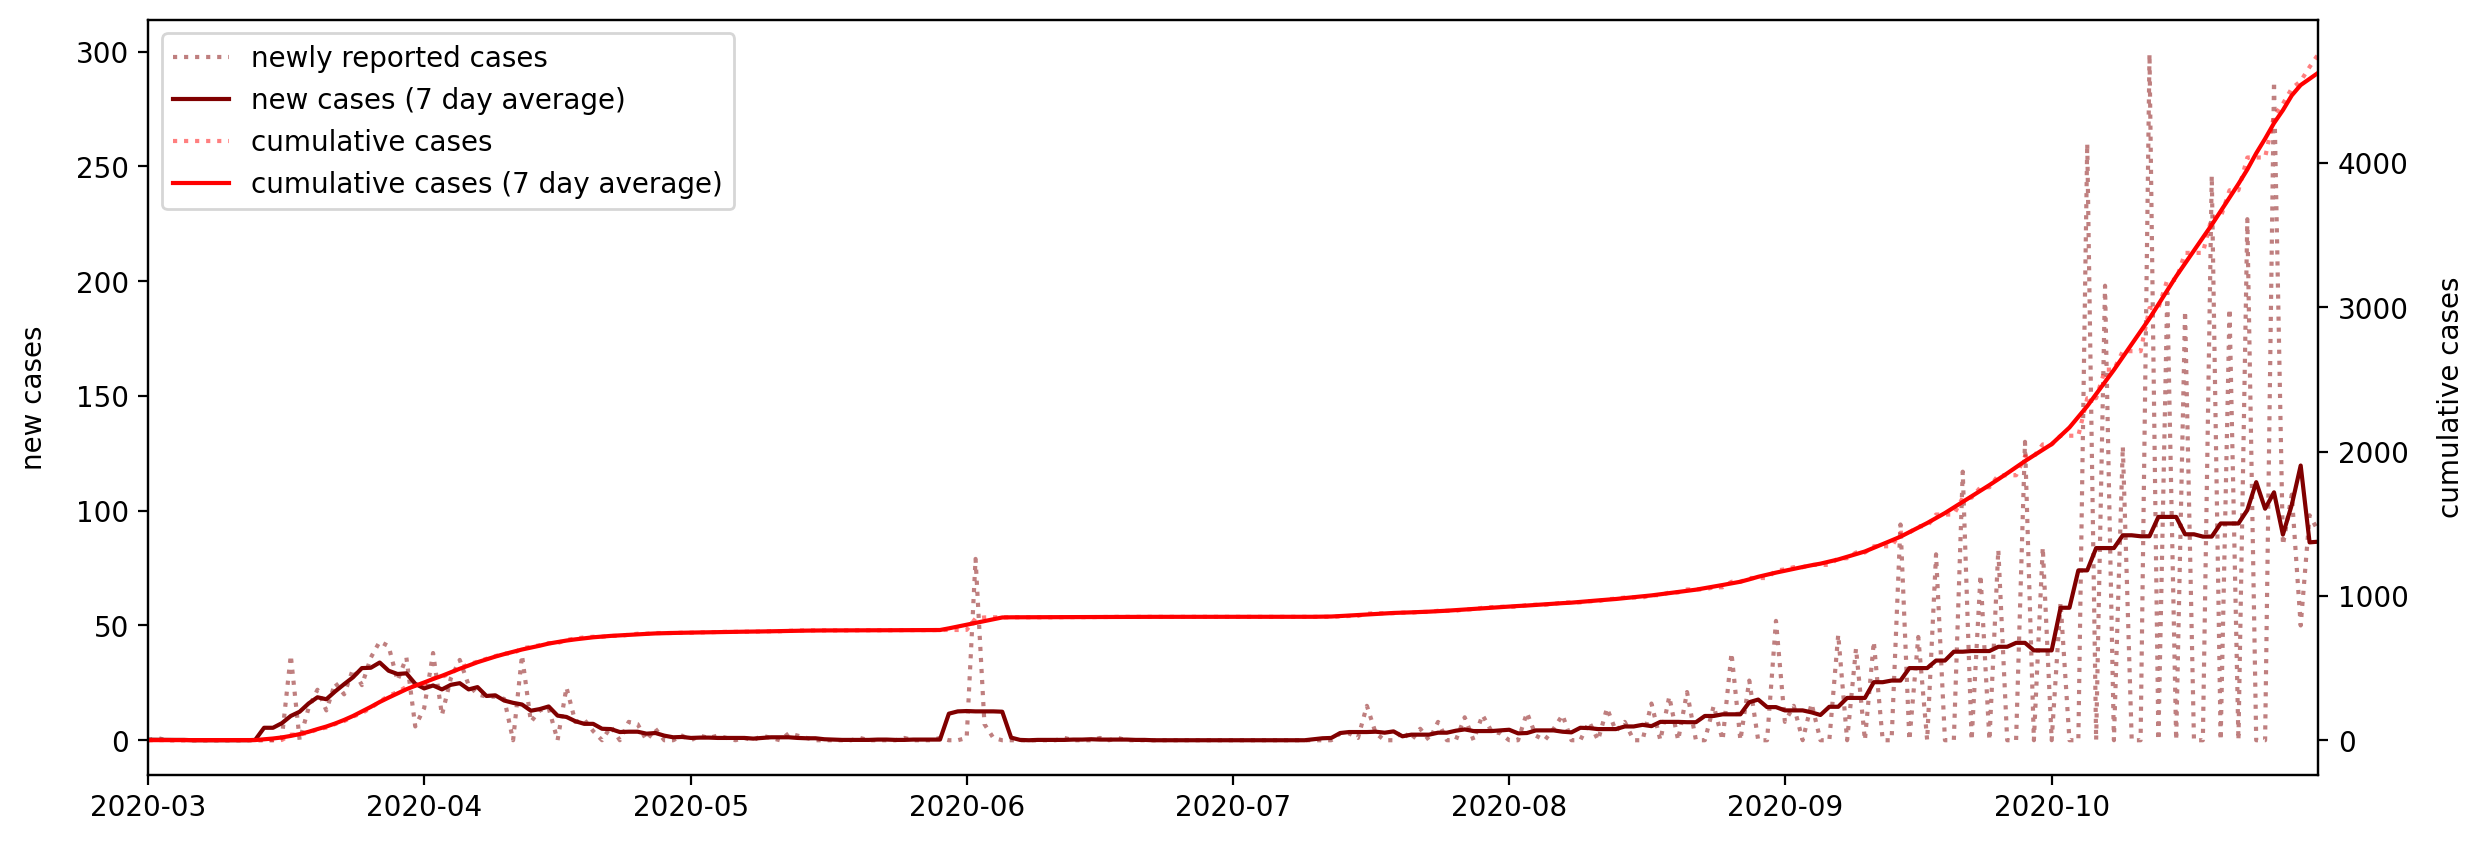

In [15]:
_ = plot_cases(cases)

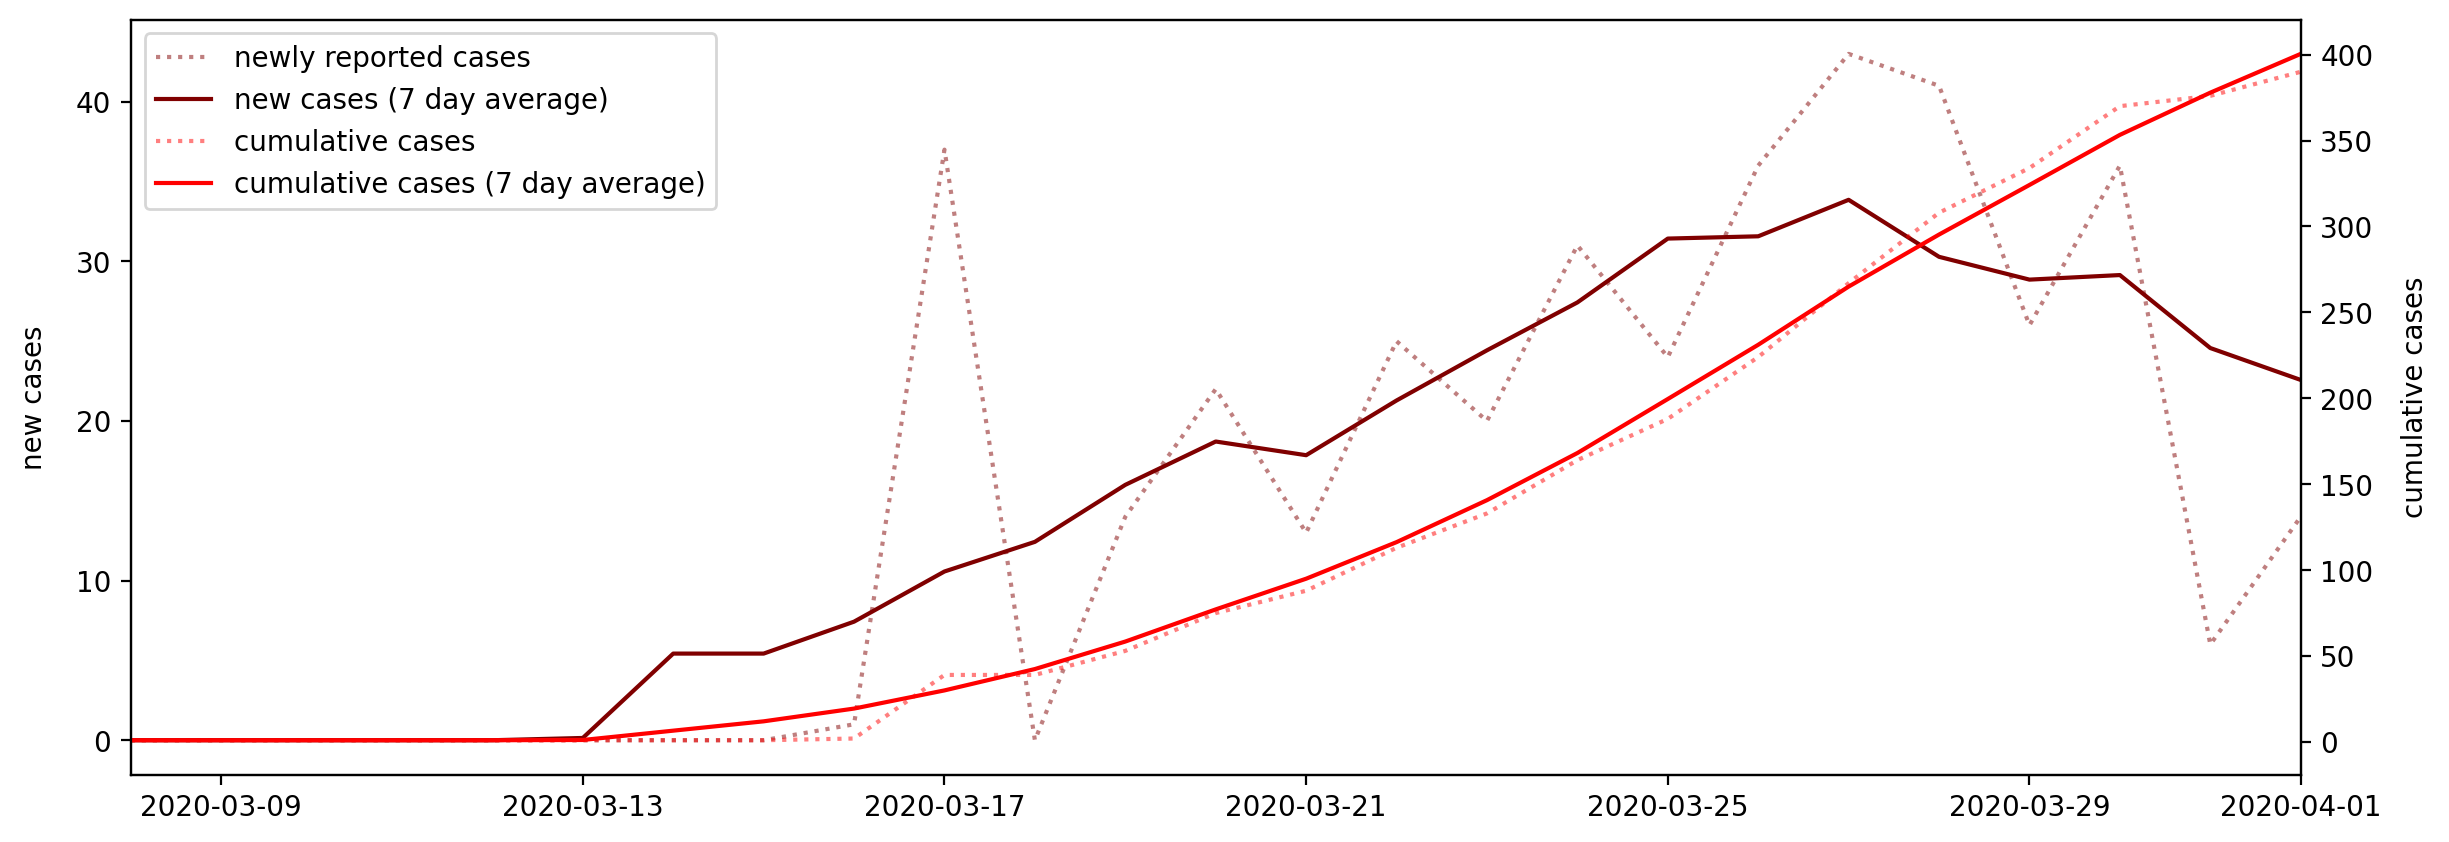

In [16]:
_ = plot_cases(cases['2020-03-08':'2020-04-01'])

In [17]:
cases['2020-03-01':'2020-04-01'][TOTAL_CASES_SMOOTHED_7D]

date
2020-03-01      0.750000
2020-03-02      0.800000
2020-03-03      0.833333
2020-03-04      0.857143
2020-03-05      1.000000
2020-03-06      1.000000
2020-03-07      1.000000
2020-03-08      1.000000
2020-03-09      1.000000
2020-03-10      1.000000
2020-03-11      1.000000
2020-03-12      1.000000
2020-03-13      1.142857
2020-03-14      6.571429
2020-03-15     12.000000
2020-03-16     19.428571
2020-03-17     30.000000
2020-03-18     42.428571
2020-03-19     58.428571
2020-03-20     77.142857
2020-03-21     95.000000
2020-03-22    116.285714
2020-03-23    140.714286
2020-03-24    168.142857
2020-03-25    199.571429
2020-03-26    231.142857
2020-03-27    265.000000
2020-03-28    295.285714
2020-03-29    324.142857
2020-03-30    353.285714
2020-03-31    377.857143
2020-04-01    400.428571
Freq: D, Name: cumulative cases (7 day average), dtype: float64

Specific to study dates

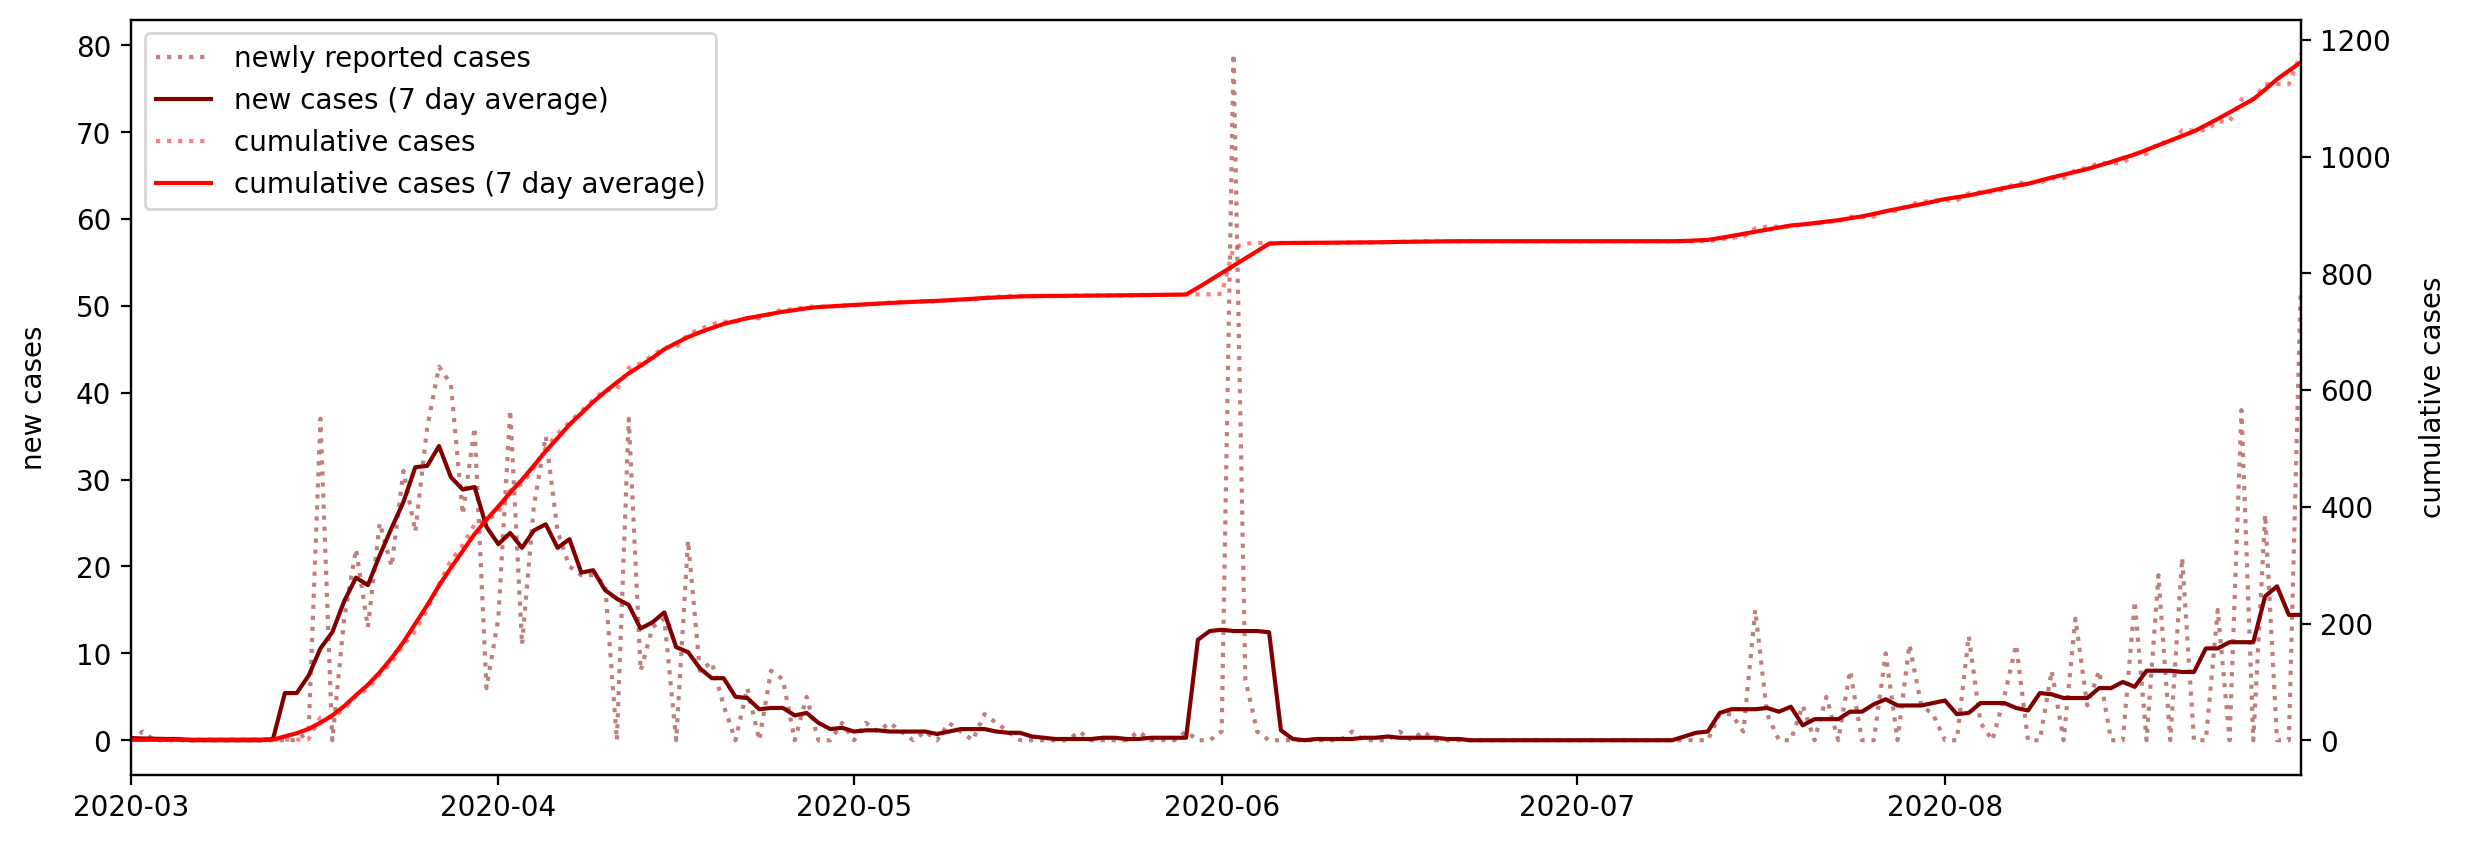

In [18]:
ax = plot_cases(cases.reindex(study_dates_idx))

Compare how to handle late May case reports

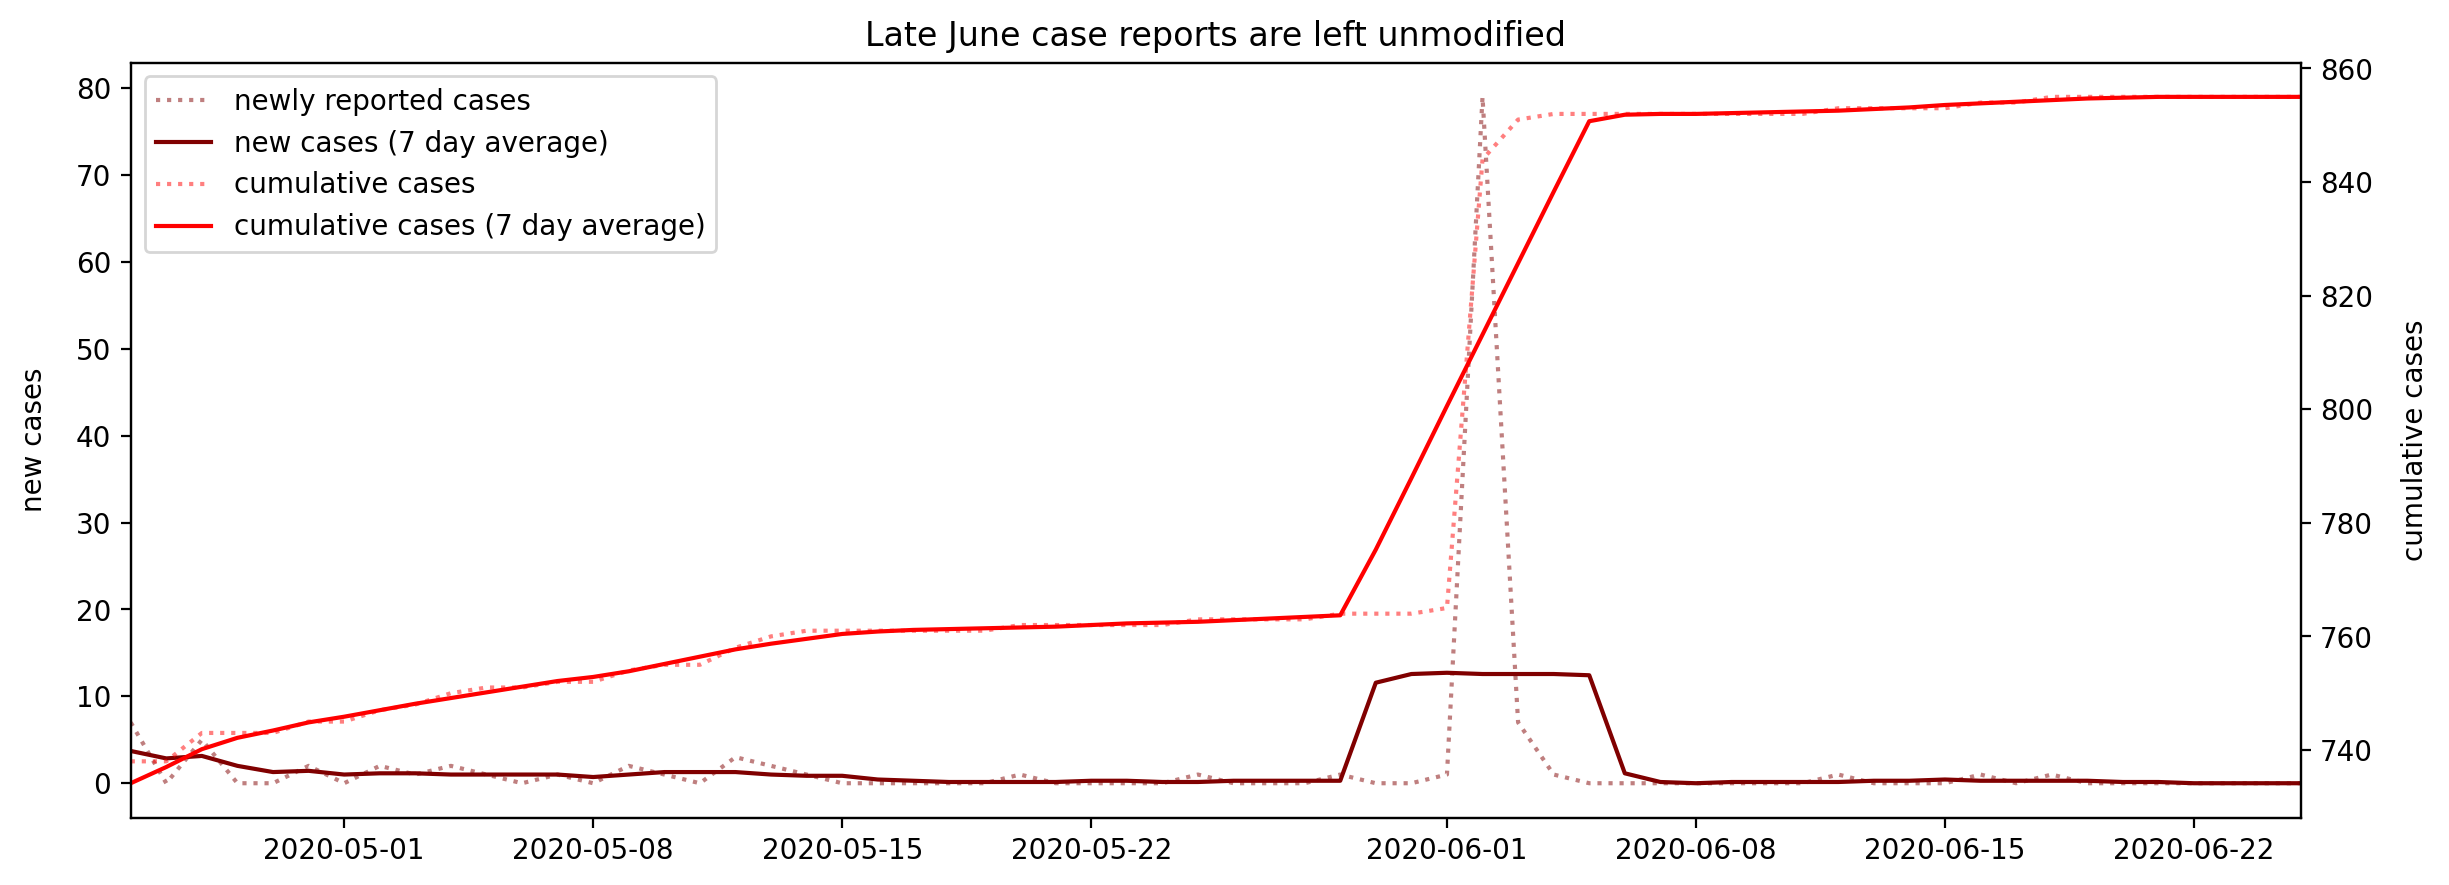

In [19]:
ax = plot_cases(cases.loc['2020-04-25':'2020-06-25'])
_ = ax.set_title('Late June case reports are left unmodified')

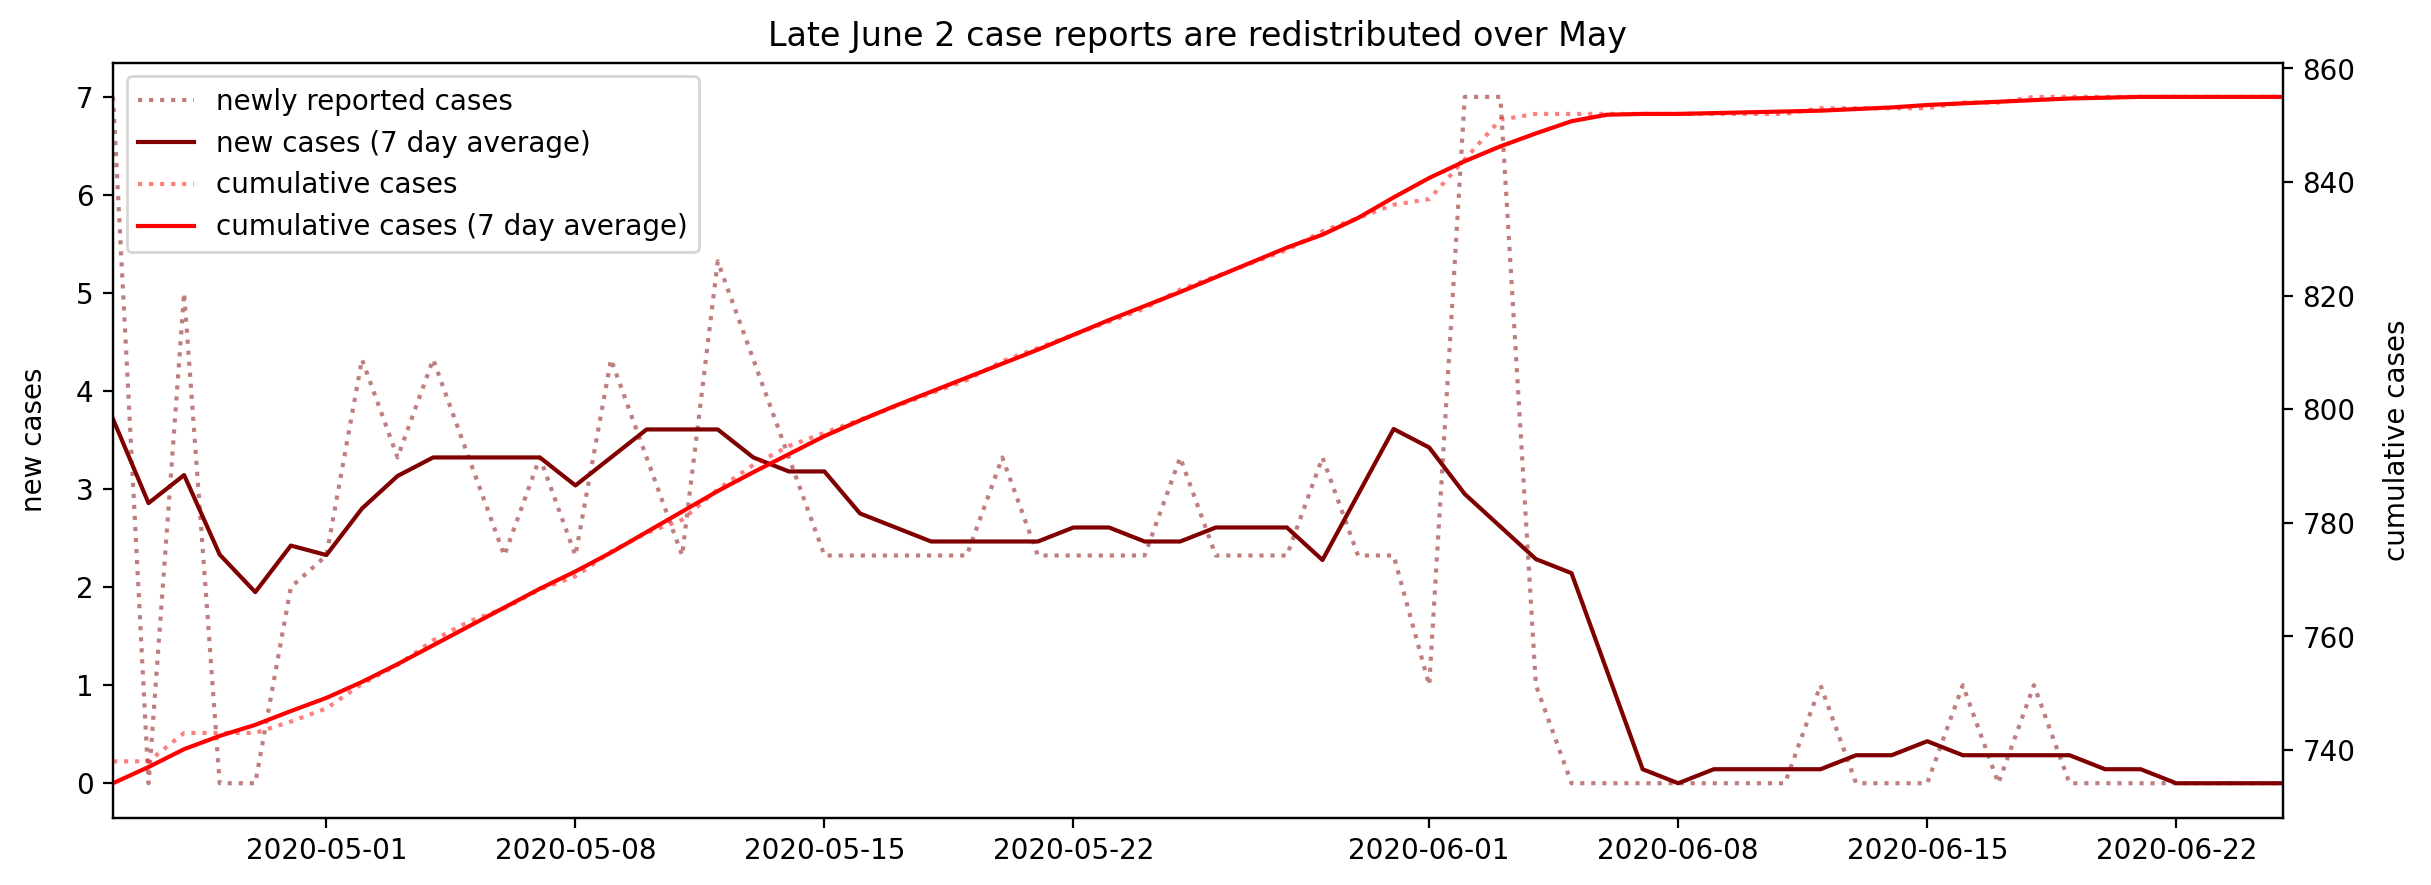

In [20]:
ax = plot_cases(cases_redistribute_june_2.loc['2020-04-25':'2020-06-25'])
_ = ax.set_title('Late June 2 case reports are redistributed over May')

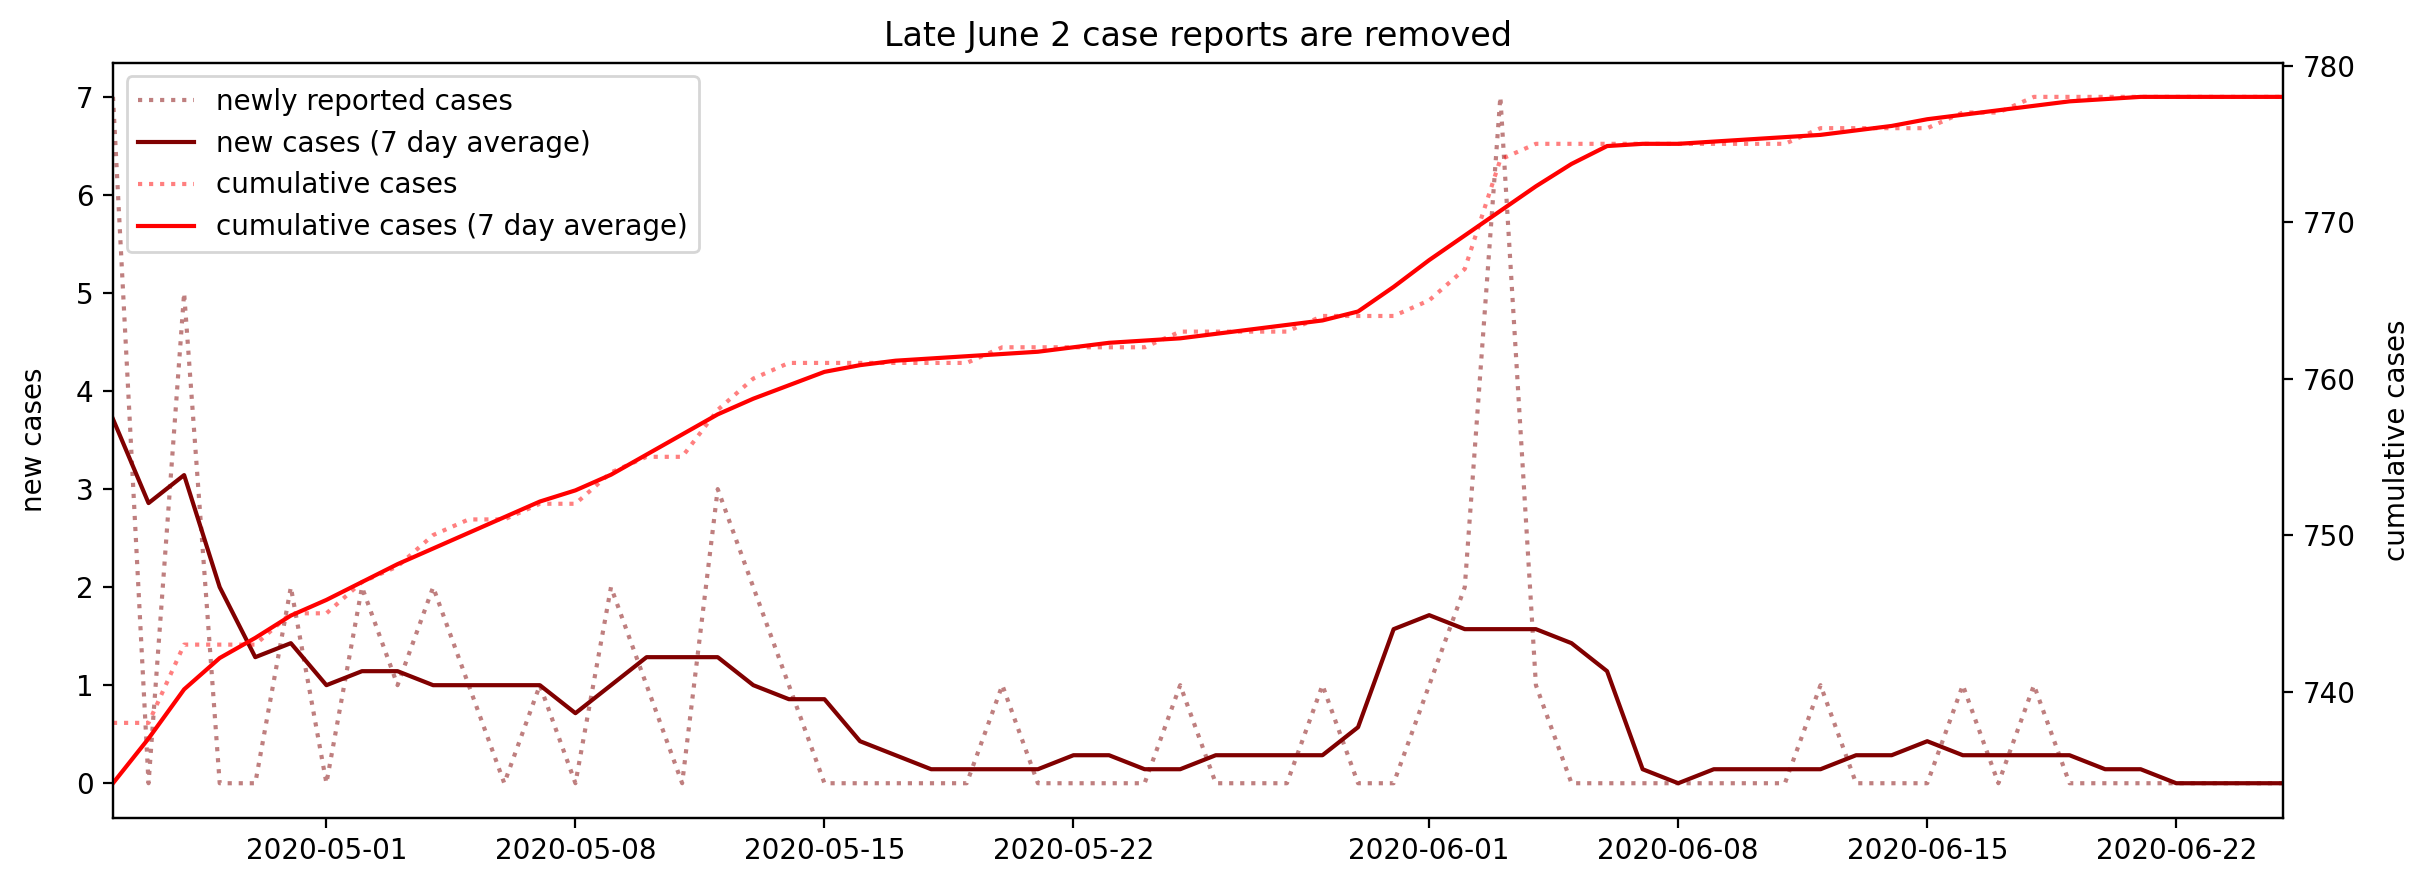

In [21]:
ax = plot_cases(cases_remove_june_2.loc['2020-04-25':'2020-06-25'])
_ = ax.set_title('Late June 2 case reports are removed')

Data update: Late June 2 case reports are removed.

In [22]:
cases = cases_remove_june_2

## Studies data

March 14: 1st day when there are more than 2 official case reports in 7 day average, and 1st week of lockdown.

In [30]:
reported_cases = cases[TOTAL_CASES_SMOOTHED_7D]
reported_cases.head(28)

date
2020-03-01      0.750000
2020-03-02      0.800000
2020-03-03      0.833333
2020-03-04      0.857143
2020-03-05      1.000000
2020-03-06      1.000000
2020-03-07      1.000000
2020-03-08      1.000000
2020-03-09      1.000000
2020-03-10      1.000000
2020-03-11      1.000000
2020-03-12      1.000000
2020-03-13      1.142857
2020-03-14      6.571429
2020-03-15     12.000000
2020-03-16     19.428571
2020-03-17     30.000000
2020-03-18     42.428571
2020-03-19     58.428571
2020-03-20     77.142857
2020-03-21     95.000000
2020-03-22    116.285714
2020-03-23    140.714286
2020-03-24    168.142857
2020-03-25    199.571429
2020-03-26    231.142857
2020-03-27    265.000000
2020-03-28    295.285714
Freq: D, Name: cumulative cases (7 day average), dtype: float64

In [31]:
train_start = '2020-03-14'
train_dates_5_07 = ('2020-03-14', '2020-05-07')
train_dates_5_14 = ('2020-03-14', '2020-05-14')
train_dates_5_21 = ('2020-03-14', '2020-05-21')
train_dates_5_28 = ('2020-03-14', '2020-05-28')
train_dates_5_31 = ('2020-03-14', '2020-05-31')

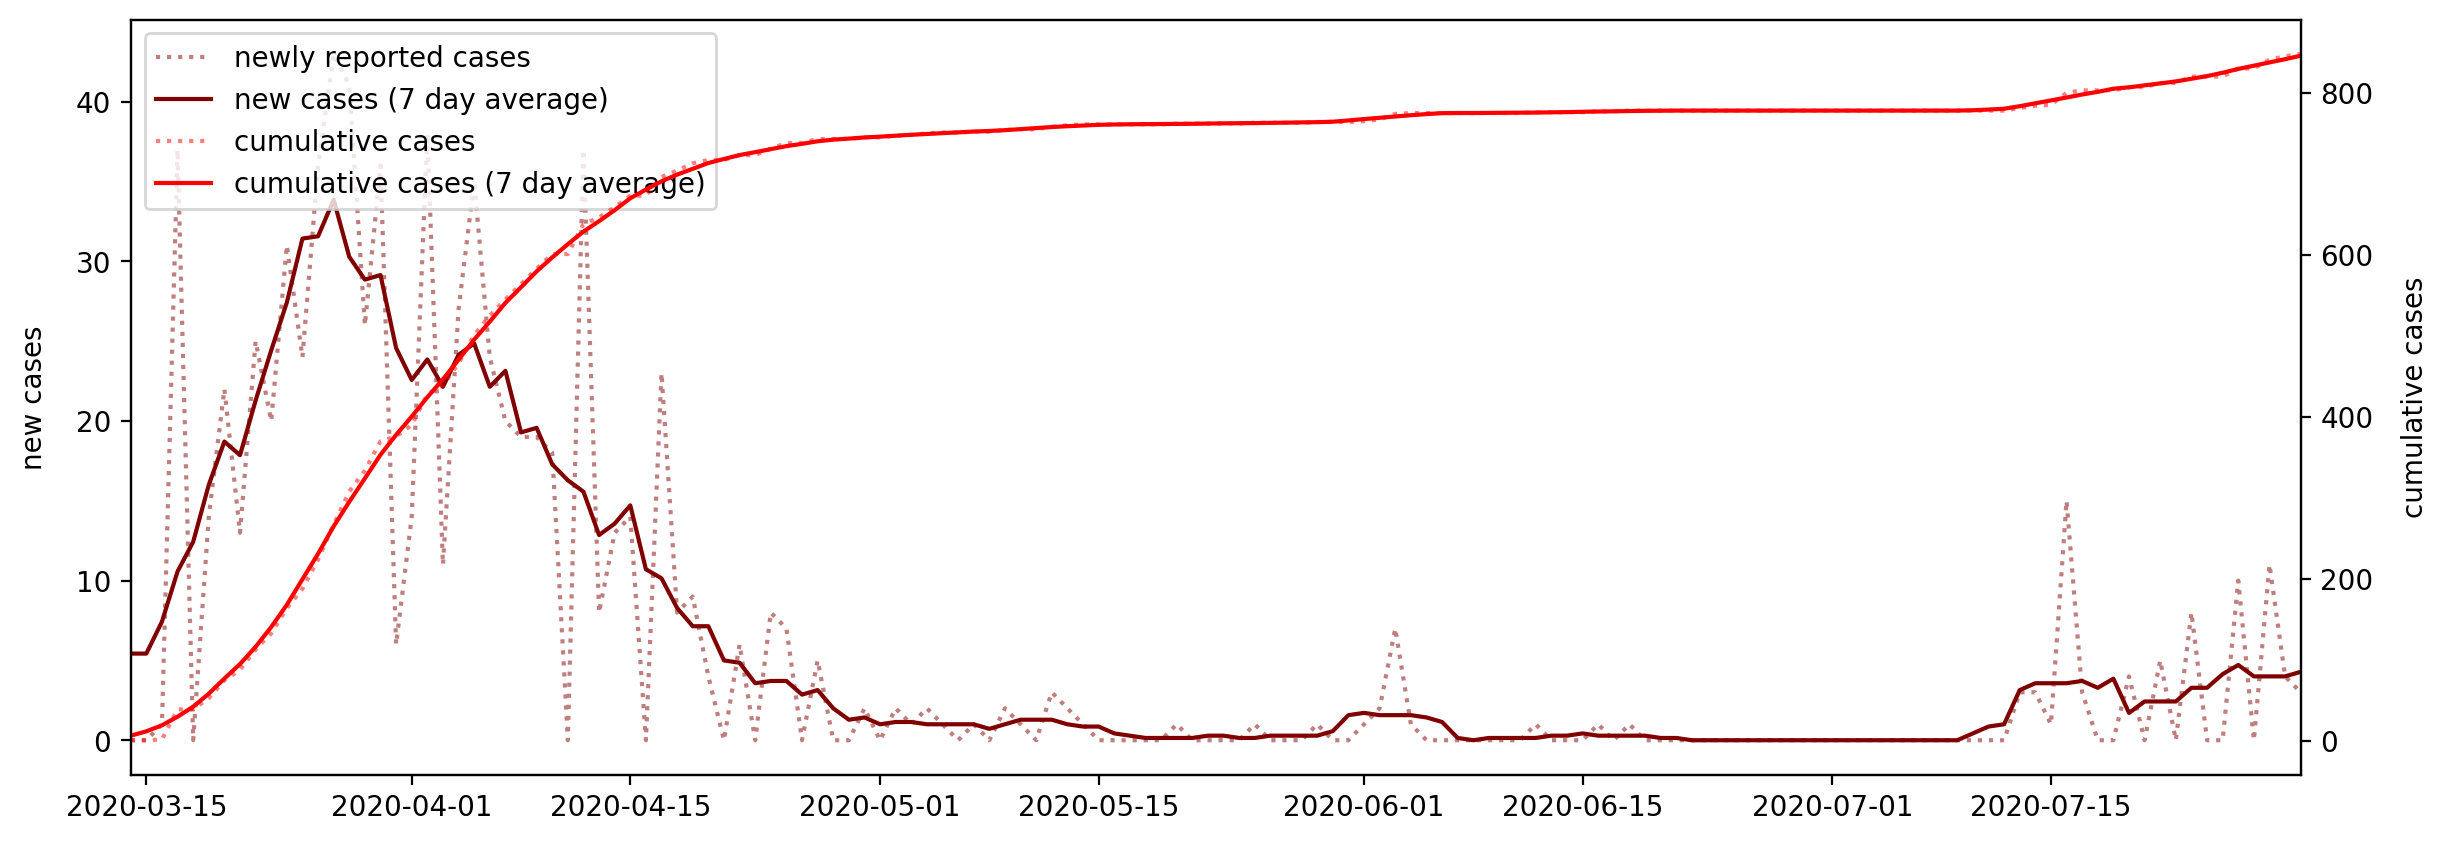

In [32]:
ax = plot_cases(cases.loc['2020-03-14':'2020-07-31'], dpi=100)
plt.show()

### Plotting Helpers

In [33]:
# colors

color_static_pop = 'tab:orange'
color_dynamic_pop = 'purple'

## Mobility data

There are missing data due to missed data reported by the telecom. We impute values for the missing dates and then transform the data as follows: 

For each missing period of days, t in [k, l], the mean value over the days [k-7, k-1] union [l+1, l+7] is used as the inferred value for t in [k, l].

The data is smoothed by averaging over a 7-day rolling window (which is the same method applied to the reported cases data).

###### Missing data dates

2019:
1. 2019-03-01 (data starts for 2019 after this date)
2. 2019-06-07 - 2019-06-11

2020:
1. 2020-02-14 - 2020-03-01 (only 2020-03-01 overlaps with study period)
2. 2020-06-28 - 2020-06-29
3. 2020-07-21 - 2020-07-27

In [64]:
# Set up the date objects and ranges to fix

m1 = '2020-03-01' # pd.date_range(pd.to_datetime('2020-02-14', format=date_fmt), '2020-03-01')
m2 = pd.date_range(pd.to_datetime('2020-06-28', format=date_fmt), '2020-06-29')
m3 = pd.date_range(pd.to_datetime('2020-07-21', format=date_fmt), '2020-07-27')

td1 = pd.date_range(pd.to_datetime('2020-03-01', format=date_fmt),
              pd.to_datetime('2020-03-01', format=date_fmt) + timedelta(days=7))
td2 = pd.date_range(pd.to_datetime('2020-06-28', format=date_fmt) - timedelta(days=7),
              pd.to_datetime('2020-06-29', format=date_fmt) + timedelta(days=7))
td3 = pd.date_range(pd.to_datetime('2020-07-21', format=date_fmt) - timedelta(days=7),
              pd.to_datetime('2020-07-27', format=date_fmt) + timedelta(days=7))

date_fixes = [
    (m1, td1),
    (m2, td2),
    (m3, td3),
]

transform_suffix = ' transformed'
def telecom_data_transform(df):
    # set missing data values to NaN
    # transform over transform dates
    for (missing, transform) in date_fixes:
        df.loc[missing,:] = np.NaN
    for c in df.columns:
        df[c+transform_suffix] = df[c]
        for (missing, transform) in date_fixes:
            df.loc[missing, c+transform_suffix] = df.loc[transform].mean()[c]
            # smooth the transformed data
        df[c+transform_suffix] = df[c+transform_suffix].rolling(
            window=7, center=True, min_periods=1).mean()
    return df

### Mobility: Presence

Here we show the presence data. This data is used to estimate a dynamic realtime population census.

In [78]:
PRESENCE_DATA_FILEPATH = './../outputs/metrics/2020/presence_6_day_window.csv'

N_df = pd.read_csv(
    PRESENCE_DATA_FILEPATH,
    parse_dates=[DATE]
).set_index(DATE).reindex(data_dates_idx)
N_df = telecom_data_transform(N_df)
N_df.head()

all  tourists  non-tourists  all transformed  \
date                                                           
2020-03-01      NaN       NaN           NaN     91962.000000   
2020-03-02  93207.0   29638.0       63569.0     91750.000000   
2020-03-03  89721.0   26109.0       63612.0     92547.666667   
2020-03-04  89616.0   26013.0       63603.0     94216.428571   
2020-03-05  90902.0   27254.0       63648.0     95304.000000   

            tourists transformed  non-tourists transformed  
date                                                        
2020-03-01          28314.821429              63647.178571  
2020-03-02          28102.657143              63647.342857  
2020-03-03          28834.214286              63713.452381  
2020-03-04          30449.755102              63766.673469  
2020-03-05          31499.285714              63804.714286

Max and min for populations

In [82]:
start_end_dates = [
    ('2020-03-01', '2020-07-31'),
    ('2020-03-01', '2020-08-31'),
    ('2020-03-07', '2020-07-31'),
    ('2020-03-07', '2020-08-31'),
]
for (d1,d2) in start_end_dates:
    print('minimum and maximum populations from %s - %s: %d and %d' % (
        d1, d2,
        N_df['all transformed'][d1:d2].min(), N_df['all transformed'][d1:d2].max(),
    ))

minimum and maximum populations from 2020-03-01 - 2020-07-31: 54617 and 95304
minimum and maximum populations from 2020-03-01 - 2020-08-31: 54617 and 95304
minimum and maximum populations from 2020-03-07 - 2020-07-31: 54617 and 94230
minimum and maximum populations from 2020-03-07 - 2020-08-31: 54617 and 94230


#### Plot the presence and population data

In [83]:
def plot_pop(N_df, with_pop=False, dpi=100):
    fig, ax = plt.subplots(1, figsize=(14, 4), dpi=dpi)
    if with_pop:
        ax.axhline(y=ANDORRA_POPULATION, color=color_static_pop, linestyle='-', label='official population')
    ax.plot(N_df.index, N_df['all'], '. ', c=color_dynamic_pop, label='dynamic population (tourists and non-tourists)')
    ax.plot(N_df.index, N_df['all transformed'], '-', c=color_dynamic_pop, alpha=0.5)
    ax.plot(N_df.index, N_df['non-tourists'], '+', c=color_dynamic_pop, label='non-tourist population')
    ax.plot(N_df.index, N_df['non-tourists transformed'], '-', c=color_dynamic_pop, alpha=0.5)
    ax.plot(N_df.index, N_df['tourists'], 'x', c=color_dynamic_pop, label='tourist population')
    ax.plot(N_df.index, N_df['tourists transformed'], '-', c=color_dynamic_pop, alpha=0.5)
    ax.legend()
    ax.set_xlim(N_df.index.min(), N_df.index.max())
    ax.set_ylim(0, N_df.max().max()*1.1)
    ax.set_ylabel('population')
    ax.set_xlabel('date')
    return ax

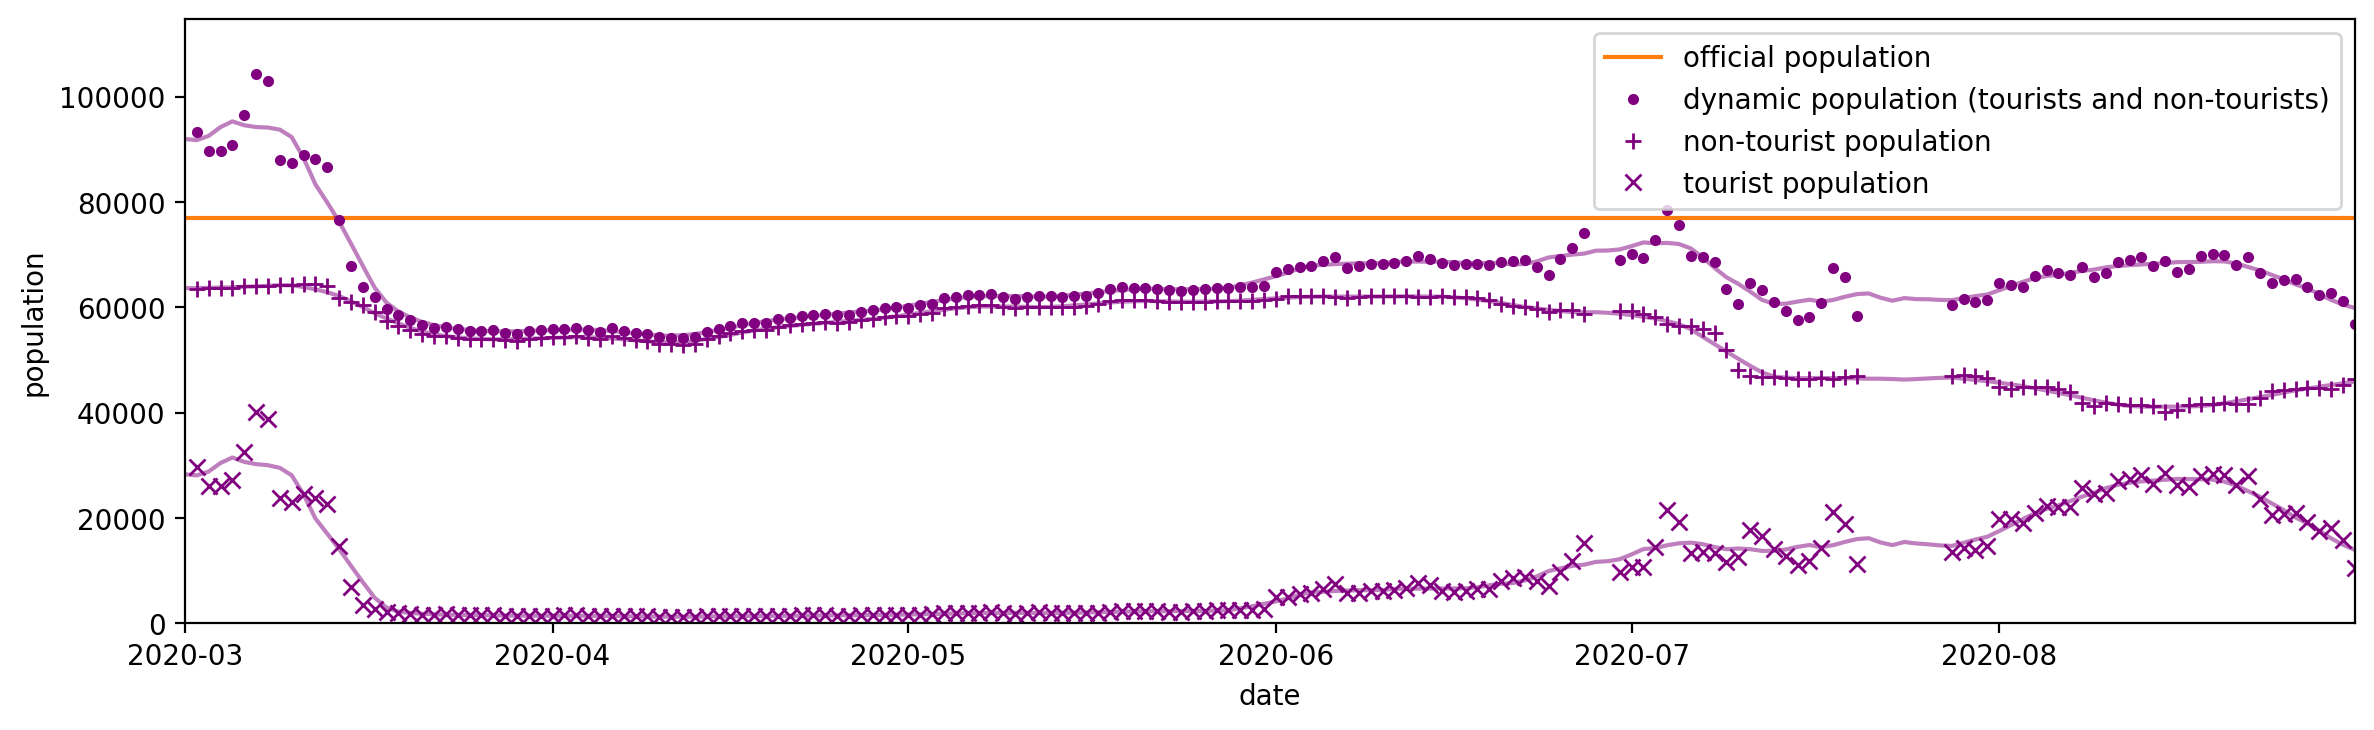

In [84]:
ax = plot_pop(N_df.loc[:'2020-08-31'], with_pop=True)

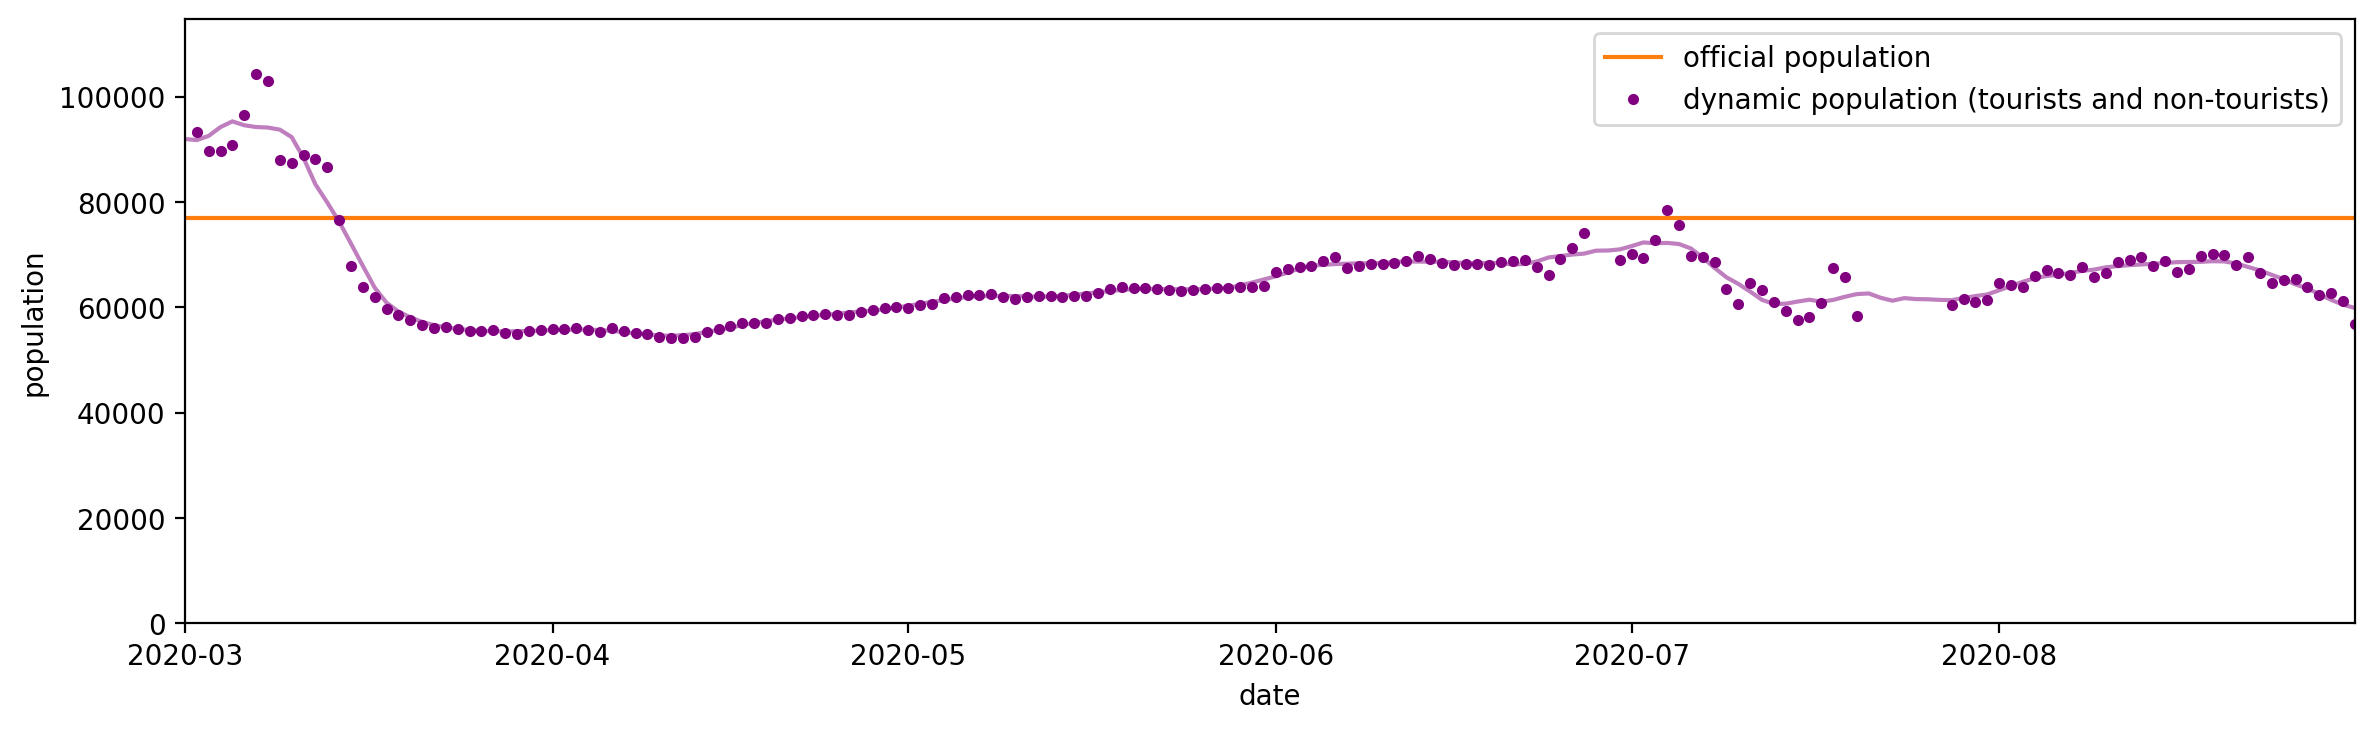

In [85]:
fig, ax = plt.subplots(1, figsize=(14, 4), dpi=100)
ax.axhline(y=ANDORRA_POPULATION, color=color_static_pop, linestyle='-', label='official population')
plot_idx = N_df.loc[:'2020-08-31'].index
ax.plot(plot_idx, N_df.loc[plot_idx]['all'],'. ', c=color_dynamic_pop, label='dynamic population (tourists and non-tourists)')
ax.plot(plot_idx, N_df.loc[plot_idx]['all transformed'], '-', c=color_dynamic_pop, alpha=0.5)
ax.legend()
ax.set_xlim(plot_idx.min(),
            plot_idx.max())
ax.set_ylim(0, N_df.max().max()*1.1)
ax.set_ylabel('population')
_ = ax.set_xlabel('date')

In [86]:
N_all = N_df['all transformed']

### Telecoms data: Mobility

In [92]:
METRICS_FPATH = './../outputs/metrics'

In [129]:
def get_entrances_data(year=2020, data_idx=data_dates_idx):
    # fpath = METRICS_FPATH + '/%s/entrance_departure.csv'%year
    fpath = METRICS_FPATH + '/%s/entrance_departure_6_day_window.csv'%year
    df = pd.read_csv(fpath).rename(columns={'Unnamed: 0': DATE}).set_index(DATE)
    df.index = pd.to_datetime(df.index)
    df = df.reindex(data_idx)
    entrance_departure_cols = list(df.columns)
    entrance_cols = [c for c in entrance_departure_cols if c.startswith('entrance_')]
    departure_cols = [c for c in entrance_departure_cols if c.startswith('departures_')]
    assert(len(entrance_cols)+len(departure_cols)==len(df.columns))
    entrances = df[entrance_cols].sum(axis=1)
    return entrances

In [130]:
entrances_data = get_entrances_data()
entrances_df = telecom_data_transform(pd.DataFrame({
    DATE: entrances_data.index,
    'entrances': entrances_data,
}).set_index(DATE))
entrances_df.head()

entrances  entrances transformed
date                                        
2020-03-01        NaN           12215.750000
2020-03-02    26094.0           11114.400000
2020-03-03     5160.0           11293.833333
2020-03-04     5334.0           12127.428571
2020-03-05     6709.0           12275.000000

In [131]:
def get_total_trips_data(year=2020, data_idx=data_dates_idx):
    fpath = ('%s/%s/trips.csv' % (METRICS_FPATH, year))
    df = pd.read_csv(fpath).set_index(DATE)
    df.index = pd.to_datetime(df.index)
    df = df.reindex(data_idx)['total trips']
    return df

In [132]:
total_trips_data = get_total_trips_data()
total_trips_df = telecom_data_transform(pd.DataFrame({
    DATE: total_trips_data.index,
    'total trips': total_trips_data,
}).set_index(DATE))
total_trips_df.head()

total trips  total trips transformed
date                                            
2020-03-01          NaN            560585.464286
2020-03-02     573065.0            565161.571429
2020-03-03     573473.0            570046.309524
2020-03-04     542712.0            567369.265306
2020-03-05     583466.0            553091.857143

In [304]:
plot_idx = total_trips_df[:'2020-07-31'].index

total trips


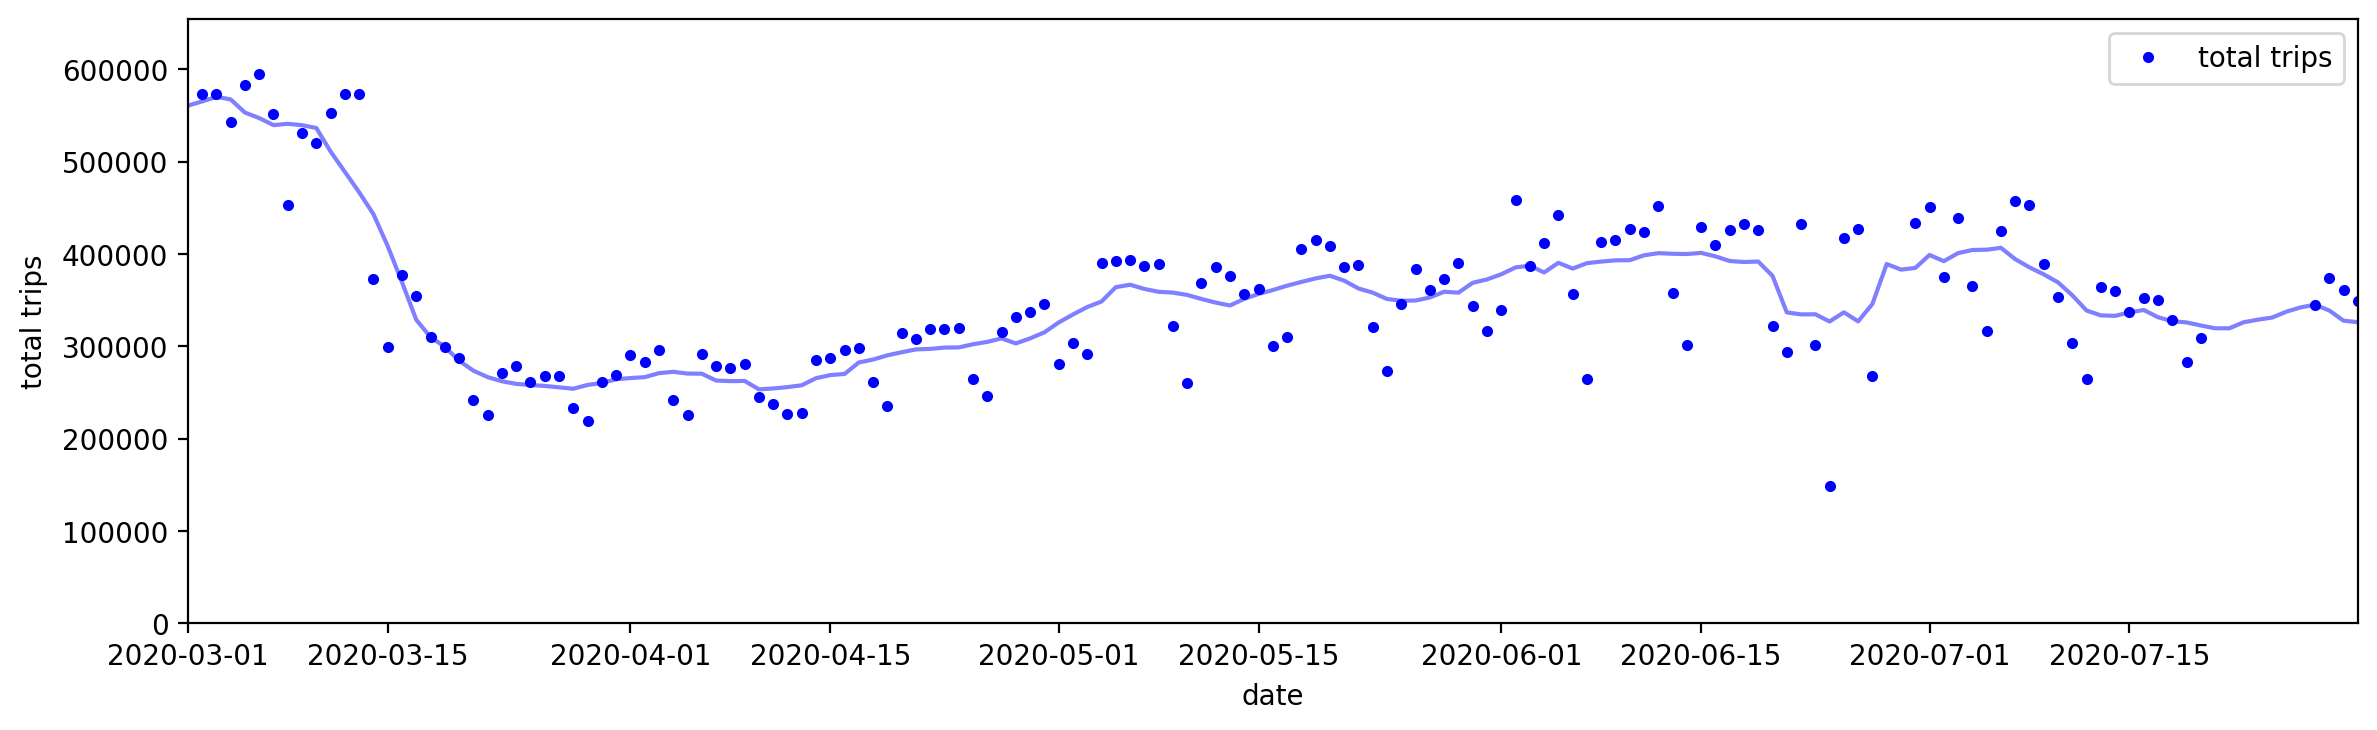

entrances


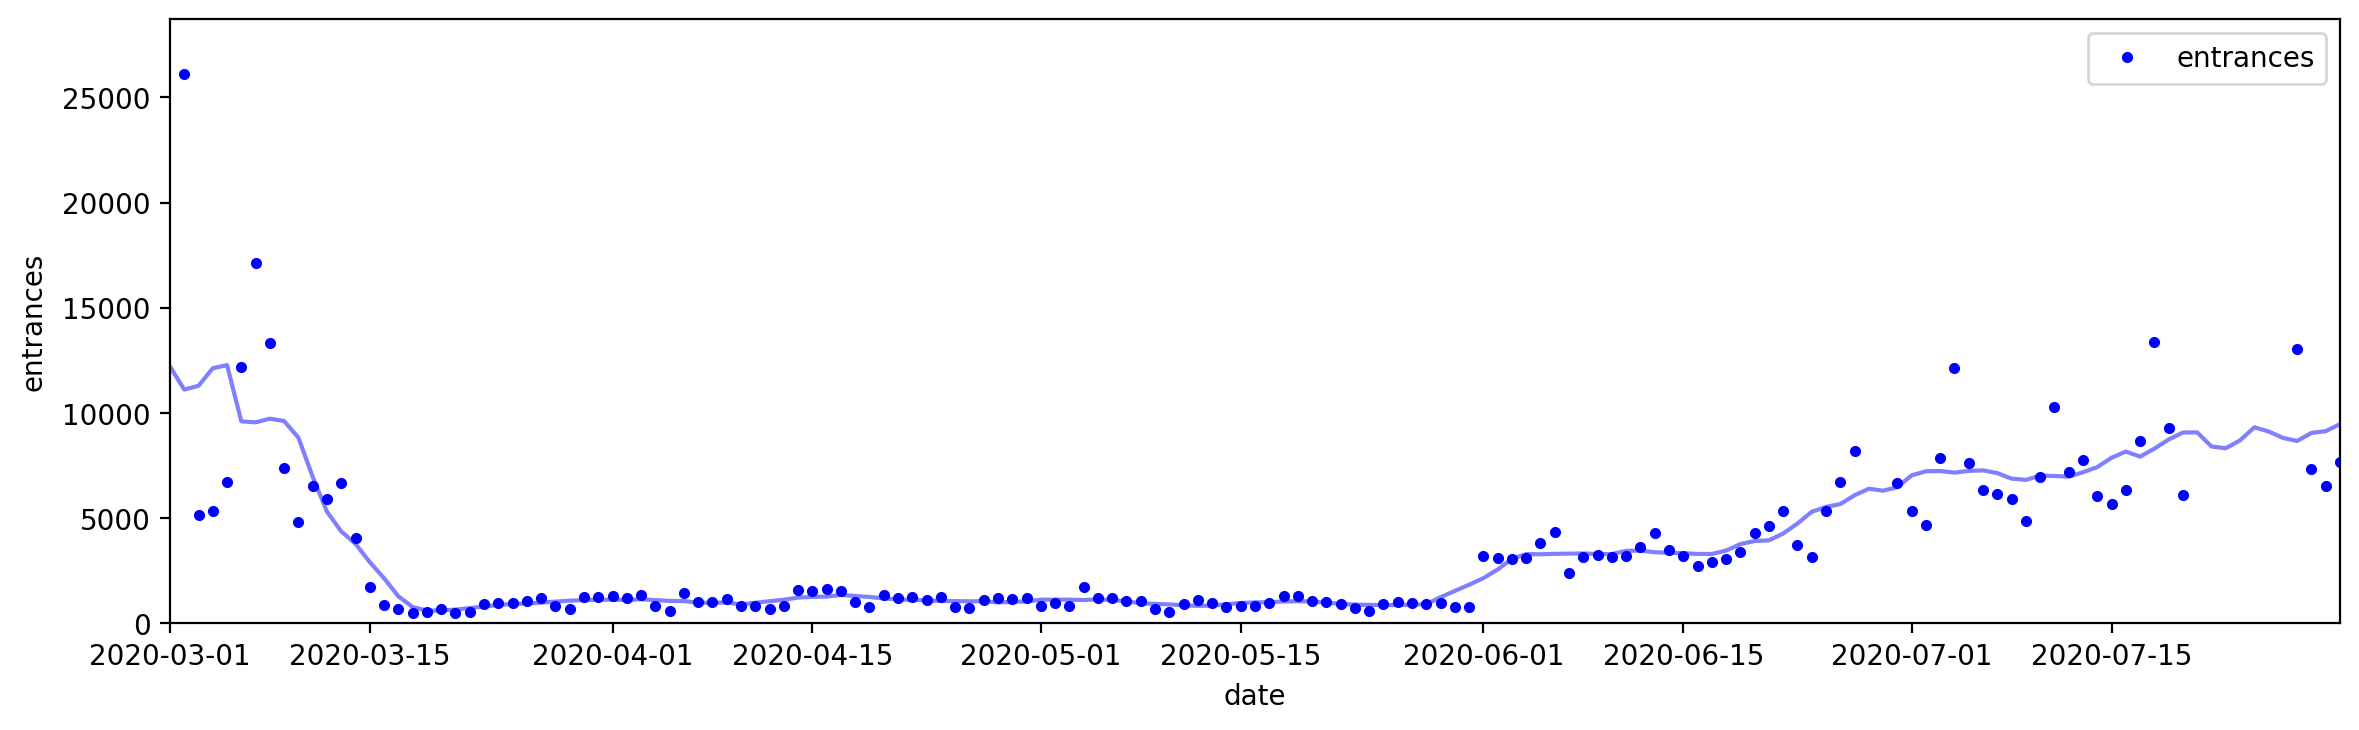

In [306]:
for m, df in [('total trips', total_trips_df), ('entrances', entrances_df)]:
    print(m)
    fig, ax = plt.subplots(1, figsize=(14, 4), dpi=100)
    ax.plot(plot_idx, df.loc[plot_idx][m], '. ', label=m, color='blue')
    ax.plot(plot_idx, df.loc[plot_idx][m+transform_suffix], '-', alpha=0.5, color='blue')
    ax.set_xlim(plot_idx.min(), plot_idx.max())
    ax.set_ylim(0, df.loc[plot_idx][m].max()*(1.1))
    ax.set_ylabel(m, labelpad=5)
    ax.set_xlabel('date')
    ax.legend()
    plt.show()

### Viewing our mobilility metrics used in models

Using total trips to model transmissability. 

Also using entrances

Display the telecoms data / mobility metrics superimposed on new cases data.

Our previous work showed that these data are most correlated at a shift of 18 days.

In [134]:
def plot_cases_vs_metric(metric_values, metric_name, shift=0, 
                         plot_idx=study_dates_idx, ax=None, dpi=100):
    if ax is None:
        fig, ax = plt.subplots(1, figsize=(14, 5), dpi=dpi)
    idx_len = len(plot_idx)
    c_ax = ax.twinx()
    lns = []
    lns += ax.plot(
        plot_idx, 
        metric_values[:idx_len], '-', 
        alpha=0.5, color='blue', label=metric_name,
    )
    lns += c_ax.plot(
        plot_idx,
        cases[NEW_CASES][data_dates_idx].values[shift:idx_len+shift], 
        color=c_new_cases, alpha=0.5, 
        linestyle='dotted', label='newly reported cases',
    )
    lns += c_ax.plot(
        plot_idx, 
        cases[NEW_CASES_SMOOTHED_7D][data_dates_idx].values[shift:idx_len+shift],
        color=c_new_cases, label=NEW_CASES_SMOOTHED_7D
    )
    labels = [l.get_label() for l in lns]
    ax.legend(lns, labels)
    ax.set_title(metric_name)
    if shift > 0:
        fig.suptitle('Cases data shifted by -%s days' % shift)
    _ = ax.set_xlabel('date')
    _ = ax.set_xlim(plot_idx[0], plot_idx[-1])
    
    return ax

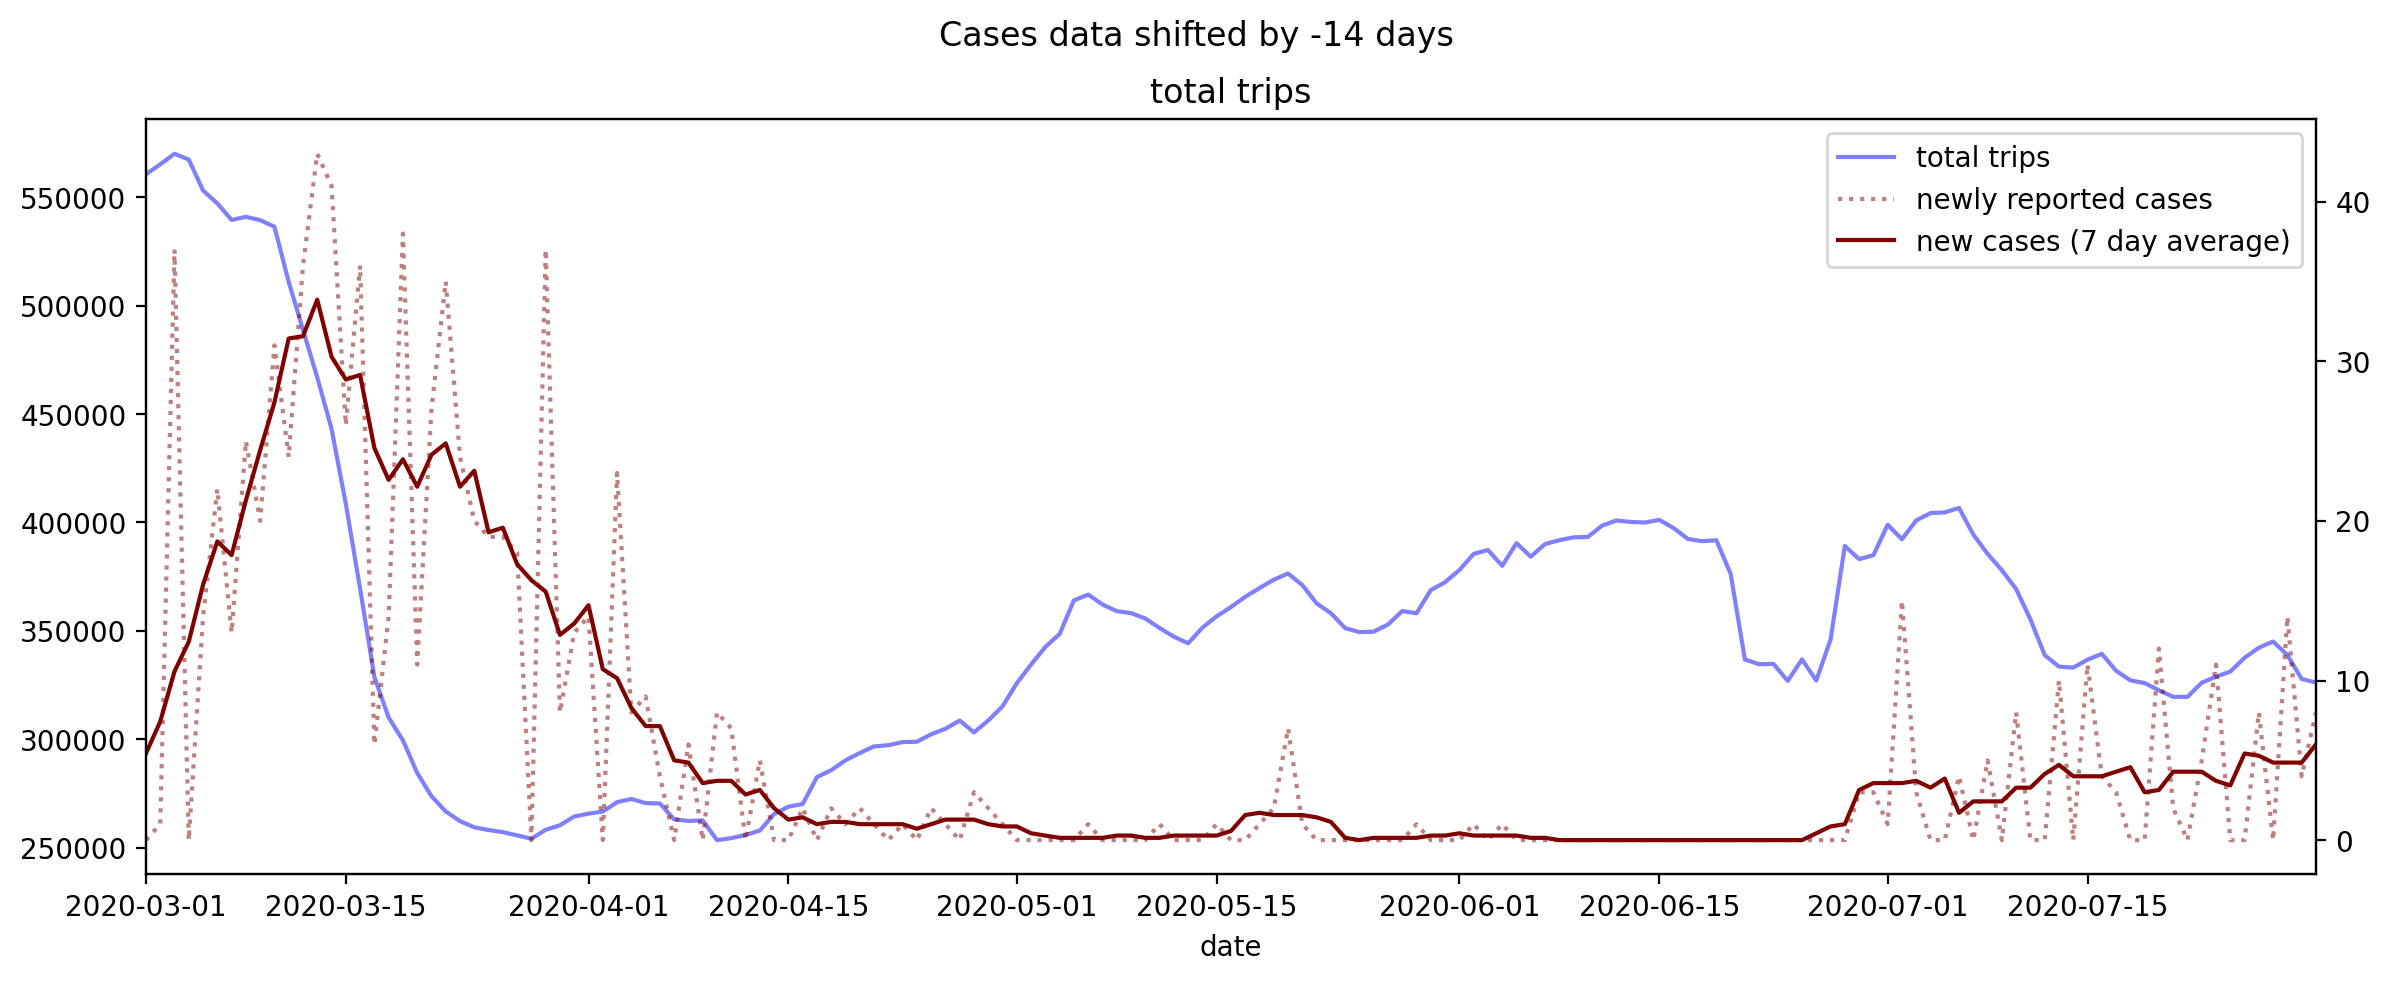

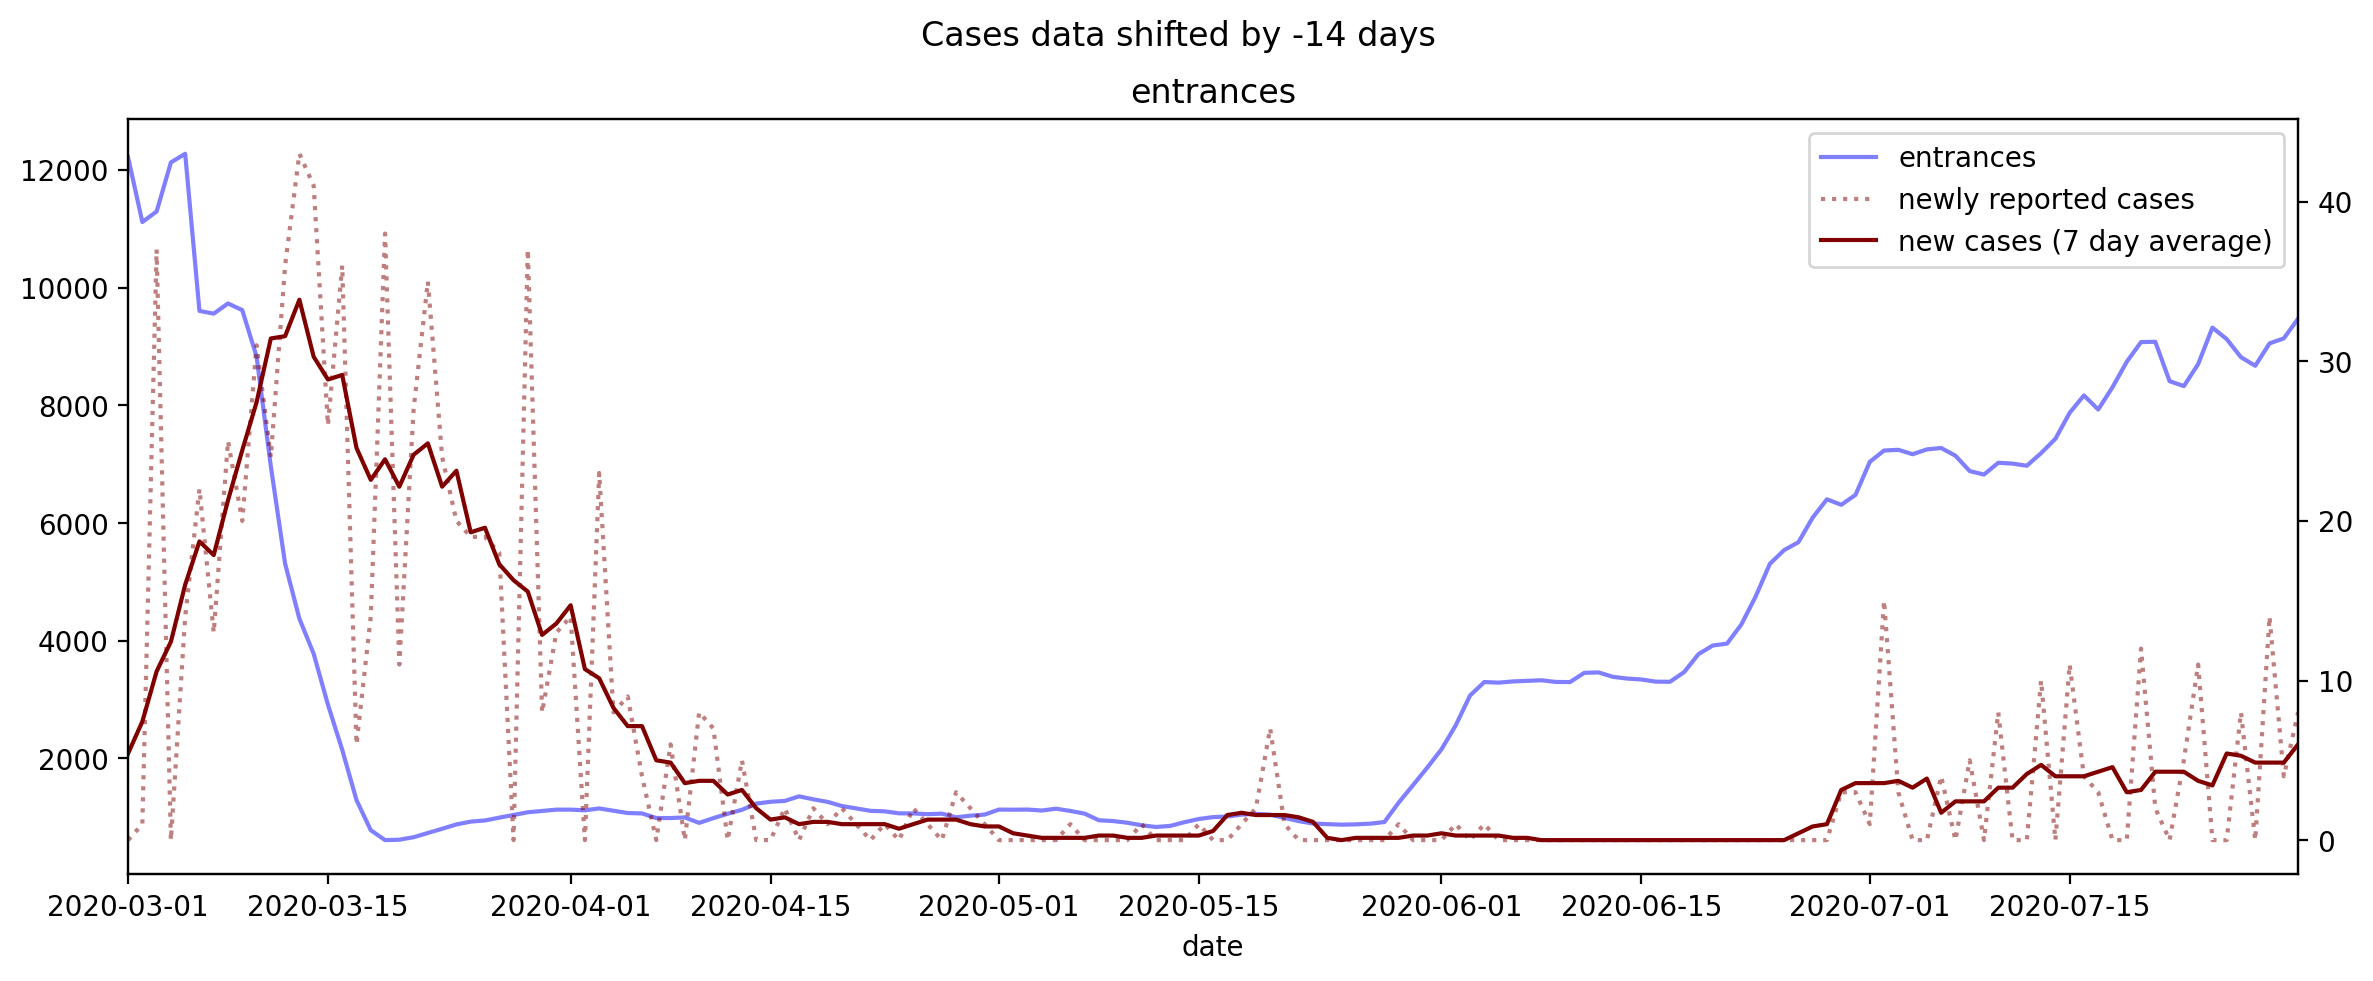

In [307]:
for m, df in [('total trips', total_trips_df), ('entrances', entrances_df)]:
    metric_values = df[m+transform_suffix]
    ax = plot_cases_vs_metric(metric_values, m, shift=14, plot_idx=plot_idx, dpi=100)
    plt.show()

In [141]:
entrances = entrances_df['entrances'+transform_suffix]
entrances.head()

date
2020-03-01    12215.750000
2020-03-02    11114.400000
2020-03-03    11293.833333
2020-03-04    12127.428571
2020-03-05    12275.000000
Name: entrances transformed, dtype: float64

In [142]:
total_trips = total_trips_df['total trips'+transform_suffix]
total_trips.head()

date
2020-03-01    560585.464286
2020-03-02    565161.571429
2020-03-03    570046.309524
2020-03-04    567369.265306
2020-03-05    553091.857143
                  ...      
2020-10-27    392379.857143
2020-10-28    390282.000000
2020-10-29    404906.500000
2020-10-30    406050.600000
2020-10-31    404593.500000
Name: total trips transformed, Length: 245, dtype: float64

## SEIR models

What are reasonable bounds for parameters? Bounds should be specified for MLE optimization.

$R_0$ shouldn't be higher than about 5 (https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1008031) or 6 (https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article)

$R_0 = \beta / \gamma $ --> $\beta = R_0 \times \gamma$




In [143]:
COVID_LATENT_PERIOD = 5.2  # 1/σ ~ 1/5.2 for COVID-19

REPORTING_RATE = 1/11  # estimated by serology screening 

In [144]:
# default (lower, upper) bounds for values estimated by MLE
opt_bounds_dict = {}
# Suppose 2 - 14 days for I --> R
opt_bounds_dict['gamma'] = (1/10, 1/2)
# For Reproductive number: 
# assume lower bound of 0.1, upper bound ~6 (would be 6 with gamma min 1/10)
opt_bounds_dict['beta'] = tuple(sorted(np.multiply((6, 0.1), opt_bounds_dict['gamma'])))
# b is used to form beta for mobility models
opt_bounds_dict['b'] = (0,2)

According to Andorran estimates, there were 5 active cases as of March 15.
https://docs.google.com/spreadsheets/d/1Y8pejkELBICZSt2YY_mnMFl-NpYFV1ZooE1RrM9AAoc/edit#gid=1563516694

This should help compute the minimum estimates for E0,I0.

In [145]:
active_cases_3_15 = 5/REPORTING_RATE
active_cases_3_15

55.0

Check maximum reported cases values within the first days to estimate max E0, I0.

In [146]:
print(reported_cases[:'2020-03-31']/REPORTING_RATE)

date
2020-03-01       8.250000
2020-03-02       8.800000
2020-03-03       9.166667
2020-03-04       9.428571
2020-03-05      11.000000
2020-03-06      11.000000
2020-03-07      11.000000
2020-03-08      11.000000
2020-03-09      11.000000
2020-03-10      11.000000
2020-03-11      11.000000
2020-03-12      11.000000
2020-03-13      12.571429
2020-03-14      72.285714
2020-03-15     132.000000
2020-03-16     213.714286
2020-03-17     330.000000
2020-03-18     466.714286
2020-03-19     642.714286
2020-03-20     848.571429
2020-03-21    1045.000000
2020-03-22    1279.142857
2020-03-23    1547.857143
2020-03-24    1849.571429
2020-03-25    2195.285714
2020-03-26    2542.571429
2020-03-27    2915.000000
2020-03-28    3248.142857
2020-03-29    3565.571429
2020-03-30    3886.142857
2020-03-31    4156.428571
Freq: D, Name: cumulative cases (7 day average), dtype: float64


In [147]:
# Assume there are at least as many infected and exposed 
opt_bounds_dict['E0'] = (40, 4000)
opt_bounds_dict['I0'] = (40, 4000)
E0_I0_MAX_DIFF = 3000

In [148]:
opt_bounds_dict

{'gamma': (0.1, 0.5),
 'beta': (0.05, 0.6000000000000001),
 'b': (0, 2),
 'E0': (40, 4000),
 'I0': (40, 4000)}

In [149]:
class SEIRModel():
    """
    SEIR model
    S: Susceptible
    E: Exposed
    I: Infectious
    R: Removed
    N = S + E + I + R
    
    For time-varying N, we consider (C) cases as separate from (R) Removed,
    though highly related:
    Removed can go in and out of the country with the changing N; however
    cases are cumulative and never decrease.
    """
    
    sigma = 5.2
    
    def __init__(self, N=ANDORRA_POPULATION, f_N=None, 
                 S0=None, E0=None, I0=None, R0=None, C0=None,
                 beta_param=None, gamma=None,
                 reporting_rate=REPORTING_RATE,
                 ts=0,
                 debug=False):
        """
        β = force of infection (transmission rate)
        σ = latent rate: average days to become symptomatic or infectious after exposure
        γ = removal rate: average rate at which individuals transition from I (infectious) to R.

        """
        # set up f_N
        if (N is None and f_N is None):
            raise Exception('Must provide population (N)')
        self.f_N = f_N if f_N is not None else self._get_f_N(N)
        # set up parameters
        self.reporting_rate = reporting_rate
        self.S = [S0]
        self.I = [I0]
        self.E = [E0]
        self.R = [R0 or ((1/self.reporting_rate)*C0 if C0 is not None else None)]
        self.C = [C0 or (self.reporting_rate*R0 if R0 is not None else None)]
        self.beta_param = beta_param
        self.gamma = gamma
        self.debug = debug
        self.default_opt_bounds_dict = copy.deepcopy(opt_bounds_dict)
        if S0 and E0 and I0 and (R0 or C0) and (ts > 0):
            # initialize with deterministic simulation
            self.S,self.E,self.I,self.R,self.C = self.simulate_deterministic(ts)
        
    def copy(self):
        obj = type(self).__new__(self.__class__)
        obj.__dict__.update(copy.deepcopy(self.__dict__))
        return obj
    
    @classmethod
    def from_dict(cls, model_dict):
        if 'class' in model_dict:
            cls = eval(model_dict.pop('class'))
        return cls(**model_dict)
        
    def to_dict(self):
        d = {
            'class': self.__class__.__name__,
            'S0':self.S[0],
            'E0':self.E[0],
            'I0':self.I[0],
            'R0':self.R[0],
            'C0':self.C[0],
            'gamma':self.gamma, 'beta_param':list(self.beta_param),
            'reporting_rate':self.reporting_rate,
            'ts': len(self.C),
        }
        return d
    
    
    def __repr__(self):
        text = 'S0 = %s\nE0 = %s\nI0 = %s\nR0 = %s\n' % (
            self.S[0], self.E[0], self.I[0], self.R[0])
        text += 'σ = %s, γ = %s\n' % (self.sigma, self.gamma)
        text += 'beta parameter: %s\n' % self.beta_param
        return text
    

    def _get_f_N(self, N):
        """Returns a slinear interpolation between daily population values (N)."""
        if not hasattr(N, '__iter__'):
            return lambda t: N
        #f = interp1d(np.arange(0,len(N)), N, kind='slinear', fill_value=(N[0], N[-1]), bounds_error=False)
        # speed tests showed the following function definition is much faster than interp1d
        def f(t):
            return (N[0] if t < 0 else (N[-1] if t >= len(N) else N[int(t)]))
        return f
    
    def plots(self, reported_cases):
        if not (self.S, self.E, self.I, self.R):
            raise Exception('Missing S, E, I, R data')
            
        plot_idx = reported_cases.index
        fig, axes = plt.subplots(3, figsize=(12,12), sharex=False)
        plt.setp(axes, xlim=(plot_idx.min(), plot_idx.max()))
        (ax_rt, ax_seir, ax_cases) = axes
        # plot reproduction number
        ax_rt = self.plot_reproduction_number(plot_idx, ax=ax_rt)
        # plot SEIR timelines
        # ax_seir.plot(dates, self.S, color='blue', label='Susceptible')
        ax_seir.plot(plot_idx, self.R, color='green', label='Removed')
        ax_seir.plot(plot_idx, self.E, color='orange', label='Exposed')
        ax_seir.plot(plot_idx, self.I, color='red', label='Infected')
        ax_seir.legend()
        # plot actual vs predicted
        ax_cases = self.plot_actual_vs_predicted(reported_cases, ax=ax_cases)
        return ax_rt, ax_seir, ax_cases
    
    def plot_reproduction_number(self, plot_idx, ax=None, dpi=50):
        if ax is None:
            fig, ax = plt.subplots(1, figsize=(12,5), dpi=dpi)
        f_beta = self._get_f_beta()
        R_t = [f_beta(t)/self.gamma for t in range(len(plot_idx))]
        ax.plot(plot_idx, R_t, label=r'$R_t$')
        ax.legend()
        return ax
        
    
    def plot_actual_vs_predicted(self, reported_cases, predicted_reported_cases=None, ax=None):
        dates = reported_cases.index
        if not predicted_reported_cases:
            predicted_reported_cases = list(self.C)
        if predicted_reported_cases is None:
            raise Exception('Missing predicted reported data')
            
        if ax is None:
            fig, ax = plt.subplots(1, figsize=(12,5))
        plt.setp(ax, xlim=(dates.min(), dates.max()))
        ax.plot(dates, reported_cases, '-', label='Actual reported cases')
        ax.plot(dates, predicted_reported_cases, '-.',label='Predicted reported cases')
        ax.legend()
        return ax
    
    
    def simulate_stochastic(self, timesteps, t_start=0,
                            S0=None, E0=None, I0=None, R0=None, C0=None,
                            f_beta=None):
        """
        Stochastically simulate the progression of S,E,I,R,C.
        
        S’(t) = -β [S(t) I(t) ] / N(t)
        E’(t) = β [S(t) I(t) ] / N(t) - σE(t)
        I’(t) = σ E(t) - γ I(t)
        R’(t) = γ I(t)
        C’(t) = γ I(t)
        
        β, σ, γ are considered probabilities in binomial distributions
        where the binomial distribution determines how much of the 
        S, E, I, R populations transition to the next compartment in
        each timestep.
        """
        f_beta = f_beta or self._get_f_beta()
        S0 = S0 or self.S[0]
        E0 = E0 or self.E[0]
        I0 = I0 or self.I[0]
        R0 = R0 or self.R[0]
        if not (f_beta and S0 and E0 and I0 and R0 and self.sigma and self.gamma):
            raise Exception('values for S0,E0,I0,R0, sigma, gamma must be set')
        
        # S, E, I, R compartments are series of values for each t in [0, timesteps]
        C0 = C0 or (self.reporting_rate*R0)
        S, E, I, R, C = [int(S0)], [int(E0)], [int(I0)], [int(R0)], [int(C0)]
        

        for i in range(timesteps):
            t = t_start + timesteps
            beta = f_beta(t)
            N = self.f_N(t)
            dN = (self.f_N(t) - self.f_N(t-1)) / self.f_N(t-1)
            
            S_t, E_t, I_t, R_t, C_t = S[i], E[i], I[i], R[i], C[i]
            # update with population changes
            # with no population changes, dNdt = 0, no change in S,E,I,R
            S_t, E_t, I_t, R_t = [(1 + dN) * Comp[i] for Comp in [S, E, I, R]]
            
            S_to_E = np.random.binomial(S_t, beta * I_t / N, size=1)[0]
            E_to_I = np.random.binomial(E_t, (1/self.sigma), size=1)[0]
            I_to_R = np.random.binomial(I_t, self.gamma, size=1)[0]
            S += [S_t - S_to_E]
            E += [E_t + S_to_E - E_to_I]
            I += [I_t + E_to_I - I_to_R]
            R += [R_t + I_to_R]
            C += [C_t + self.reporting_rate*(I_to_R)]
        return S, E, I, R, C
        
    
    def simulate_deterministic(self, timesteps, t_start=0, C0=None):
        """
        Simulates the progression of the compartment populations using
        already estimated parameters.
        Returns series for each of S,E,I,R,C over timesteps.
        """
        E0 = self.E[t_start]
        I0 = self.I[t_start]
        R0 = self.R[t_start]
        C0 = C0 or self.C[t_start]
        ts = [t for t in range(t_start, t_start + timesteps)]
        return self._integrate(ts, E0, I0, R0, C0, self._get_f_beta(), self.gamma)


    def fit(self, reported_cases, x0=None, opt_bounds=None, eps=None):
        """
        Fits the model parameters using maximum likelihood estimation.
        x0 contains starting parameters for estimation: [E0, I0, gamma, beta]
        where beta may be a list.
        """
        
        # reported cases must have whole numbers to be defined for poisson distribution
        reported_cases = [round(c) for c in reported_cases]
        self.C[0] = reported_cases[0]
        self._fit_ts = list(range(len(reported_cases)))
        
        if self.debug:
            print('fit ts:', len(self._fit_ts))
            print('C0 = ', self.C[0])
            start_d = datetime.now()
            print('%s - starting optimization' % str(start_d))
        
        # starting parameters for optimization
        opt_bounds = opt_bounds or self._get_default_bounds()
        x0 = x0 or self._get_default_x0()
        if self.debug:
            print('x0', x0, '\nbounds', opt_bounds,'\neps', eps)
        options = {} if eps is None else {'eps':eps}
        constraints = [
            {'type':'ineq', 'fun': lambda x: (-1)*(x[0] - x[1]) + E0_I0_MAX_DIFF},
        ]
        fit_result = minimize(self._neg_loglik_function, x0=x0, bounds=opt_bounds,
                              args=(self._fit_ts, reported_cases), options=options, 
                              # constraints not compatible with L-BFGS-B
                              #constraints=constraints, 
                              method="L-BFGS-B")
        self._fit_result = fit_result # for debugging
        log_likelihood = fit_result['fun']
        success = fit_result['success']
        fit_E0, fit_I0 = fit_result['x'][0], fit_result['x'][1]
        fit_gamma = fit_result['x'][2]
        fit_beta_param = fit_result['x'][3:]
        if self.debug:
            print('fit result', fit_result)
            print('E0, I0, gamma, beta', fit_E0, fit_I0, fit_gamma, fit_beta_param)
        self.gamma = fit_gamma
        self.beta_param = fit_beta_param
        R0, C0 = (1/self.reporting_rate)*self.C[0], self.C[0]
        # The starting parameters have been estimated. Estimate the time series.
        S, E, I, R, C = self._integrate(self._fit_ts, fit_E0, fit_I0, R0, C0,
                                     self._get_f_beta(fit_beta_param), self.gamma)
        self.S = S
        self.E = E
        self.I = I
        self.R = R
        self.C = C
        
        if self.debug:
            end_d = datetime.now()
            print('%s - finished optimization' % str(end_d))
            print('time:', end_d - start_d)
        
        return log_likelihood, success

    
    def _integrate(self, ts, E0, I0, R0, C0, f_beta, gamma):
        """Returns S,E,I,R,C determined by intetegration over values in ts."""
        y0 = E0, I0, R0, C0
        y = odeint(self._derivatives, y0, ts, args=(f_beta, gamma))
        E, I, R, C = y.T
        # when ts does not start at 0, ti does not equal t in ts
        S = [(self.f_N(ts[ti]) - E[ti] - I[ti] - R[ti]) for ti in range(len(ts))]
        return S, E, I, R, C
    
    def _neg_loglik_function(self, params, ts, reported_cases):
        """
        Returns the negative log liklihood for a given set of parameters.
        """
        if self.debug: print('computing -LL with params:', params)
        E0=params[0]
        I0=params[1]
        R0, C0 = (1/self.reporting_rate)*self.C[0], self.C[0]
        gamma = params[2]
        beta_param = params[3:]
        # multiple cases for how to define f_beta
        f_beta = self._get_f_beta(beta_param)
        _S, _E, _I, _R, C = self._integrate(ts, E0, I0, R0, C0, f_beta, gamma)
        predicted_reported_cases = list(C)
        LL = sum(poisson.logpmf(k=reported_cases, mu=predicted_reported_cases))
        return -LL
        
    def _derivatives(self, population, t, f_beta, gamma):
        """
        Internal function used by integration routine.

        Calculate the derivatives of the SEIR model.
        Allow for time varying beta, and time varying N.
        E, I, R, C = population are parameters.
        S is determined by N = S + E + I + R.
        where
            N may change as a function of time
            Assumes changes in N are proportional across S, E, I, R
            defaults is no change in N in which case dNdt = 0
            C is cases. C=R when N does not change
        """
        E, I, R, C = population
        N = self.f_N(t)
        S = self.f_N(t) - (E + I + R)
        dN = (self.f_N(t) - self.f_N(t-1)) / self.f_N(t)
        dEdt = dN * E \
                + f_beta(t) * ((1 + dN) * S) * ((1 + dN) * I) / N \
                - (1/self.sigma) * (1 + dN) * E
        dIdt = dN * I \
                + (1/self.sigma) * (1 + dN) * E \
                - gamma * (1 + dN) * I
        dRdt = dN * R \
                + gamma * (1 + dN) * I
        dCdt = self.reporting_rate * gamma * (1 + dN) * I # R component is not impacted by changes in N
        return dEdt, dIdt, dRdt, dCdt

    def _get_default_x0(self):
        raise NotImplementedError
    
    def _get_default_bounds(self):
        raise NotImplementedError
        
    def _get_f_beta(self, beta_param=None):
        raise NotImplementedError
        
    
class ConstantBetaSEIRModel(SEIRModel):
    
    def __init__(self, N=None, f_N=None, **kwargs):
        super().__init__(**kwargs)
        self.n_beta_param = 1
    
    def __repr__(self):
        text = 'SEIR model (constant beta)\n'
        text += super().__repr__()
        return text
    
    def _get_f_beta(self, beta_param=None):
        beta = (beta_param or self.beta_param)
        beta = beta[0] if hasattr(beta, '__iter__') else beta
        f_beta = lambda t: beta
        return f_beta
    
    def _get_default_x0(self):
        return [
            self.E[0] or np.mean(self.default_opt_bounds_dict['E0']),
            self.I[0] or np.mean(self.default_opt_bounds_dict['I0']),
            self.gamma or np.mean(self.default_opt_bounds_dict['gamma']),
            self.beta_param or np.mean(self.default_opt_bounds_dict['beta']),
        ]
    
    def _get_default_bounds(self):
        return [self.default_opt_bounds_dict[k] for k in ['E0','I0','gamma', 'beta']]



class SplineSEIRModel(SEIRModel):
    
    name = 'Spline SEIR model'
    description = 'Beta is a time varying function estimated by a linear spline function'
    
    def __init__(self, N=None, f_N=None, knots_space=28, interp_kind='slinear', **kwargs):
        """
        knots in the spline function are spaced by knots_space days apart.
        knots are parameterized by (list) beta_param
        """
        super().__init__(N=N, f_N=f_N, **kwargs)
        self.knots_space = knots_space # days between knots in spline
        self.interp_kind = interp_kind # function used to interpolate between knots

    
    def to_dict(self):
        d = SEIRModel.to_dict(self)
        d.update({
            'knots_space':self.knots_space,'interp_kind':self.interp_kind,
        })
        return d
        
        
    def __repr__(self):
        text = 'SEIR model (%s spline estimation of beta)\n' % self.interp_kind
        text += 'spline knots spaced by %s days\n' % self.knots_space
        text += super().__repr__()
        return text
    
    def _get_f_beta(self, beta_param=None):
        """
        Returns linear spline function that interpolates between knots.
        beta_param is a list of knots.
        """
        beta_param = beta_param if beta_param is not None else self.beta_param
        if beta_param is None:
            raise Exception('beta_param must be set')
        t_knots = [i*self.knots_space for i in range(len(beta_param))]
        # values less and greater than t bounds are filled with 
        # first and last knot values, respectively.
        f_beta =  interp1d(t_knots, beta_param, kind=self.interp_kind,
                  fill_value=(beta_param[0], beta_param[-1]),
                  bounds_error=False)
        return f_beta

        
    def _get_n_knots(self, t=None):
        t = t or len(self._fit_ts)
        return int(t/self.knots_space) + 1
    
    # for the MLE optimization, the last parameters are a series of knot values
    # for the linear spline beta function   
    def _get_default_x0(self, beta_param=None):
        x0 = [
            self.E[0] or np.mean(self.default_opt_bounds_dict['E0']),
            self.I[0] or np.mean(self.default_opt_bounds_dict['I0']),
            self.gamma or np.mean(self.default_opt_bounds_dict['gamma']),
        ]
        beta_param = beta_param if beta_param is not None else self.beta_param
        if beta_param is not None:
            return x0 + list(beta_param)
        return x0 + [np.mean(self.default_opt_bounds_dict['beta'])]*self._get_n_knots()
        
    def _get_default_bounds(self, beta_param=None):
        if beta_param and n_knots and (len(beta_param) != n_knots):
            raise Exception('n_knots != length of beta_param')
        beta_param = beta_param if beta_param is not None else self.beta_param
        bounds = [self.default_opt_bounds_dict[k] for k in ['E0','I0','gamma']]
        bounds += [self.default_opt_bounds_dict['beta']]*self._get_n_knots()
        return bounds

    
class MobilityDataSEIRModel(SEIRModel):
    """
    beta(t) = b0 + b1 x [mobility(t)^(b2)]
    beta_param has a length of 3: [b0, b1, b2]
    """
    
    def __init__(self, mobility_data, **kwargs):
        self.mobility_data = mobility_data
        self.n_beta_param = 3
        super().__init__(**kwargs)
        
    def __repr__(self):
        text = 'SEIR model : beta as a function of mobility data\n'
        text += super().__repr__()
        return text
    
    def _get_f_beta(self, beta_param=None):
        """
        beta(t) = b0 + b1 x [mobility(t)^(b2)]
        """
        beta_param = beta_param if beta_param is not None else self.beta_param
        if beta_param is None or (len(beta_param) is not self.n_beta_param):
            raise Exception('beta_param must be set as a 3 element list. It is instead %s' % str(beta_param))
        b0, b1, b2 = beta_param
        x = list(range(len(self.mobility_data)))
        y = b0 + ( b1 * (np.array(self.mobility_data)**b2) )
        return interp1d(x, y, kind='slinear', fill_value=(y[0], y[-1]), bounds_error=False)
    
    def _get_default_x0(self):
        x0 = [
            self.E[0] or np.mean(self.default_opt_bounds_dict['E0']),
            self.I[0] or np.mean(self.default_opt_bounds_dict['I0']),
            self.gamma or np.mean(self.default_opt_bounds_dict['gamma']),
        ]
        if self.beta_param is not None:
            return x0 + list(self.beta_param)
        return x0 + [np.mean(self.default_opt_bounds_dict['b'])]*self.n_beta_param

    def _get_default_bounds(self):
        bounds = [self.default_opt_bounds_dict[k] for k in ['E0','I0','gamma']]
        bounds += [self.default_opt_bounds_dict['b']]*self.n_beta_param
        return bounds

    
class MobilityEntrancesDataSEIRModel(SEIRModel):
    """
    beta(t) = b0 + b1 x [mobility(t)^(b2)] + b3 x [entrances(t)^b4]
    beta_param has a length of 5: [b0, b1, b2, b3, b4]
    """
    
    def __init__(self, mobility_data, entrances_data, **kwargs):
        self.mobility_data = mobility_data
        self.entrances_data = entrances_data
        self.n_beta_param = 5
        super().__init__(**kwargs)
        
    def __repr__(self):
        text = 'SEIR model : beta as a function of mobility and entrances data\n'
        text += super().__repr__()
        return text
    
    def _get_f_beta(self, beta_param=None):
        """
        beta(t) = b0 + b1 x [mobility(t)^(b2)] + b3 x [entrances(t)^b4]
        """
        beta_param = beta_param if beta_param is not None else self.beta_param
        if beta_param is None or (len(beta_param) is not self.n_beta_param):
            raise Exception('beta_param must be set as a 4 element list. It is instead %s' % str(beta_param))
        b0, b1, b2, b3, b4 = beta_param
        x = list(range(len(self.mobility_data)))
        y = b0 + ( b1 * (np.array(self.mobility_data)**b2) ) + ( b3 * (np.array(self.entrances_data)**b4) ) 
        return interp1d(x, y, kind='slinear', fill_value=(y[0], y[-1]), bounds_error=False)
    
    def _get_default_x0(self):
        x0 = [
            self.E[0] or np.mean(self.default_opt_bounds_dict['E0']),
            self.I[0] or np.mean(self.default_opt_bounds_dict['I0']),
            self.gamma or np.mean(self.default_opt_bounds_dict['gamma']),
        ]
        if self.beta_param is not None:
            return x0 + list(self.beta_param)
        return x0 + [np.mean(self.default_opt_bounds_dict['b'])]*self.n_beta_param #+ [np.mean(self.default_opt_bounds_dict['e'])] 

    def _get_default_bounds(self):
        bounds = [self.default_opt_bounds_dict[k] for k in ['E0','I0','gamma']]
        bounds += [self.default_opt_bounds_dict['b']]*self.n_beta_param
        return bounds

## Evaluation and Plotting

#### MAPE for evaluation 
Models are evaluated by making predictions on the test data time period, and then evaluating the prediction timeseries against the true data using median absolute prediction error (MAPE).

Median absolute prediction error (MAPE) has been used in recent frameworks to evaluate and compare COVID-19 models [*]. Leading models have MAPE values for 2 week forecasts of 1-3%.

[*] Predictive performance of international COVID-19 mortality forecasting models Joseph Friedman, Patrick Liu, Christopher E. Troeger, Austin Carter, Robert C. Reiner JR, Ryan M. Barber, James Collins, Stephen S. Lim, David M. Pigott, Theo Vos, Simon I. Hay, Christopher J.L. Murray, Emmanuela Gakidou medRxiv 2020. https://doi.org/10.1101/2020.07.13.20151233

In [150]:
def evaluate_mape(forecast_values, actual_values):
    """Returns median absolute prediction error."""
    return np.median(np.abs((np.array(forecast_values) - np.array(actual_values))/np.array(actual_values)))

# tests
assert(evaluate_mape([1,2],[1,2]) == 0)
assert(evaluate_mape([1,1],[1,2]) == 0.25)
assert(evaluate_mape([1,1,1],[1,2,1]) == 0)

#### Making predictions

To run a simulation for future (unseen) days, we use the interaction parameter values (β, γ) for the model that were already estimated through MLE.

We use starting S0, E0, I0, R0 parameters estimated from the point that we want to start the simulation. These paramaters are from the timeseries of S,E,I,R that were already estimated via MLE.

The resulting timeseries for R is used to forecast reported cases. These forecasts are compared to actual reported cases.

#### Model estimation and evaluation pipeline

- define model (model parameters must be estimated)
- train: (deterministic MLE) estimate model parameters using MLE with reported cases data over the training period
- predict: use estimated model parameters to forecast new reported cases for the test period
    - deteterministic simulation: run simulation from most recent parameters to get forecast of new cases.
    - stochastic simulation: run many (N=1000) simulations to get forecast new cases. Use many simulated values to take mean of forecast new cases, and 95% CIs
- evaluate: use MAPE to evaluate the model by comparing the (mean) forecast reported cases cases to actual reported cases.


In [151]:
def run_simulations(model, simulate_timesteps, t_start, C0=None, runs=1000):
    """
    Runs stochastic simulations.
    Returns Sruns, Eruns, Iruns, Rruns, Cruns
    where each is a series containing [runs] arrays
    and each array is a series of values representing the associated 
    compartment population over time.
    """
    # use the last (determinimistically) estimated parameters as starting parameters
    S0 = model.S[t_start]
    E0 = model.E[t_start]
    I0 = model.I[t_start]
    R0 = model.R[t_start] # TODO: instead use the estimated reported cases at this time?
    Sruns, Eruns, Iruns, Rruns, Cruns = [], [], [], [], []
    for i in range(runs):
        S, E, I, R, C = model.simulate_stochastic(
            simulate_timesteps, t_start=t_start,
            S0=S0, E0=E0, I0=I0, R0=R0, C0=C0,
        )
        Sruns += [S]
        Eruns += [E]
        Iruns += [I]
        Rruns += [R]
        Cruns += [C]
    return Sruns, Eruns, Iruns, Rruns, Cruns

In [152]:
def plot_cases_predicted_vs_actual(cases_actual, cases_predicted,
                                   dates_idx=None,
                                   ax=None, color='purple', 
                                   CI95=False, plot_all_runs=False):
    """
    cases predicted may be 2-dimensional
    where each array represents a simulation run.
    """
    if not ax:
        fig, ax = plt.subplots(1, figsize=(14,6))
        
    cases_predicted = np.asarray(cases_predicted)
    multi_run = (len(cases_predicted.shape) > 1)
    if multi_run:
        pred_means, pred_lower95CIs, pred_upper95CIs = get_mean_CIs(cases_predicted, CI=95)
    
    dates_idx = dates_idx if dates_idx is not None else list(range(len(cases_actual)))
    ax.plot(dates_idx, cases_actual, color='red', label='actual reported cases')
    
    pred_days = np.asarray(cases_predicted).shape[-1]
    pred_values = pred_means if multi_run else cases_predicted
    plot_pred_values = [np.nan]*(len(dates_idx) - pred_days) + list(pred_values)
    
    ax.plot(dates_idx, plot_pred_values, color='purple', alpha=1,
            label='predicted reported cases')
    if multi_run and CI95:
        ax.plot(dates_idx,
                [np.nan]*(len(dates_idx) - pred_days) + list(pred_lower95CIs), '--',
                color=color, alpha=0.5)
        ax.plot(dates_idx,
                [np.nan]*(len(dates_idx) - pred_days) + list(pred_upper95CIs), '--',
                color=color, alpha=0.5)
    if multi_run and plot_all_runs:
        print('plotting %s runs' % len(pred_cases_runs))
        runs_alpha= 1/(len(pred_cases_runs))
        for values in pred_cases_runs:
            ax.plot(dates_idx,
                    [np.nan]*(len(dates_idx) - pred_days) + list(values),
                    color=color, alpha=runs_alpha)


    ax.set_xlim(dates_idx.min(), dates_idx.max())
    ax.set_ylim(0, max(cases_actual.max(), pred_values.max())*(1.1))
    ax.set_ylabel('cases')
    ax.set_xlabel('date')
    # color the prediction section
    ax.axvline(dates_idx.values[-pred_days], color='gray', lw=1, alpha=0.7)
    ax.fill_between(dates_idx.values, 0,
                        max(cases_actual.max(), pred_values.max())*(1.1),
                        where=dates_idx >= dates_idx[-pred_days],
                        facecolor='orange', alpha=0.3)
    ax.legend()
    return ax

In [153]:
def get_mean_CIs(values, CI=95):
    """Returns means, lower 95 CI, upper 95 CI"""
    means = np.mean(np.array(values), axis=0)
    lowerCIs, upperCIs = np.percentile(np.array(values), [100-CI,CI], axis=0)
    return means, lowerCIs, upperCIs

### Example

An example of how the models / functions work.

Using the (dummy) constant beta model, and just one train/test period.

In [154]:
train_start = train_dates_5_28[0]
train_end = train_dates_5_28[1]
test_end = '2020-07-31'
print('training period: %s - %s' % (train_start, train_end))

training period: 2020-03-14 - 2020-05-28


587.0962647802494 True


SEIR model (constant beta)
S0 = 72391.00370109153
E0 = 2245.4039031820557
I0 = 2286.5923957264195
R0 = 77.0
σ = 5.2, γ = 0.1
beta parameter: [0.05919787]

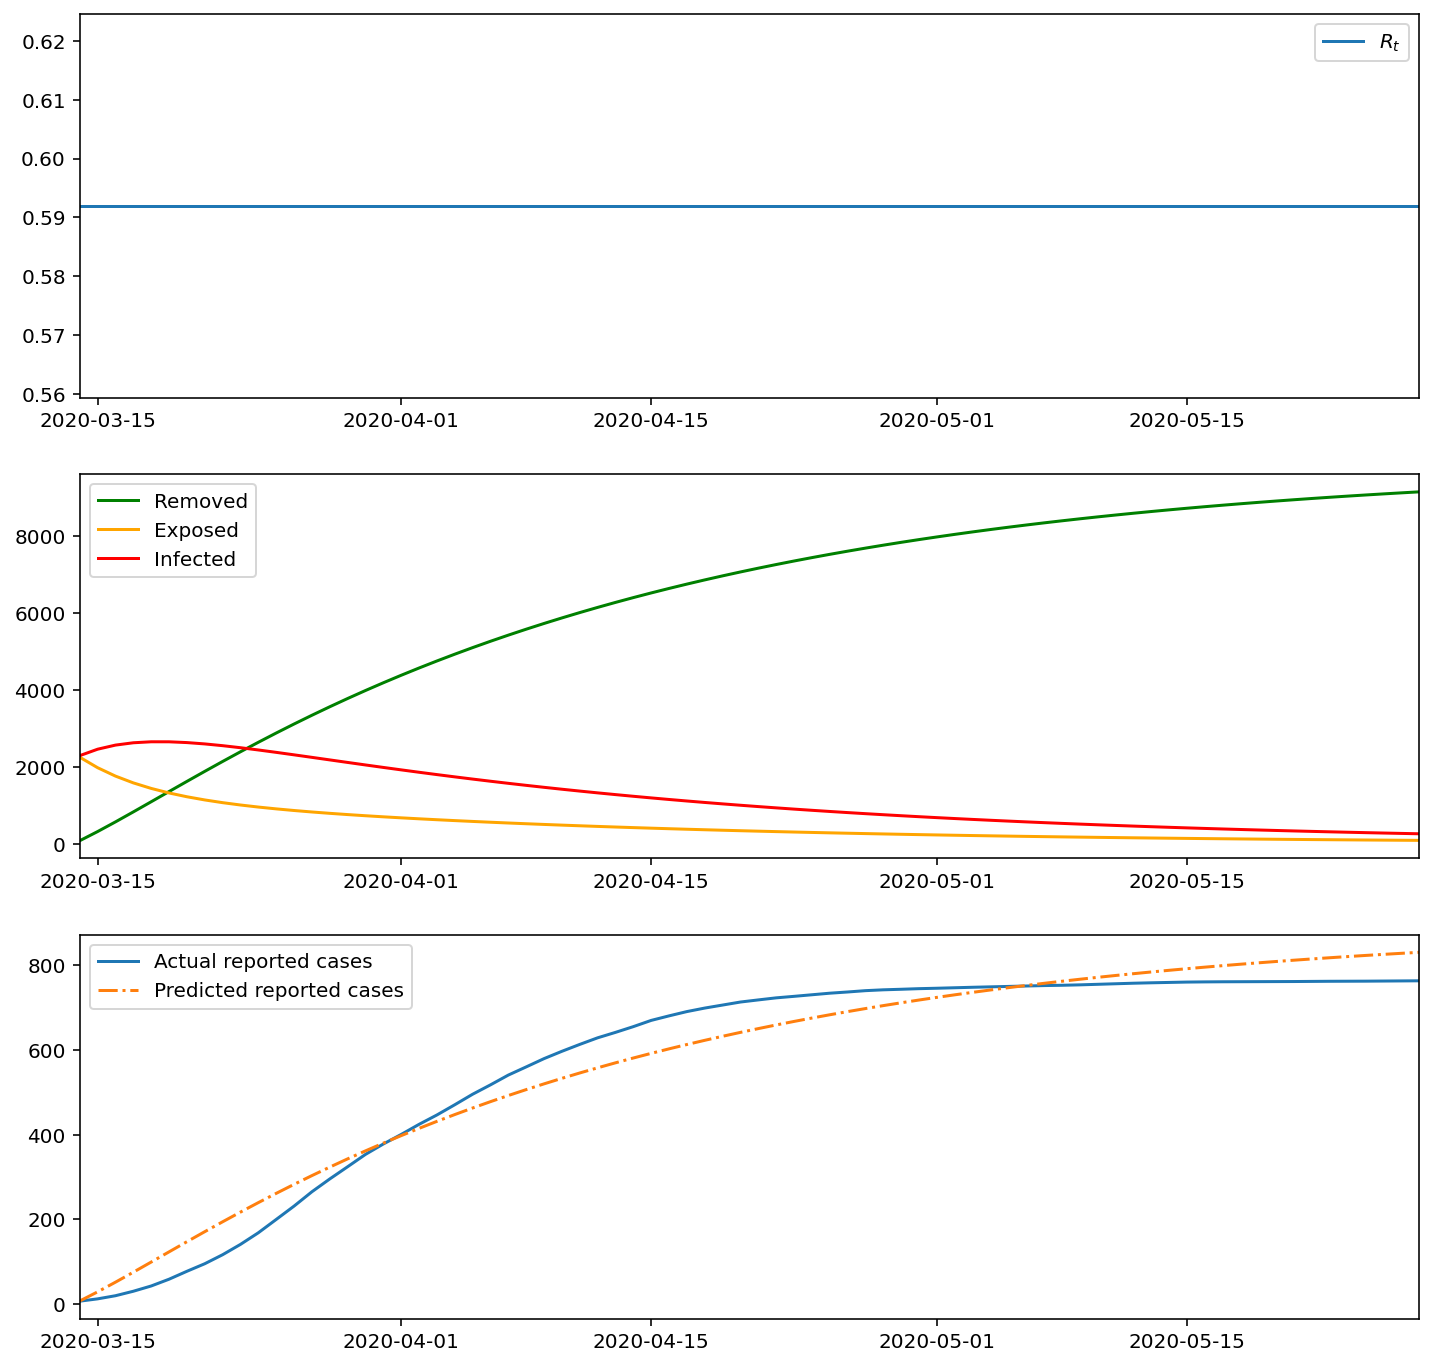

In [155]:
# Define model
model_baseline = ConstantBetaSEIRModel(N=ANDORRA_POPULATION)
# fit the model
ll, _success = model_baseline.fit(reported_cases[train_start:train_end])
print(ll, _success)
# show model fit to training data
model_baseline.plots(reported_cases[train_start:train_end])
model_baseline

##### Predict

In [156]:
assert(SEIRModel.from_dict(model_baseline.to_dict()).to_dict() == model_baseline.to_dict())
model_baseline = SEIRModel.from_dict(model_baseline.to_dict())

In [157]:
# To run a simulation for the future (test data), starting where the training data left off:
test_days = len(reported_cases[train_end:test_end][1:])
training_days = len(reported_cases[train_start:train_end])
print('%s training days; %s test days' % (training_days, test_days))

76 training days; 64 test days


deterministic

64-day MAPE = 0.0243


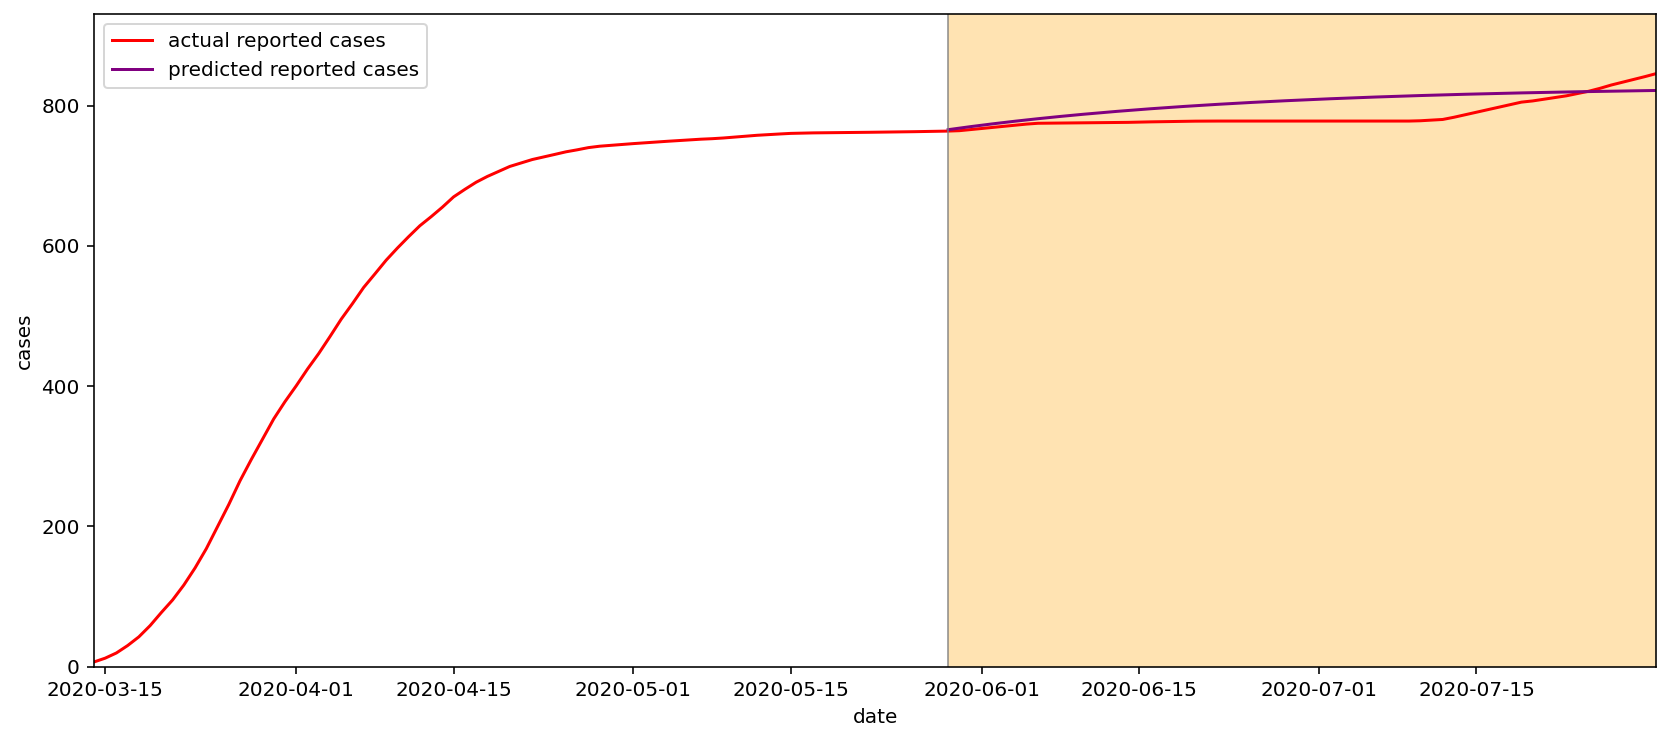

In [158]:
# start where the estimation left off, 
S, E, I, R, C = model_baseline.simulate_deterministic(
    test_days+1, 
    t_start=training_days-1, 
    C0=reported_cases[train_end]
)
predicted_reported_cases = C[1:]

mape = evaluate_mape(
    predicted_reported_cases,
    reported_cases[train_end:test_end][1:])
print('%s-day MAPE = %0.4f' % (test_days, mape))

ax = plot_cases_predicted_vs_actual(
    reported_cases[train_start:test_end],
    predicted_reported_cases, 
    reported_cases[train_start:test_end].index)

stochastic

64-day MAPE = 0.0242


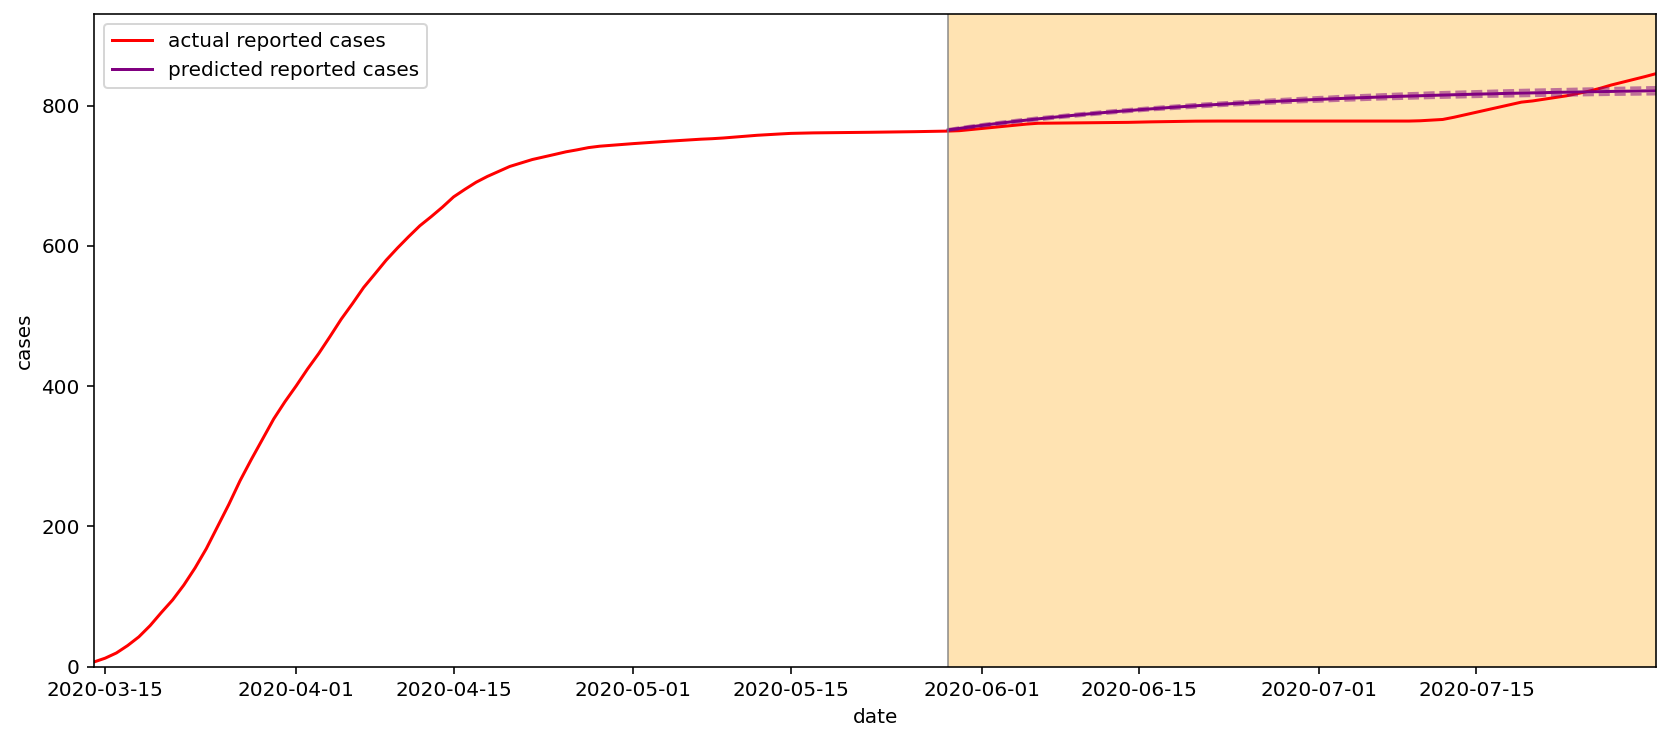

In [159]:
# stochastic prediction:
sim_t_start = training_days - 1  # start where the estimation left off
Sruns, Eruns, Iruns, Rruns, Cruns = run_simulations(
    model_baseline, test_days, sim_t_start,
    C0=reported_cases[train_end],
    runs=1000)

pred_cases_runs = [list(C)[1:] for C in Cruns]

pred_cases_means, pred_cases_lower95CIs, pred_cases_upper95CIs = get_mean_CIs(pred_cases_runs)

mape = evaluate_mape(pred_cases_means,
                     reported_cases[train_end:test_end][1:])
print('%s-day MAPE = %0.4f' % (test_days, mape))

ax = plot_cases_predicted_vs_actual(
    reported_cases[train_start:test_end],
    pred_cases_runs, 
    reported_cases[train_start:test_end].index,
    CI95=True,
)

#### Simulations Plots

In [160]:
S, E, I, R, C = model_baseline.simulate_stochastic(56)

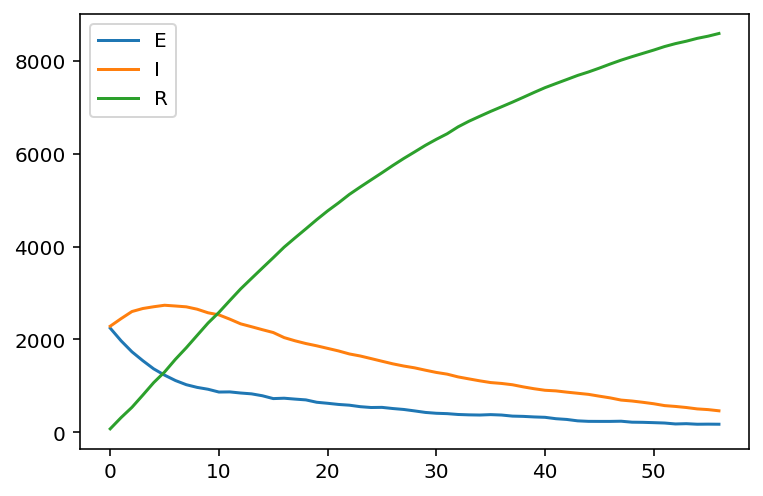

In [161]:
fig, ax = plt.subplots(1)
# ax.plot(S, label='S')
ax.plot(E, label='E')
ax.plot(I, label='I')
ax.plot(R, label='R')
ax.legend()
plt.show()

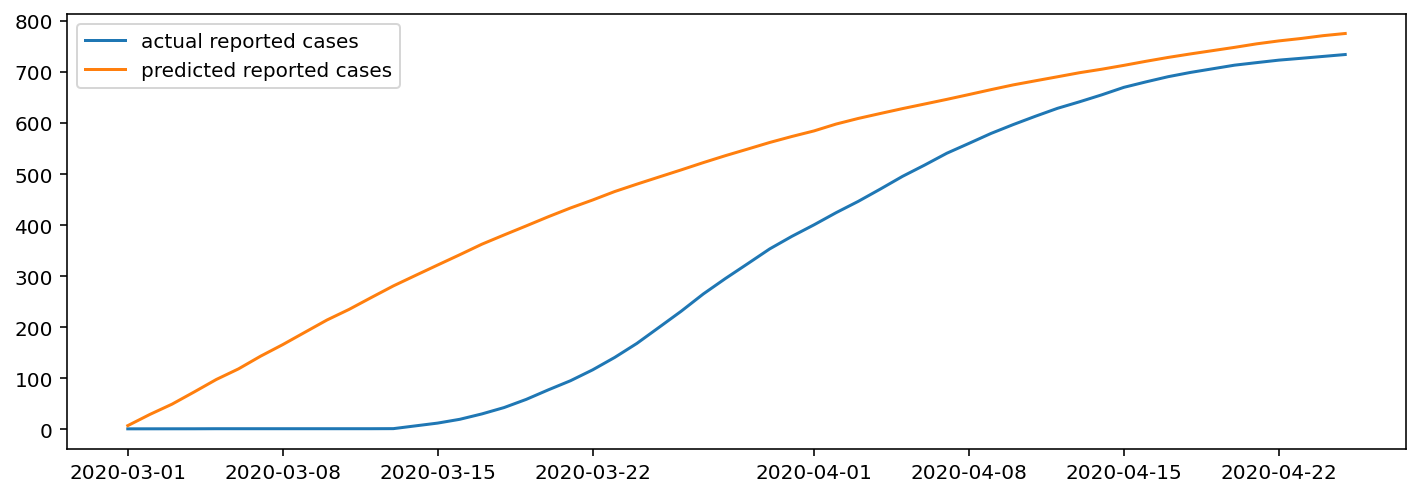

In [162]:
predicted_reported_cases = [c for c in C[:-1]]
fig, ax = plt.subplots(1, figsize=(12,4))
ax.plot(study_dates_idx[:56], list(reported_cases[:56]),
        label='actual reported cases')
ax.plot(study_dates_idx[:56], predicted_reported_cases[:56], label='predicted reported cases')
ax.legend()
plt.show()

In [163]:
runs = 1000
Sruns, Eruns, Iruns, Rruns, Cruns = run_simulations(
    model_baseline, 56-1, 0, runs=runs)

1000


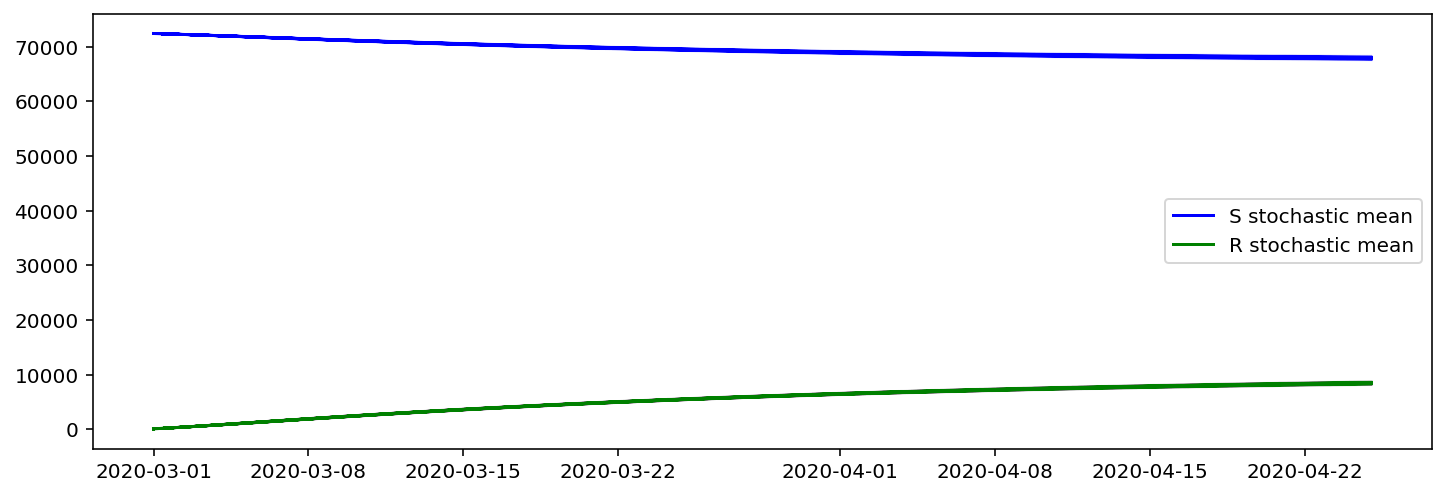

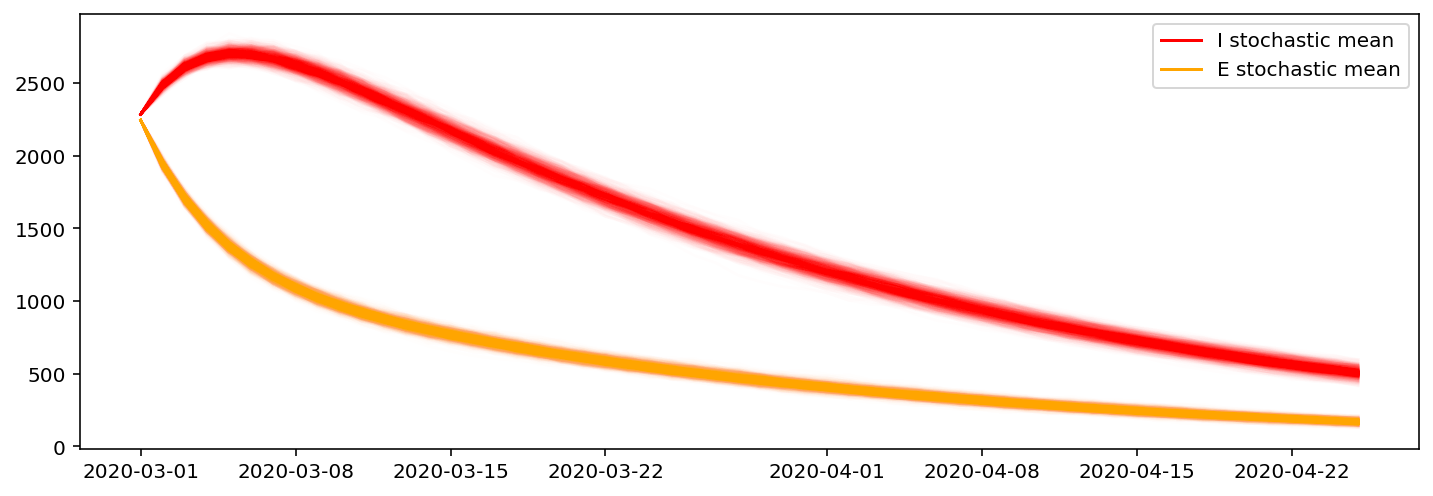

In [164]:
fig, ax = plt.subplots(1, figsize=(12,4))
for S in Sruns:
    ax.plot(study_dates_idx[:56], S, color='blue', alpha=runs/170000)
# plot stochastic mean
Smean = np.mean(np.array(Sruns), axis=0)
ax.plot(study_dates_idx[:56], Smean, color='blue', alpha=1, label='S stochastic mean')
for R in Rruns:
    ax.plot(study_dates_idx[:56], R, color='green', alpha=runs/170000)
# plot stochastic mean
Rmean = np.mean(np.array(Rruns), axis=0)
ax.plot(study_dates_idx[:56], Rmean, color='green', alpha=1, label='R stochastic mean')
_ = ax.legend()

fig, ax = plt.subplots(1, figsize=(12,4))
print(len(Iruns))
for I in Iruns:
    ax.plot(study_dates_idx[:56], I, color='red', alpha=runs/170000)
# plot stochastic mean
Imean = np.mean(np.array(Iruns), axis=0)
ax.plot(study_dates_idx[:56], Imean, color='red', alpha=1, label='I stochastic mean')
for E in Eruns:
    ax.plot(study_dates_idx[:56], E, color='orange', alpha=runs/170000)
# plot stochastic mean
Emean = np.mean(np.array(Eruns), axis=0)
ax.plot(study_dates_idx[:56], Emean, color='orange', alpha=1, label='E stochastic mean')
_ = ax.legend()

## Spline: Show to understand

Smooth functions are preffered for MLE which uses integration over derivatives...

beta knots:


[0.0, 0.8, 0.1, 0.3, 0.3, 0.0]

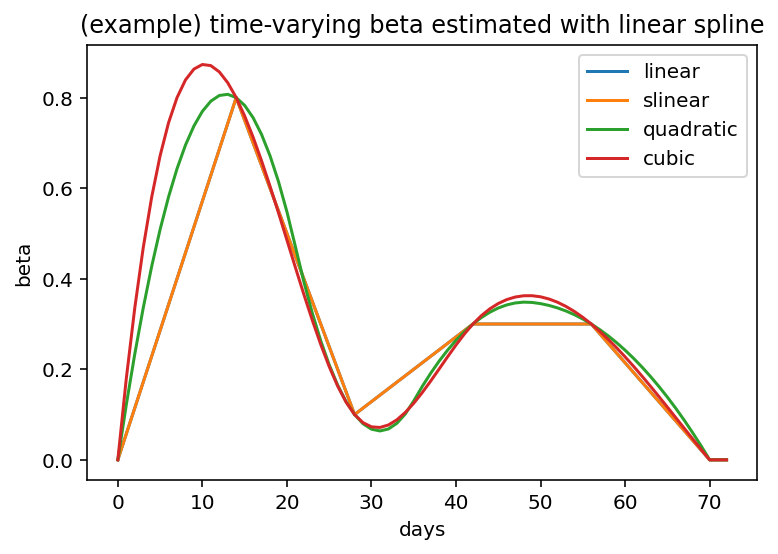

In [165]:
from random import choice
choices = [i/10 for i in range(10)]
t = 73
knots_space = 14
n_knots = int(t/knots_space) + 1
beta_knots = [choice(choices) for n in range(n_knots)]

spline_beta_model_example_linear = SplineSEIRModel(N=ANDORRA_POPULATION, 
                                                   knots_space=knots_space,
                                                   interp_kind='linear')
spline_beta_model_example_slinear = SplineSEIRModel(N=ANDORRA_POPULATION, 
                                                    knots_space=knots_space, 
                                                    interp_kind='slinear')
spline_beta_model_example_quadratic = SplineSEIRModel(N=ANDORRA_POPULATION, 
                                                    knots_space=knots_space,
                                                    interp_kind='quadratic')
spline_beta_model_example_cubic = SplineSEIRModel(N=ANDORRA_POPULATION, 
                                                    knots_space=knots_space,
                                                    interp_kind='cubic')

f_beta_linear = spline_beta_model_example_linear._get_f_beta(beta_param=beta_knots)
f_beta_slinear = spline_beta_model_example_slinear._get_f_beta(beta_param=beta_knots)
f_beta_quadratic = spline_beta_model_example_quadratic._get_f_beta(beta_param=beta_knots)
f_beta_cubic = spline_beta_model_example_cubic._get_f_beta(beta_param=beta_knots)
fig,ax = plt.subplots(1)
tseries = list(range(t))
ax.plot(tseries, [f_beta_linear(t) for t in tseries], label='linear')
ax.plot(tseries, [f_beta_slinear(t) for t in tseries], label='slinear')
ax.plot(tseries, [f_beta_quadratic(t) for t in tseries], label='quadratic')
ax.plot(tseries, [f_beta_cubic(t) for t in tseries], label='cubic')
ax.set_ylabel('beta')
ax.set_xlabel('days')
ax.legend()
_ = ax.set_title('(example) time-varying beta estimated with linear spline')
print('beta knots:')
beta_knots

### Spline N
Metrics are approximated by time series computed by a spline function with knots spaced appropriately.

The models are first trained with the spline approximated time series data. They are finally fit with the true metrics.

#### NOTE:
Using too large a spacing between knots (28 days) did not perform well with testing because the spline knot skipped important moments.

See metric vs spline approximation of metric plots below.


Comparing not just performance, but also estimation time and ability.

With more variables, each estimation has trouble moving from the starting parameter values.

Benefits of using Spline approximation of metrics found through way too many hours of testing:
- Faster estimation
- Variables move more freely with the spline approximation.
- More often the optimization step ends in 'success'


In [485]:
def get_spline_f(y, knots_space, interp_kind):
    t_knots = [i for i in range(0, len(y), knots_space)]
    y_knots = [list(y)[t] for t in t_knots]
    return interp1d(t_knots, y_knots,
               kind=interp_kind, 
               bounds_error=False,
               fill_value=(y[0], y[-1]))

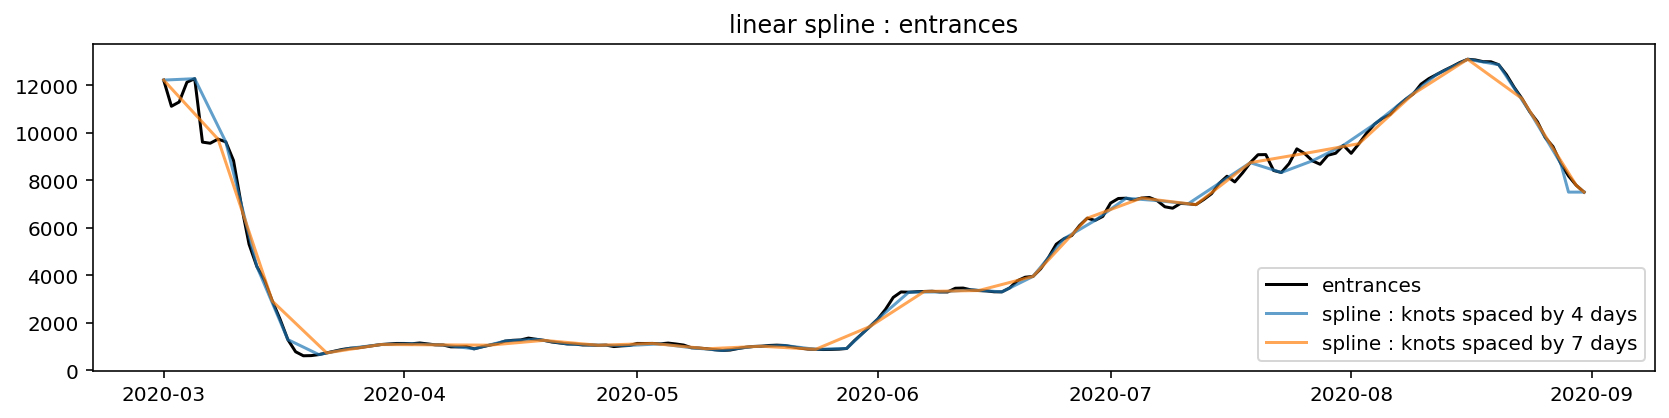

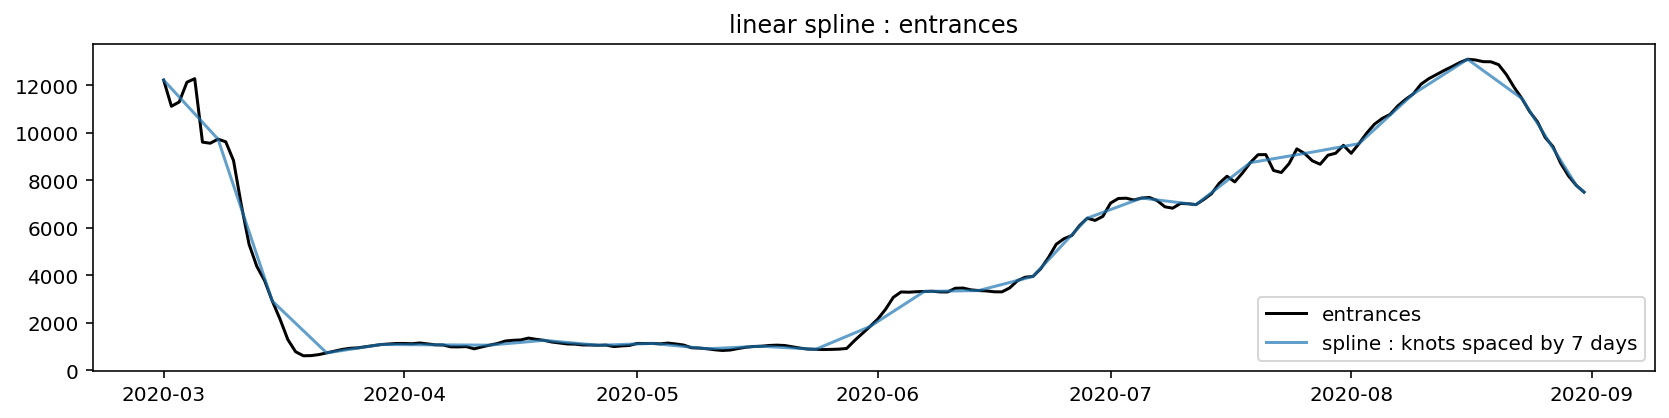

In [486]:
interp_kind='slinear'

fig,ax = plt.subplots(1, figsize=(14,3))
plot_idx = study_dates_idx
ax.plot(plot_idx, entrances[plot_idx], color='black', label='entrances')

for ks in [4, 7]:
    spline_entrances=get_spline_f(entrances[plot_idx].values, ks, interp_kind)
    y = [spline_entrances(t) for t in range(len(plot_idx))]
    ax.plot(plot_idx, y, alpha=0.7, label='spline : knots spaced by %s days' % ks)
ax.legend()
_ = ax.set_title('linear spline : entrances')
plt.show()

ks = 7
fig,ax = plt.subplots(1, figsize=(14,3))
ax.plot(plot_idx, entrances[plot_idx], color='black', label='entrances')
spline_entrances=get_spline_f(entrances[plot_idx].values, ks, interp_kind)
y = [spline_entrances(t) for t in range(len(plot_idx))]
ax.plot(plot_idx, y, alpha=0.7, label='spline : knots spaced by %s days' % ks)
ax.legend()
_ = ax.set_title('linear spline : entrances')
plt.show()

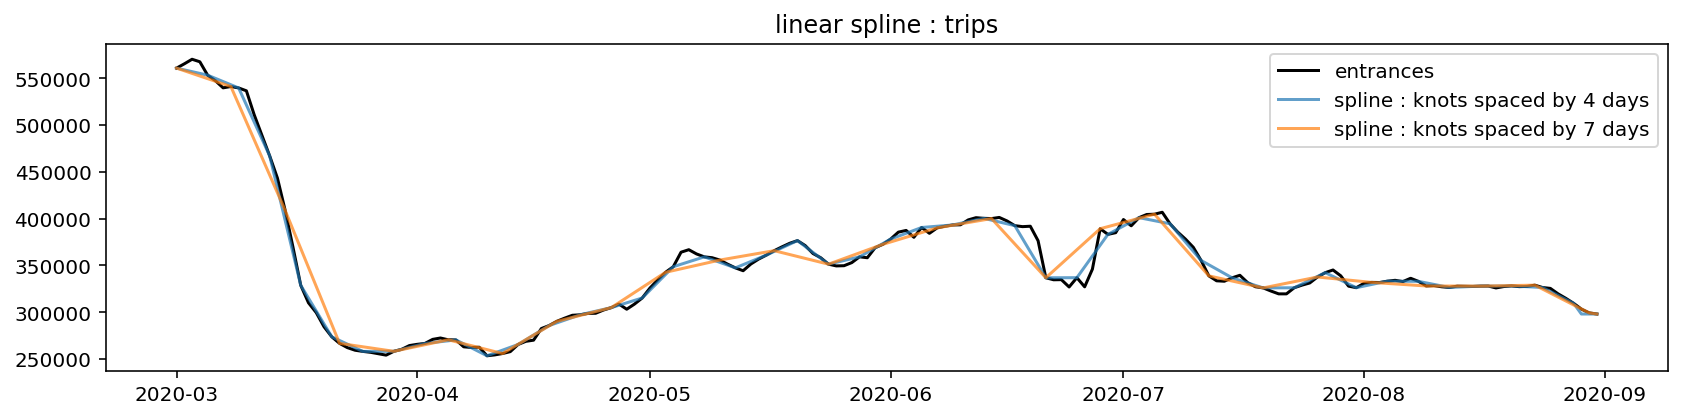

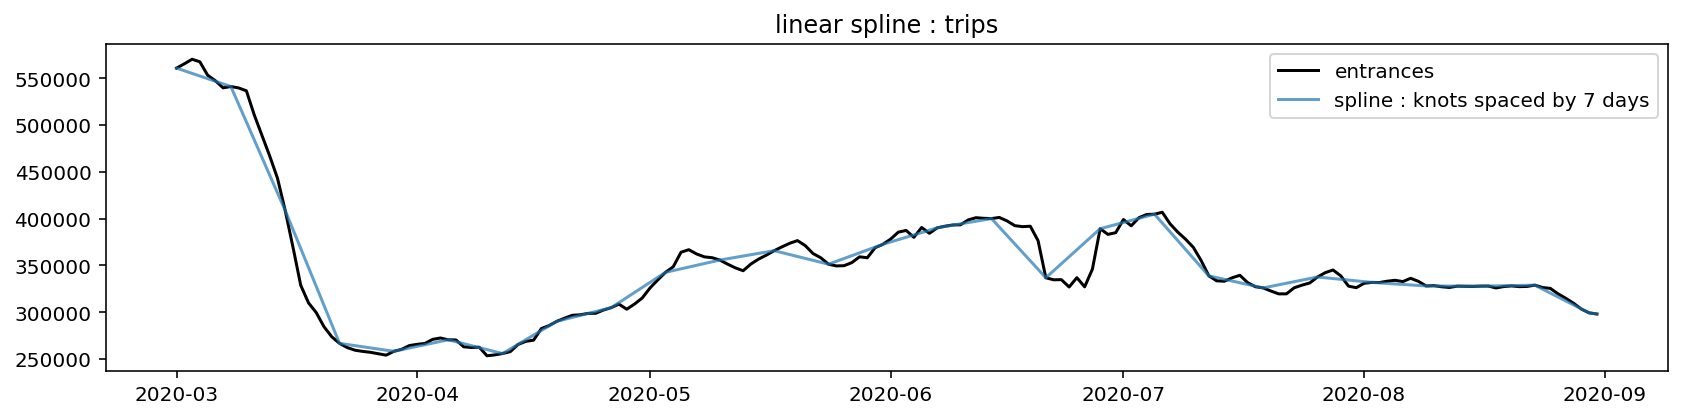

In [487]:
interp_kind='slinear'

fig,ax = plt.subplots(1, figsize=(14,3))
plot_idx = study_dates_idx
ax.plot(plot_idx, total_trips[plot_idx], color='black', label='entrances')

for ks in [4, 7]:
    spline_f=get_spline_f(total_trips[plot_idx].values, ks, interp_kind)
    y = [spline_f(t) for t in range(len(plot_idx))]
    ax.plot(plot_idx, y, alpha=0.7, label='spline : knots spaced by %s days' % ks)
ax.legend()
_ = ax.set_title('linear spline : trips')
plt.show()

ks= 7
fig,ax = plt.subplots(1, figsize=(14,3))
ax.plot(plot_idx, total_trips[plot_idx], color='black', label='entrances')
spline_f=get_spline_f(total_trips[plot_idx].values, ks, interp_kind)
y = [spline_f(t) for t in range(len(plot_idx))]
ax.plot(plot_idx, y, alpha=0.7, label='spline : knots spaced by %s days' % ks)
ax.legend()
_ = ax.set_title('linear spline : trips')
plt.show()

## Train with grid search

In [233]:
MAX_R_0 = 6 # discard models with estimated Rt values beyond max

from itertools import product

# grid search over initial E0,I0,beta parameters

def get_best_fit_gs(model, gridsearch_num=2, train_dates=train_dates_5_31, debug=True):
    """
    beta(t) = b0 + b1 x [mobility(t)^(b2)] + b3 x [entrances(t)^b4]
    Parameters to estimate:
    with gridsearch:
        E0, I0, 
        b0, b1, b2, b3, b4
    without gridsearch:
        gamma
    """
    E0_bounds = model.default_opt_bounds_dict['E0']
    I0_bounds = model.default_opt_bounds_dict['I0']
    b_bounds = model.default_opt_bounds_dict['b']
    # only mobility + entrances data has the 'e' parameter
    train_start = train_dates[0]
    train_end = train_dates[1]
    training_data = reported_cases[train_start:train_end]
    training_days = len(training_data)
    if debug: 
        print('%s training days: %s - %s' % (len(training_data), train_start, train_end))
    gridsearch_E0 = np.linspace(*E0_bounds, num=gridsearch_num+1, endpoint=False)[1:]
    gridsearch_I0 = np.linspace(*I0_bounds, num=gridsearch_num+1, endpoint=False)[1:]
    gridsearch_bs = np.linspace(*b_bounds, num=gridsearch_num+1, endpoint=False)[1:]
    # combinatorial grid search
    gridsearch_beta_param = [list(bs) for bs in product(gridsearch_bs, repeat=model.n_beta_param)]
    # handle case where this is actually the constant beta model
    if type(model).__name__ == 'ConstantBetaSEIRModel':
        beta_bounds = model.default_opt_bounds_dict['beta']
        gridsearch_beta_param = np.linspace(*beta_bounds, num=gridsearch_num+1, endpoint=False)[1:]
    if debug:
        print('gridsearch_E0', gridsearch_E0)
        print('gridsearch_I0', gridsearch_I0)
        print('gridsearch_betas', gridsearch_beta_param)
    best_model = None
    best_ll = np.inf
    for E0i, E0 in enumerate(gridsearch_E0): 
        for I0i, I0 in enumerate(gridsearch_I0): 
            for bi, betas in enumerate(gridsearch_beta_param): 
                m = model.copy()
                m.E[0] = E0
                m.I[0] = I0
                m.beta_param = betas
                if debug:
                    start_t = datetime.now()
                    print('\n%s'%start_t)
                    print('grid search @ step %s/%s %s/%s %s/%s' % (
                        1+E0i, len(gridsearch_E0), 1+I0i, len(gridsearch_I0),
                        1+bi, len(gridsearch_beta_param)))
                    print('training new model:')
                    print(m)
                ll, _success = m.fit(training_data)
                if debug:
                    print(ll, _success)
                    print(m)
                    end_t = datetime.now()
                    print('time %s' % (end_t - start_t))
                # discard fits that come up against the bounds
                # or where E0,I0 to far apart
                # could also consider using b bounds
                # any(b in opt_bounds_dict['b'] for b in list(m.beta_param))
                if (round(m.E[0]) in E0_bounds) \
                or (round(m.I[0]) in I0_bounds) \
                or (abs(m.E[0] - m.I[0]) > E0_I0_MAX_DIFF):
                    if debug:
                        print('discarding fit that came up against bounds')
                    continue
                if ((m._get_f_beta()(0) / m.gamma) > MAX_R_0):
                    if debug:
                        print('discarding fit with R_0 > %s' % MAX_R_0)
                    continue
                if (ll < best_ll):
                    if debug:
                        print('****** new best fit LL value: %s ******' % ll)
                        m.plots(training_data)
                        plt.show()
                    best_ll = ll
                    best_model = m
    if debug:
        print('ll:', best_ll)
        print('model:')
        print(best_model)
        best_model.plots(training_data)
        plt.show()
    return best_model, best_ll
    

Test over multiple weeks.

For each training / testing period, we create a table to show results for the models
- baseline (constant $R_t$) model
- trips data model
- trips & entrances data model

In [308]:
forecasting_weeks = 10
default_train_test_dict = {
    'forecasting weeks': list(range(1,forecasting_weeks+1)),
    'baseline model': [np.nan]*forecasting_weeks,
    'trips data model': [np.nan]*forecasting_weeks,
    'trips & entrances data model': [np.nan]*forecasting_weeks,
}
print('Training period: %s\nMAPE' % ('fill in'))
pd.DataFrame(data=default_train_test_dict).set_index('forecasting weeks')

Training period: fill in
MAPE


baseline model  trips data model  \
forecasting weeks                                     
1                             NaN               NaN   
2                             NaN               NaN   
3                             NaN               NaN   
4                             NaN               NaN   
5                             NaN               NaN   
6                             NaN               NaN   
7                             NaN               NaN   
8                             NaN               NaN   
9                             NaN               NaN   
10                            NaN               NaN   

                   trips & entrances data model  
forecasting weeks                                
1                                           NaN  
2                                           NaN  
3                                           NaN  
4                                           NaN  
5                                           NaN  
6                                           NaN  
7                                           NaN  
8                                           NaN  
9                                           NaN  
10                                          NaN

In [309]:
def get_forecast_results(model, train_start, train_end, plot_end='2020-07-31', weeks=10):
    print('training period: %s - %s' % (train_start, train_end))
    test_days = 7*weeks
    training_days = len(reported_cases[train_start:train_end])
    print('%s training days; %s test days' % (training_days, test_days))
    # simulate forecast
    print('simulated (deterministic) forecast')
    # start where the estimation left off, 
    S, E, I, R, C = model.simulate_deterministic(
        test_days+1, 
        t_start=training_days-1, 
        C0=reported_cases[train_end]
    )
    predicted_reported_cases = C[1:]
    mapes = []

    # estimate MAPE values for each week
    forecasting_weeks = list(range(1,weeks+1))
    for w in forecasting_weeks:
        forecast_days = 7*w
        mape = evaluate_mape(
            predicted_reported_cases[:forecast_days],
            reported_cases[train_end:][:test_days+1][1:forecast_days+1])
        print('%s-week (%s-day) MAPE = %0.4f' % (w, forecast_days, mape))
        mapes += [mape]

    plot_forecast_days = min(test_days, len(reported_cases[train_end:plot_end]))
    # or to show all of it
    # plot_forecast days = test_days
    ax = plot_cases_predicted_vs_actual(
        reported_cases[train_start:][:training_days+plot_forecast_days],
        predicted_reported_cases[:plot_forecast_days], 
        reported_cases[train_start:][:training_days+plot_forecast_days].index
    )
    plt.show()
    return mapes

Estimates with spline estimation of mobility data and reporting lag of 7.

Text(0.5, 1.0, 'trips(t-7) : linear spline')

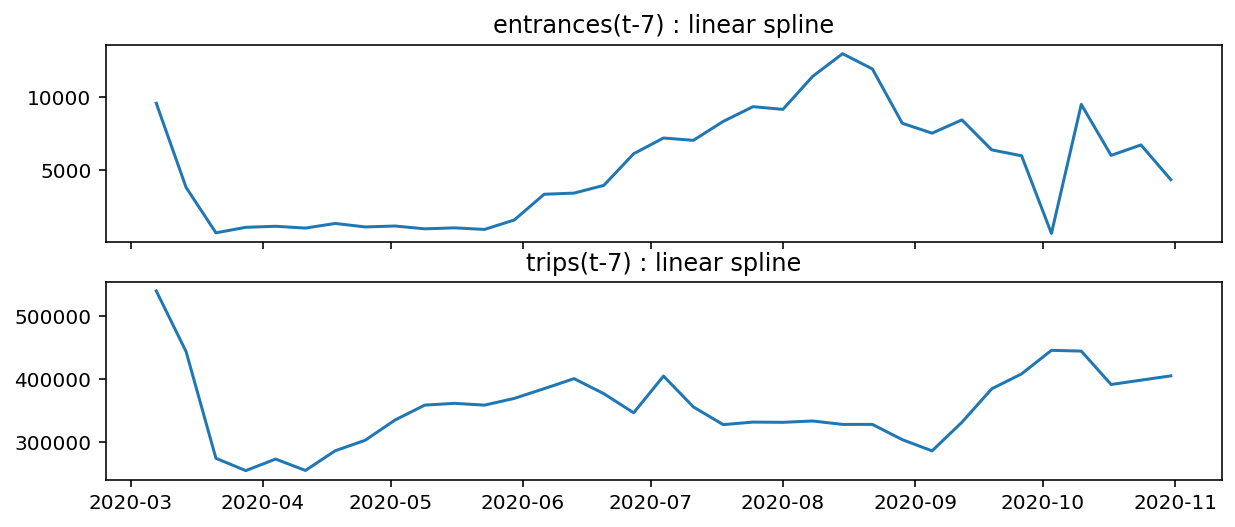

In [488]:
reporting_lag = 7
fig, ax = plt.subplots(2, sharex=True, figsize=(10,4))
plot_idx = entrances[(14-1-reporting_lag):].index
data_len=len(plot_idx)

f_spline_entrances_lag7=get_spline_f(
    entrances[plot_idx].values, 7, 'slinear')
spline_entrances_lag7 = [f_spline_entrances_lag7(t) for t in range(data_len)]
ax[0].plot(plot_idx,spline_entrances_lag7)

ax[0].set_title('entrances(t-7) : linear spline')
f_spline_trips_lag7=get_spline_f(
    total_trips[plot_idx].values, 7, 'slinear')
spline_trips_lag7 = [f_spline_trips_lag7(t) for t in range(data_len)]
ax[1].plot(plot_idx, spline_trips_lag7)
ax[1].set_title('trips(t-7) : linear spline')

Show train/test for:

- Baseline model
- Model trips_[train_dates]: just trips mobility data
- Model trips_enrances_[train_dates]: trips & entrances data

Where:

Assume reporting lag = 7

Training initially uses Telecoms data metrics (trips, entrances) that are approximated by a linear spline.
This is to make the data smoother and model estimation more computationally feasible.

Trained models are then fit again to the true telecoms data metrics (without the spline).


Train/test for multiple training periods -- for robustness.

The grid search processes below are commented out because they take hours to run. Instead, the parameters for their resulting fit models are printed for quick rereading.

### Training period: 2020-03-14 - 2020-05-31


In [452]:
train_dates = train_dates_5_31

In [312]:
train_test_dict_5_31 = copy.deepcopy(default_train_test_dict)
pd.DataFrame(train_test_dict_5_31).set_index('forecasting weeks')

baseline model  trips data model  \
forecasting weeks                                     
1                             NaN               NaN   
2                             NaN               NaN   
3                             NaN               NaN   
4                             NaN               NaN   
5                             NaN               NaN   
6                             NaN               NaN   
7                             NaN               NaN   
8                             NaN               NaN   
9                             NaN               NaN   
10                            NaN               NaN   

                   trips & entrances data model  
forecasting weeks                                
1                                           NaN  
2                                           NaN  
3                                           NaN  
4                                           NaN  
5                                           NaN  
6                                           NaN  
7                                           NaN  
8                                           NaN  
9                                           NaN  
10                                          NaN

79 training days: 2020-03-14 - 2020-05-31
gridsearch_E0 [1030. 2020. 3010.]
gridsearch_I0 [1030. 2020. 3010.]
gridsearch_betas [0.1875 0.325  0.4625]

2021-08-13 12:04:05.785637
grid search @ step 1/3 1/3 1/3
training new model:
SEIR model (constant beta)
S0 = None
E0 = 1030.0
I0 = 1030.0
R0 = None
σ = 5.2, γ = None
beta parameter: 0.1875

606.8043742340013 True
SEIR model (constant beta)
S0 = 72332.58721256303
E0 = 2284.515294160627
I0 = 2305.8974932763545
R0 = 77.0
σ = 5.2, γ = 0.1
beta parameter: [0.0575342]

time 0:00:00.543524
****** new best fit LL value: 606.8043742340013 ******


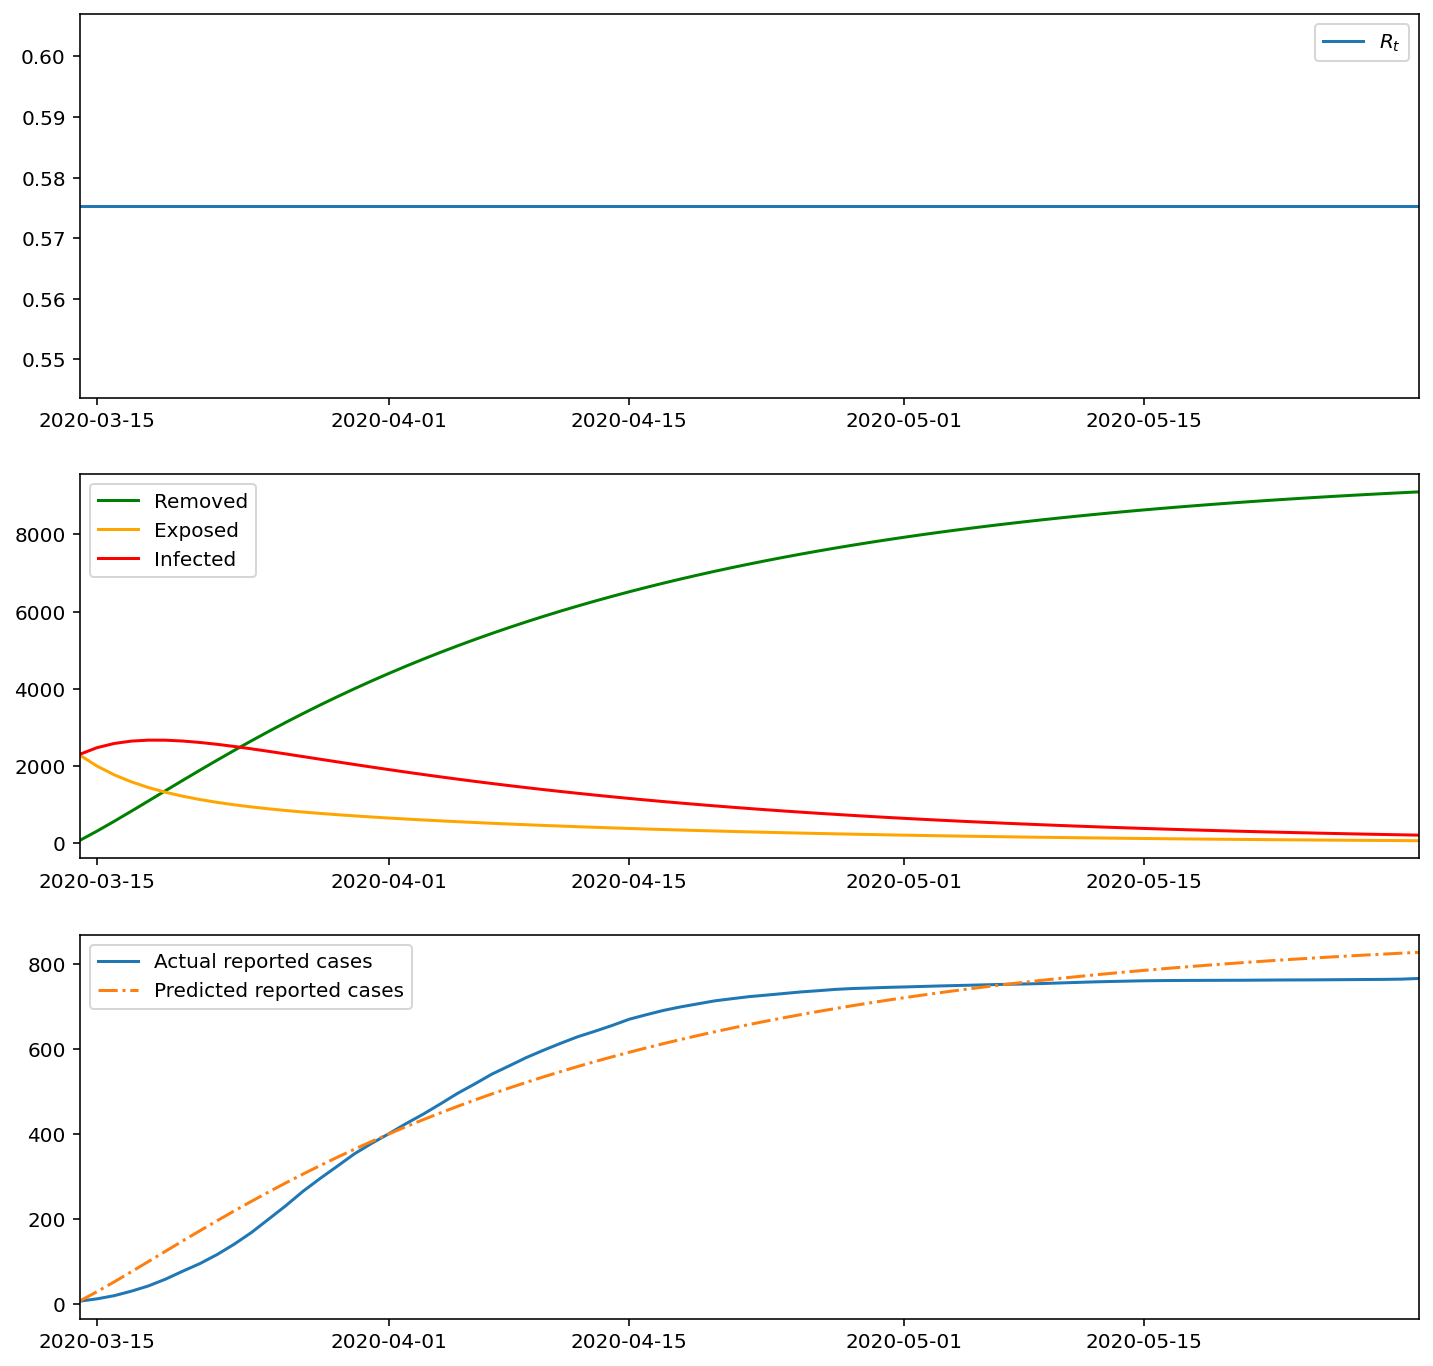


2021-08-13 12:04:07.009442
grid search @ step 1/3 1/3 2/3
training new model:
SEIR model (constant beta)
S0 = None
E0 = 1030.0
I0 = 1030.0
R0 = None
σ = 5.2, γ = None
beta parameter: 0.325

612.8488802440253 True
SEIR model (constant beta)
S0 = 72363.44951915675
E0 = 2199.2617604635843
I0 = 2360.288720379654
R0 = 77.0
σ = 5.2, γ = 0.1
beta parameter: [0.0580304]

time 0:00:00.543422

2021-08-13 12:04:07.553066
grid search @ step 1/3 1/3 3/3
training new model:
SEIR model (constant beta)
S0 = None
E0 = 1030.0
I0 = 1030.0
R0 = None
σ = 5.2, γ = None
beta parameter: 0.4625

619.2800801179416 True
SEIR model (constant beta)
S0 = 72396.11563232307
E0 = 2109.4731763508653
I0 = 2417.4111913260667
R0 = 77.0
σ = 5.2, γ = 0.1
beta parameter: [0.05855459]

time 0:00:00.489275

2021-08-13 12:04:08.042440
grid search @ step 1/3 2/3 1/3
training new model:
SEIR model (constant beta)
S0 = None
E0 = 1030.0
I0 = 2020.0
R0 = None
σ = 5.2, γ = None
beta parameter: 0.1875

716.3261292162814 True
SEIR mod

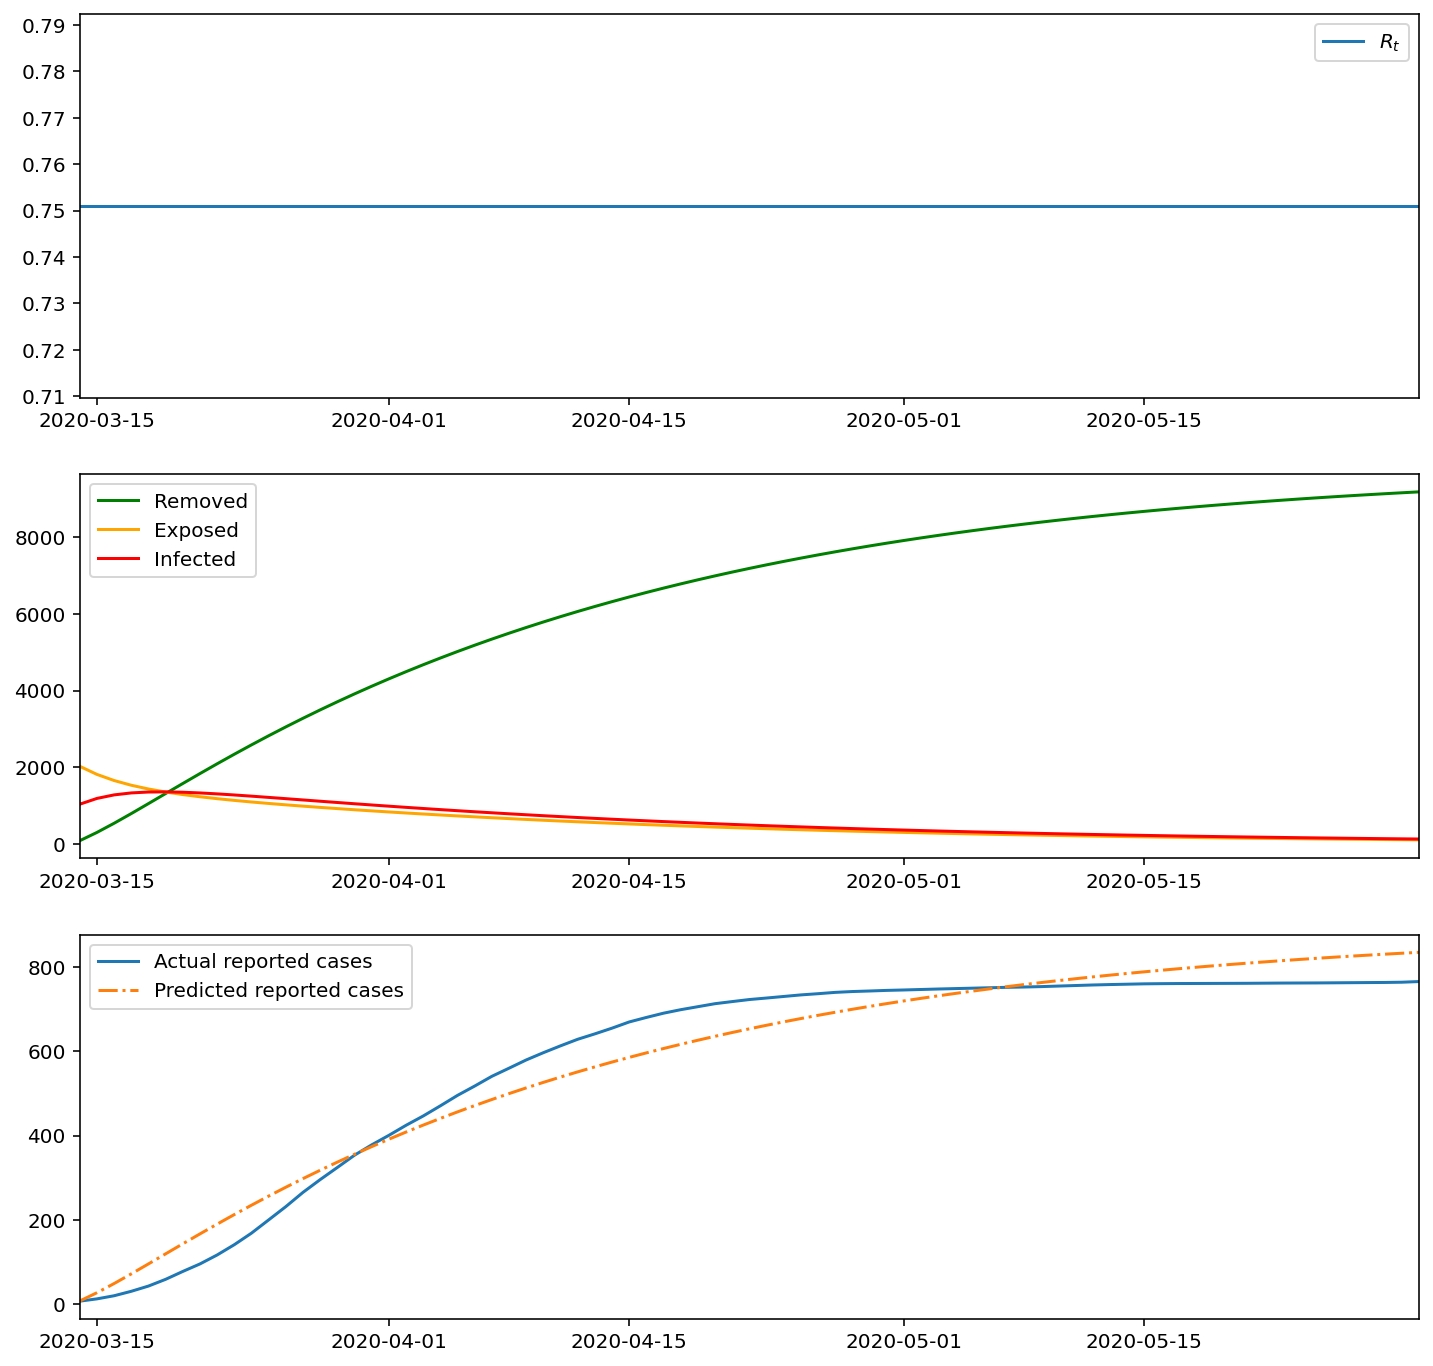


2021-08-13 12:04:10.966842
grid search @ step 2/3 1/3 2/3
training new model:
SEIR model (constant beta)
S0 = None
E0 = 2020.0
I0 = 1030.0
R0 = None
σ = 5.2, γ = None
beta parameter: 0.325

569.1837277366924 True
SEIR model (constant beta)
S0 = 72198.80122340735
E0 = 2800.317281641818
I0 = 1923.8814949508244
R0 = 77.0
σ = 5.2, γ = 0.1
beta parameter: [0.05552055]

time 0:00:00.507232
****** new best fit LL value: 569.1837277366924 ******


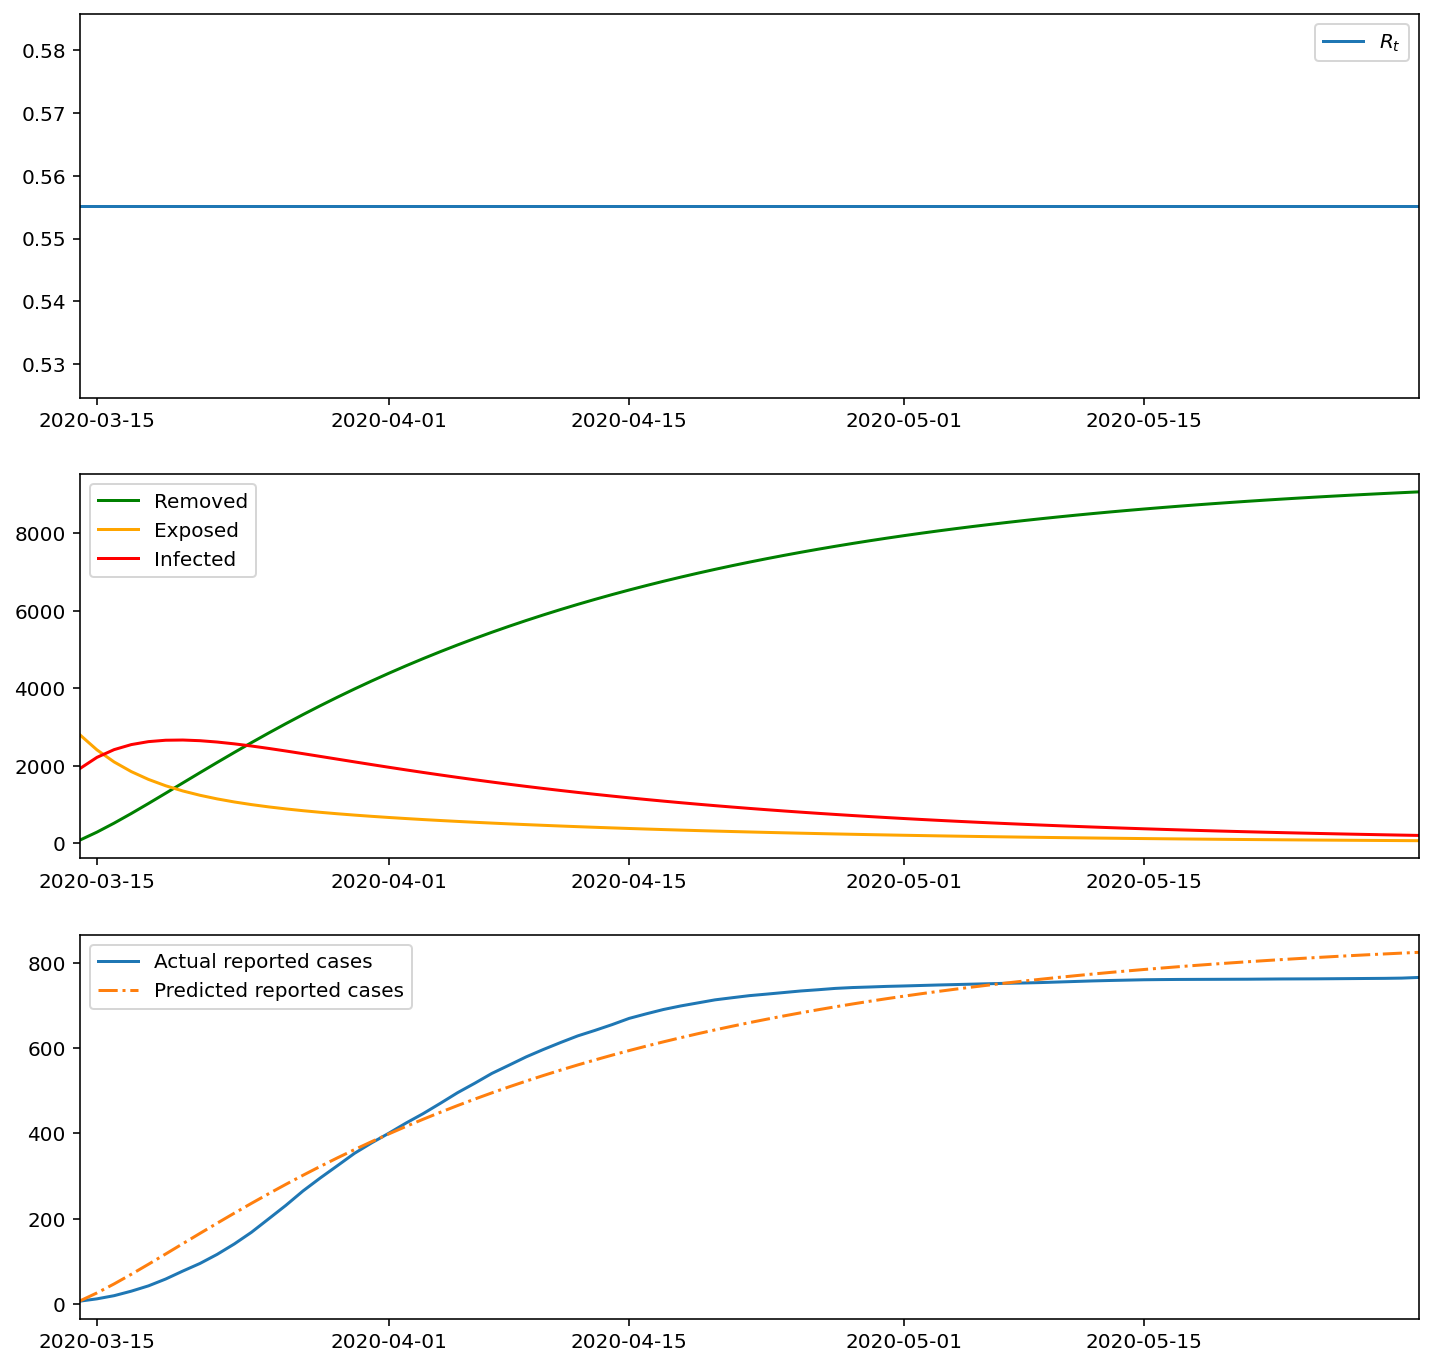


2021-08-13 12:04:12.199254
grid search @ step 2/3 1/3 3/3
training new model:
SEIR model (constant beta)
S0 = None
E0 = 2020.0
I0 = 1030.0
R0 = None
σ = 5.2, γ = None
beta parameter: 0.4625

573.2177105938571 True
SEIR model (constant beta)
S0 = 72222.01723374867
E0 = 2739.805024338252
I0 = 1961.177741913086
R0 = 77.0
σ = 5.2, γ = 0.1
beta parameter: [0.05589673]

time 0:00:00.524146

2021-08-13 12:04:12.723505
grid search @ step 2/3 2/3 1/3
training new model:
SEIR model (constant beta)
S0 = None
E0 = 2020.0
I0 = 2020.0
R0 = None
σ = 5.2, γ = None
beta parameter: 0.1875

608.7028156365085 True
SEIR model (constant beta)
S0 = 72358.01763824555
E0 = 2250.394517376677
I0 = 2314.58784437777
R0 = 77.0
σ = 5.2, γ = 0.1
beta parameter: [0.05797788]

time 0:00:00.348043

2021-08-13 12:04:13.071694
grid search @ step 2/3 2/3 2/3
training new model:
SEIR model (constant beta)
S0 = None
E0 = 2020.0
I0 = 2020.0
R0 = None
σ = 5.2, γ = None
beta parameter: 0.325

607.7282110424982 True
SEIR model 

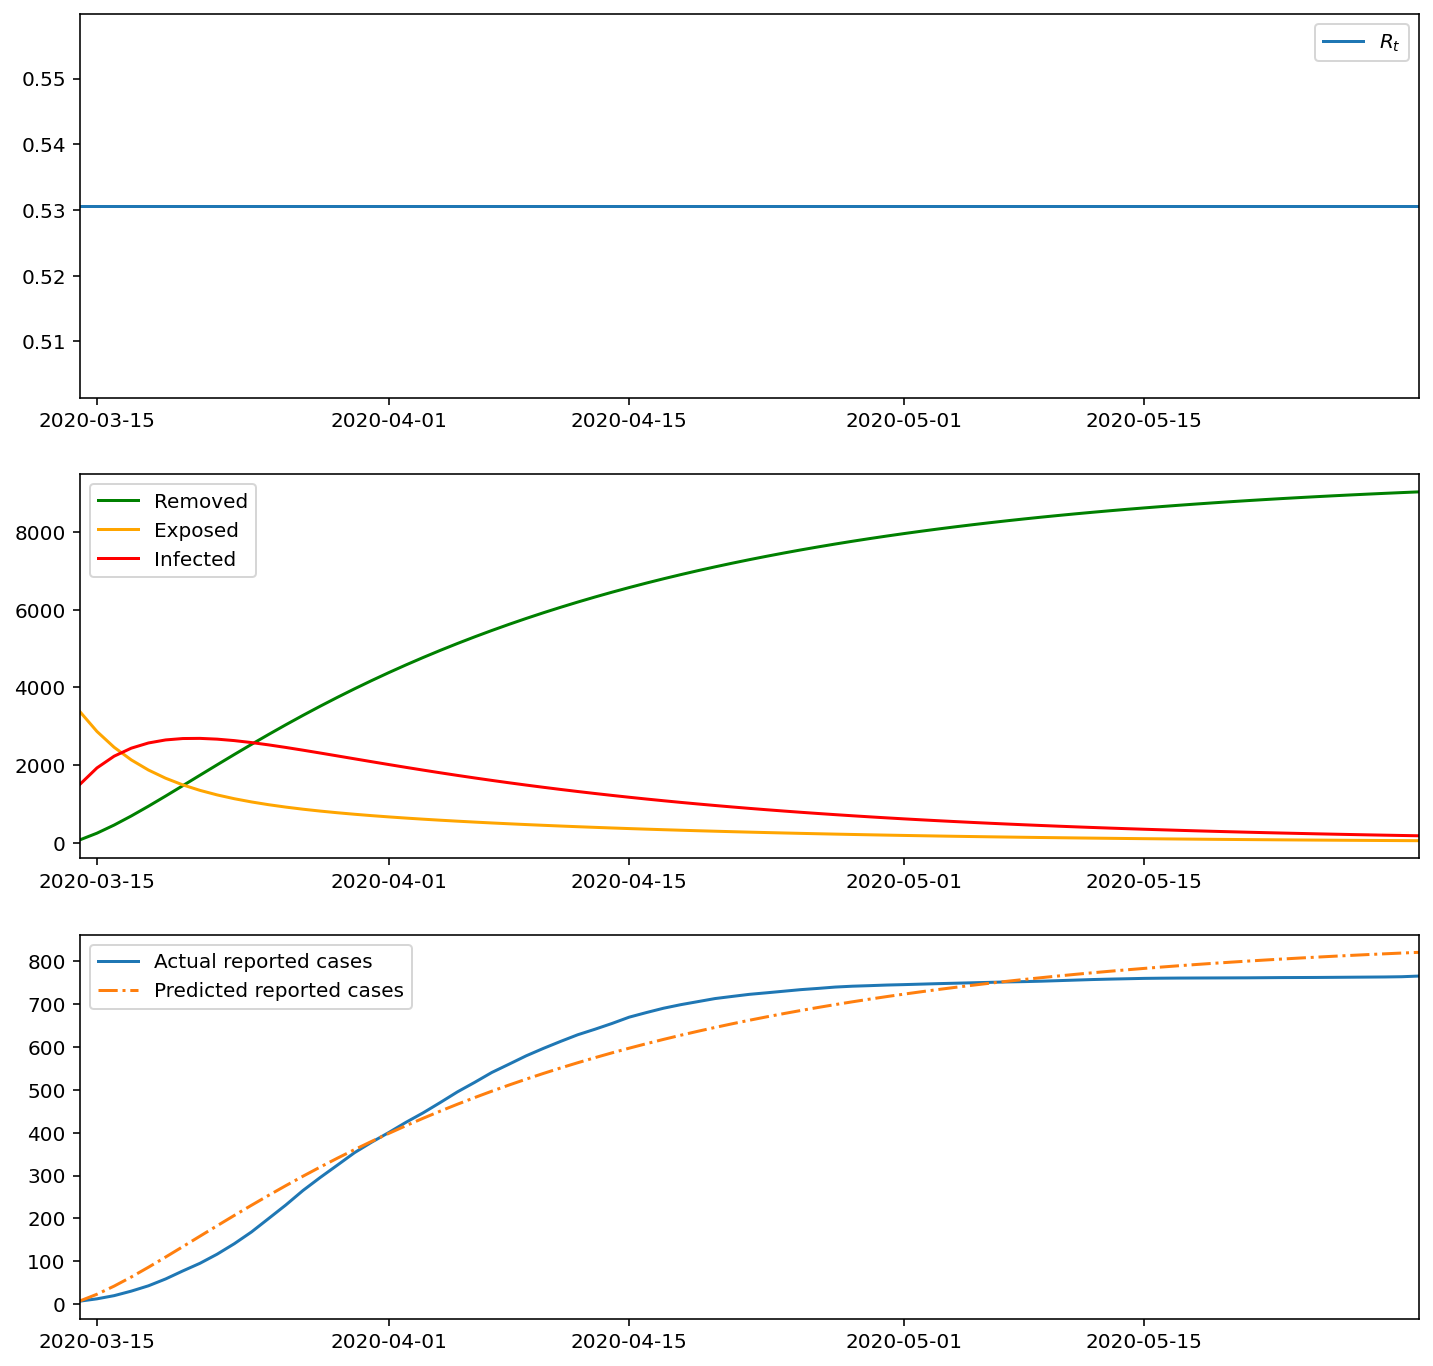


2021-08-13 12:04:15.917534
grid search @ step 3/3 1/3 2/3
training new model:
SEIR model (constant beta)
S0 = None
E0 = 3010.0
I0 = 1030.0
R0 = None
σ = 5.2, γ = None
beta parameter: 0.325

528.0851087282545 True
SEIR model (constant beta)
S0 = 72026.08796783243
E0 = 3408.4922812019554
I0 = 1488.4197509656253
R0 = 77.0
σ = 5.2, γ = 0.1
beta parameter: [0.05286201]

time 0:00:00.503511
****** new best fit LL value: 528.0851087282545 ******


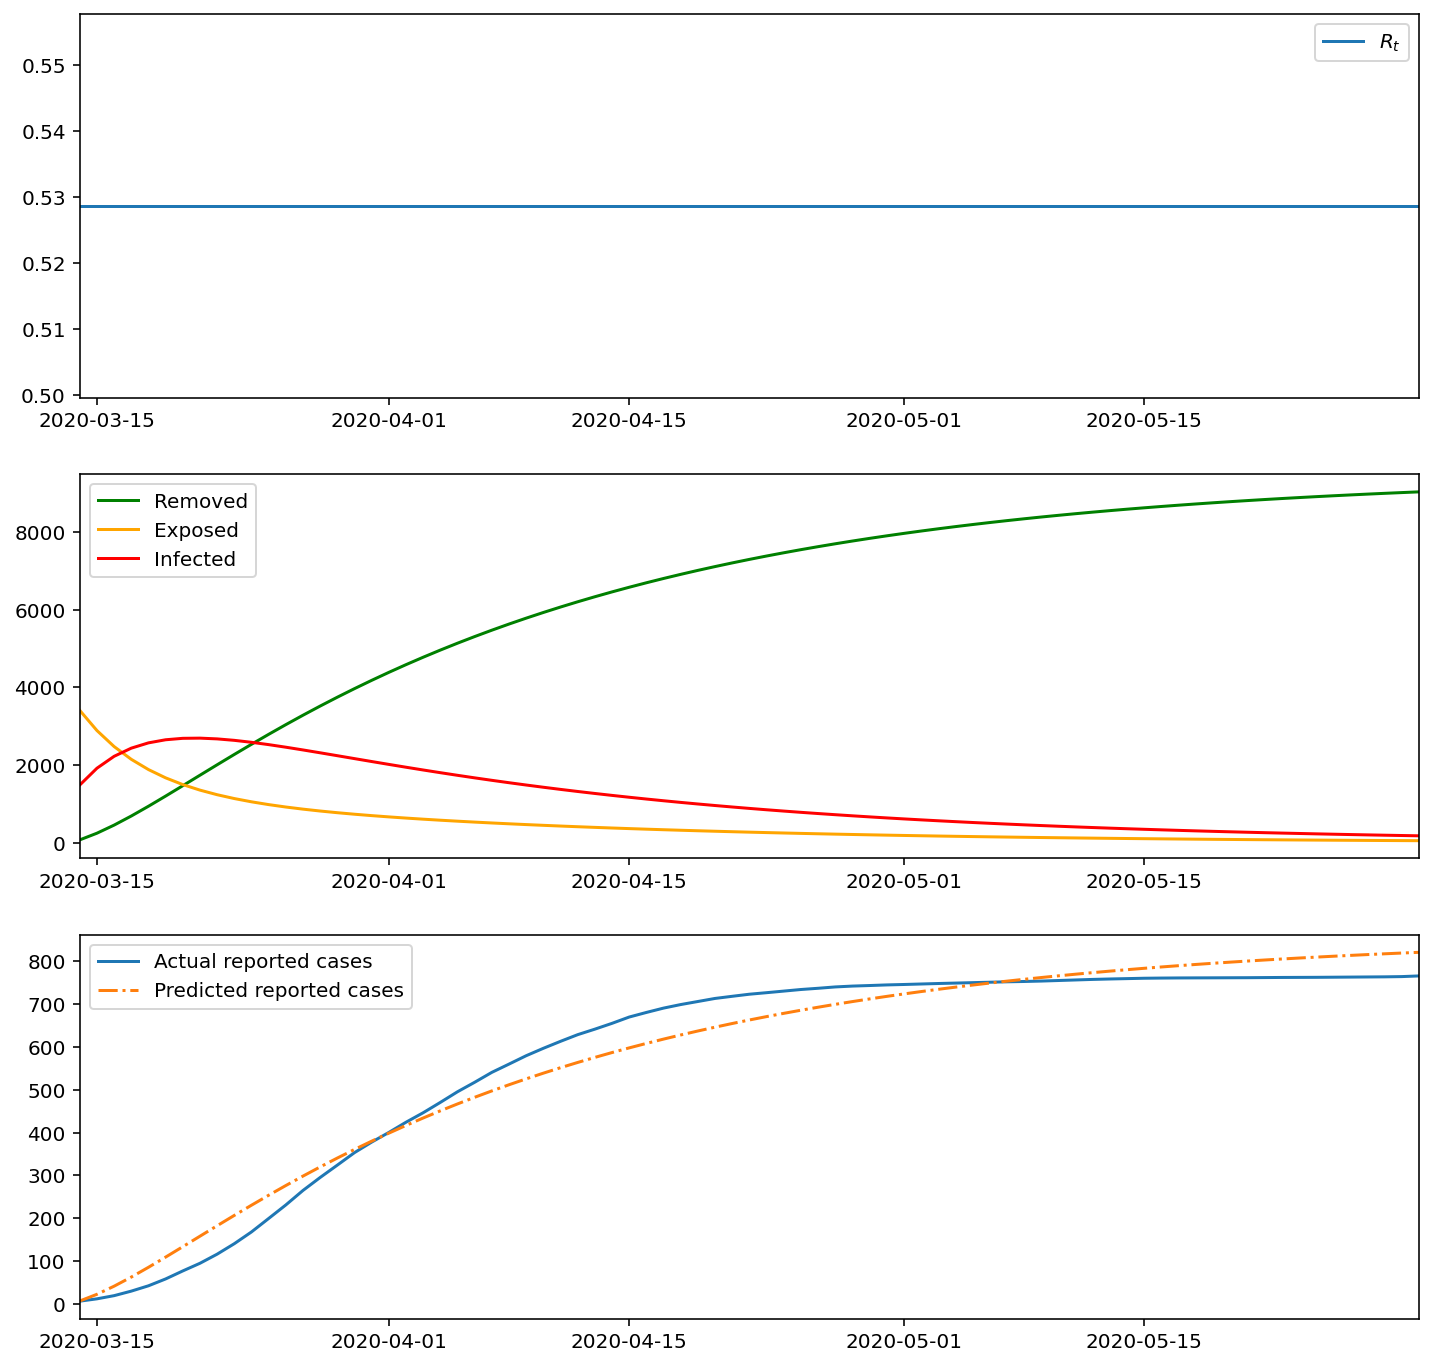


2021-08-13 12:04:17.096400
grid search @ step 3/3 1/3 3/3
training new model:
SEIR model (constant beta)
S0 = None
E0 = 3010.0
I0 = 1030.0
R0 = None
σ = 5.2, γ = None
beta parameter: 0.4625

529.8893311843636 True
SEIR model (constant beta)
S0 = 72041.74138294862
E0 = 3377.2882336688726
I0 = 1503.970383382509
R0 = 77.0
σ = 5.2, γ = 0.1
beta parameter: [0.05312421]

time 0:00:00.639175

2021-08-13 12:04:17.735679
grid search @ step 3/3 2/3 1/3
training new model:
SEIR model (constant beta)
S0 = None
E0 = 3010.0
I0 = 2020.0
R0 = None
σ = 5.2, γ = None
beta parameter: 0.1875

563.6892091606218 True
SEIR model (constant beta)
S0 = 72175.58842067095
E0 = 2879.5234239208407
I0 = 1867.8881554082166
R0 = 77.0
σ = 5.2, γ = 0.1
beta parameter: [0.05517046]

time 0:00:00.247166

2021-08-13 12:04:17.982943
grid search @ step 3/3 2/3 2/3
training new model:
SEIR model (constant beta)
S0 = None
E0 = 3010.0
I0 = 2020.0
R0 = None
σ = 5.2, γ = None
beta parameter: 0.325

445.2448972859068 True
SEIR mo

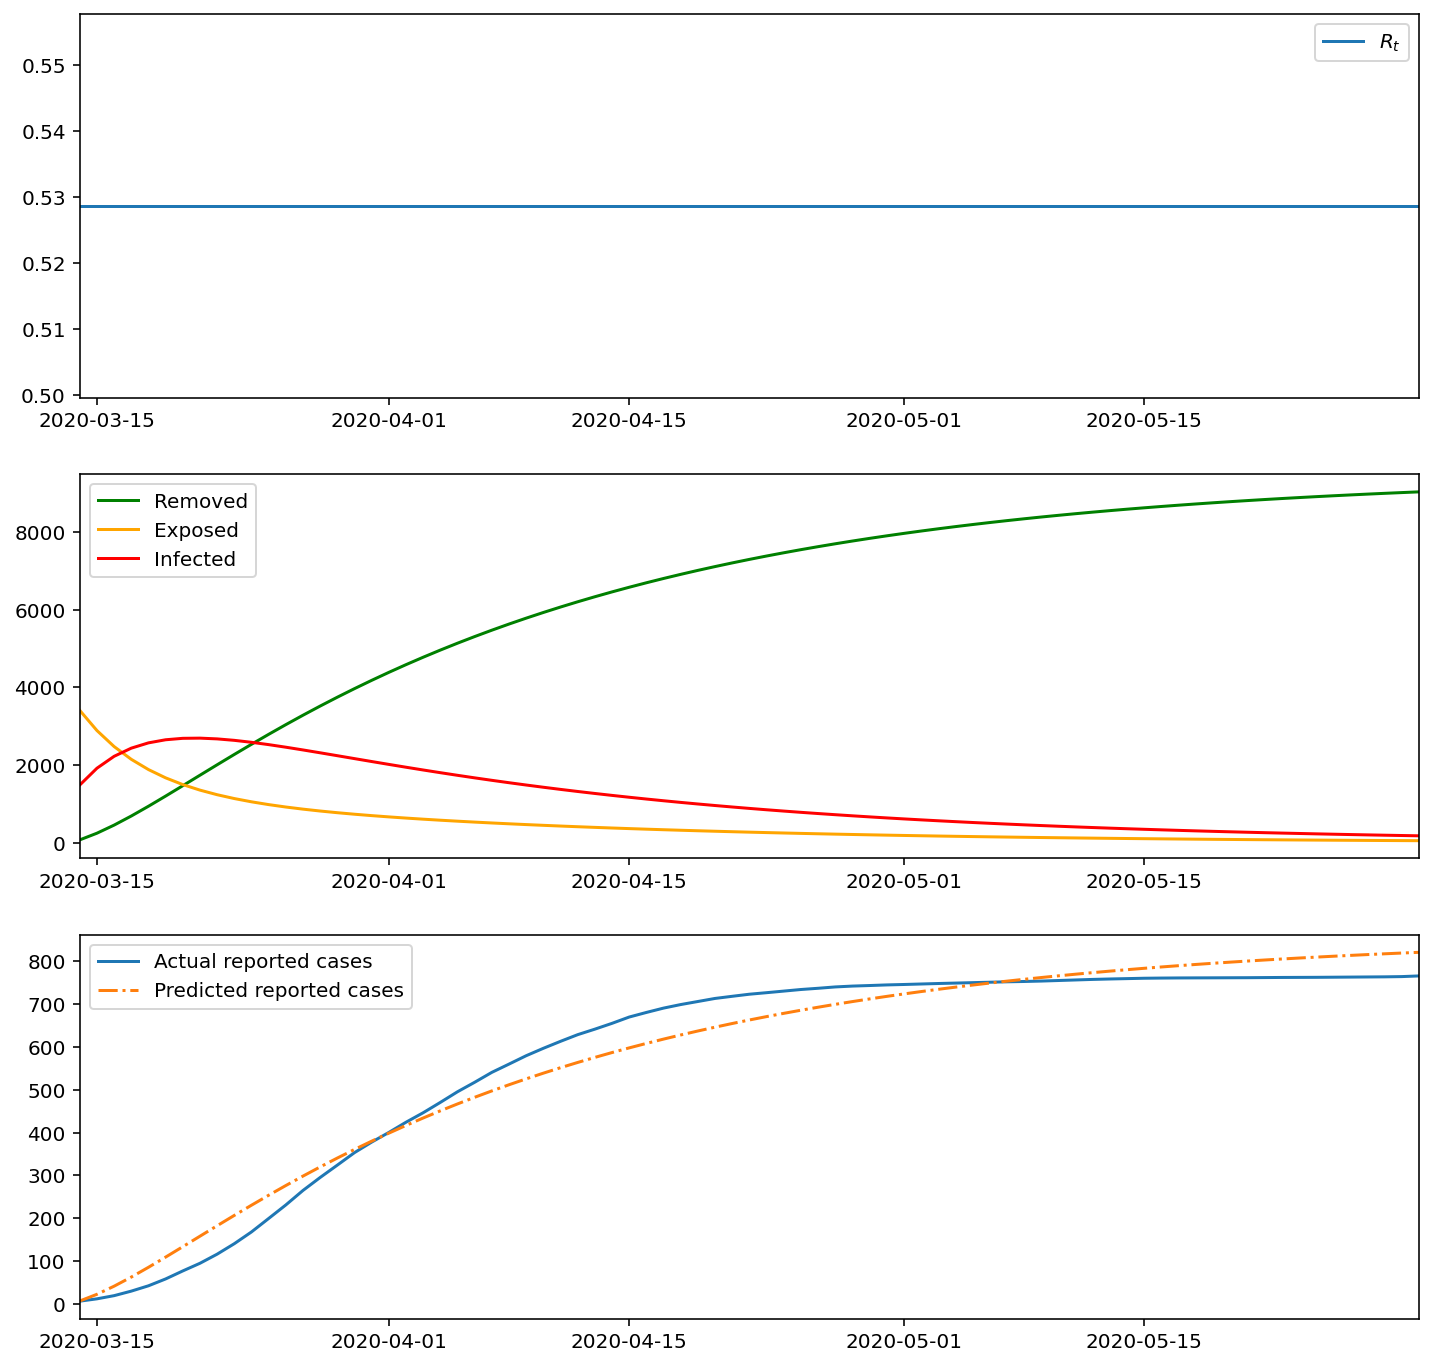

In [316]:
# baseline model
# model_constant_beta_train_5_31, ll = get_best_fit_gs(
#     ConstantBetaSEIRModel(N=ANDORRA_POPULATION),
#     gridsearch_num=3, 
#     train_dates=train_dates,
# )

In [317]:
print(ll)
model_constant_beta_train_5_31.to_dict()

528.0851087282545


{'class': 'ConstantBetaSEIRModel',
 'S0': 72026.08796783243,
 'E0': 3408.4922812019554,
 'I0': 1488.4197509656253,
 'R0': 77.0,
 'C0': 7.0,
 'gamma': 0.1,
 'beta_param': [0.0528620083923926],
 'reporting_rate': 0.09090909090909091,
 'ts': 79}

In [318]:
model_constant_beta_train_5_31 = SEIRModel.from_dict({'class': 'ConstantBetaSEIRModel',
 'S0': 72026.08796783243,
 'E0': 3408.4922812019554,
 'I0': 1488.4197509656253,
 'R0': 77.0,
 'C0': 7.0,
 'gamma': 0.1,
 'beta_param': [0.0528620083923926],
 'reporting_rate': 0.09090909090909091,
 'ts': 79})
model = model_constant_beta_train_5_31

SEIR model (constant beta)
S0 = 72026.08796783243
E0 = 3408.4922812019554
I0 = 1488.4197509656253
R0 = 77.0
σ = 5.2, γ = 0.1
beta parameter: [0.0528620083923926]

infectious period ~ 10.00 days

training period: 2020-03-14 - 2020-05-31
79 training days; 70 test days
simulated (deterministic) forecast
1-week (7-day) MAPE = 0.0003
2-week (14-day) MAPE = 0.0020
3-week (21-day) MAPE = 0.0065
4-week (28-day) MAPE = 0.0097
5-week (35-day) MAPE = 0.0122
6-week (42-day) MAPE = 0.0147
7-week (49-day) MAPE = 0.0136
8-week (56-day) MAPE = 0.0139
9-week (63-day) MAPE = 0.0159
10-week (70-day) MAPE = 0.0180


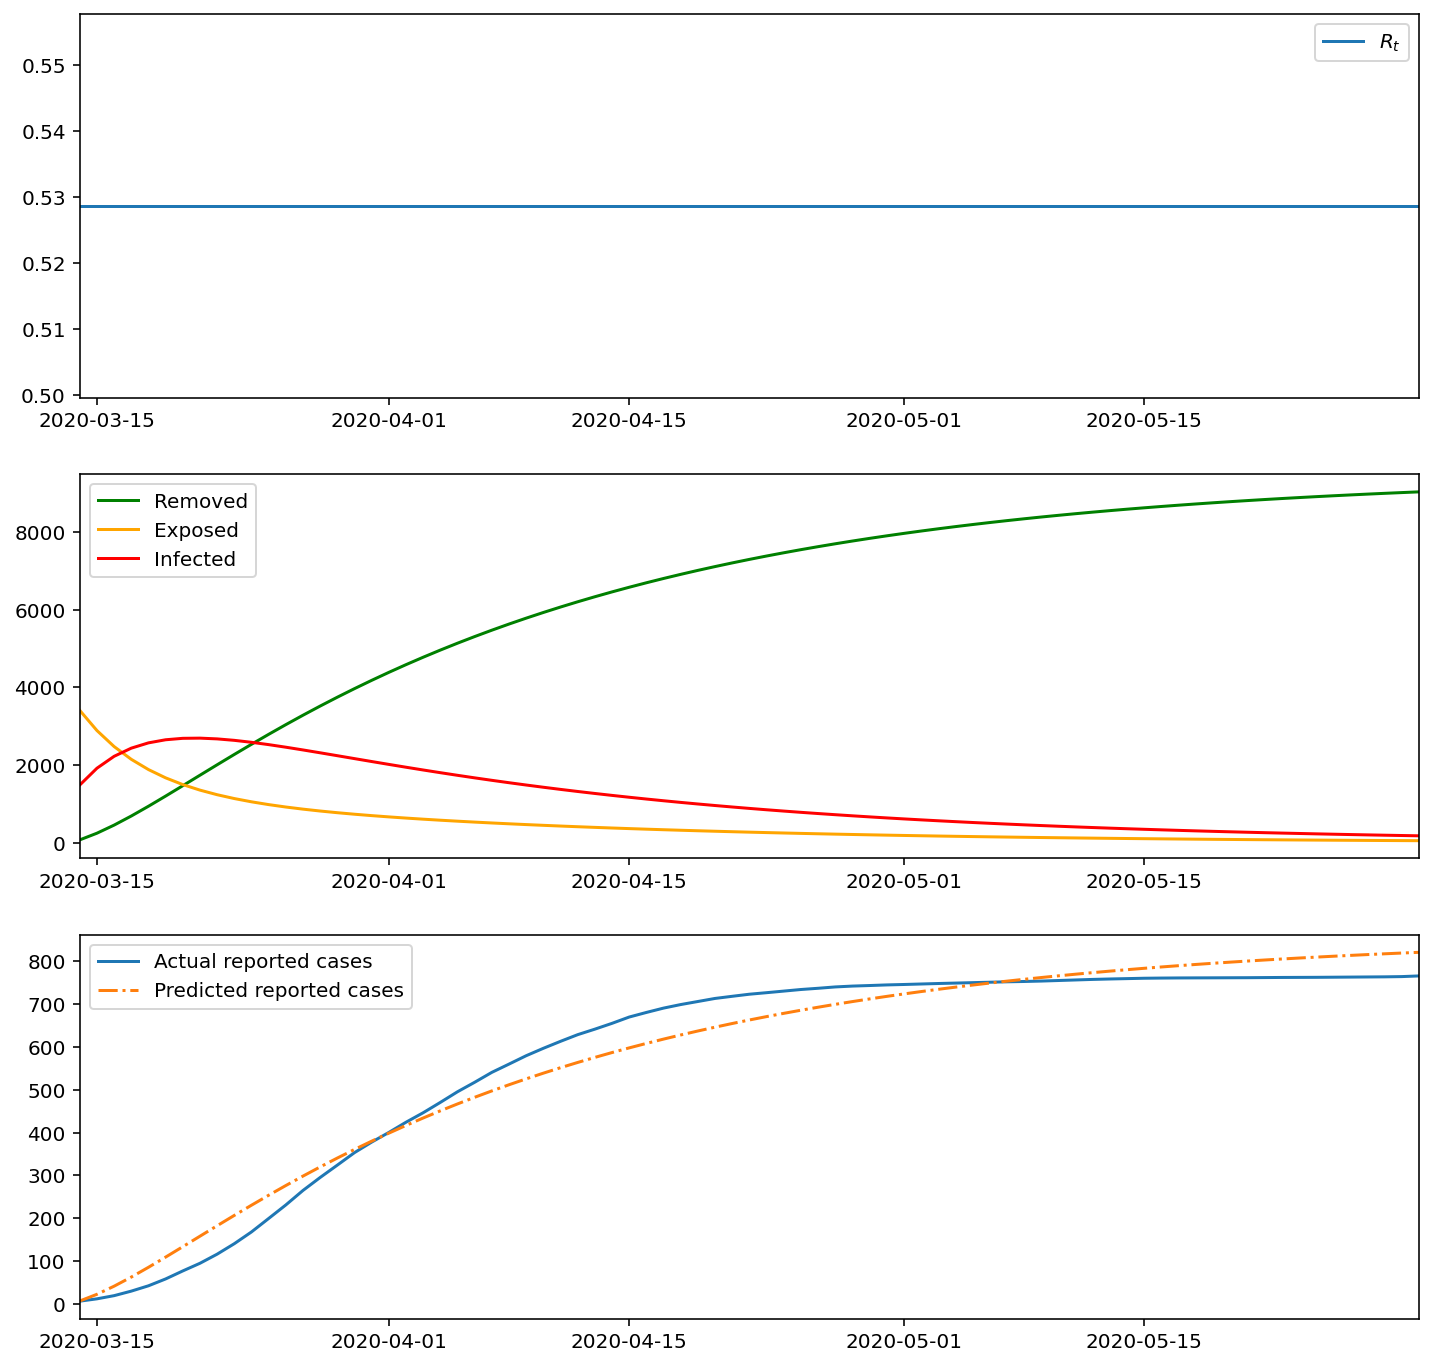

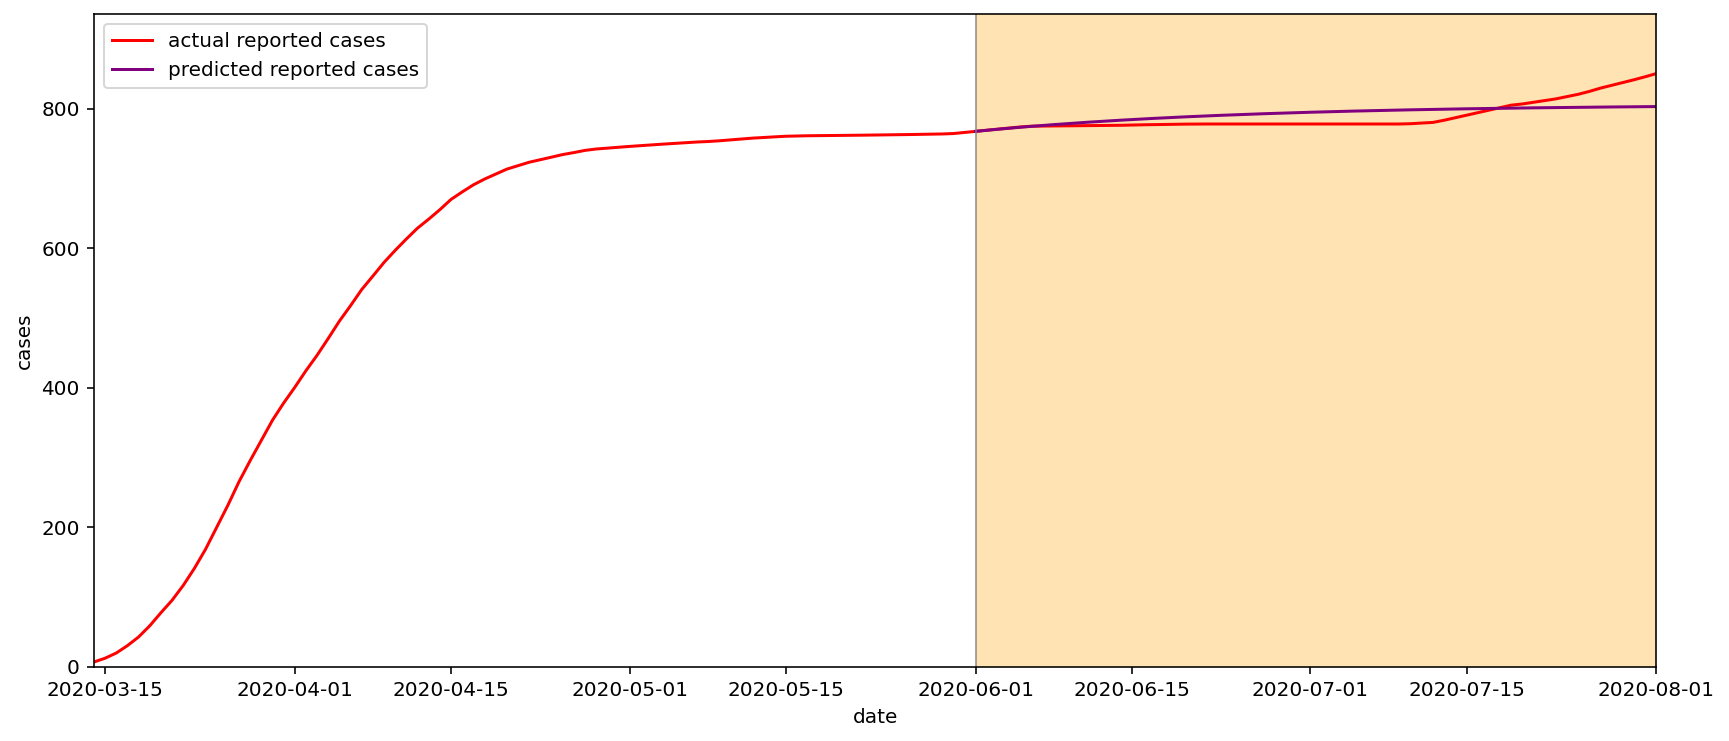

In [319]:
model.plots(reported_cases[train_dates[0]:train_dates[1]])
print(model)
print('infectious period ~ %0.2f days\n' % (1/model.gamma))

train_test_dict_5_31['baseline model'] = get_forecast_results(model, 
                      train_start=train_dates[0],
                      train_end=train_dates[1], 
                      plot_end='2020-07-31')

Trips data model

79 training days: 2020-03-14 - 2020-05-31
gridsearch_E0 [1030. 2020. 3010.]
gridsearch_I0 [1030. 2020. 3010.]
gridsearch_betas [[0.5, 0.5, 0.5], [0.5, 0.5, 1.0], [0.5, 0.5, 1.5], [0.5, 1.0, 0.5], [0.5, 1.0, 1.0], [0.5, 1.0, 1.5], [0.5, 1.5, 0.5], [0.5, 1.5, 1.0], [0.5, 1.5, 1.5], [1.0, 0.5, 0.5], [1.0, 0.5, 1.0], [1.0, 0.5, 1.5], [1.0, 1.0, 0.5], [1.0, 1.0, 1.0], [1.0, 1.0, 1.5], [1.0, 1.5, 0.5], [1.0, 1.5, 1.0], [1.0, 1.5, 1.5], [1.5, 0.5, 0.5], [1.5, 0.5, 1.0], [1.5, 0.5, 1.5], [1.5, 1.0, 0.5], [1.5, 1.0, 1.0], [1.5, 1.0, 1.5], [1.5, 1.5, 0.5], [1.5, 1.5, 1.0], [1.5, 1.5, 1.5]]

2021-08-11 00:01:32.189165
grid search @ step 1/3 1/3 1/27
training new model:
S0 = None
E0 = 1030.0
I0 = 1030.0
R0 = None
σ = 5.2, γ = None
beta parameter: [0.5, 0.5, 0.5]



/Users/aberke/projects/CSL_Andorra_COVID/env/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Repeated error test failures (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


338107.2013151812 True
S0 = 74862.9999970918
E0 = 1029.9999985459003
I0 = 1030.0000043622988
R0 = 77.0
σ = 5.2, γ = 0.29999999970624247
beta parameter: [0.5 0.5 0.5]

time 0:00:01.763351
discarding fit with R_0 > 6

2021-08-11 00:01:33.953299
grid search @ step 1/3 1/3 2/27
training new model:
S0 = None
E0 = 1030.0
I0 = 1030.0
R0 = None
σ = 5.2, γ = None
beta parameter: [0.5, 0.5, 1.0]

3924.6234930239525 True
S0 = 76322.45062761813
E0 = 295.5108032113563
I0 = 305.0385691705172
R0 = 77.0
σ = 5.2, γ = 0.4993172832835415
beta parameter: [0.4457868  0.02222408 0.14830758]

time 0:00:31.580432
****** new best fit LL value: 3924.6234930239525 ******


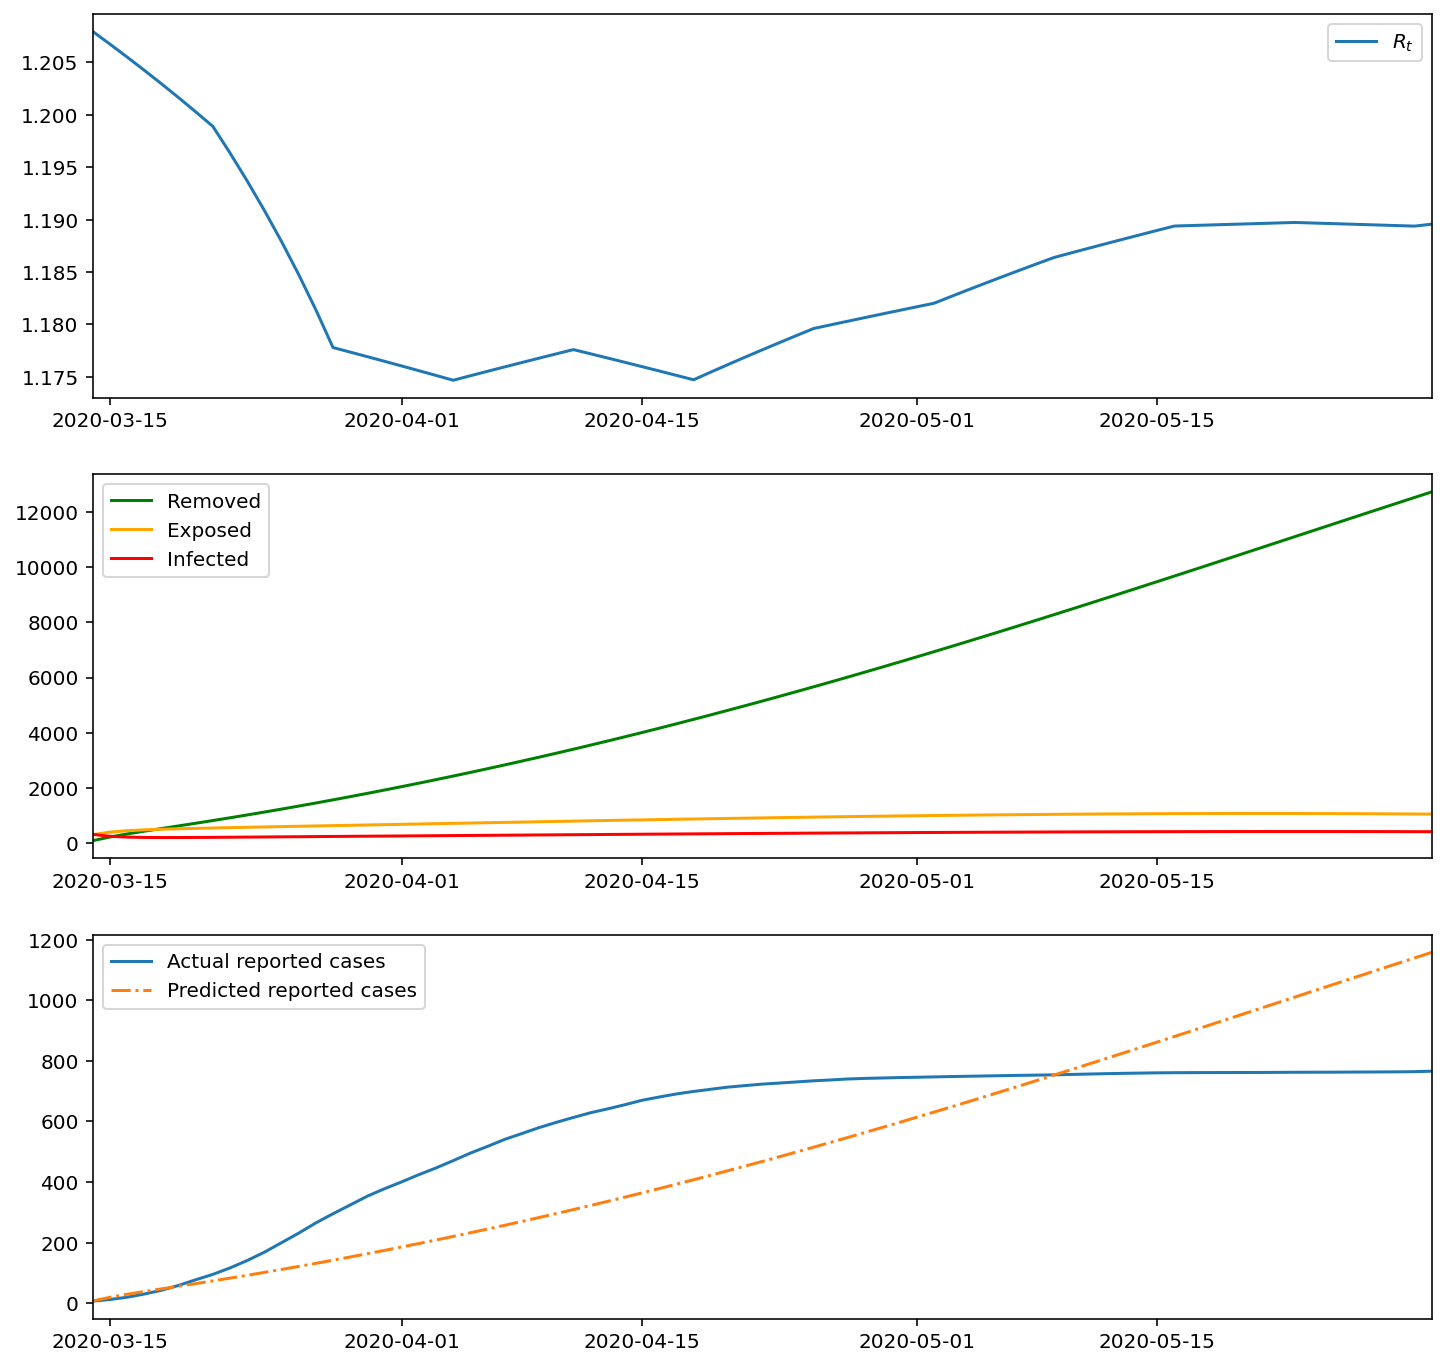


2021-08-11 00:02:06.177636
grid search @ step 1/3 1/3 3/27
training new model:
S0 = None
E0 = 1030.0
I0 = 1030.0
R0 = None
σ = 5.2, γ = None
beta parameter: [0.5, 0.5, 1.5]

18179.603064829724 True
S0 = 76765.2664819198
E0 = 78.90320642067103
I0 = 78.83031165953291
R0 = 77.0
σ = 5.2, γ = 0.24455218308265658
beta parameter: [0.         0.14310111 0.08240424]

time 0:00:33.585017

2021-08-11 00:02:39.763648
grid search @ step 1/3 1/3 4/27
training new model:
S0 = None
E0 = 1030.0
I0 = 1030.0
R0 = None
σ = 5.2, γ = None
beta parameter: [0.5, 1.0, 0.5]

618.9936321964932 True
S0 = 72397.04860028837
E0 = 2111.0598827823537
I0 = 2414.8915169292773
R0 = 77.0
σ = 5.2, γ = 0.1
beta parameter: [0.0171665  0.040034   0.00277962]

time 0:00:08.783296
****** new best fit LL value: 618.9936321964932 ******


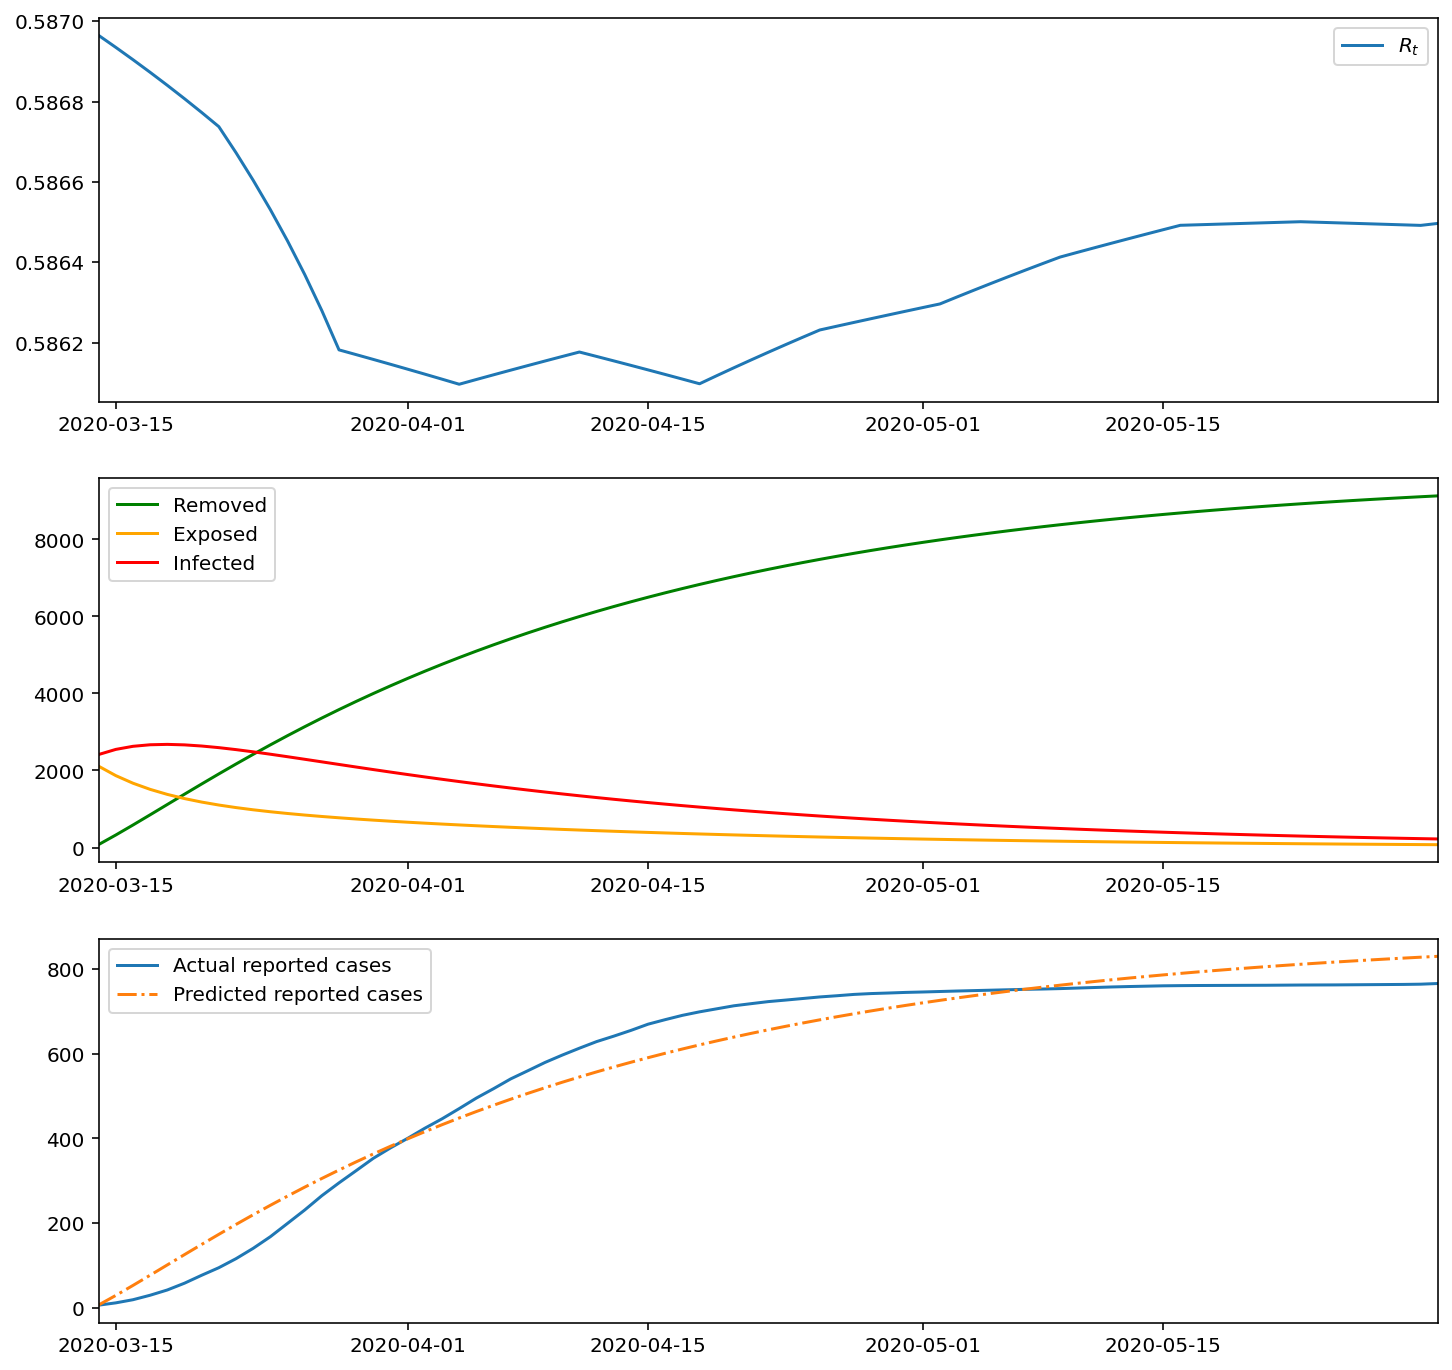


2021-08-11 00:02:49.146049
grid search @ step 1/3 1/3 5/27
training new model:
S0 = None
E0 = 1030.0
I0 = 1030.0
R0 = None
σ = 5.2, γ = None
beta parameter: [0.5, 1.0, 1.0]



/Users/aberke/projects/CSL_Andorra_COVID/env/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Repeated error test failures (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


15277.059498554927 False
S0 = 76721.3011362042
E0 = 90.26988609778272
I0 = 111.42897769802045
R0 = 77.0
σ = 5.2, γ = 0.2633447946559895
beta parameter: [0.2244126  0.09838276 0.05156792]

time 0:00:31.288450

2021-08-11 00:03:20.435392
grid search @ step 1/3 1/3 6/27
training new model:
S0 = None
E0 = 1030.0
I0 = 1030.0
R0 = None
σ = 5.2, γ = None
beta parameter: [0.5, 1.0, 1.5]

339014.06974228675 True
S0 = 74862.99999844655
E0 = 1030.0000007767267
I0 = 1030.0000007767267
R0 = 77.0
σ = 5.2, γ = 0.29999999994769516
beta parameter: [0.5 1.  1.5]

time 0:00:03.453596
discarding fit with R_0 > 6

2021-08-11 00:03:23.889783
grid search @ step 1/3 1/3 7/27
training new model:
S0 = None
E0 = 1030.0
I0 = 1030.0
R0 = None
σ = 5.2, γ = None
beta parameter: [0.5, 1.5, 0.5]

338656.47742307 True
S0 = 74863.0
E0 = 1030.0
I0 = 1030.0
R0 = 77.0
σ = 5.2, γ = 0.3
beta parameter: [0.5 1.5 0.5]

time 0:00:01.080613
discarding fit with R_0 > 6

2021-08-11 00:03:24.971858
grid search @ step 1/3 1/3 8/27
t

295168.3508689137 True
S0 = 76843.0
E0 = 40.0
I0 = 40.0
R0 = 77.0
σ = 5.2, γ = 0.1
beta parameter: [1.5 2.  2. ]

time 0:00:01.593316
discarding fit that came up against bounds

2021-08-11 00:06:35.209121
grid search @ step 1/3 2/3 1/27
training new model:
S0 = None
E0 = 1030.0
I0 = 2020.0
R0 = None
σ = 5.2, γ = None
beta parameter: [0.5, 0.5, 0.5]

23704.934114550862 False
S0 = 76842.03278606987
E0 = 40.30911066783389
I0 = 40.65810326229879
R0 = 77.0
σ = 5.2, γ = 0.3271006631003195
beta parameter: [0.16211181 0.20646251 0.05065793]

time 0:00:28.826596
discarding fit that came up against bounds

2021-08-11 00:07:04.036547
grid search @ step 1/3 2/3 2/27
training new model:
S0 = None
E0 = 1030.0
I0 = 2020.0
R0 = None
σ = 5.2, γ = None
beta parameter: [0.5, 0.5, 1.0]

445.2441803470808 True
S0 = 72883.00332387077
E0 = 3999.9966761292317
I0 = 40.0
R0 = 77.0
σ = 5.2, γ = 0.15775290204491985
beta parameter: [0.08858684 0.00820522 0.00017603]

time 0:00:04.232069
discarding fit that came up

862.43432009689 True
S0 = 71496.9728408256
E0 = 1564.4321750056565
I0 = 3861.5949841687434
R0 = 77.0
σ = 5.2, γ = 0.1
beta parameter: [0.02816162 0.01328086 0.00184908]

time 0:00:06.449733

2021-08-11 00:10:39.700027
grid search @ step 1/3 2/3 23/27
training new model:
S0 = None
E0 = 1030.0
I0 = 2020.0
R0 = None
σ = 5.2, γ = None
beta parameter: [1.5, 1.0, 1.0]

295168.3497175953 True
S0 = 72882.9999999609
E0 = 4000.0
I0 = 40.00000003910117
R0 = 77.0
σ = 5.2, γ = 0.1
beta parameter: [2. 2. 2.]

time 0:00:05.400541
discarding fit that came up against bounds

2021-08-11 00:10:45.101011
grid search @ step 1/3 2/3 24/27
training new model:
S0 = None
E0 = 1030.0
I0 = 2020.0
R0 = None
σ = 5.2, γ = None
beta parameter: [1.5, 1.0, 1.5]

4365.766838910552 True
S0 = 76152.6061839297
E0 = 364.62286816989445
I0 = 405.7709479003918
R0 = 77.0
σ = 5.2, γ = 0.4702979781284128
beta parameter: [0.056122   0.40135856 0.02002929]

time 0:00:08.555639

2021-08-11 00:10:53.657495
grid search @ step 1/3 2/3

6925.288337479617 False
S0 = 76531.85335451599
E0 = 122.40657469427713
I0 = 268.7400707897273
R0 = 77.0
σ = 5.2, γ = 0.36669552897967717
beta parameter: [0.05330414 0.08462123 0.12809475]

time 0:01:15.665338

2021-08-11 00:17:00.214395
grid search @ step 1/3 3/3 17/27
training new model:
S0 = None
E0 = 1030.0
I0 = 3010.0
R0 = None
σ = 5.2, γ = None
beta parameter: [1.0, 1.5, 1.0]

692.0786271696973 True
S0 = 72587.59976289325
E0 = 1215.4695002285787
I0 = 3119.9307368781692
R0 = 77.0
σ = 5.2, γ = 0.1
beta parameter: [4.72433389e-02 1.40446313e-02 8.50963450e-05]

time 0:00:03.143731

2021-08-11 00:17:03.358929
grid search @ step 1/3 3/3 18/27
training new model:
S0 = None
E0 = 1030.0
I0 = 3010.0
R0 = None
σ = 5.2, γ = None
beta parameter: [1.0, 1.5, 1.5]

3366.3463840796585 True
S0 = 76166.1287468698
E0 = 50.38976376144117
I0 = 706.4814893687559
R0 = 77.0
σ = 5.2, γ = 0.30120597306487024
beta parameter: [0.10440673 0.17731531 0.0293947 ]

time 0:00:43.686051

2021-08-11 00:17:47.045791

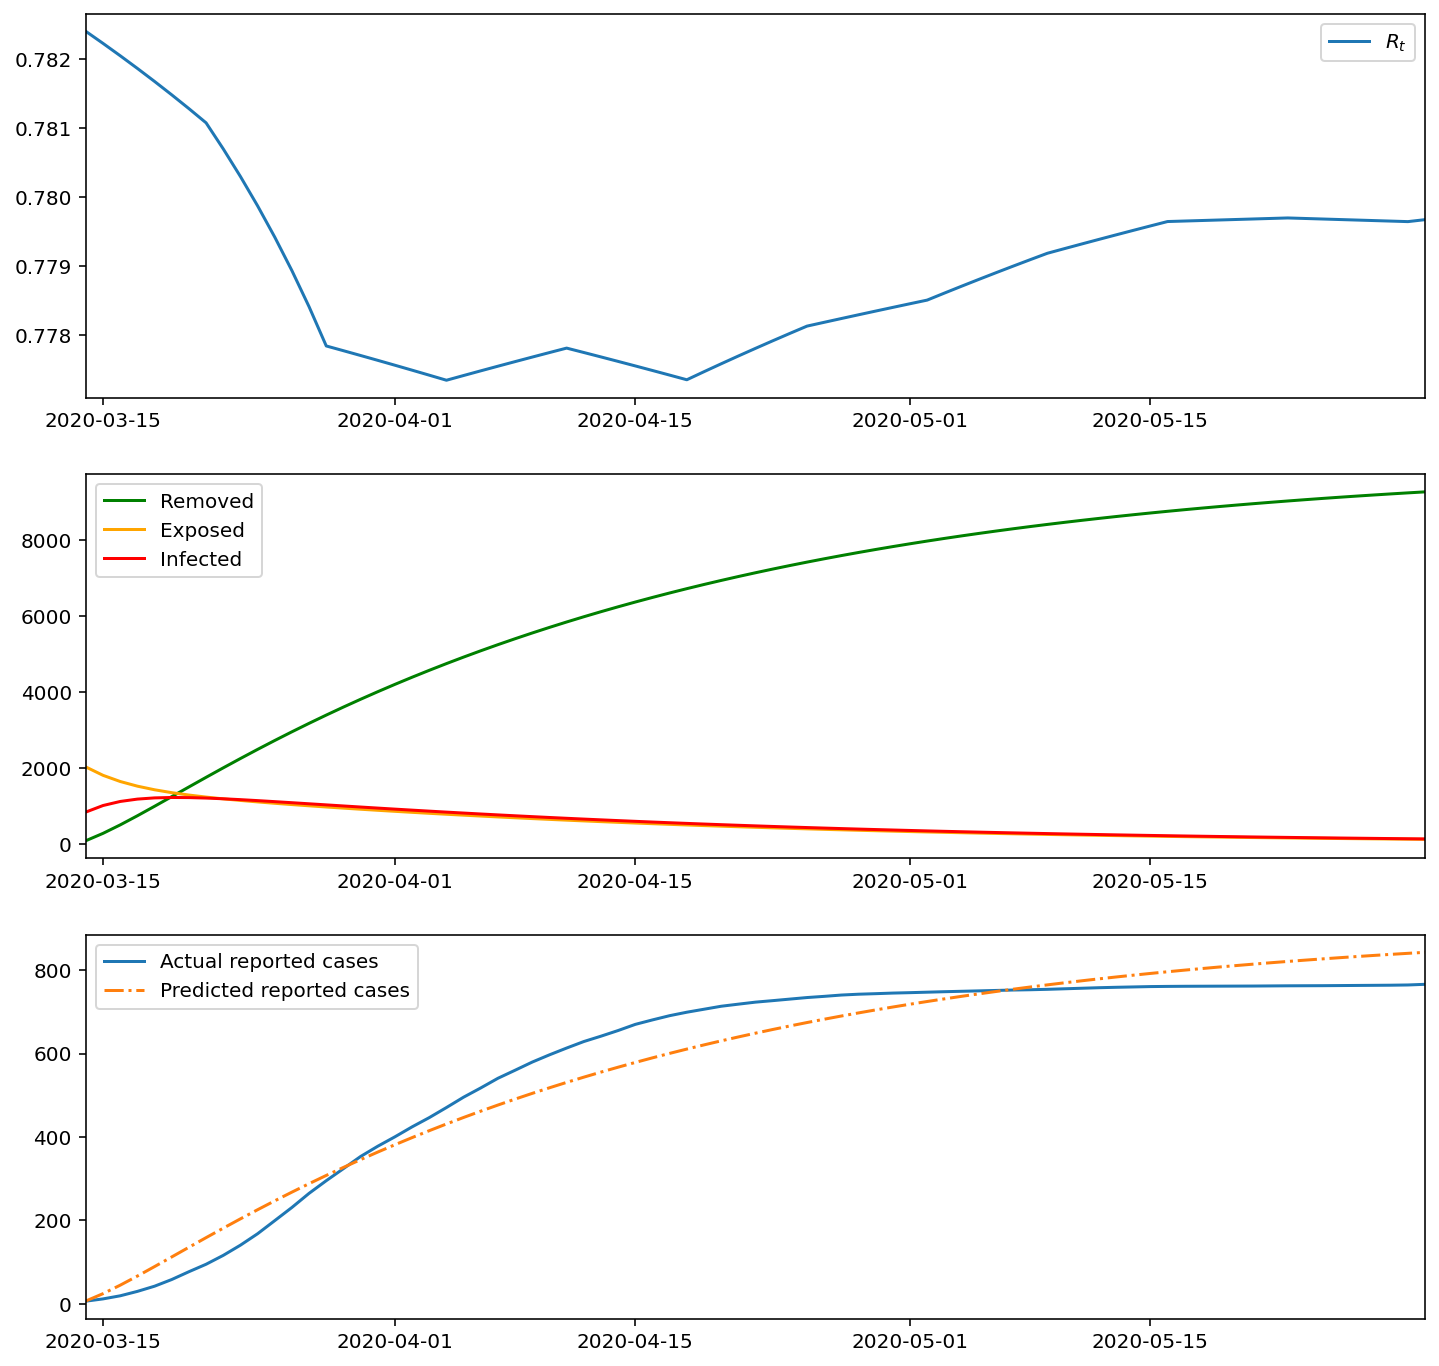


2021-08-11 00:20:10.401945
grid search @ step 2/3 1/3 5/27
training new model:
S0 = None
E0 = 2020.0
I0 = 1030.0
R0 = None
σ = 5.2, γ = None
beta parameter: [0.5, 1.0, 1.0]

339013.17999303696 True
S0 = 73872.99999281426
E0 = 2020.0000028742973
I0 = 1030.0000043114458
R0 = 77.0
σ = 5.2, γ = 0.29999999970966695
beta parameter: [0.5 1.  1. ]

time 0:00:07.979841
discarding fit with R_0 > 6

2021-08-11 00:20:18.382541
grid search @ step 2/3 1/3 6/27
training new model:
S0 = None
E0 = 2020.0
I0 = 1030.0
R0 = None
σ = 5.2, γ = None
beta parameter: [0.5, 1.0, 1.5]

339014.06988197326 True
S0 = 73872.99999960506
E0 = 2020.0000001579754
I0 = 1030.0000002369632
R0 = 77.0
σ = 5.2, γ = 0.29999999998404286
beta parameter: [0.5 1.  1.5]

time 0:00:06.615832
discarding fit with R_0 > 6

2021-08-11 00:20:24.999310
grid search @ step 2/3 1/3 7/27
training new model:
S0 = None
E0 = 2020.0
I0 = 1030.0
R0 = None
σ = 5.2, γ = None
beta parameter: [0.5, 1.5, 0.5]

590.4925453536192 False
S0 = 73947.028490

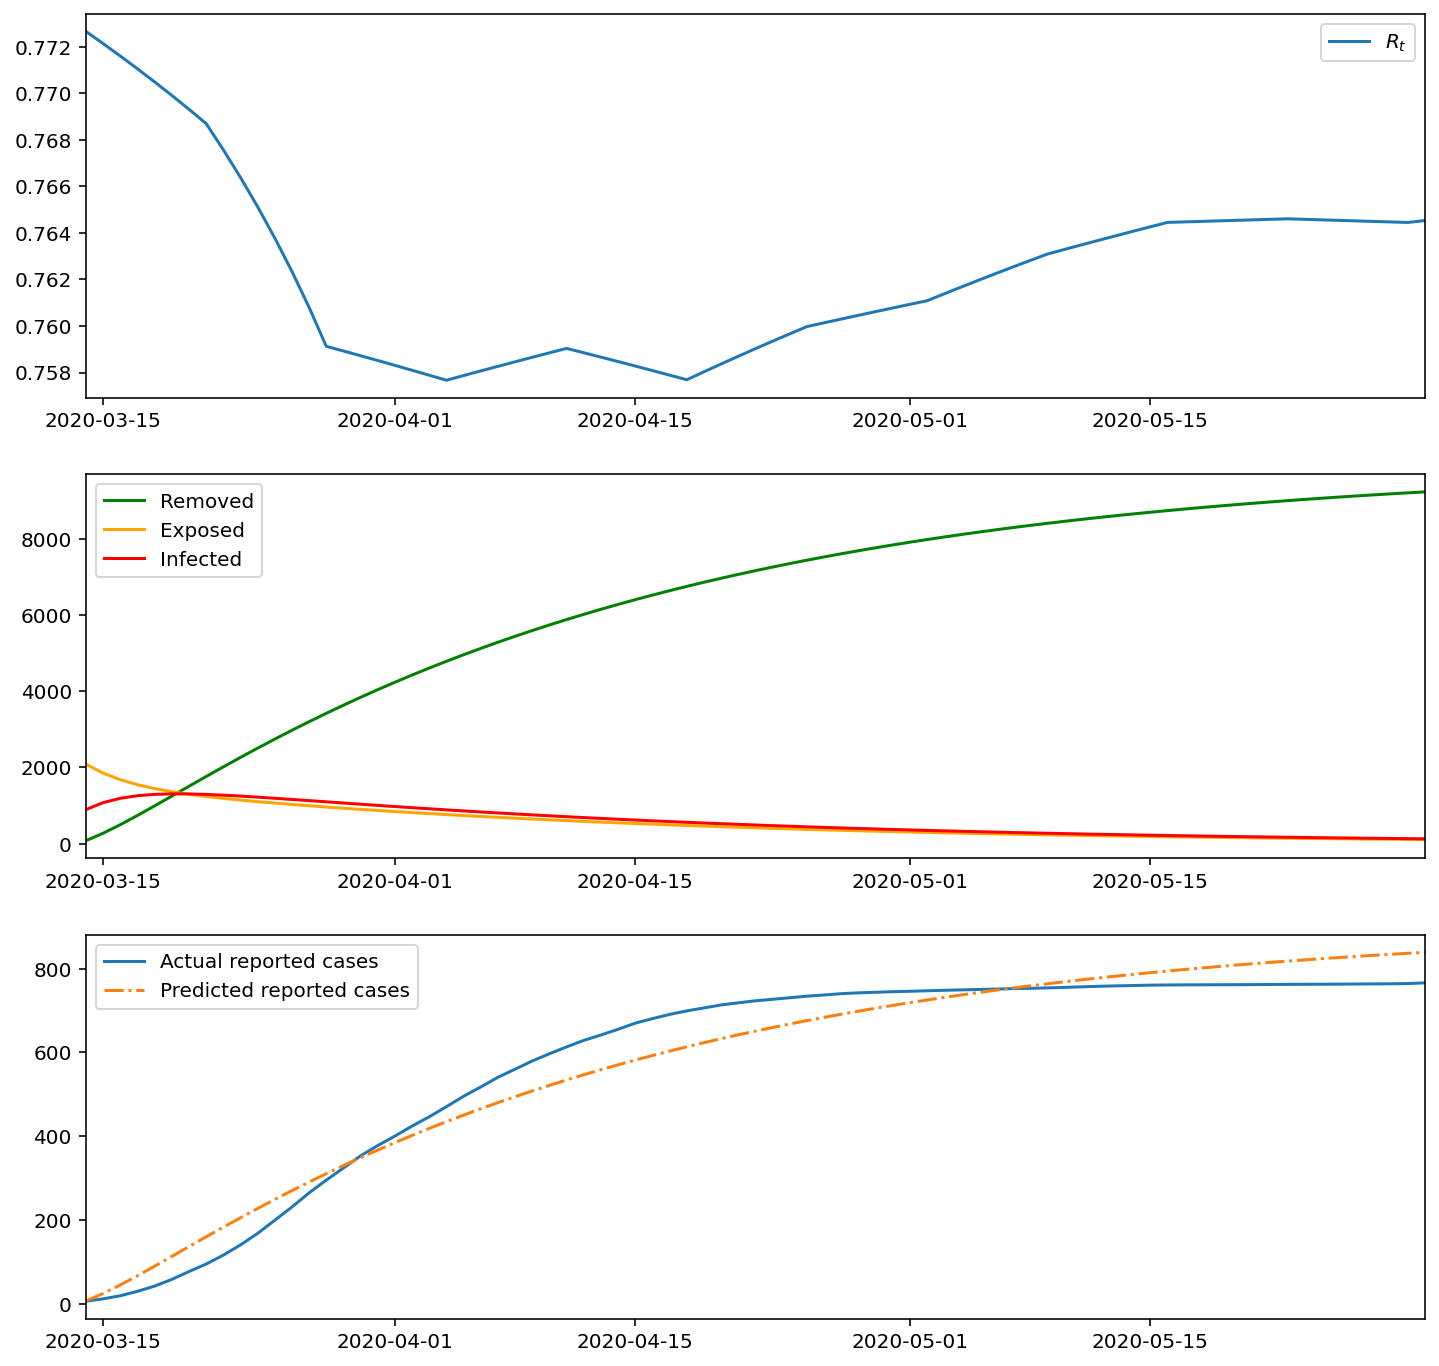


2021-08-11 00:20:43.431802
grid search @ step 2/3 1/3 8/27
training new model:
S0 = None
E0 = 2020.0
I0 = 1030.0
R0 = None
σ = 5.2, γ = None
beta parameter: [0.5, 1.5, 1.0]

33272.814103020995 True
S0 = 76843.0
E0 = 40.000000000000284
I0 = 40.00000000000043
R0 = 77.0
σ = 5.2, γ = 0.10000000022136363
beta parameter: [0.27356978 0.         2.        ]

time 0:00:01.650014
discarding fit that came up against bounds

2021-08-11 00:20:45.082269
grid search @ step 2/3 1/3 9/27
training new model:
S0 = None
E0 = 2020.0
I0 = 1030.0
R0 = None
σ = 5.2, γ = None
beta parameter: [0.5, 1.5, 1.5]

452.7504319697874 False
S0 = 72957.14299017013
E0 = 3858.5766190760146
I0 = 107.28039075384973
R0 = 77.0
σ = 5.2, γ = 0.16147834557081758
beta parameter: [0.00173667 0.0951549  0.00307467]

time 0:00:10.707632
discarding fit that came up against bounds

2021-08-11 00:20:55.790486
grid search @ step 2/3 1/3 10/27
training new model:
S0 = None
E0 = 2020.0
I0 = 1030.0
R0 = None
σ = 5.2, γ = None
beta paramet

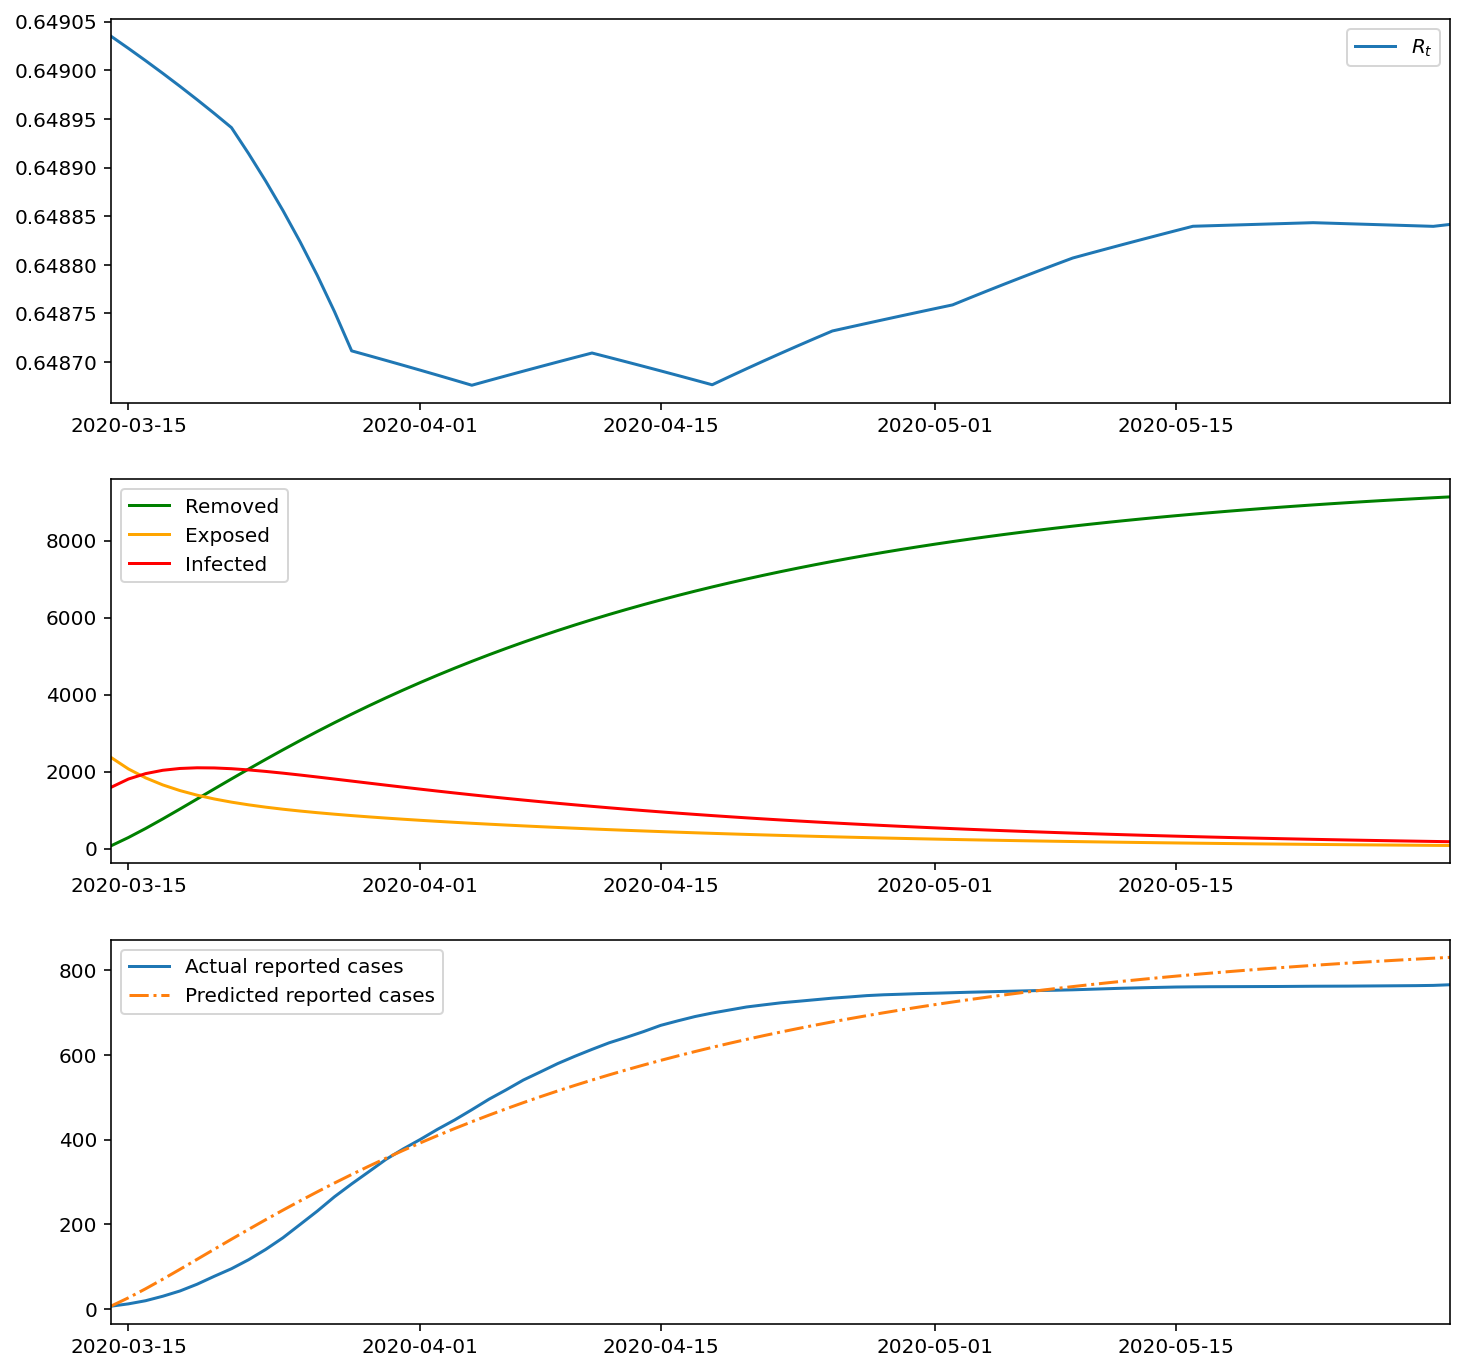


2021-08-11 00:21:09.430515
grid search @ step 2/3 1/3 11/27
training new model:
S0 = None
E0 = 2020.0
I0 = 1030.0
R0 = None
σ = 5.2, γ = None
beta parameter: [1.0, 0.5, 1.0]

554.498645289271 True
S0 = 72681.78282466007
E0 = 2824.537116072278
I0 = 1416.6800592676623
R0 = 77.0
σ = 5.2, γ = 0.1190327067994505
beta parameter: [0.04677039 0.02560403 0.00083663]

time 0:00:13.706001
****** new best fit LL value: 554.498645289271 ******


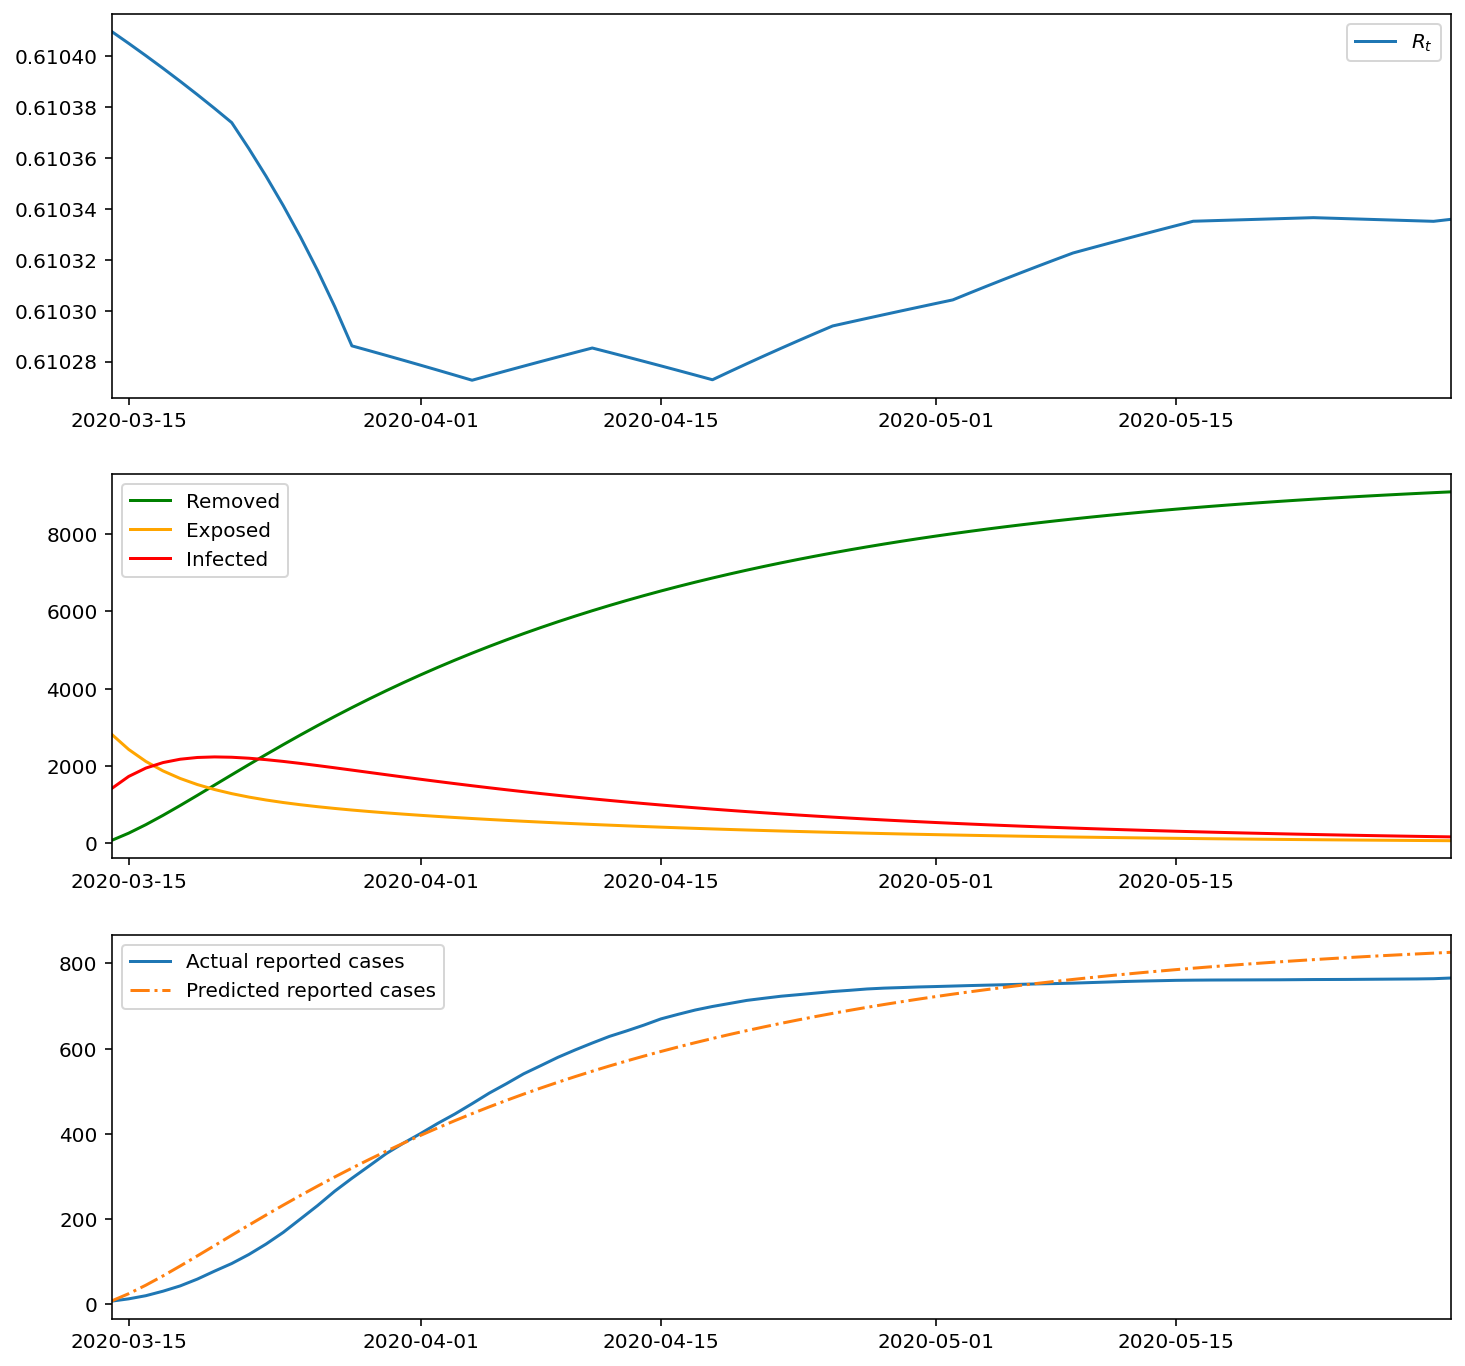


2021-08-11 00:21:23.704045
grid search @ step 2/3 1/3 12/27
training new model:
S0 = None
E0 = 2020.0
I0 = 1030.0
R0 = None
σ = 5.2, γ = None
beta parameter: [1.0, 0.5, 1.5]



/Users/aberke/projects/CSL_Andorra_COVID/env/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Repeated error test failures (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


339014.0687572189 True
S0 = 73873.0
E0 = 2020.0
I0 = 1030.0
R0 = 77.0
σ = 5.2, γ = 0.3
beta parameter: [1.  0.5 1.5]

time 0:00:01.370560
discarding fit with R_0 > 6

2021-08-11 00:21:25.075414
grid search @ step 2/3 1/3 13/27
training new model:
S0 = None
E0 = 2020.0
I0 = 1030.0
R0 = None
σ = 5.2, γ = None
beta parameter: [1.0, 1.0, 0.5]

2233.8710251424686 True
S0 = 73538.99882108865
E0 = 40.89271859946053
I0 = 3343.1084603118957
R0 = 77.0
σ = 5.2, γ = 0.4446106562186342
beta parameter: [0.27694672 0.         2.        ]

time 0:00:08.450965
discarding fit that came up against bounds

2021-08-11 00:21:33.526859
grid search @ step 2/3 1/3 14/27
training new model:
S0 = None
E0 = 2020.0
I0 = 1030.0
R0 = None
σ = 5.2, γ = None
beta parameter: [1.0, 1.0, 1.0]

21657.764601951505 True
S0 = 76842.9992440285
E0 = 40.0004324065501
I0 = 40.00032356495211
R0 = 77.0
σ = 5.2, γ = 0.499999753935878
beta parameter: [0.38625734 0.38008806 0.00299791]

time 0:00:14.107556
discarding fit that came up

1309.7569210452293 True
S0 = 69225.9333449592
E0 = 4000.0
I0 = 3697.066655040813
R0 = 77.0
σ = 5.2, γ = 0.1
beta parameter: [2.99872879e-20 5.97488990e-20 0.00000000e+00]

time 0:00:01.677509
discarding fit that came up against bounds

2021-08-11 00:24:37.464547
grid search @ step 2/3 2/3 8/27
training new model:
S0 = None
E0 = 2020.0
I0 = 2020.0
R0 = None
σ = 5.2, γ = None
beta parameter: [0.5, 1.5, 1.0]

20312.228217129694 True
S0 = 76753.4654516585
E0 = 83.63214228534133
I0 = 85.90240605615814
R0 = 77.0
σ = 5.2, γ = 0.17263581884802742
beta parameter: [0.31997497 0.         2.        ]

time 0:00:03.141659

2021-08-11 00:24:40.607060
grid search @ step 2/3 2/3 9/27
training new model:
S0 = None
E0 = 2020.0
I0 = 2020.0
R0 = None
σ = 5.2, γ = None
beta parameter: [0.5, 1.5, 1.5]

27763.41681471257 True
S0 = 76843.0
E0 = 40.0
I0 = 40.0
R0 = 77.0
σ = 5.2, γ = 0.1945371981987809
beta parameter: [0.3818285 0.        2.       ]

time 0:00:01.469493
discarding fit that came up against bound

339910.8406718813 True
S0 = 71892.99999850635
E0 = 2020.000000995769
I0 = 3010.0000004978847
R0 = 77.0
σ = 5.2, γ = 0.2999999998994173
beta parameter: [0.5 0.5 1. ]

time 0:00:06.946847
discarding fit with R_0 > 6

2021-08-11 00:28:16.320130
grid search @ step 2/3 3/3 3/27
training new model:
S0 = None
E0 = 2020.0
I0 = 3010.0
R0 = None
σ = 5.2, γ = None
beta parameter: [0.5, 0.5, 1.5]

7512.797847952557 False
S0 = 76393.18477314836
E0 = 47.975495234748976
I0 = 481.83973161689573
R0 = 77.0
σ = 5.2, γ = 0.18757448001382454
beta parameter: [0.12485339 0.1247074  0.00938089]

time 0:00:15.675821

2021-08-11 00:28:31.996862
grid search @ step 2/3 3/3 4/27
training new model:
S0 = None
E0 = 2020.0
I0 = 3010.0
R0 = None
σ = 5.2, γ = None
beta parameter: [0.5, 1.0, 0.5]

12747.338134584608 False
S0 = 76647.52140249514
E0 = 118.19197695746941
I0 = 157.28662054738896
R0 = 77.0
σ = 5.2, γ = 0.24046368902315432
beta parameter: [0.14505237 0.16200656 0.02442748]

time 0:00:42.309976

2021-08-11 00:

339911.13759632816 False
S0 = 71893.0
E0 = 2020.0
I0 = 3010.0
R0 = 77.0
σ = 5.2, γ = 0.3
beta parameter: [1.5 1.  1. ]

time 0:00:07.595093
discarding fit with R_0 > 6

2021-08-11 00:33:51.015728
grid search @ step 2/3 3/3 24/27
training new model:
S0 = None
E0 = 2020.0
I0 = 3010.0
R0 = None
σ = 5.2, γ = None
beta parameter: [1.5, 1.0, 1.5]

1309.7569194631328 True
S0 = 69225.93335129638
E0 = 4000.0
I0 = 3697.066648703622
R0 = 77.0
σ = 5.2, γ = 0.1
beta parameter: [1.94094665e-20 3.86866994e-20 0.00000000e+00]

time 0:00:01.386589
discarding fit that came up against bounds

2021-08-11 00:33:52.403126
grid search @ step 2/3 3/3 25/27
training new model:
S0 = None
E0 = 2020.0
I0 = 3010.0
R0 = None
σ = 5.2, γ = None
beta parameter: [1.5, 1.5, 0.5]

691.2067010844788 True
S0 = 72005.485682941
E0 = 1860.531119826581
I0 = 3056.983197232423
R0 = 77.0
σ = 5.2, γ = 0.1
beta parameter: [3.18087291e-02 1.93004279e-02 6.31049062e-07]

time 0:00:06.441968

2021-08-11 00:33:58.846047
grid search @ s

339014.0703377637 False
S0 = 72883.0
E0 = 3010.0
I0 = 1030.0
R0 = 77.0
σ = 5.2, γ = 0.3
beta parameter: [1.  1.5 1.5]

time 0:00:10.173013
discarding fit with R_0 > 6

2021-08-11 00:37:08.505973
grid search @ step 3/3 1/3 19/27
training new model:
S0 = None
E0 = 3010.0
I0 = 1030.0
R0 = None
σ = 5.2, γ = None
beta parameter: [1.5, 0.5, 0.5]

638.2191076724341 False
S0 = 74704.45471187732
E0 = 1593.4844638826703
I0 = 625.0608242400085
R0 = 77.0
σ = 5.2, γ = 0.38482213499913265
beta parameter: [0.12022616 0.11183241 0.04720502]

time 0:00:34.619572

2021-08-11 00:37:43.126783
grid search @ step 3/3 1/3 20/27
training new model:
S0 = None
E0 = 3010.0
I0 = 1030.0
R0 = None
σ = 5.2, γ = None
beta parameter: [1.5, 0.5, 1.0]

339012.3150888727 True
S0 = 72883.0
E0 = 3010.0000000709347
I0 = 1029.9999999290656
R0 = 77.0
σ = 5.2, γ = 0.2999999999856698
beta parameter: [1.5 0.5 1. ]

time 0:00:01.244681
discarding fit with R_0 > 6

2021-08-11 00:37:44.372544
grid search @ step 3/3 1/3 21/27
traini

798.0051708688363 True
S0 = 71270.37925101076
E0 = 2378.002605672165
I0 = 3274.6181433170764
R0 = 77.0
σ = 5.2, γ = 0.1
beta parameter: [0.03631293 0.0024177  0.00112186]

time 0:00:02.822381

2021-08-11 00:40:41.528847
grid search @ step 3/3 2/3 14/27
training new model:
S0 = None
E0 = 3010.0
I0 = 2020.0
R0 = None
σ = 5.2, γ = None
beta parameter: [1.0, 1.0, 1.0]

nan False
S0 = 71893.0
E0 = 3010.0
I0 = 2020.0
R0 = 77.0
σ = 5.2, γ = 0.3
beta parameter: [1. 1. 1.]

time 0:00:00.837706
discarding fit with R_0 > 6

2021-08-11 00:40:42.367298
grid search @ step 3/3 2/3 15/27
training new model:
S0 = None
E0 = 3010.0
I0 = 2020.0
R0 = None
σ = 5.2, γ = None
beta parameter: [1.0, 1.0, 1.5]

339462.61457009095 True
S0 = 71893.0
E0 = 3010.0
I0 = 2020.0
R0 = 77.0
σ = 5.2, γ = 0.3
beta parameter: [1.  1.  1.5]

time 0:00:01.363584
discarding fit with R_0 > 6

2021-08-11 00:40:43.731600
grid search @ step 3/3 2/3 16/27
training new model:
S0 = None
E0 = 3010.0
I0 = 2020.0
R0 = None
σ = 5.2, γ = N

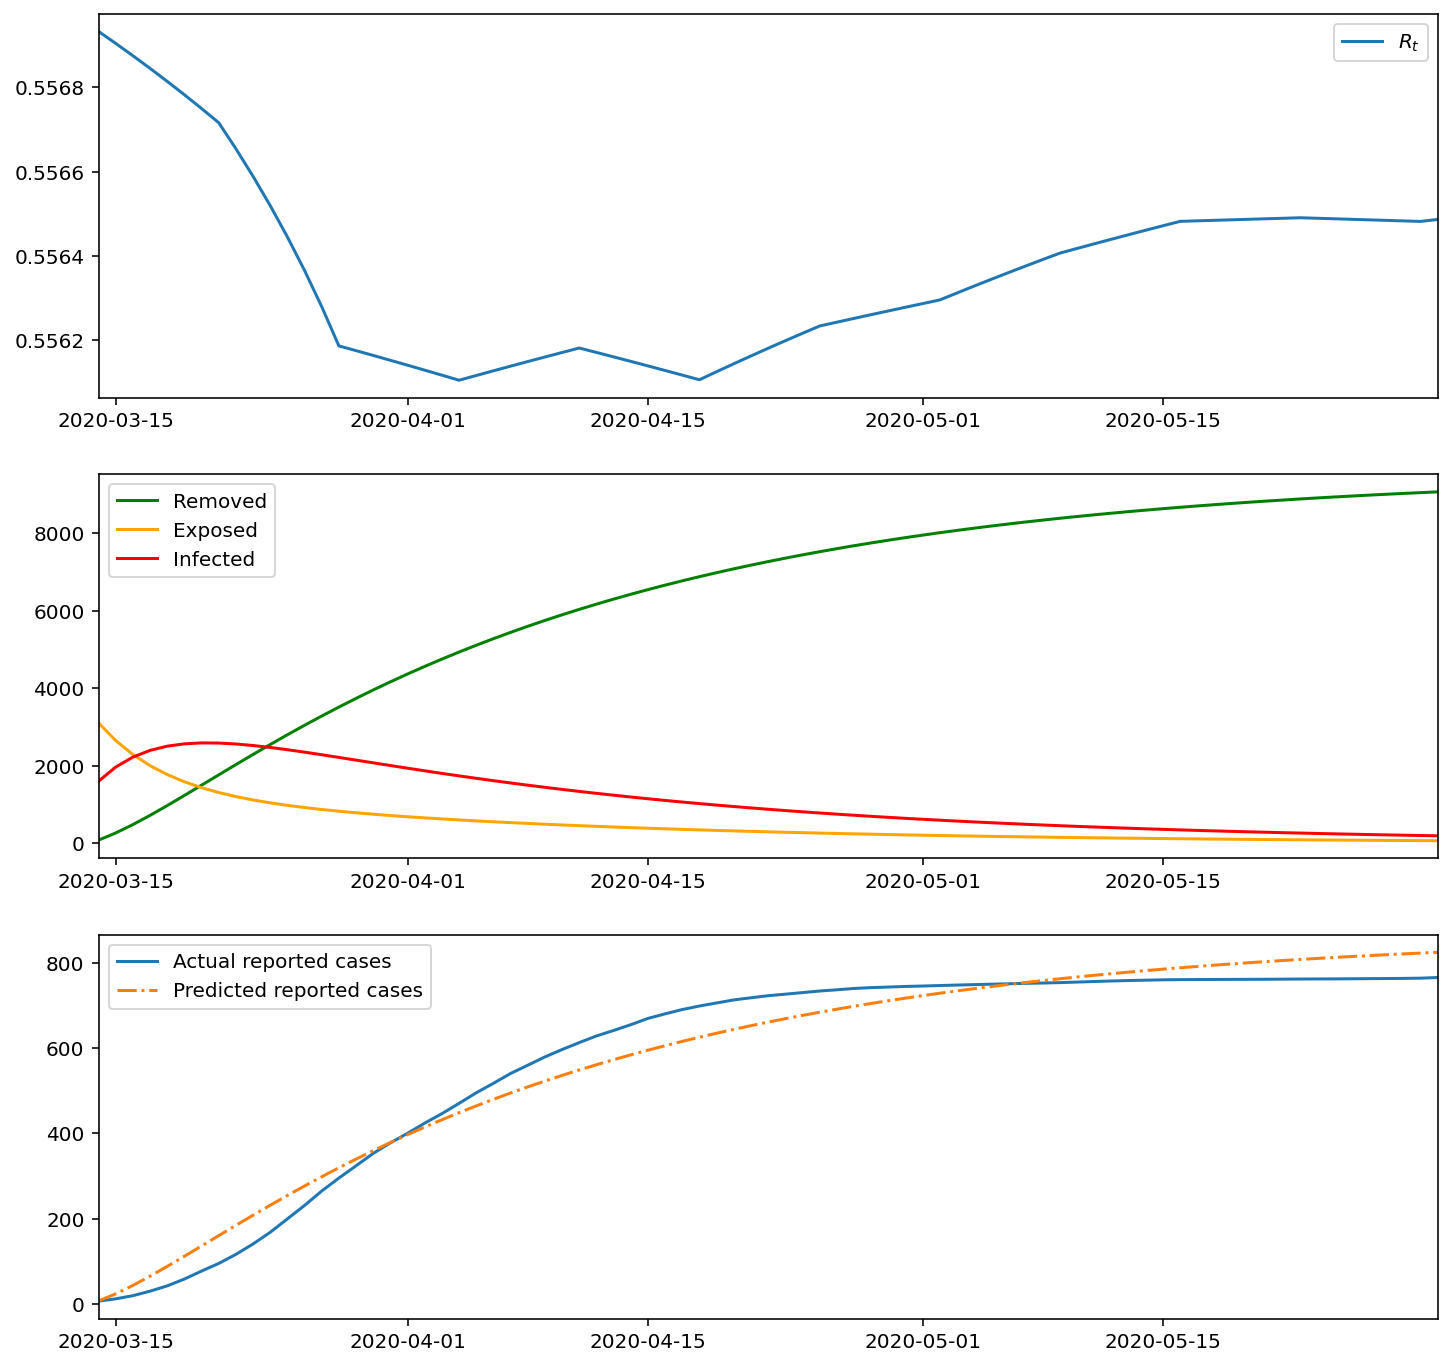


2021-08-11 00:41:17.049999
grid search @ step 3/3 2/3 21/27
training new model:
S0 = None
E0 = 3010.0
I0 = 2020.0
R0 = None
σ = 5.2, γ = None
beta parameter: [1.5, 0.5, 1.5]



/Users/aberke/projects/CSL_Andorra_COVID/env/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Repeated error test failures (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


445.2048918301866 False
S0 = 72884.941137992
E0 = 3998.057229842816
I0 = 40.00163216518114
R0 = 77.0
σ = 5.2, γ = 0.15698404411886974
beta parameter: [0.04782375 0.0458241  0.00466623]

time 0:00:14.341784
discarding fit that came up against bounds

2021-08-11 00:41:31.392267
grid search @ step 3/3 2/3 22/27
training new model:
S0 = None
E0 = 3010.0
I0 = 2020.0
R0 = None
σ = 5.2, γ = None
beta parameter: [1.5, 1.0, 0.5]

560.8173974117888 True
S0 = 72195.28047106505
E0 = 2908.237092526823
I0 = 1819.4824364081223
R0 = 77.0
σ = 5.2, γ = 0.1
beta parameter: [5.55545374e-02 5.45292562e-08 1.60998482e-18]

time 0:00:03.357629

2021-08-11 00:41:34.750854
grid search @ step 3/3 2/3 23/27
training new model:
S0 = None
E0 = 3010.0
I0 = 2020.0
R0 = None
σ = 5.2, γ = None
beta parameter: [1.5, 1.0, 1.0]

13620.116895264364 False
S0 = 76627.85425627975
E0 = 234.82169594648224
I0 = 60.32404777377478
R0 = 77.0
σ = 5.2, γ = 0.23410922162236378
beta parameter: [0.00422949 0.28338663 0.01896471]

time 

464.872964239864 True
S0 = 73431.67688767998
E0 = 3432.9098337107653
I0 = 58.41327860925437
R0 = 77.0
σ = 5.2, γ = 0.19709857907080625
beta parameter: [0.1053332  0.02859148 0.0007665 ]

time 0:00:03.529846
discarding fit that came up against bounds

2021-08-11 00:45:06.638269
grid search @ step 3/3 3/3 17/27
training new model:
S0 = None
E0 = 3010.0
I0 = 3010.0
R0 = None
σ = 5.2, γ = None
beta parameter: [1.0, 1.5, 1.0]

339911.2398001129 False
S0 = 70903.0
E0 = 3010.0
I0 = 3010.0
R0 = 77.0
σ = 5.2, γ = 0.3
beta parameter: [1.  1.5 1. ]

time 0:00:08.182299
discarding fit with R_0 > 6

2021-08-11 00:45:14.821492
grid search @ step 3/3 3/3 18/27
training new model:
S0 = None
E0 = 3010.0
I0 = 3010.0
R0 = None
σ = 5.2, γ = None
beta parameter: [1.0, 1.5, 1.5]

339911.43457861204 False
S0 = 70903.0
E0 = 3010.0
I0 = 3010.0
R0 = 77.0
σ = 5.2, γ = 0.3
beta parameter: [1.  1.5 1.5]

time 0:00:09.527810
discarding fit with R_0 > 6

2021-08-11 00:45:24.350283
grid search @ step 3/3 3/3 19/27
tr

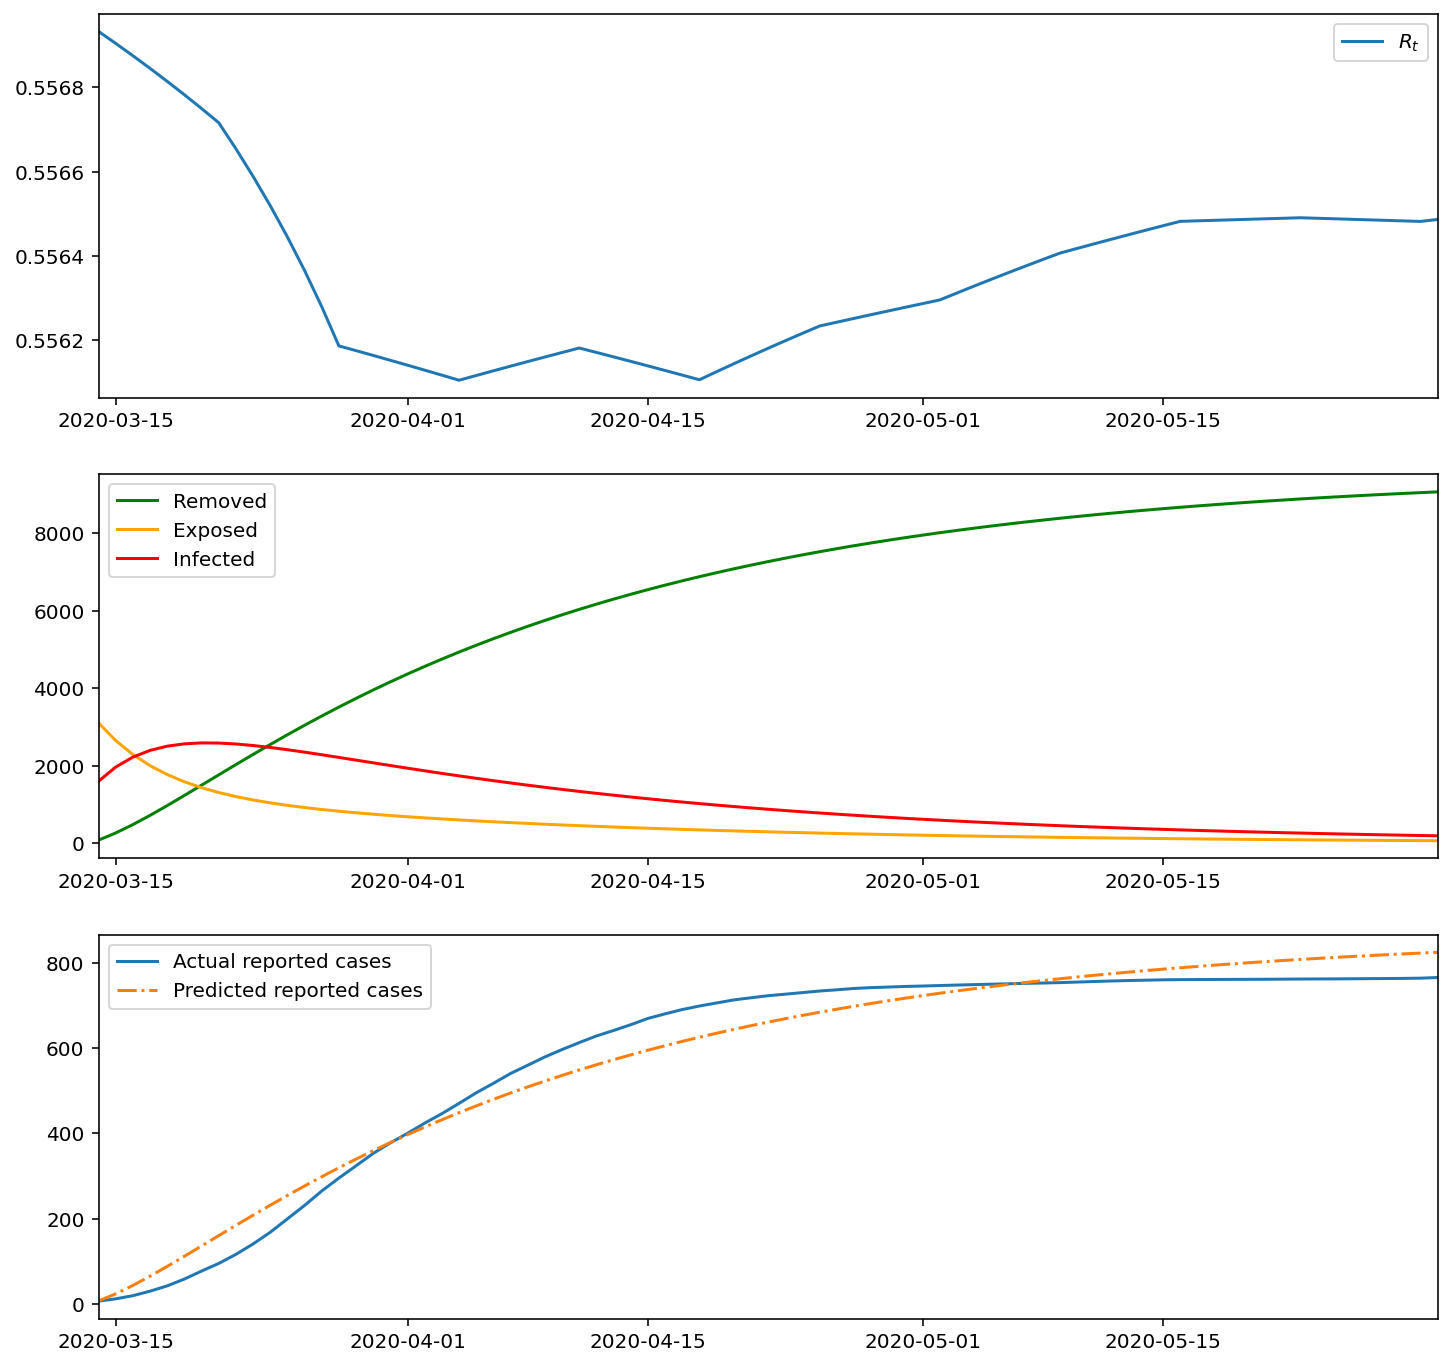

In [242]:
# trips data model trained with spline data and grid search
# model_trips_l7_lag7_train_5_31, ll = get_best_fit_gs(
#     MobilityDataSEIRModel(
#         mobility_data=spline_trips_lag7,
#         N=ANDORRA_POPULATION,
#     ),
#     gridsearch_num=3, 
#     train_dates=train_dates,
# )

In [321]:
model_trips_l7_lag7_train_5_31.to_dict()

{'class': 'MobilityDataSEIRModel',
 'S0': 72220.27351220704,
 'E0': 3105.3743507087893,
 'I0': 1597.3521370841627,
 'R0': 77.0,
 'C0': 7.0,
 'gamma': 0.10300621008390243,
 'beta_param': [0.028934837451035873,
  0.026974291646700815,
  0.003989508639811334],
 'reporting_rate': 0.09090909090909091,
 'ts': 79}

In [325]:
model_trips_l7_lag7_train_5_31 = SEIRModel.from_dict({
    'class': 'MobilityDataSEIRModel',
    'S0': 72220.27351220704,
    'E0': 3105.3743507087893,
    'I0': 1597.3521370841627,
    'R0': 77.0,
    'C0': 7.0,
    'gamma': 0.10300621008390243,
    'beta_param': [0.028934837451035873,
    0.026974291646700815,
    0.003989508639811334],
    'reporting_rate': 0.09090909090909091,
    'mobility_data': total_trips[(14-1-reporting_lag):],
    'ts': 79
})
ll, _success = model_trips_l7_lag7_train_5_31.fit(reported_cases[train_dates[0]:train_dates[1]])
print(ll)
print(model_trips_l7_lag7_train_5_31)

545.0072508568147
S0 = 72220.27351220704
E0 = 3105.3743507087893
I0 = 1597.3521370841627
R0 = 77.0
σ = 5.2, γ = 0.10300621008390243
beta parameter: [0.02893484 0.02697429 0.00398951]



S0 = 72220.27351220704
E0 = 3105.3743507087893
I0 = 1597.3521370841627
R0 = 77.0
σ = 5.2, γ = 0.10300621008390243
beta parameter: [0.02893484 0.02697429 0.00398951]

infectious period ~ 9.71 days

training period: 2020-03-14 - 2020-05-31
79 training days; 70 test days
simulated (deterministic) forecast
1-week (7-day) MAPE = 0.0002
2-week (14-day) MAPE = 0.0030
3-week (21-day) MAPE = 0.0080
4-week (28-day) MAPE = 0.0116
5-week (35-day) MAPE = 0.0144
6-week (42-day) MAPE = 0.0173
7-week (49-day) MAPE = 0.0160
8-week (56-day) MAPE = 0.0154
9-week (63-day) MAPE = 0.0178
10-week (70-day) MAPE = 0.0198


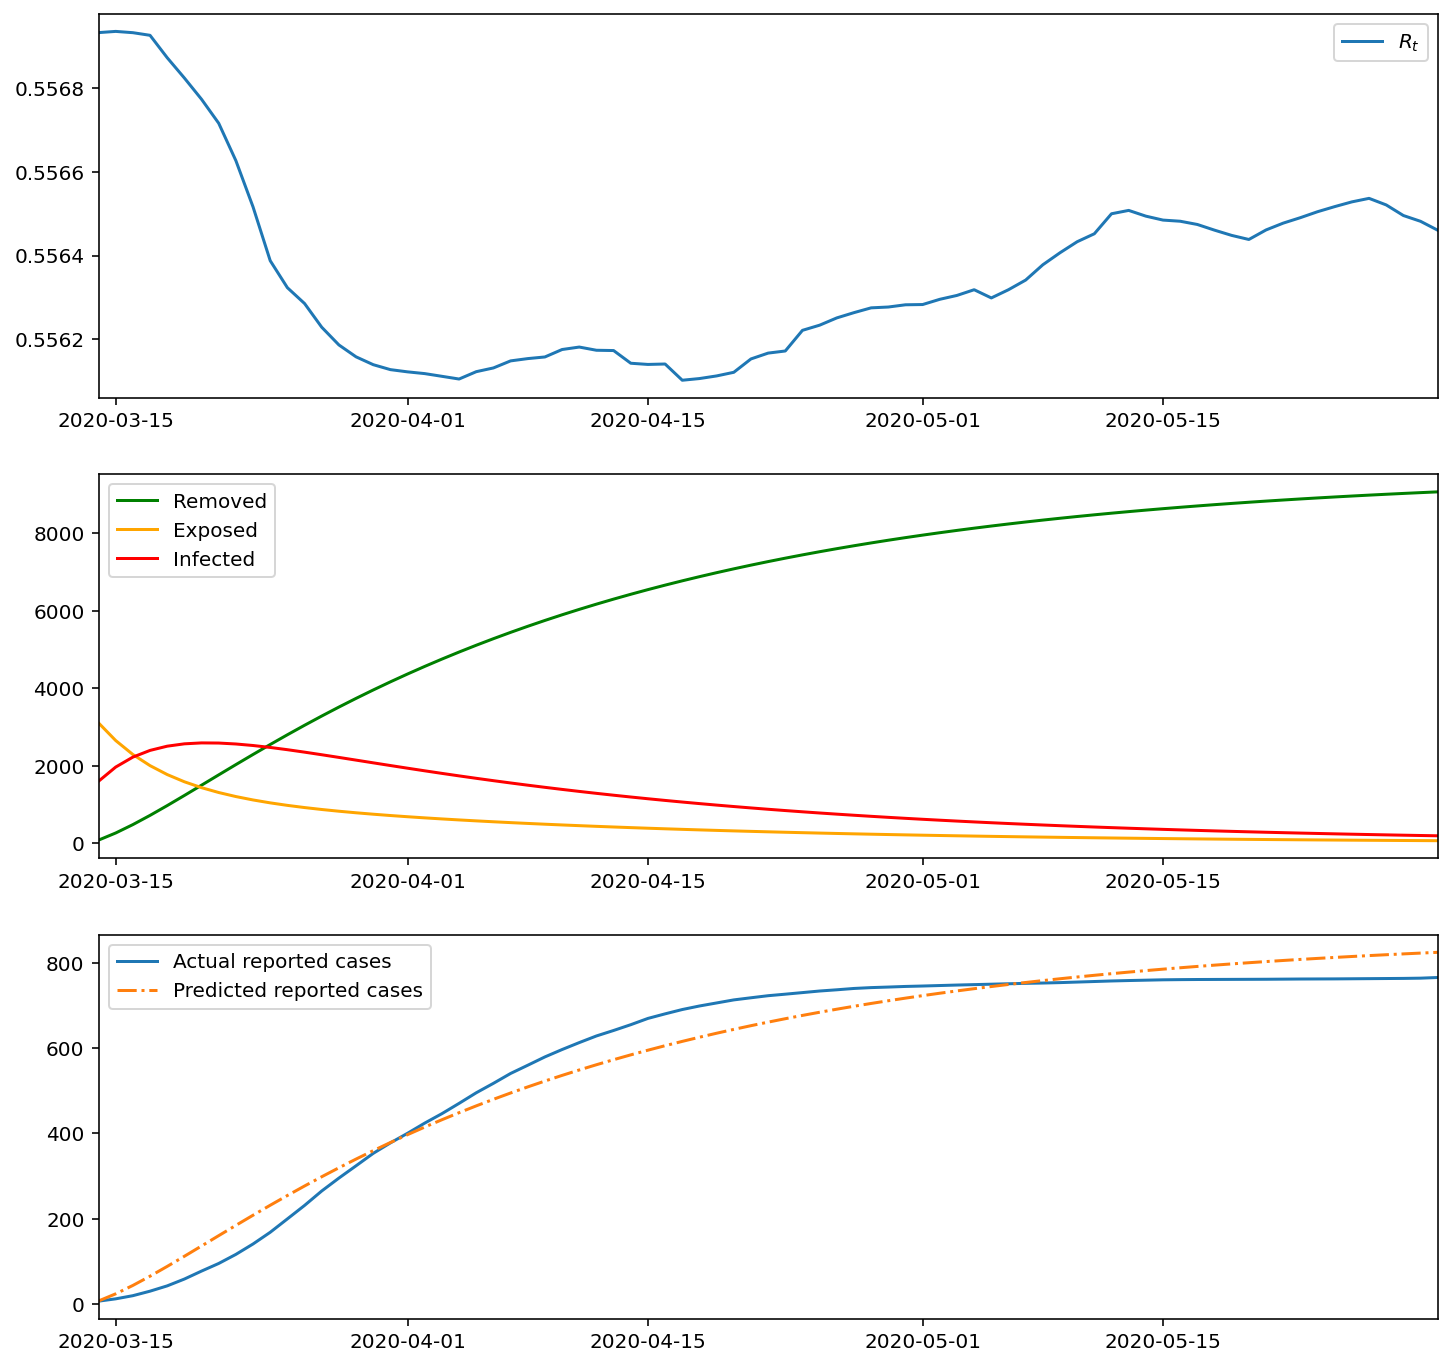

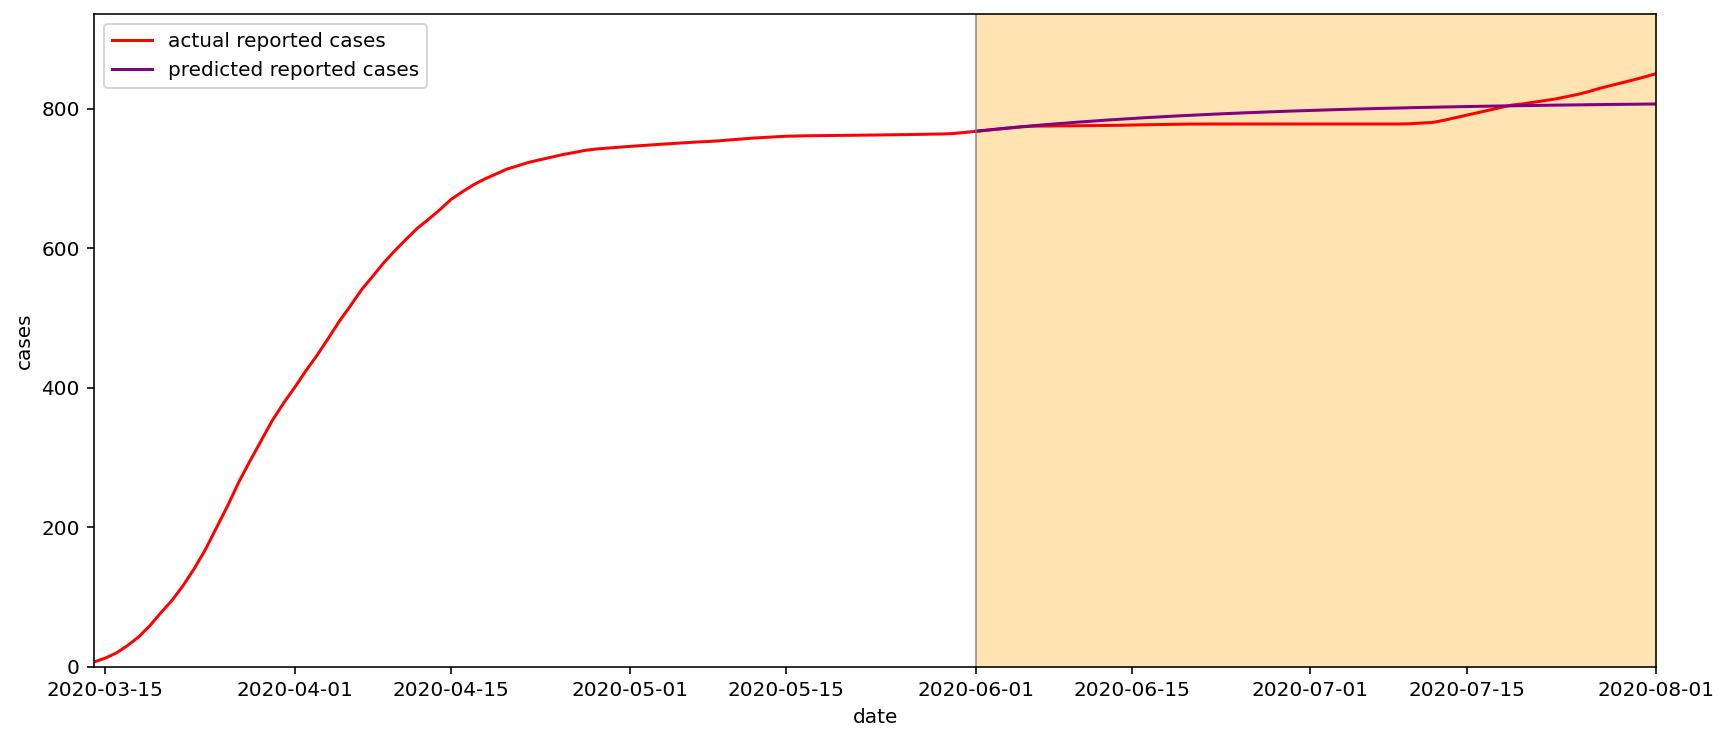

In [327]:
model = model_trips_l7_lag7_train_5_31.copy()
model.plots(reported_cases[train_dates[0]:train_dates[1]])
print(model)
print('infectious period ~ %0.2f days\n' % (1/model.gamma))

train_test_dict_5_31['trips data model'] = get_forecast_results(model, 
                      train_start=train_dates[0],
                      train_end=train_dates[1], 
                      plot_end='2020-07-31')

In [328]:
# trips & entrances data model
# model_trips_entrances_l7_lag7_train_5_31, ll = get_best_fit_gs(
#     MobilityEntrancesDataSEIRModel(
#         mobility_data=spline_trips_lag7,
#         entrances_data=spline_entrances_lag7,
#         N=ANDORRA_POPULATION,
#     ),
#     gridsearch_num=3, 
#     train_dates=train_dates,
# )

In [330]:
model_trips_entrances_l7_lag7_train_5_31.to_dict()

{'class': 'MobilityEntrancesDataSEIRModel',
 'S0': 75093.75947718248,
 'E0': 1261.7956445295204,
 'I0': 567.4448782880113,
 'R0': 77.0,
 'C0': 7.0,
 'gamma': 0.18190157583115124,
 'beta_param': [0.0039126456906451185,
  0.07691121068566352,
  0.007208274846027989,
  2.755926742512145e-06,
  1.3168459787547693],
 'reporting_rate': 0.09090909090909091,
 'ts': 79}

In [331]:
model_trips_entrances_l7_lag7_train_5_31 = SEIRModel.from_dict({
    'class': 'MobilityEntrancesDataSEIRModel',
    'S0': 75093.75947718248,
    'E0': 1261.7956445295204,
    'I0': 567.4448782880113,
    'R0': 77.0,
    'C0': 7.0,
    'gamma': 0.18190157583115124,
    'beta_param': [0.0039126456906451185,
    0.07691121068566352,
    0.007208274846027989,
    2.755926742512145e-06,
    1.3168459787547693],
    'reporting_rate': 0.09090909090909091,
    'ts': 79,
    'mobility_data': total_trips[(14-1-reporting_lag):],
    'entrances_data': entrances[(14-1-reporting_lag):],
})
ll, _success = model_trips_entrances_l7_lag7_train_5_31.fit(reported_cases[train_dates[0]:train_dates[1]])
print(ll)

415.1986044138407


In [332]:
model_trips_entrances_l7_lag7_train_5_31

S0 = 75093.75946875541
E0 = 1261.795639851849
I0 = 567.4448913927462
R0 = 77.0
σ = 5.2, γ = 0.1819015659962106
beta parameter: [3.91260176e-03 7.69111672e-02 7.20822446e-03 2.66675594e-06
 1.31684594e+00]

S0 = 75093.75946875541
E0 = 1261.795639851849
I0 = 567.4448913927462
R0 = 77.0
σ = 5.2, γ = 0.1819015659962106
beta parameter: [3.91260176e-03 7.69111672e-02 7.20822446e-03 2.66675594e-06
 1.31684594e+00]

infectious period ~ 5.50 days
training period: 2020-03-14 - 2020-05-31
79 training days; 70 test days
simulated (deterministic) forecast
1-week (7-day) MAPE = 0.0024
2-week (14-day) MAPE = 0.0019
3-week (21-day) MAPE = 0.0025
4-week (28-day) MAPE = 0.0034
5-week (35-day) MAPE = 0.0052
6-week (42-day) MAPE = 0.0076
7-week (49-day) MAPE = 0.0101
8-week (56-day) MAPE = 0.0108
9-week (63-day) MAPE = 0.0109
10-week (70-day) MAPE = 0.0112


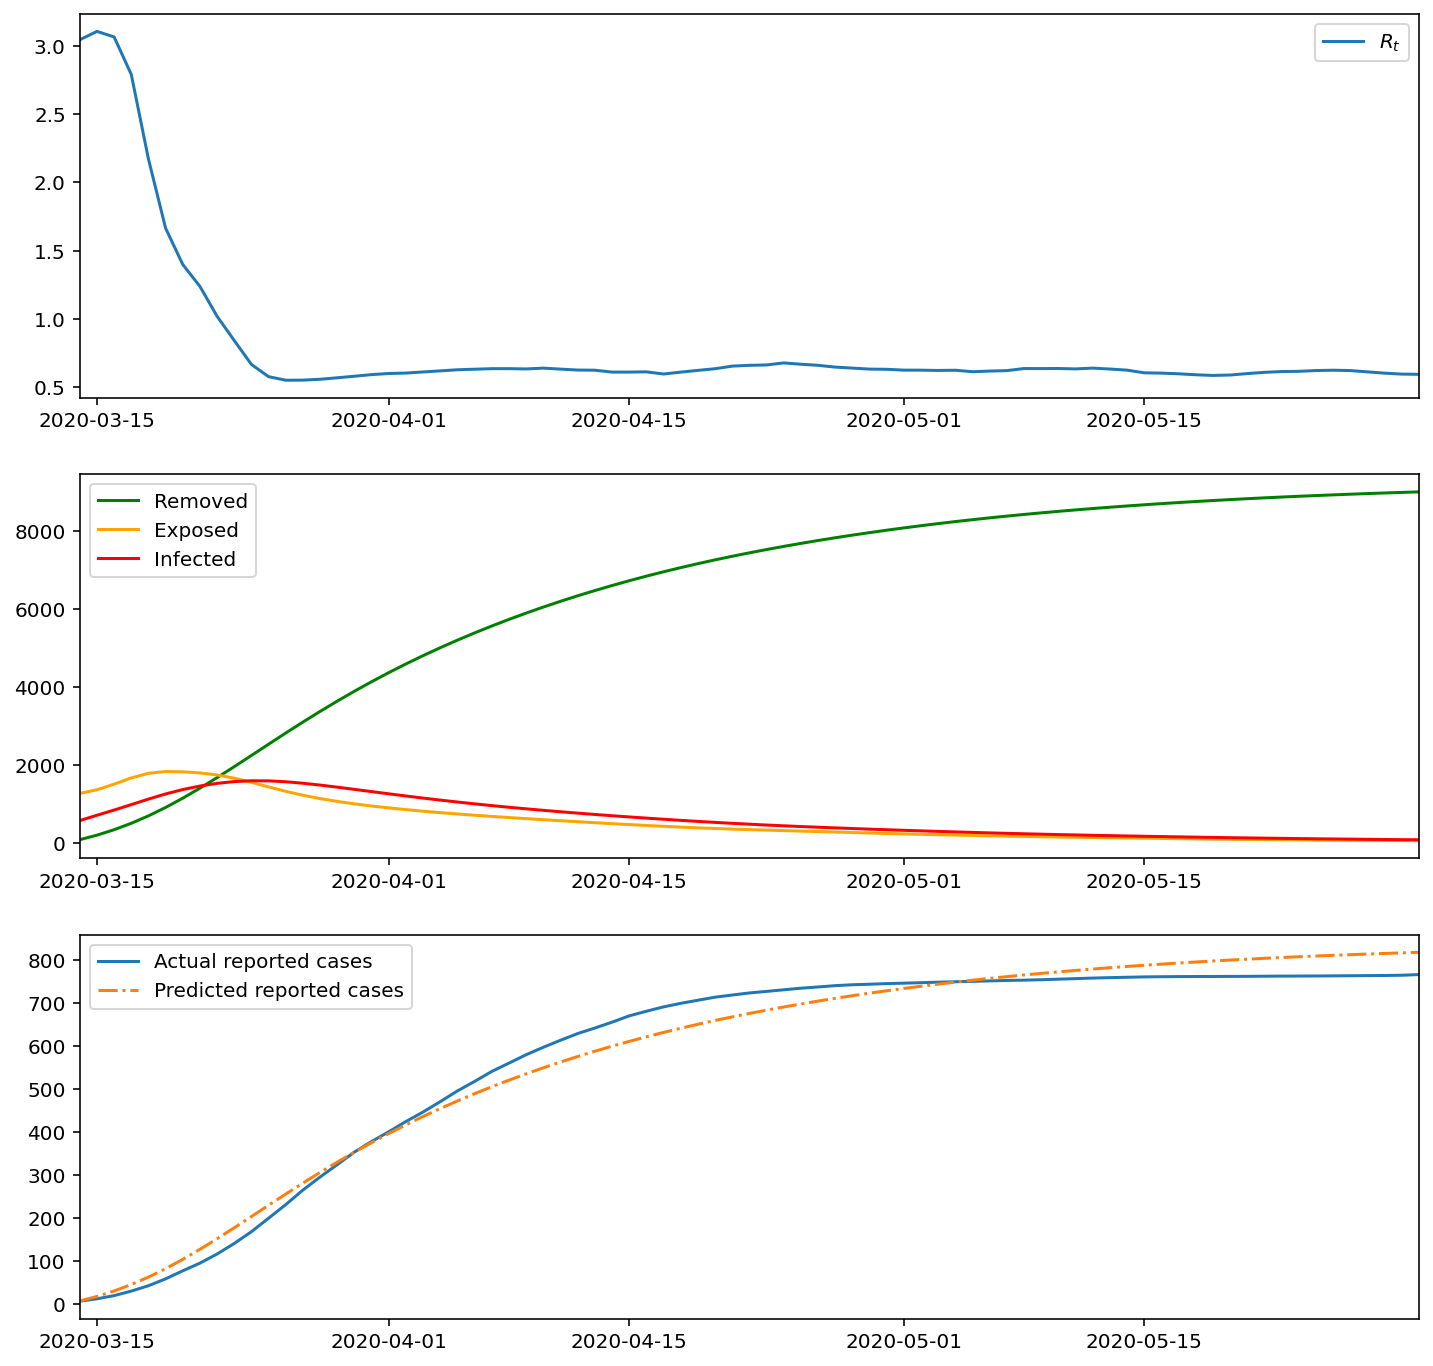

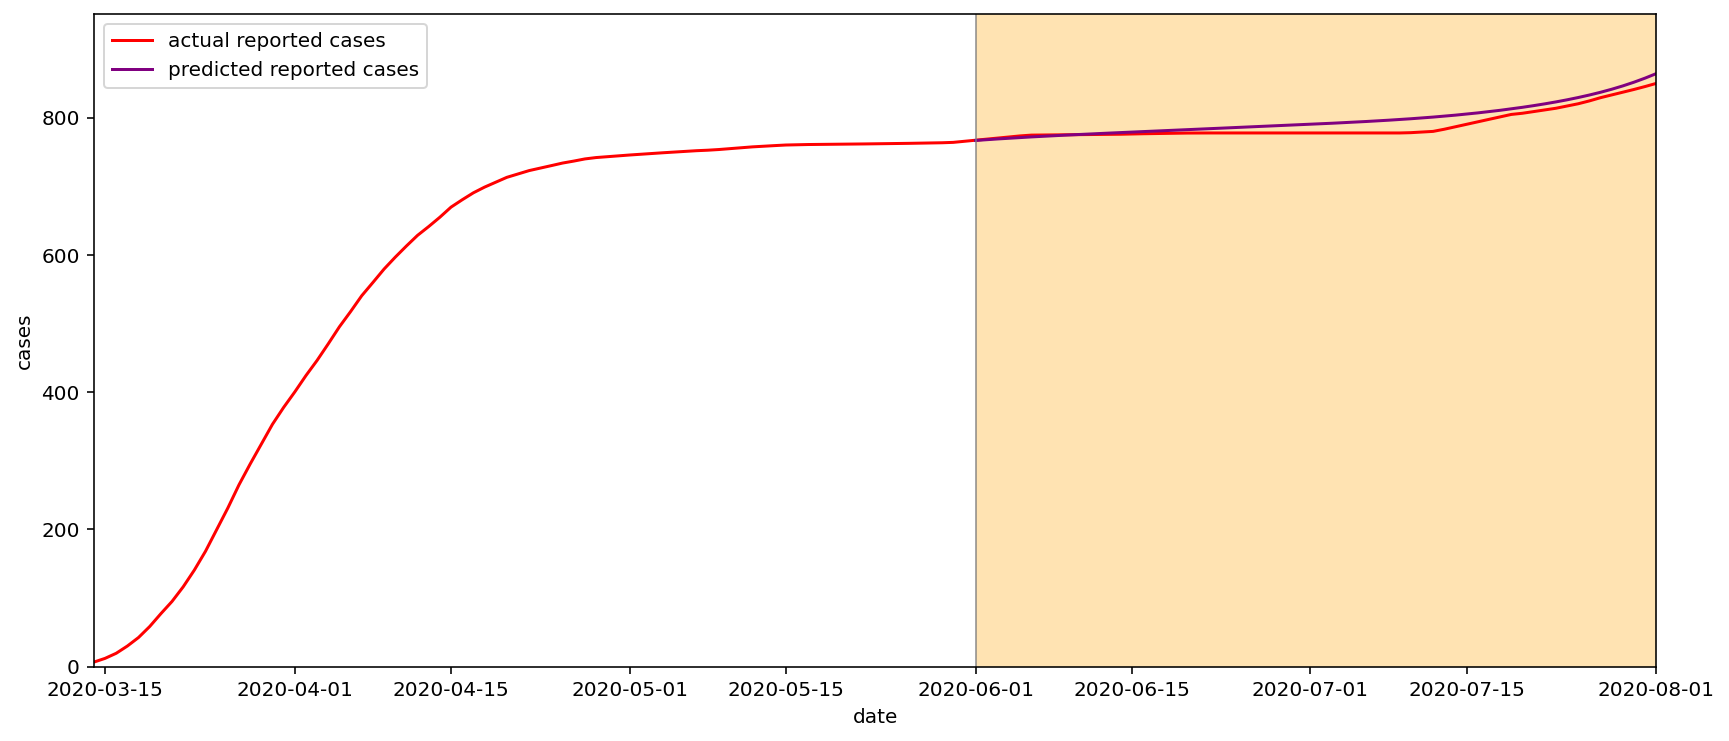

In [454]:
model = model_trips_entrances_l7_lag7_train_5_31.copy()
model.plots(reported_cases[train_dates[0]:train_dates[1]])
print(model)
print('infectious period ~ %0.2f days' % (1/model.gamma))
train_test_dict_5_31['trips & entrances data model'] = get_forecast_results(model, 
                      train_start=train_dates[0],
                      train_end=train_dates[1], 
                      plot_end='2020-07-31')

In [455]:
pd.DataFrame(train_test_dict_5_31).set_index('forecasting weeks')

baseline model  trips data model  \
forecasting weeks                                     
1                        0.000280          0.000193   
2                        0.001952          0.003013   
3                        0.006513          0.008011   
4                        0.009723          0.011619   
5                        0.012162          0.014422   
6                        0.014725          0.017317   
7                        0.013555          0.016008   
8                        0.013920          0.015446   
9                        0.015904          0.017803   
10                       0.017971          0.019803   

                   trips & entrances data model  
forecasting weeks                                
1                                      0.002424  
2                                      0.001909  
3                                      0.002548  
4                                      0.003443  
5                                      0.005156  
6                                      0.007615  
7                                      0.010105  
8                                      0.010780  
9                                      0.010911  
10                                     0.011215

## Counterfactuals

What if Andorra had not imposed a lockdown, which caused reduced mobility?

What if neighboring countries had not restricted their borders, which caused a drop in entrances?

Overall, what if the population mobility (measured in total trips) and entrances, had not dropped in March?

What would have been the counterfactual scenario from March - May -- i.e. the period over which the models were fit?

Partial confinement began March 13.

We estimate counterfactual mobility and entrances metrics by using the true metrics up to March 13, and then keeping the metrics constant at the May 13 levels.

We estimate counterfactual case reports by using the previously fit model, and simulating the estimated reported cases under the counterfactual scenario.

i.e. we use the model parameters that were fit with the true trips and entrances metrics, and replace the model's metrics with the counterfactual metrics.

We then simulate over the same study period that was used for fitting the original model.

#### Counterfactual metrics

In [396]:
plot_idx = total_trips_df[:'2020-05-31'].index
transition_idx = 12
transition_date = plot_idx[transition_idx]
transition_date

Timestamp('2020-03-13 00:00:00')

In [405]:
counterfactual_total_trips = pd.Series(
    data=(total_trips[:transition_idx].to_list() + [total_trips[transition_idx]] * len(plot_idx[transition_idx:])),
    index=plot_idx,       
)
counterfactual_entrances = pd.Series(
    data=(entrances[:transition_idx].to_list() + [entrances[transition_idx]] * len(plot_idx[transition_idx:])),
    index=plot_idx,       
)
# counterfactual_entrances

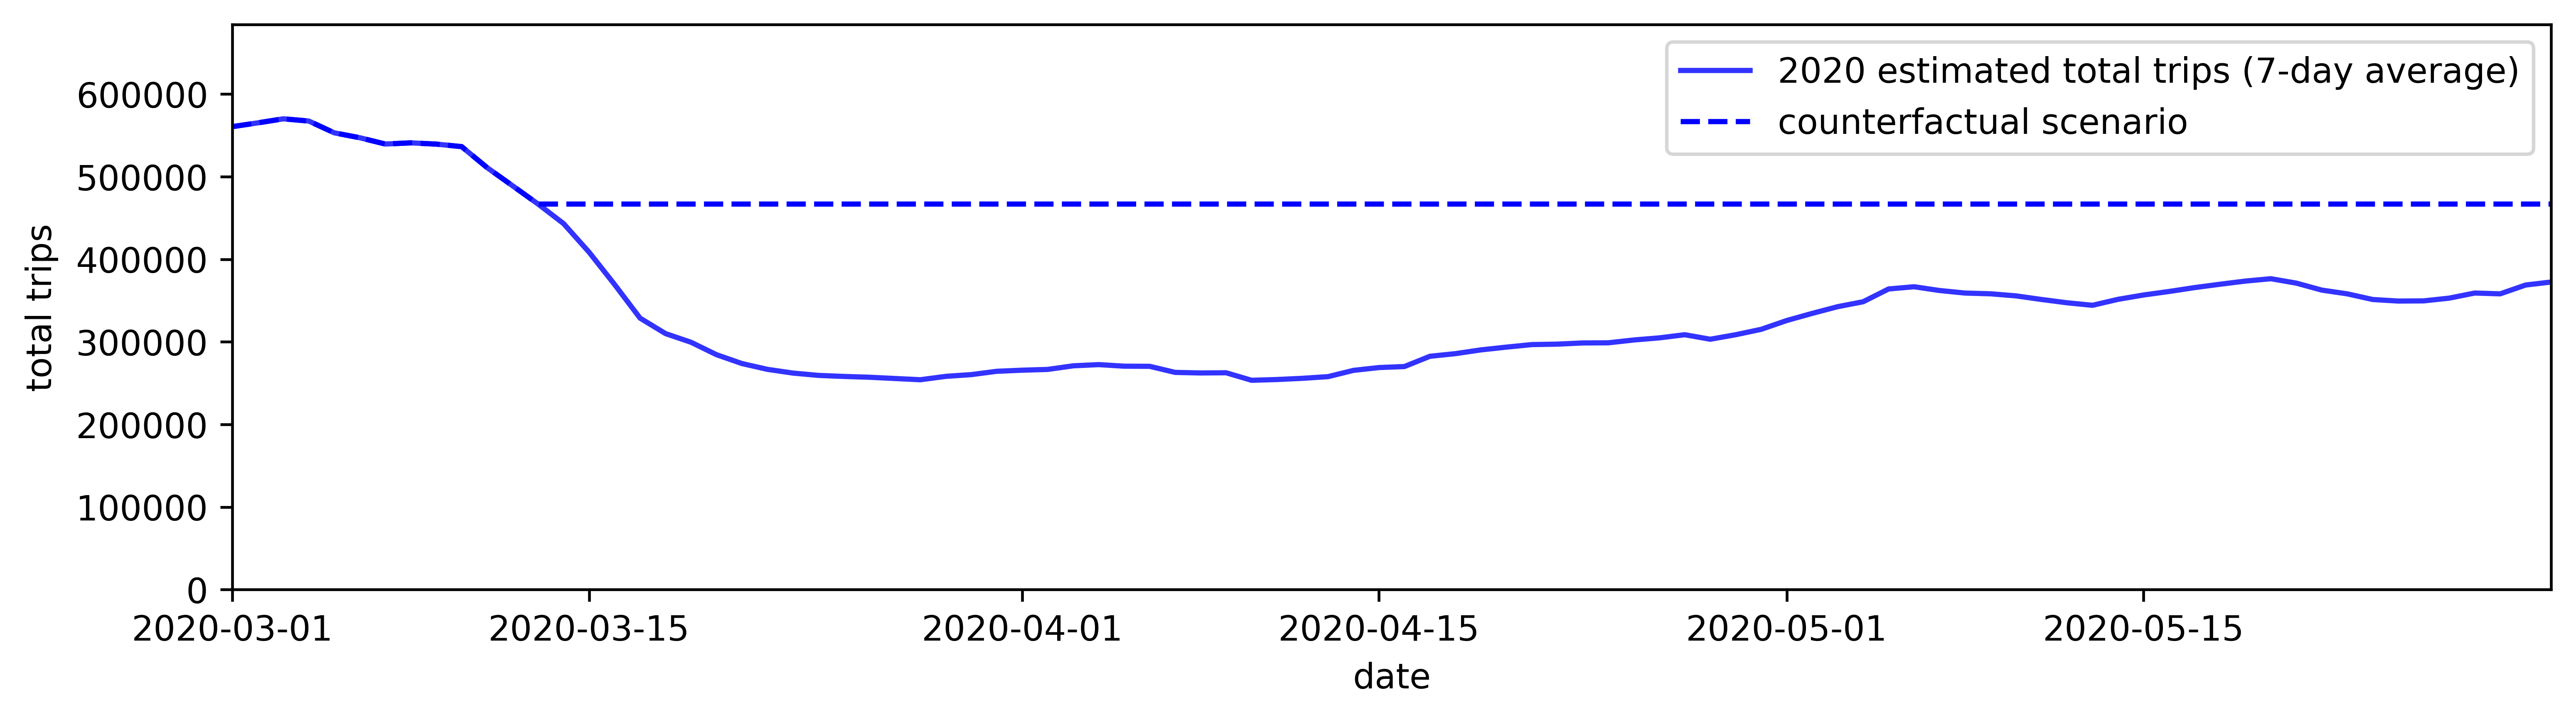

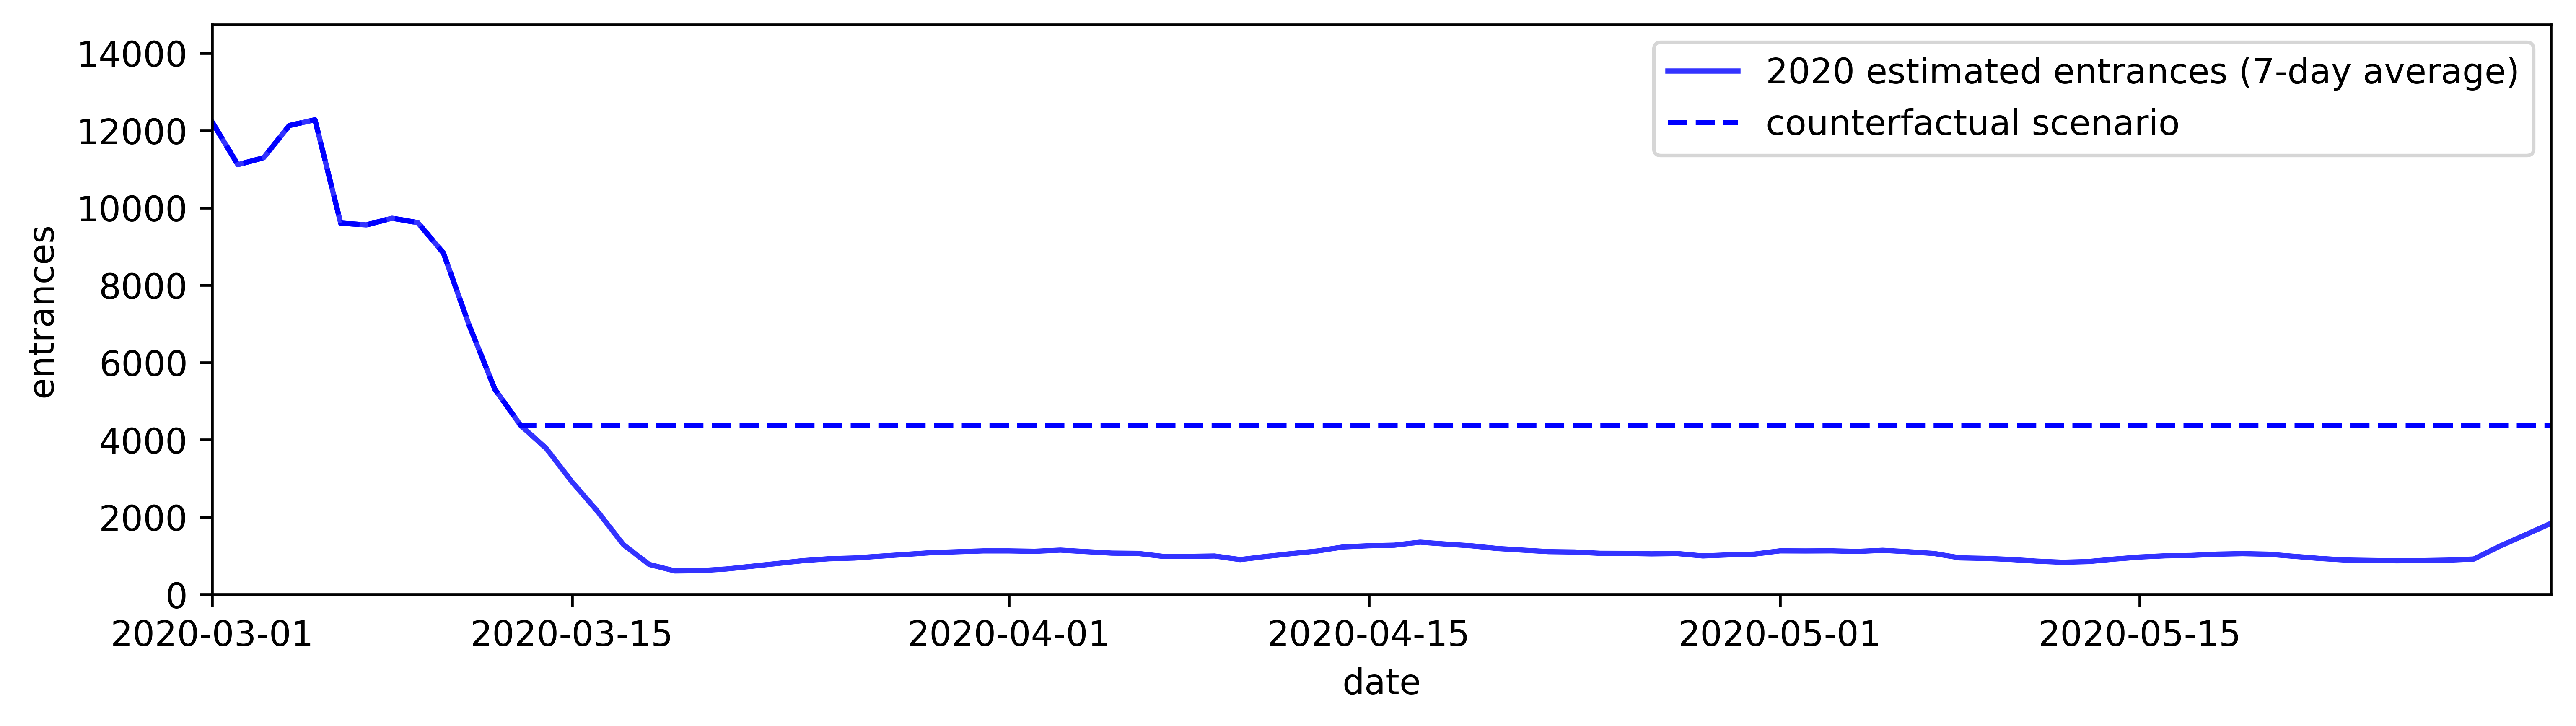

In [445]:
for m, df, counterfactual in [
    ('total trips', total_trips_df, counterfactual_total_trips), 
    ('entrances', entrances_df, counterfactual_entrances),
]:
    fig, ax = plt.subplots(1, figsize=(12, 3), dpi=300)
    # ax.plot(plot_idx, df.loc[plot_idx][m], '. ', label=m, color='blue')
    ax.plot(plot_idx, df.loc[plot_idx][m+transform_suffix], '-',
            color='blue', alpha=0.8, label='2020 estimated %s (7-day average)'%m)
    # draw a vertical line at the transition date
    # ax.axvline(transition_date, color='gray', ls='-')
    # plot counterfactual
    ax.plot(plot_idx, counterfactual, '--', 
            color='blue', alpha=1, label='counterfactual scenario')
    ax.set_xlim(plot_idx.min(), plot_idx.max())
    ax.set_ylim(0, df.loc[plot_idx][m+transform_suffix].max()*(1.2))
    ax.set_ylabel(m, labelpad=5)
    ax.set_xlabel('date')
    ax.legend()
    plt.show()

#### Counterfactual simulation

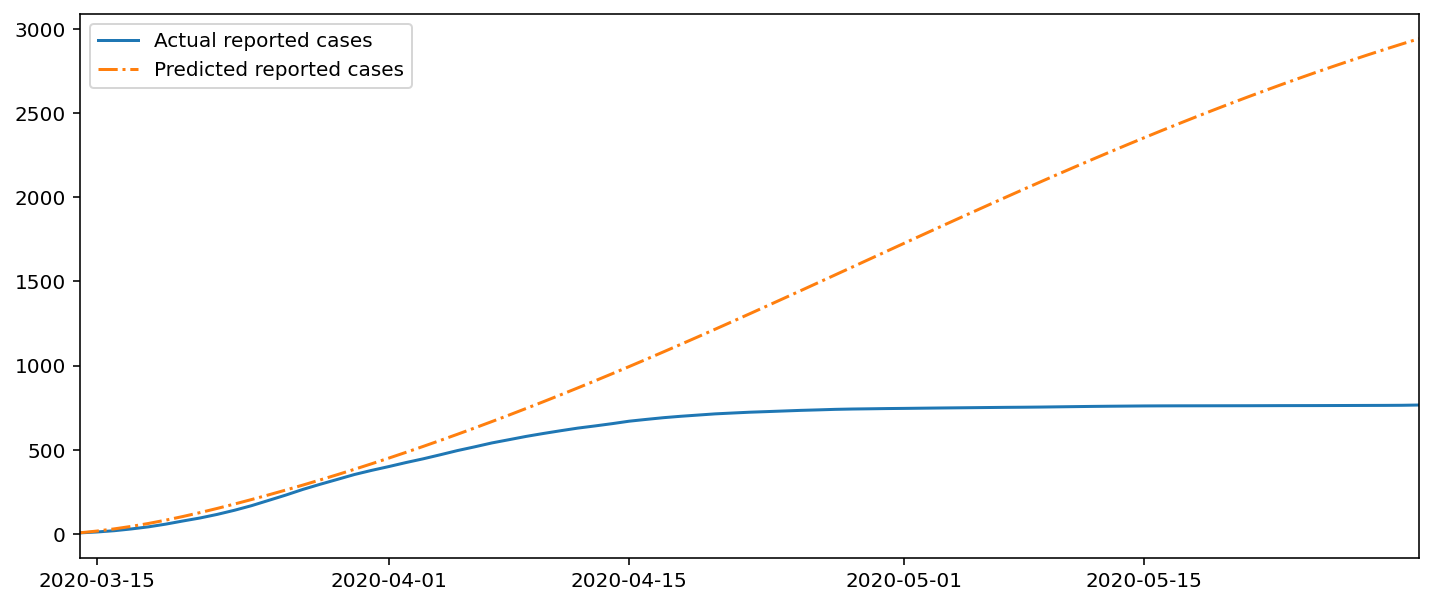

In [479]:
counterfactual_model = model_trips_entrances_l7_lag7_train_5_31.copy()
counterfactual_model.mobility_data = counterfactual_total_trips[(14-1-reporting_lag):]
counterfactual_model.entrances_data = counterfactual_entrances[(14-1-reporting_lag):]
# run simulation with the new model over ts days
ts = len(reported_cases[train_dates[0]:train_dates[1]])
S,E,I,R,C = counterfactual_model.simulate_deterministic(ts)
counterfactual_model.S = S
counterfactual_model.E = E
counterfactual_model.I = I
counterfactual_model.R = R
counterfactual_model.C = C
ax = counterfactual_model.plot_actual_vs_predicted(reported_cases[train_dates[0]:train_dates[1]])

In [477]:
# Quantify the difference
print('Cumulative actual reported cases up to %s:'%train_dates[1])
print('%0.1f'%reported_cases[train_dates[1]])
print('Cumulative predicted reported cases up to %s under counterfactual scenario:'%train_dates[1])
print('%0.1f'%counterfactual_model.C[-1])
print('difference: ~%s additional reported cases'%round(counterfactual_model.C[-1] - reported_cases[train_dates[1]]))

Cumulative actual reported cases up to 2020-05-31:
765.9
Cumulative predicted reported cases up to 2020-05-31 under counterfactual scenario:
2941.1
difference: ~2175 additional reported cases


## Model estimation robustness checks

Train/test the models on another set of training and testing periods.

### Training period: 2020-03-14 - 2020-05-14


In [335]:
train_test_dict_5_14 = copy.deepcopy(default_train_test_dict)
pd.DataFrame(train_test_dict_5_14).set_index('forecasting weeks')

baseline model  trips data model  \
forecasting weeks                                     
1                             NaN               NaN   
2                             NaN               NaN   
3                             NaN               NaN   
4                             NaN               NaN   
5                             NaN               NaN   
6                             NaN               NaN   
7                             NaN               NaN   
8                             NaN               NaN   
9                             NaN               NaN   
10                            NaN               NaN   

                   trips & entrances data model  
forecasting weeks                                
1                                           NaN  
2                                           NaN  
3                                           NaN  
4                                           NaN  
5                                           NaN  
6                                           NaN  
7                                           NaN  
8                                           NaN  
9                                           NaN  
10                                          NaN

In [336]:
train_dates = train_dates_5_14

62 training days: 2020-03-14 - 2020-05-14
gridsearch_E0 [1030. 2020. 3010.]
gridsearch_I0 [1030. 2020. 3010.]
gridsearch_betas [0.1875 0.325  0.4625]

2021-08-13 12:23:40.008799
grid search @ step 1/3 1/3 1/3
training new model:
SEIR model (constant beta)
S0 = None
E0 = 1030.0
I0 = 1030.0
R0 = None
σ = 5.2, γ = None
beta parameter: 0.1875

476.2675068770227 True
SEIR model (constant beta)
S0 = 72658.63669380204
E0 = 2121.930536416669
I0 = 2142.4327697813014
R0 = 77.0
σ = 5.2, γ = 0.1
beta parameter: [0.06888837]

time 0:00:00.385159
****** new best fit LL value: 476.2675068770227 ******


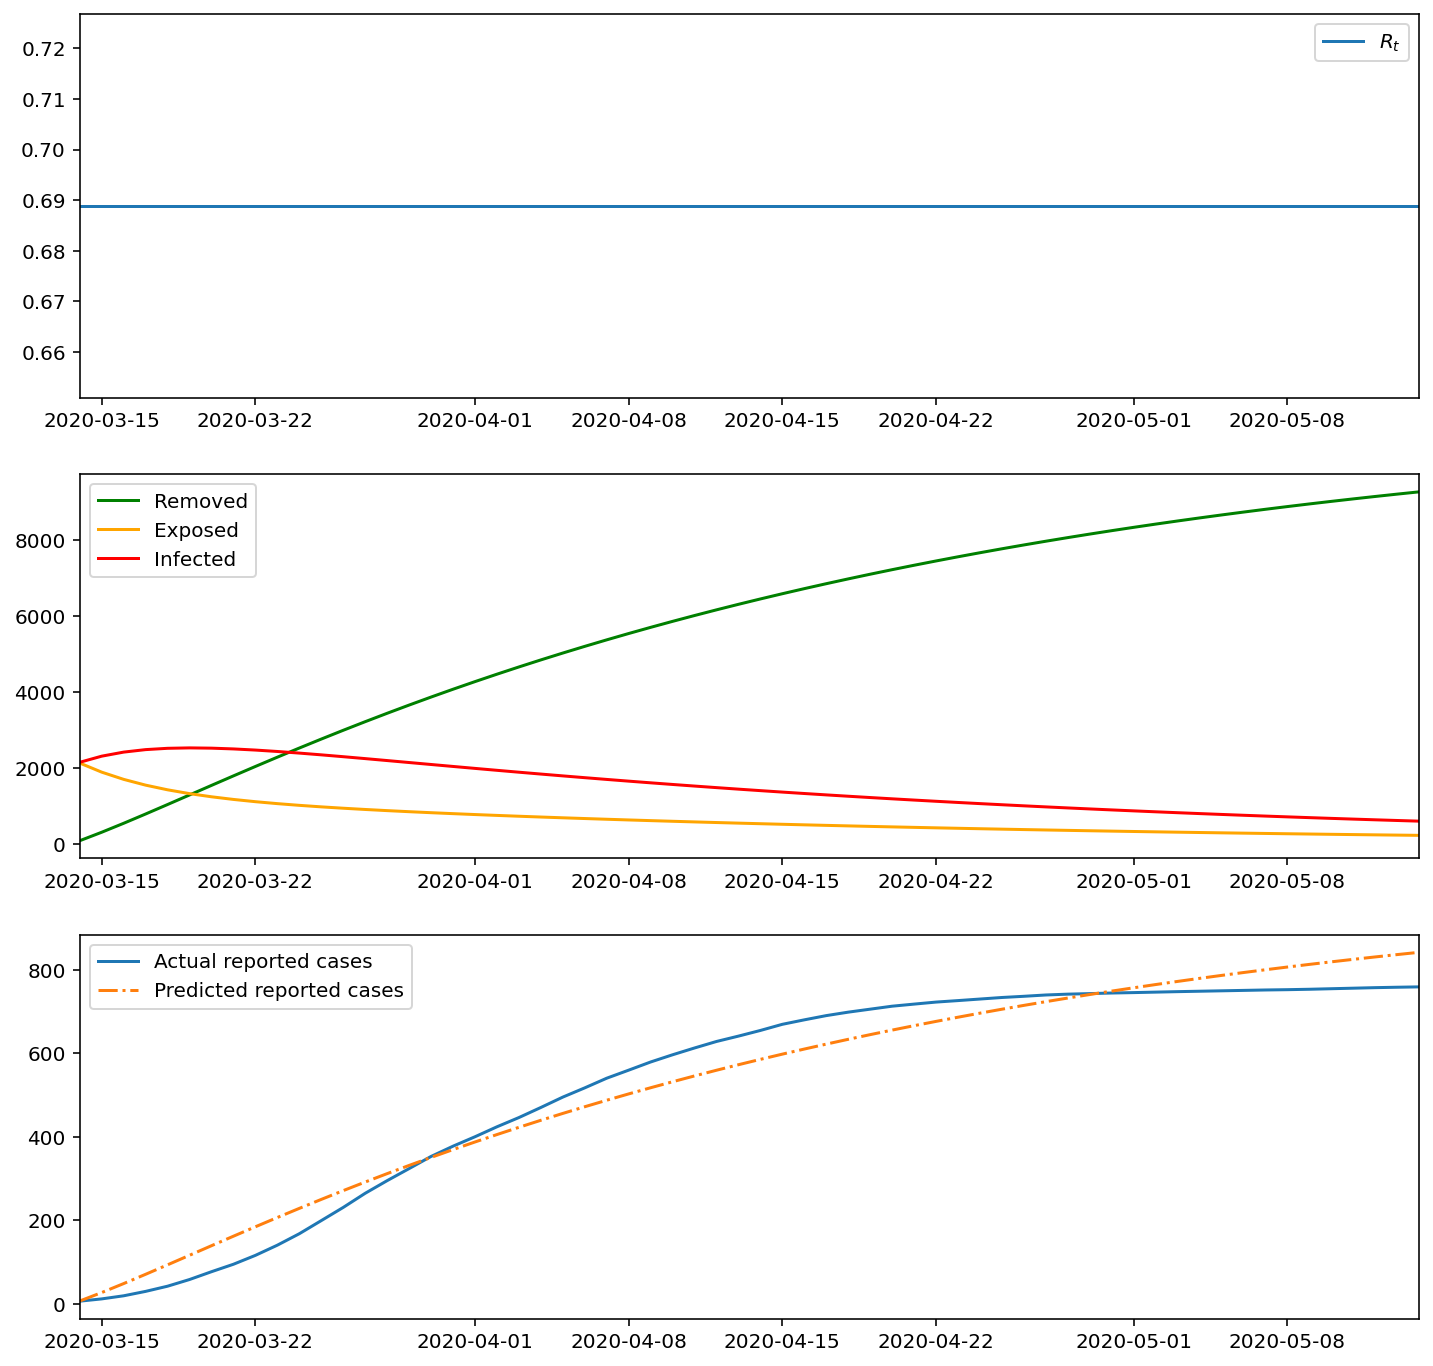


2021-08-13 12:23:41.059605
grid search @ step 1/3 1/3 2/3
training new model:
SEIR model (constant beta)
S0 = None
E0 = 1030.0
I0 = 1030.0
R0 = None
σ = 5.2, γ = None
beta parameter: 0.325

482.26127644845644 True
SEIR model (constant beta)
S0 = 72701.96033841812
E0 = 2019.5360542491785
I0 = 2201.503607332686
R0 = 77.0
σ = 5.2, γ = 0.1
beta parameter: [0.06970334]

time 0:00:00.488192

2021-08-13 12:23:41.547893
grid search @ step 1/3 1/3 3/3
training new model:
SEIR model (constant beta)
S0 = None
E0 = 1030.0
I0 = 1030.0
R0 = None
σ = 5.2, γ = None
beta parameter: 0.4625

486.35048693188963 True
SEIR model (constant beta)
S0 = 72729.83512502261
E0 = 1951.1832776645185
I0 = 2241.981597312871
R0 = 77.0
σ = 5.2, γ = 0.1
beta parameter: [0.07021898]

time 0:00:00.502168

2021-08-13 12:23:42.050311
grid search @ step 1/3 2/3 1/3
training new model:
SEIR model (constant beta)
S0 = None
E0 = 1030.0
I0 = 2020.0
R0 = None
σ = 5.2, γ = None
beta parameter: 0.1875

716.7015128389781 True
SEIR m

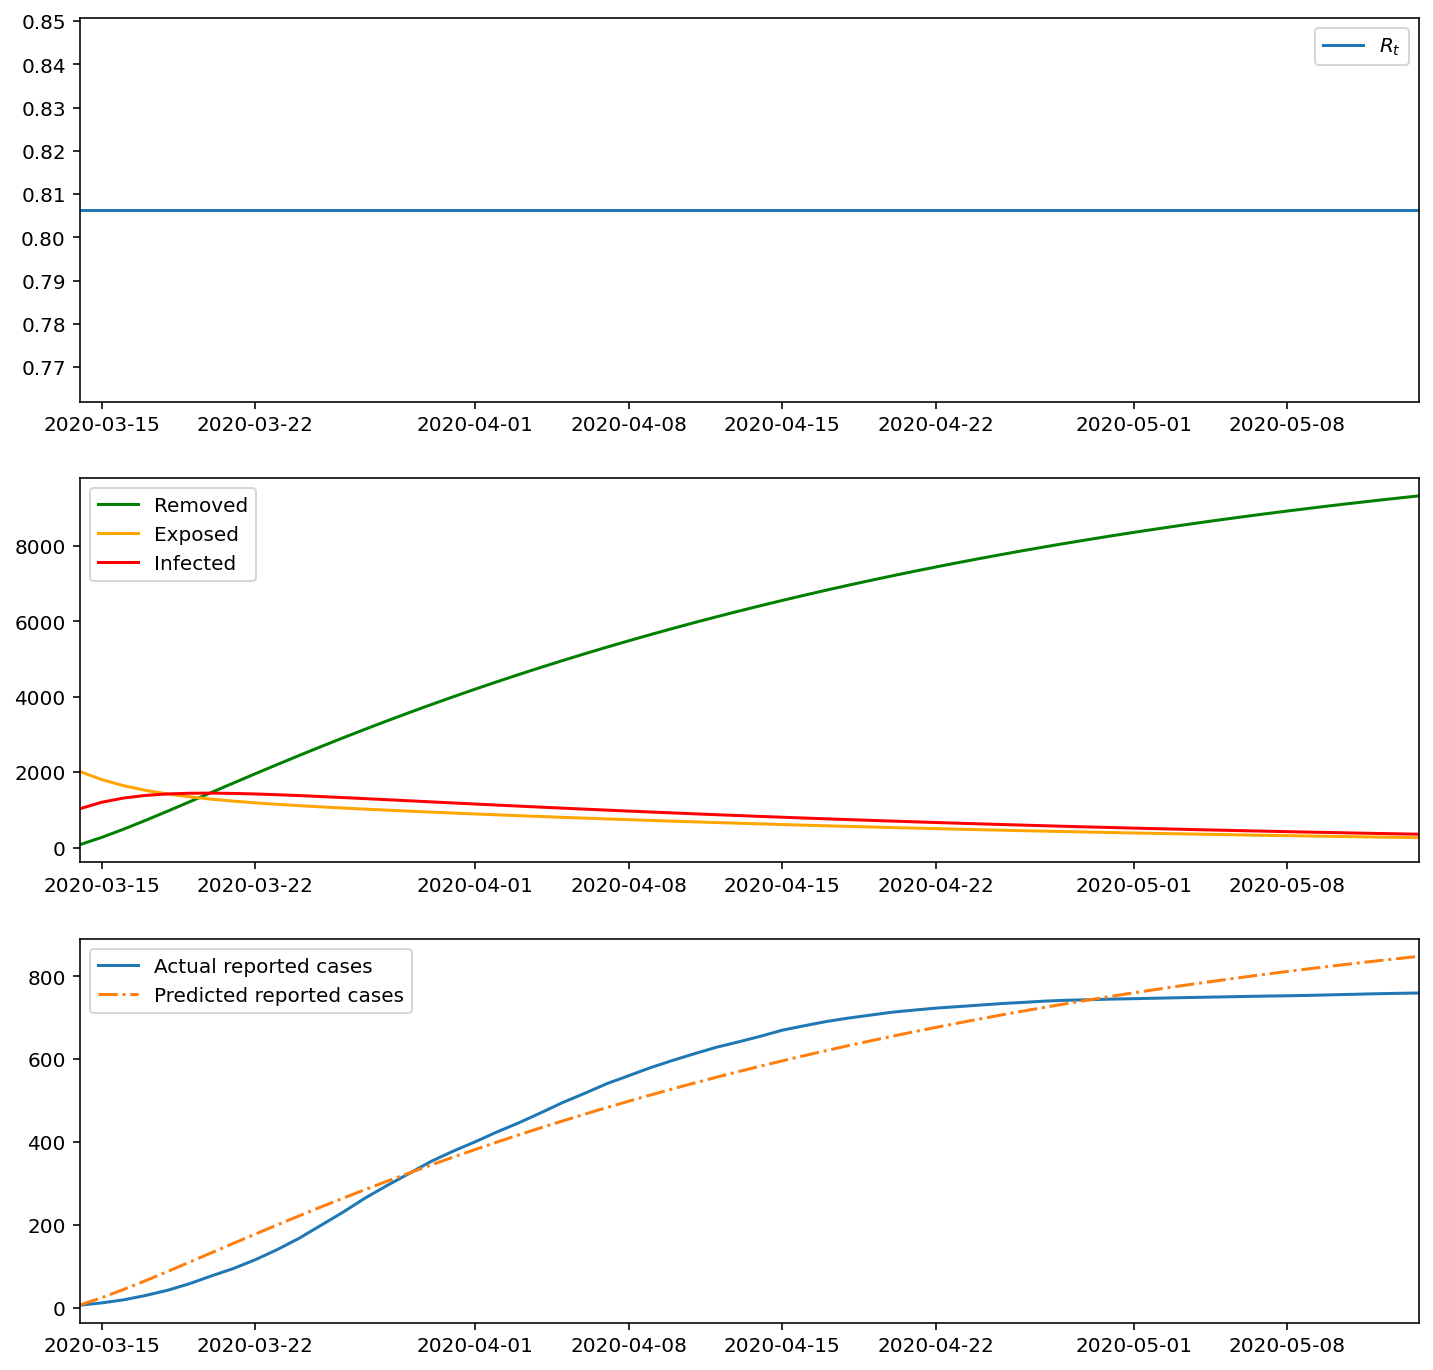


2021-08-13 12:23:44.623735
grid search @ step 2/3 1/3 2/3
training new model:
SEIR model (constant beta)
S0 = None
E0 = 2020.0
I0 = 1030.0
R0 = None
σ = 5.2, γ = None
beta parameter: 0.325

460.19649663285077 True
SEIR model (constant beta)
S0 = 73876.0371437505
E0 = 2018.6162848156628
I0 = 1028.3465714338345
R0 = 77.0
σ = 5.2, γ = 0.17316494751146408
beta parameter: [0.1396911]

time 0:00:00.141441

2021-08-13 12:23:44.765276
grid search @ step 2/3 1/3 3/3
training new model:
SEIR model (constant beta)
S0 = None
E0 = 2020.0
I0 = 1030.0
R0 = None
σ = 5.2, γ = None
beta parameter: 0.4625

446.7901822226822 True
SEIR model (constant beta)
S0 = 72523.66481939041
E0 = 2600.5080054551627
I0 = 1798.8271751544214
R0 = 77.0
σ = 5.2, γ = 0.1
beta parameter: [0.06668673]

time 0:00:00.478951
****** new best fit LL value: 446.7901822226822 ******


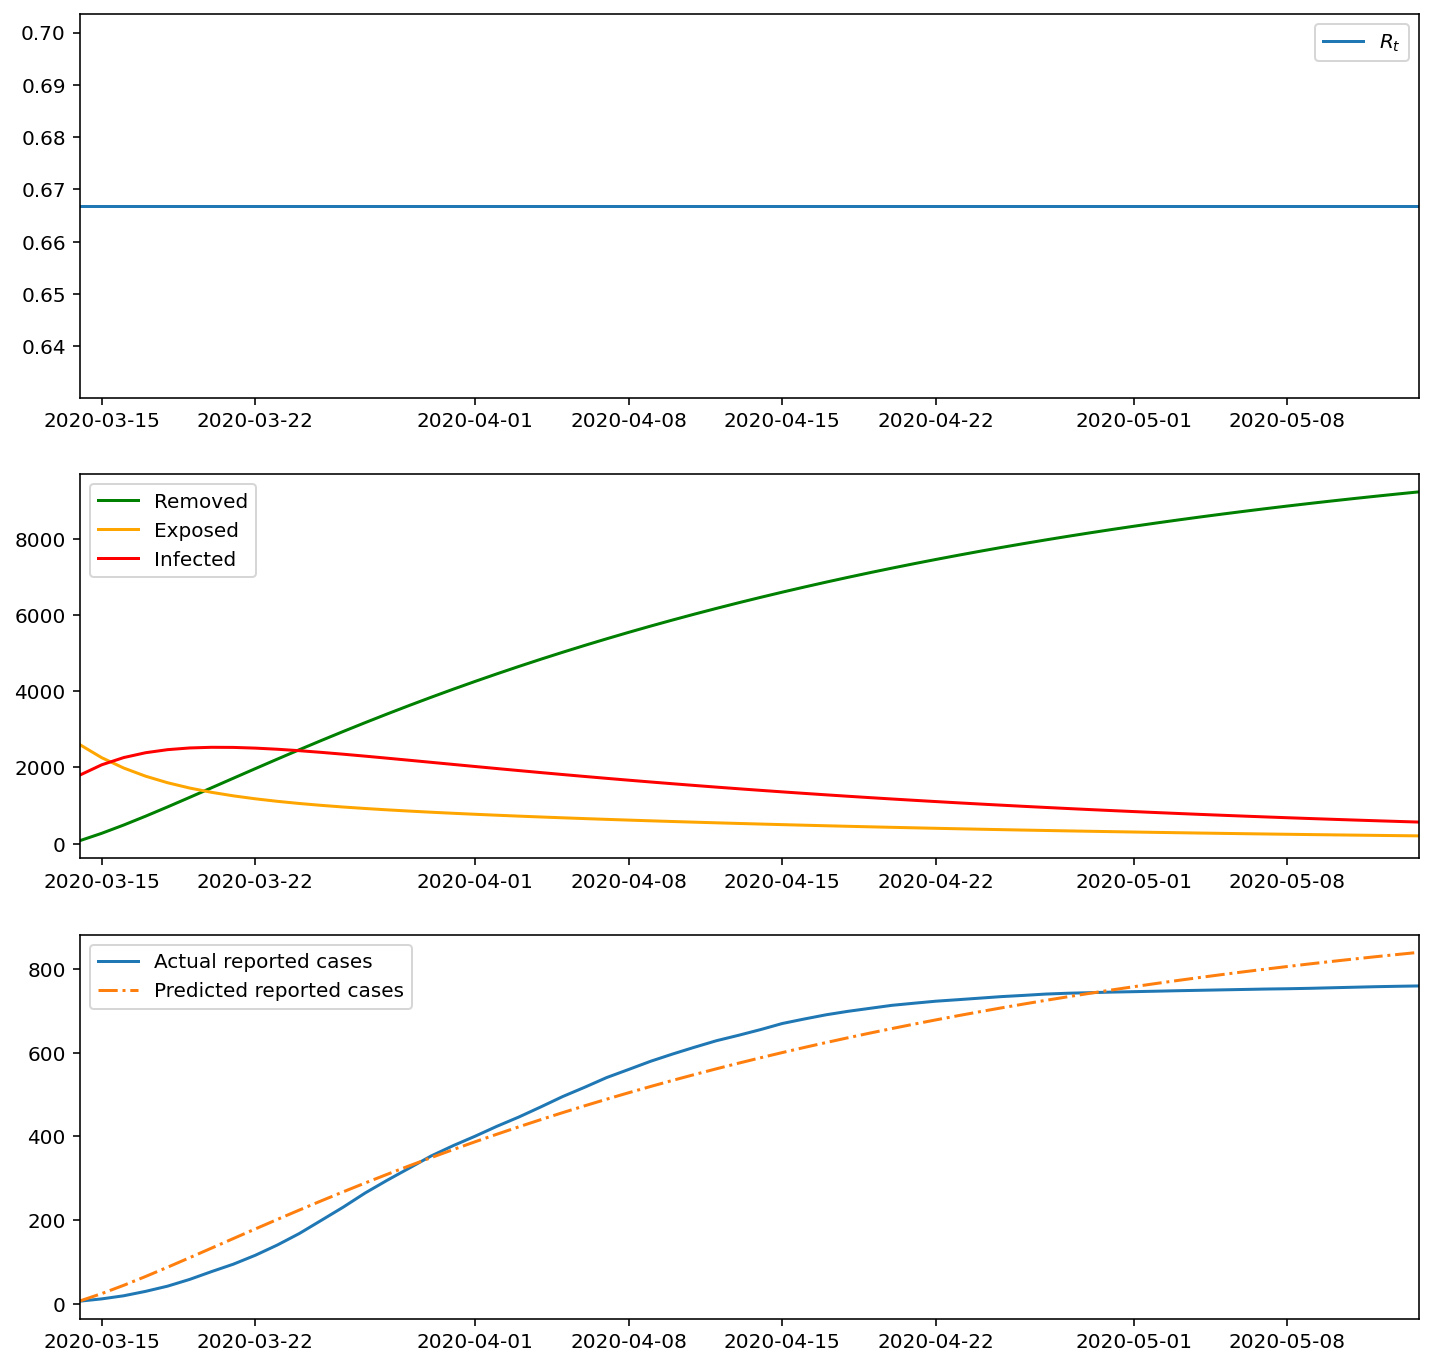


2021-08-13 12:23:45.923678
grid search @ step 2/3 2/3 1/3
training new model:
SEIR model (constant beta)
S0 = None
E0 = 2020.0
I0 = 2020.0
R0 = None
σ = 5.2, γ = None
beta parameter: 0.1875

479.24575241384105 True
SEIR model (constant beta)
S0 = 72881.63082430979
E0 = 2020.583892842369
I0 = 2020.7852828478365
R0 = 77.0
σ = 5.2, γ = 0.10484764164338521
beta parameter: [0.07560667]

time 0:00:00.111431

2021-08-13 12:23:46.035259
grid search @ step 2/3 2/3 2/3
training new model:
SEIR model (constant beta)
S0 = None
E0 = 2020.0
I0 = 2020.0
R0 = None
σ = 5.2, γ = None
beta parameter: 0.325

476.3217035342225 True
SEIR model (constant beta)
S0 = 72673.35659202625
E0 = 2114.154543052498
I0 = 2135.488864921253
R0 = 77.0
σ = 5.2, γ = 0.1
beta parameter: [0.06922234]

time 0:00:00.297598

2021-08-13 12:23:46.333035
grid search @ step 2/3 2/3 3/3
training new model:
SEIR model (constant beta)
S0 = None
E0 = 2020.0
I0 = 2020.0
R0 = None
σ = 5.2, γ = None
beta parameter: 0.4625

339.07404632098

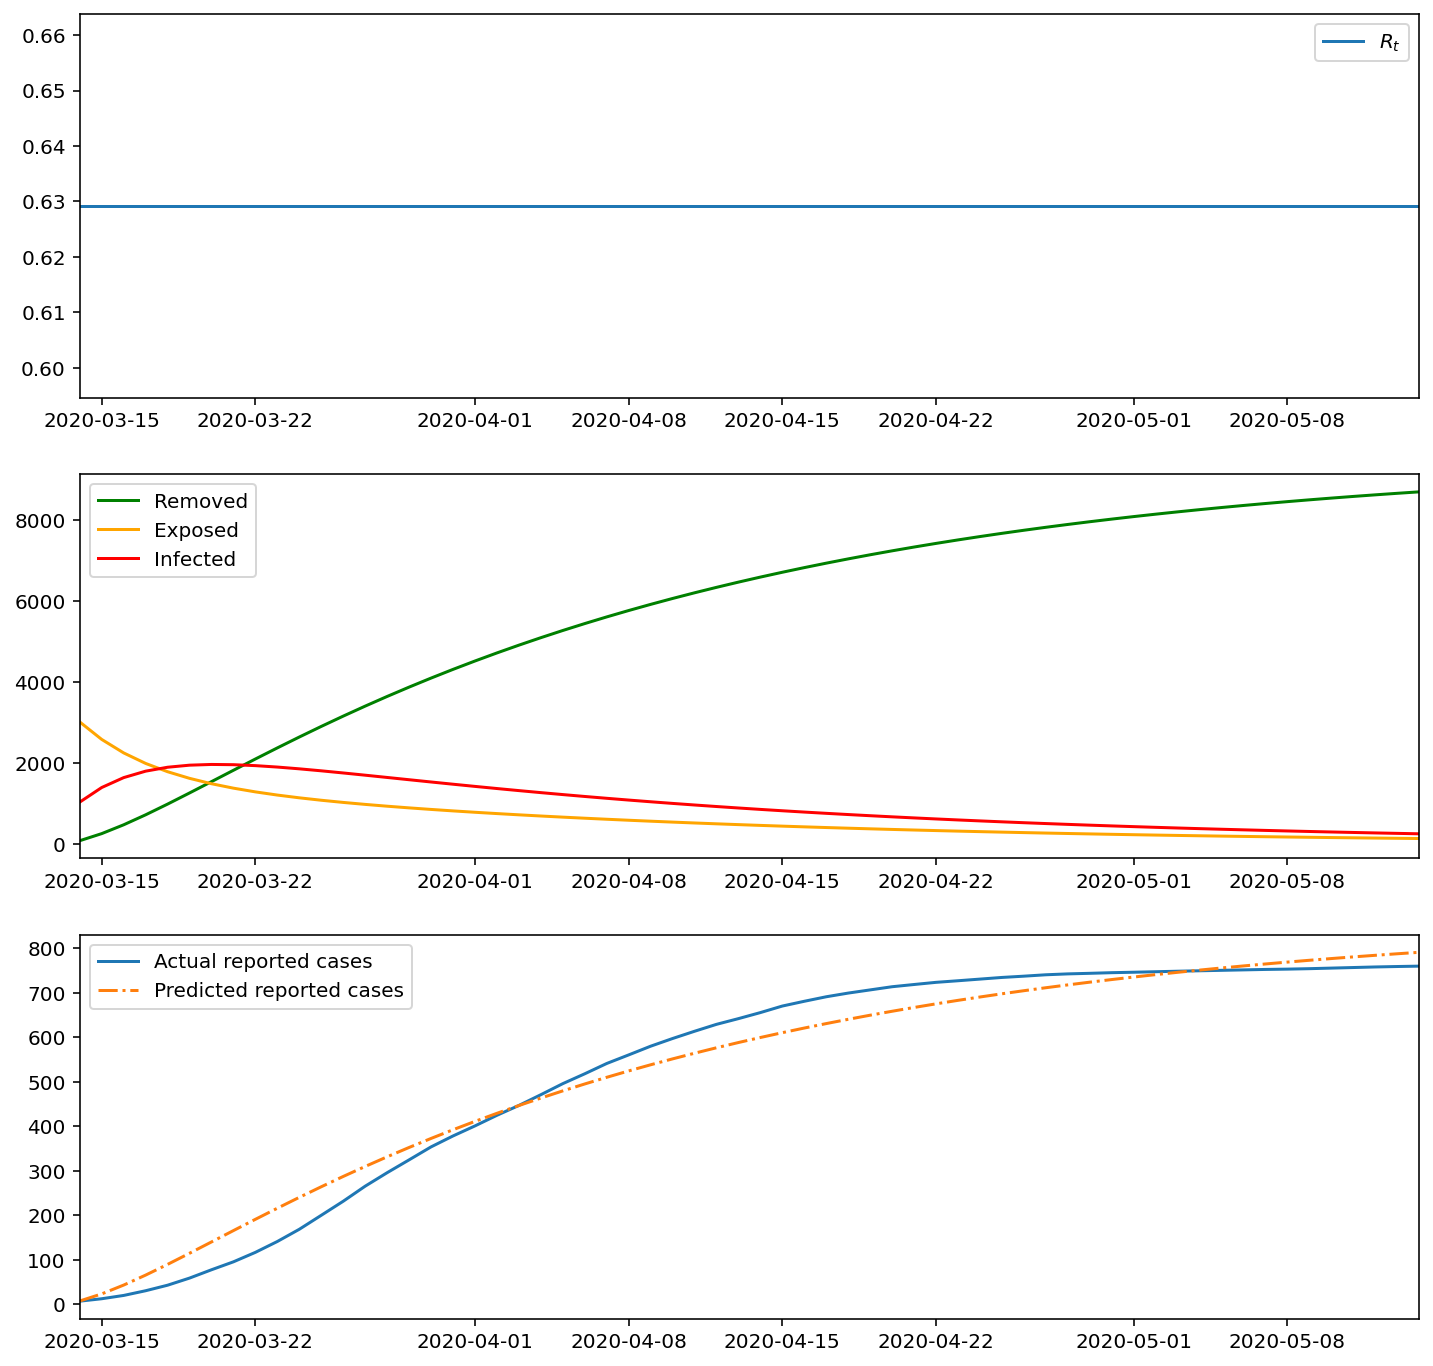


2021-08-13 12:23:48.350575
grid search @ step 3/3 1/3 2/3
training new model:
SEIR model (constant beta)
S0 = None
E0 = 3010.0
I0 = 1030.0
R0 = None
σ = 5.2, γ = None
beta parameter: 0.325

408.65310446923445 True
SEIR model (constant beta)
S0 = 72886.93679997395
E0 = 3008.2084479623245
I0 = 1027.8547520637221
R0 = 77.0
σ = 5.2, γ = 0.12263888194489392
beta parameter: [0.08443949]

time 0:00:00.149003
****** new best fit LL value: 408.65310446923445 ******


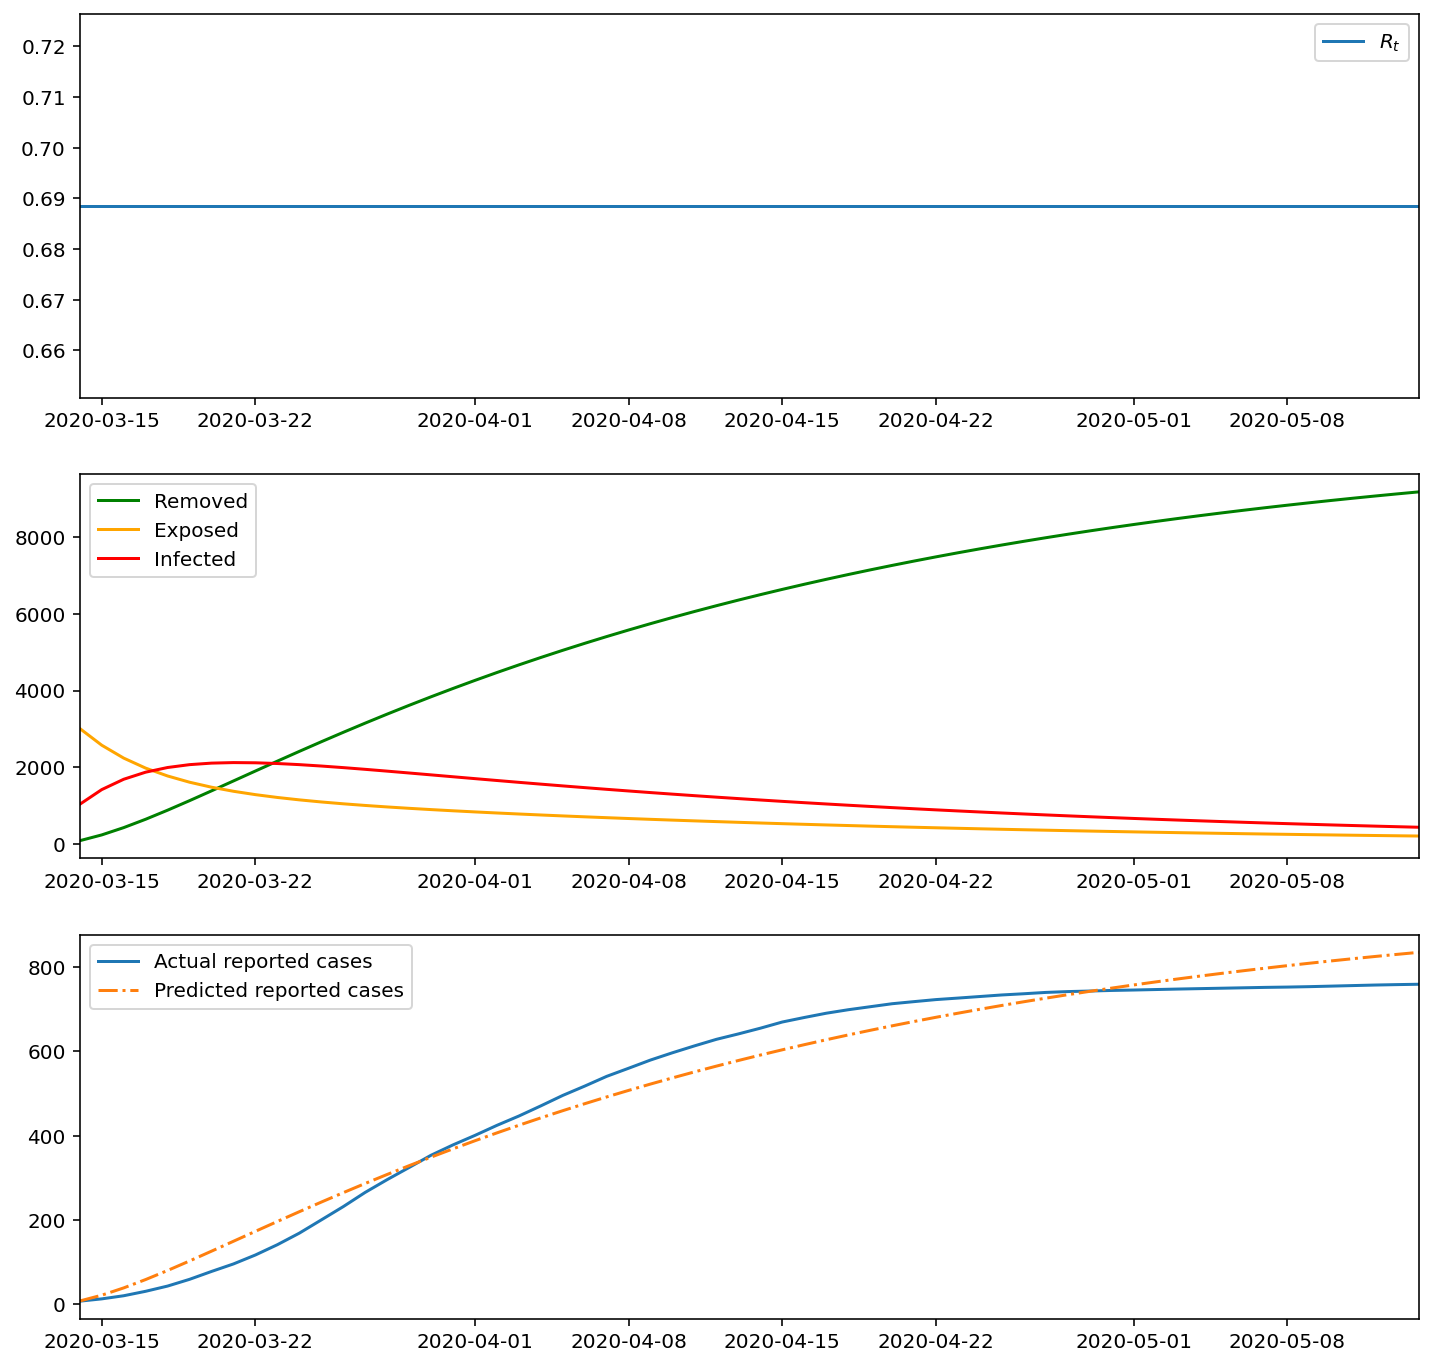


2021-08-13 12:23:49.131575
grid search @ step 3/3 1/3 3/3
training new model:
SEIR model (constant beta)
S0 = None
E0 = 3010.0
I0 = 1030.0
R0 = None
σ = 5.2, γ = None
beta parameter: 0.4625

408.61725910343375 True
SEIR model (constant beta)
S0 = 72897.8818740425
E0 = 3003.601892399862
I0 = 1021.5162335576352
R0 = 77.0
σ = 5.2, γ = 0.12316865178459262
beta parameter: [0.08494071]

time 0:00:00.220174
****** new best fit LL value: 408.61725910343375 ******


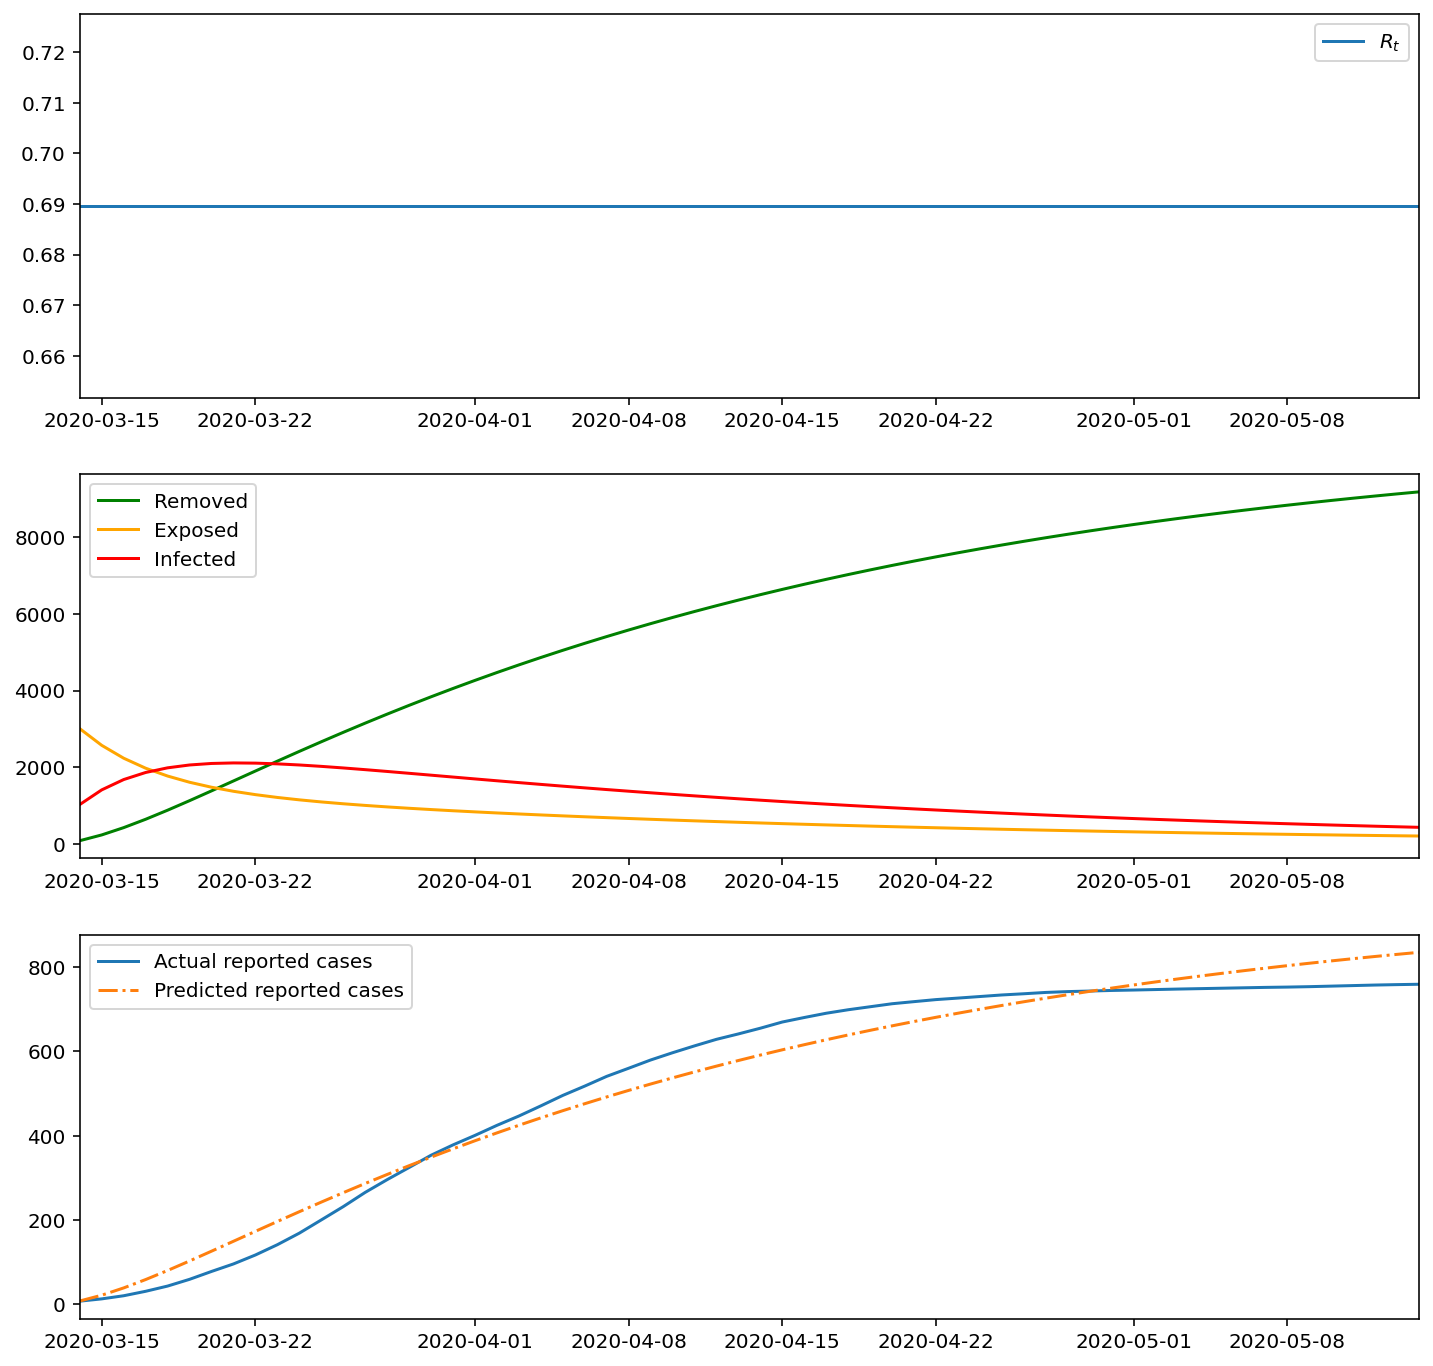


2021-08-13 12:23:50.027812
grid search @ step 3/3 2/3 1/3
training new model:
SEIR model (constant beta)
S0 = None
E0 = 3010.0
I0 = 2020.0
R0 = None
σ = 5.2, γ = None
beta parameter: 0.1875

438.28150821301176 True
SEIR model (constant beta)
S0 = 72473.09169976012
E0 = 2748.3181682975737
I0 = 1701.5901319423162
R0 = 77.0
σ = 5.2, γ = 0.1
beta parameter: [0.065789]

time 0:00:00.383293

2021-08-13 12:23:50.411203
grid search @ step 3/3 2/3 2/3
training new model:
SEIR model (constant beta)
S0 = None
E0 = 3010.0
I0 = 2020.0
R0 = None
σ = 5.2, γ = None
beta parameter: 0.325

437.8030026191641 True
SEIR model (constant beta)
S0 = 72474.17312673511
E0 = 2754.9542147383245
I0 = 1693.8726585265656
R0 = 77.0
σ = 5.2, γ = 0.1
beta parameter: [0.06582603]

time 0:00:00.318245

2021-08-13 12:23:50.729547
grid search @ step 3/3 2/3 3/3
training new model:
SEIR model (constant beta)
S0 = None
E0 = 3010.0
I0 = 2020.0
R0 = None
σ = 5.2, γ = None
beta parameter: 0.4625

362.5687011248205 True
SEIR mo

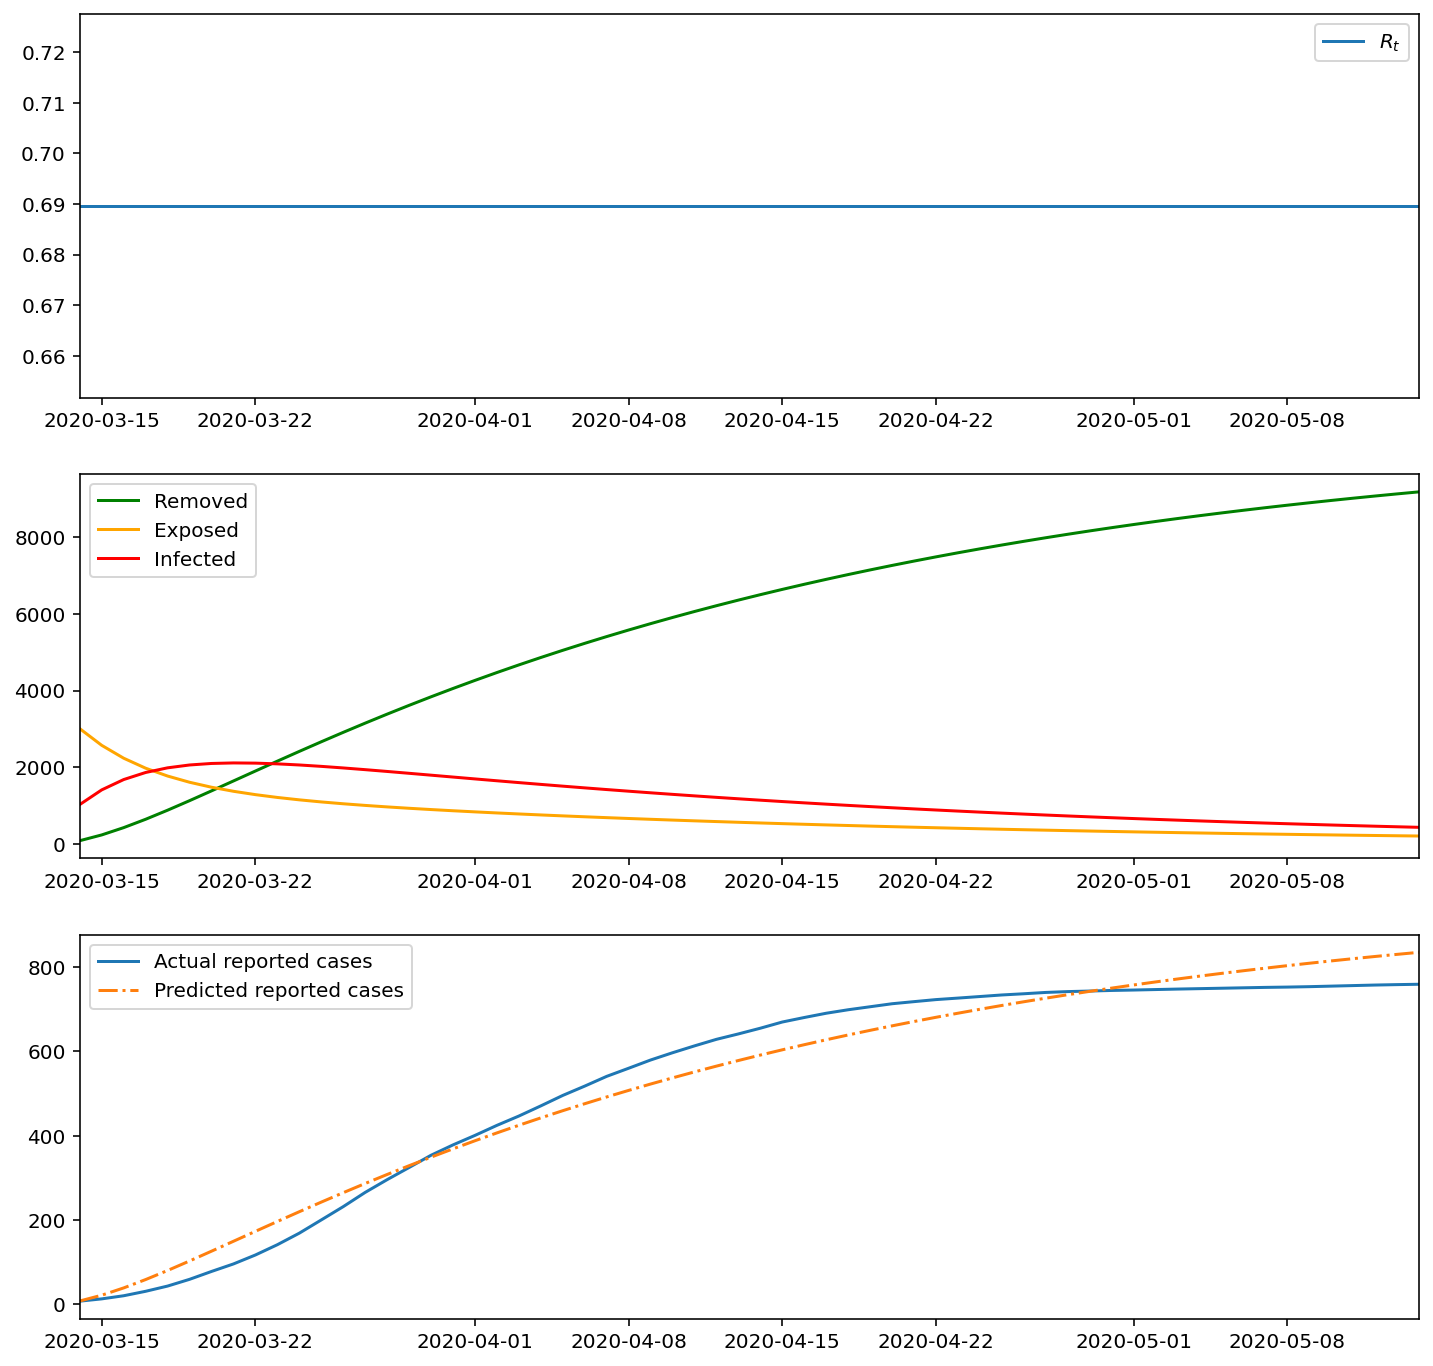

In [337]:
# baseline model
model_constant_beta_train_5_14, ll = get_best_fit_gs(
    ConstantBetaSEIRModel(N=ANDORRA_POPULATION),
    gridsearch_num=3, 
    train_dates=train_dates,
)

In [339]:
print(ll)
model_constant_beta_train_5_14.to_dict()

408.61725910343375


{'class': 'ConstantBetaSEIRModel',
 'S0': 72897.8818740425,
 'E0': 3003.601892399862,
 'I0': 1021.5162335576352,
 'R0': 77.0,
 'C0': 7.0,
 'gamma': 0.12316865178459262,
 'beta_param': [0.08494071351267779],
 'reporting_rate': 0.09090909090909091,
 'ts': 62}

SEIR model (constant beta)
S0 = 72897.8818740425
E0 = 3003.601892399862
I0 = 1021.5162335576352
R0 = 77.0
σ = 5.2, γ = 0.12316865178459262
beta parameter: [0.08494071]

infectious period ~ 8.12 days
training period: 2020-03-14 - 2020-05-14
62 training days; 70 test days
simulated (deterministic) forecast
1-week (7-day) MAPE = 0.0212
2-week (14-day) MAPE = 0.0386
3-week (21-day) MAPE = 0.0537
4-week (28-day) MAPE = 0.0666
5-week (35-day) MAPE = 0.0737
6-week (42-day) MAPE = 0.0773
7-week (49-day) MAPE = 0.0844
8-week (56-day) MAPE = 0.0924
9-week (63-day) MAPE = 0.0987
10-week (70-day) MAPE = 0.0988


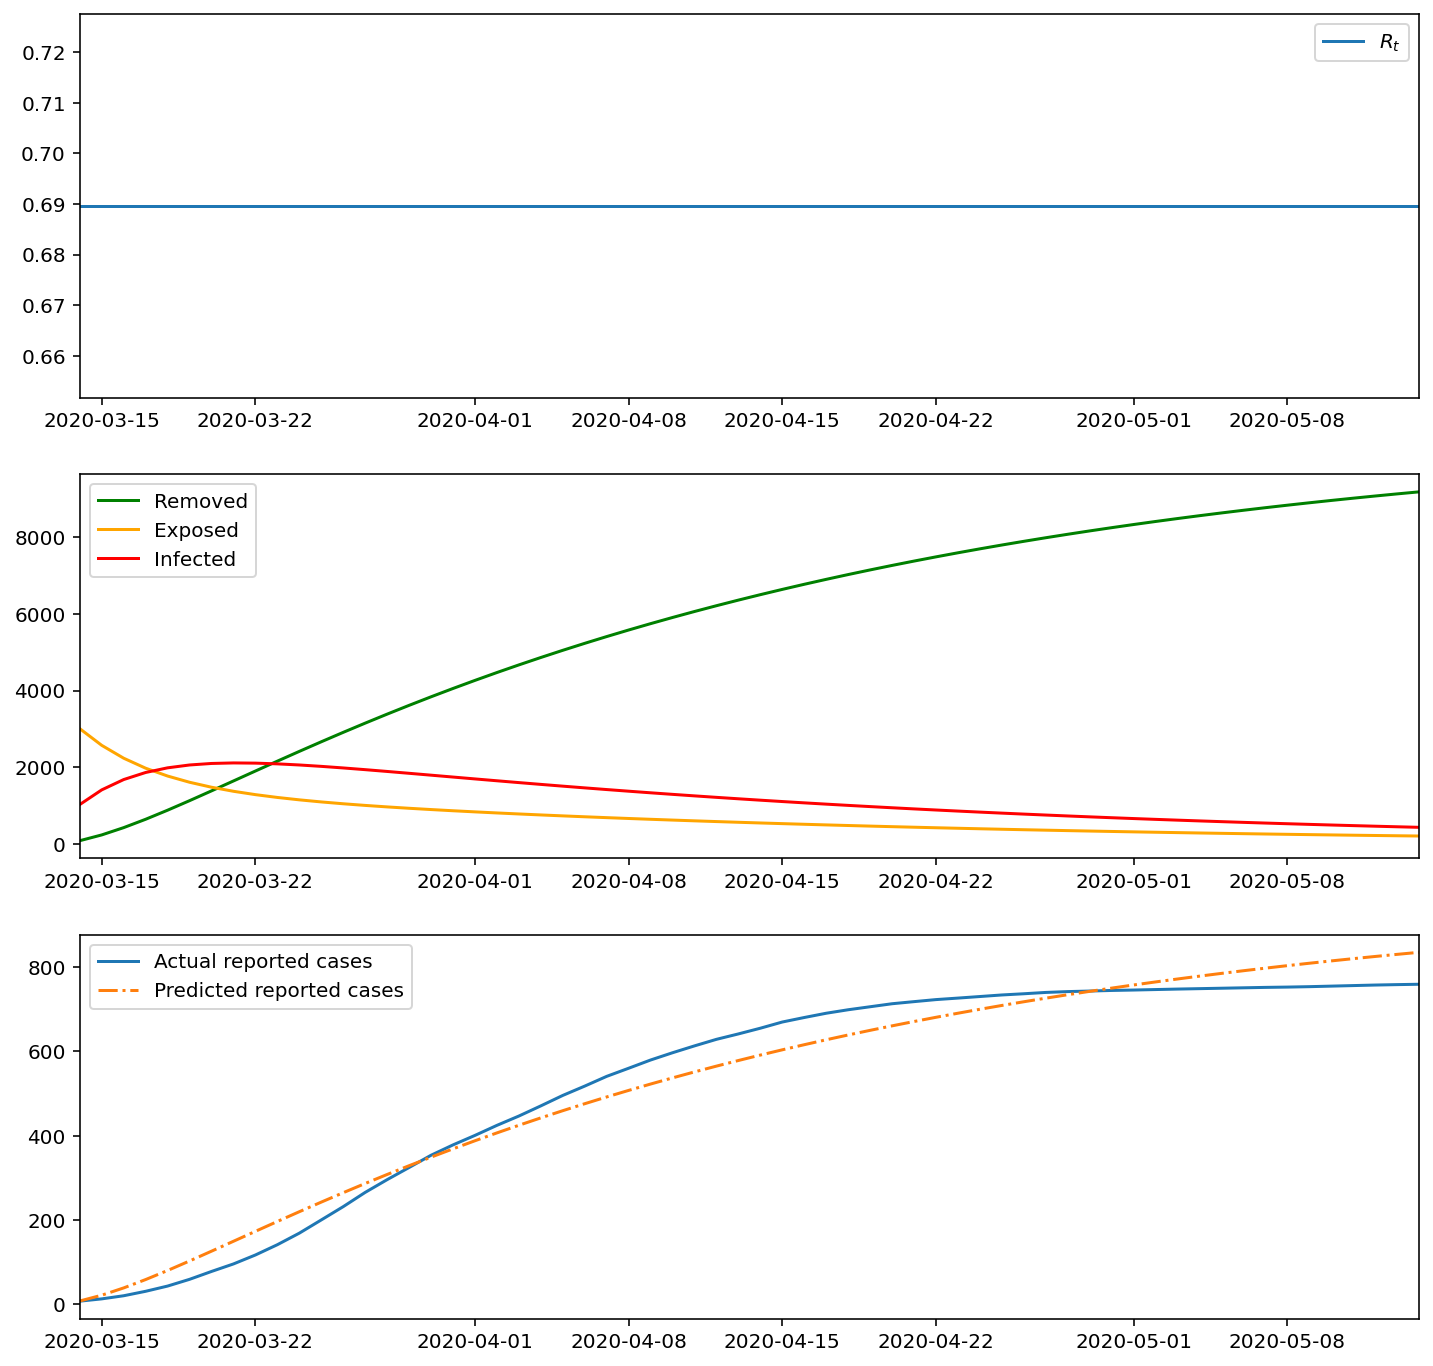

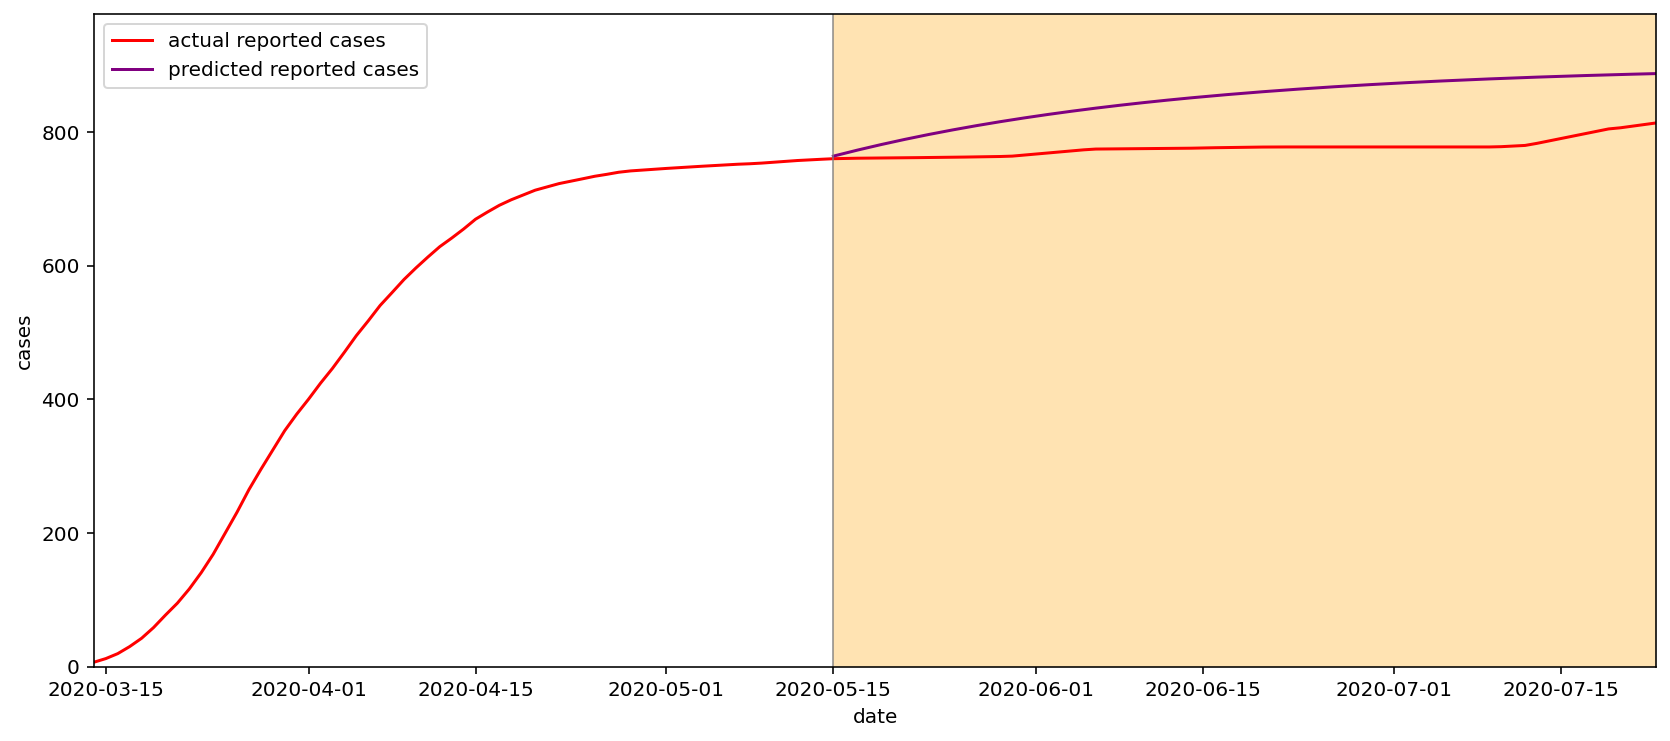

In [341]:
model = model_constant_beta_train_5_14.copy()
model.plots(reported_cases[train_dates[0]:train_dates[1]])
print(model)
print('infectious period ~ %0.2f days' % (1/model.gamma))
train_test_dict_5_14['baseline model'] = get_forecast_results(model, 
                      train_start=train_dates[0],
                      train_end=train_dates[1], 
                      plot_end='2020-07-31')

In [342]:
# trips data model
# model_trips_l7_lag7_train_5_14, ll = get_best_fit_gs(
#     MobilityDataSEIRModel(
#         mobility_data=spline_trips_lag7,
#         N=ANDORRA_POPULATION,
#     ),
#     gridsearch_num=3, 
#     train_dates=train_dates,
# )

In [344]:
model_trips_l7_lag7_train_5_14.to_dict()

{'class': 'MobilityDataSEIRModel',
 'S0': 72886.35849086662,
 'E0': 3993.2988943753808,
 'I0': 43.34261475798365,
 'R0': 77.0,
 'C0': 7.0,
 'gamma': 0.14539017412837094,
 'beta_param': [0.00011974499141529536,
  0.08363613480064612,
  0.010530425166401913],
 'reporting_rate': 0.09090909090909091,
 'ts': 62}

In [346]:
model_trips_l7_lag7_train_5_14 = SEIRModel.from_dict({
    'S0': 72886.35849086662,
    'E0': 3993.2988943753808,
    'I0': 43.34261475798365,
    'R0': 77.0,
    'C0': 7.0,
    'gamma': 0.14539017412837094,
    'beta_param': [0.00011974499141529536,
    0.08363613480064612,
    0.010530425166401913],
    'reporting_rate': 0.09090909090909091,
    'class':'MobilityDataSEIRModel',
    'mobility_data': total_trips[(14-1-reporting_lag):],
    'ts':62,
})
ll, _success = model_trips_l7_lag7_train_5_14.fit(reported_cases[train_dates[0]:train_dates[1]])
print(ll)

338.93509527459616


338.93509527459616
S0 = 72886.36794773937
E0 = 3993.2895259660013
I0 = 43.342526294619866
R0 = 77.0
σ = 5.2, γ = 0.14540442588951494
beta parameter: [0.0001767  0.08363429 0.010586  ]

infectious period ~ 6.88 days
training period: 2020-03-14 - 2020-05-14
62 training days; 70 test days
simulated (deterministic) forecast
1-week (7-day) MAPE = 0.0165
2-week (14-day) MAPE = 0.0299
3-week (21-day) MAPE = 0.0412
4-week (28-day) MAPE = 0.0506
5-week (35-day) MAPE = 0.0544
6-week (42-day) MAPE = 0.0550
7-week (49-day) MAPE = 0.0592
8-week (56-day) MAPE = 0.0645
9-week (63-day) MAPE = 0.0683
10-week (70-day) MAPE = 0.0648


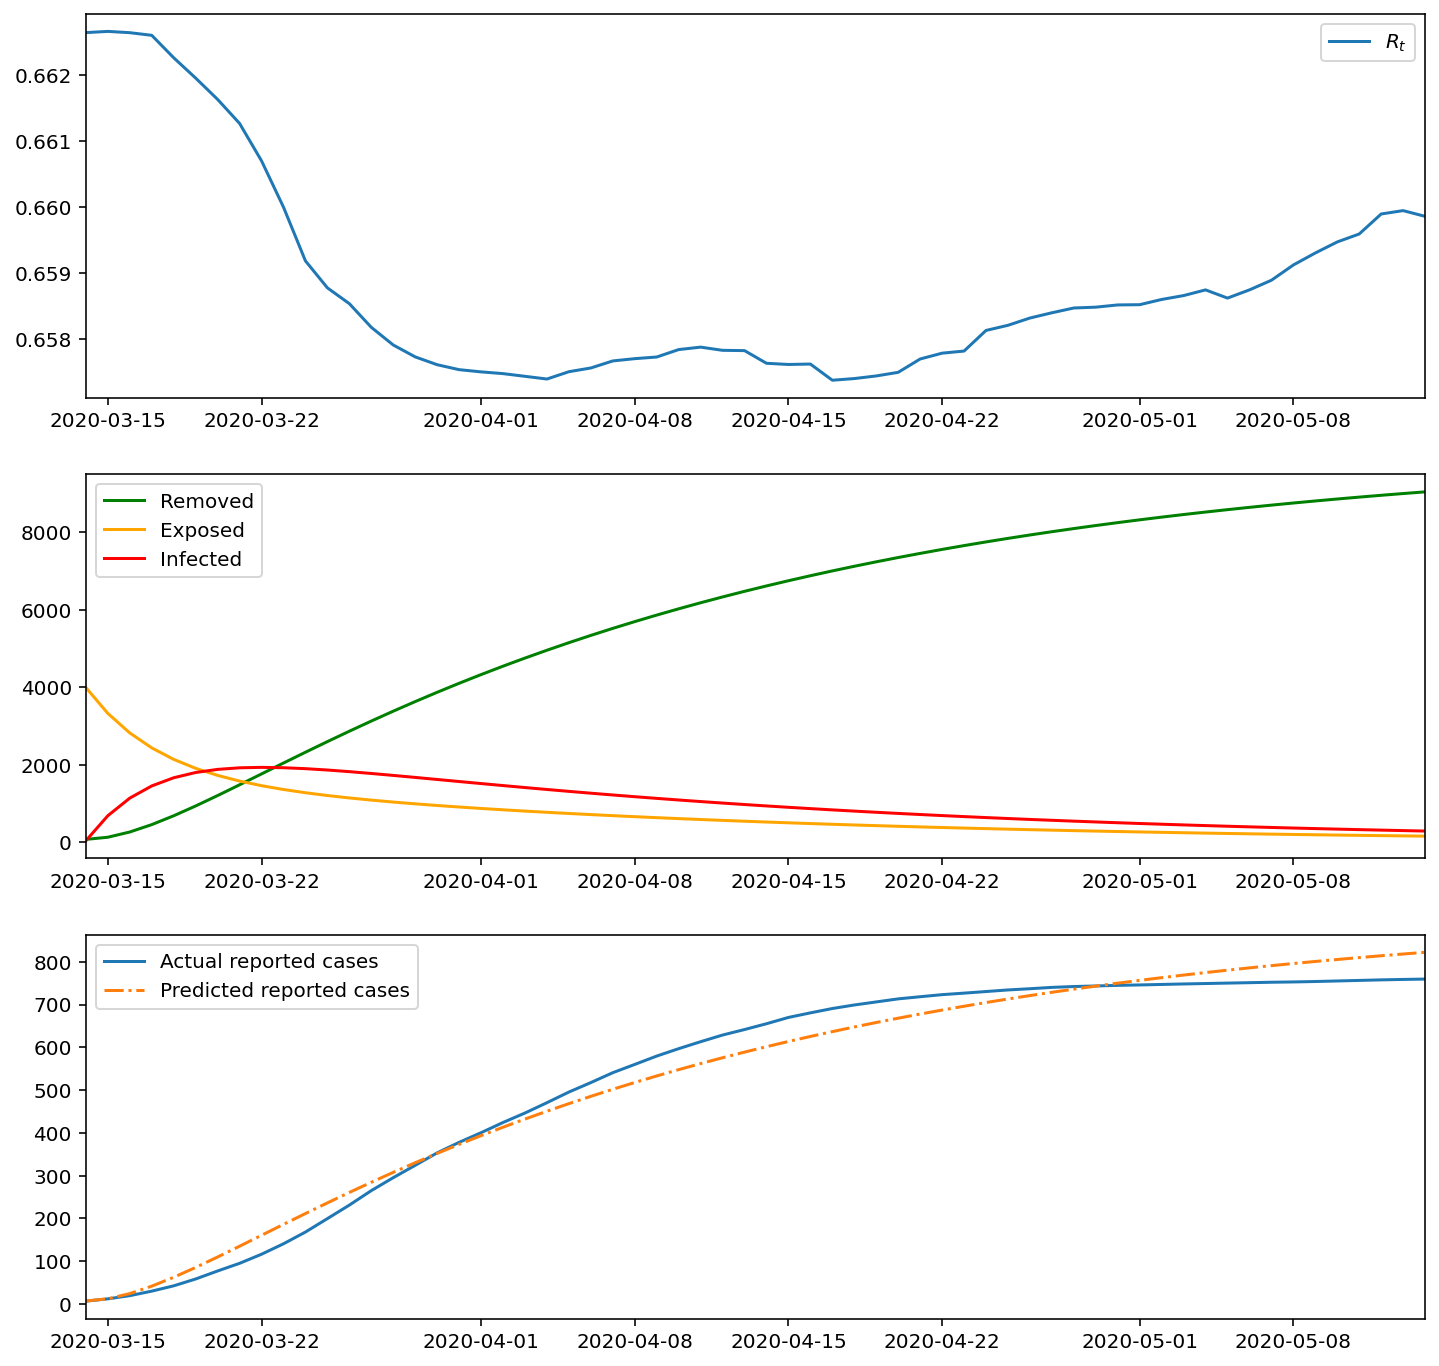

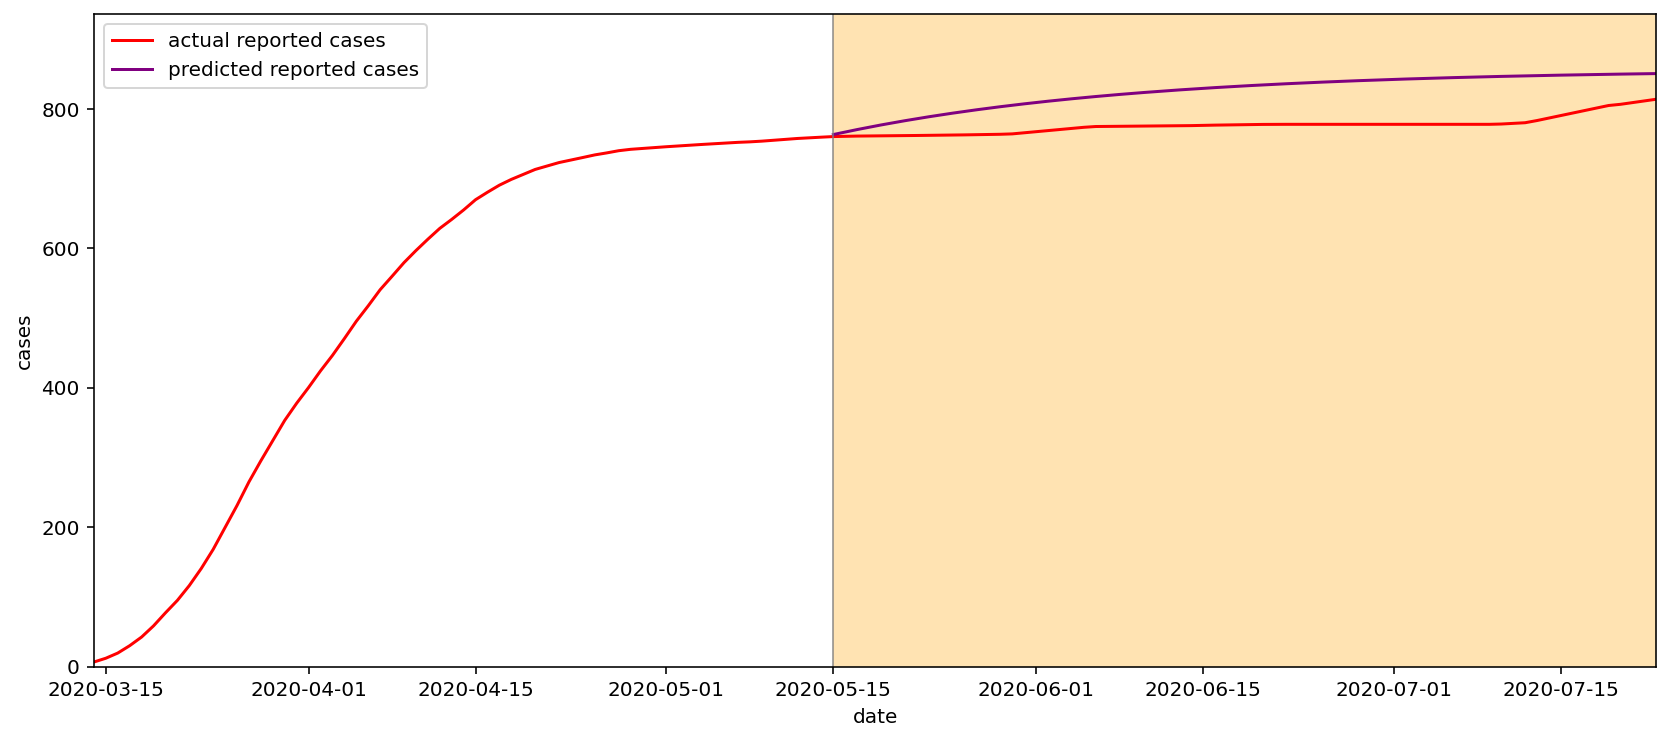

In [347]:
model = model_trips_l7_lag7_train_5_14.copy()
model.plots(reported_cases[train_dates[0]:train_dates[1]])
print(ll)
print(model)
print('infectious period ~ %0.2f days' % (1/model.gamma))
train_test_dict_5_14['trips data model'] = get_forecast_results(model, 
                      train_start=train_dates[0],
                      train_end=train_dates[1], 
                      plot_end='2020-07-31')

In [348]:
# trips & entrances data model
# model_trips_entrances_l7_lag7_train_5_14, ll = get_best_fit_gs(
#     MobilityEntrancesDataSEIRModel(
#         mobility_data=spline_trips_lag7,
#         entrances_data=spline_entrances_lag7,
#         N=ANDORRA_POPULATION,
#     ),
#     gridsearch_num=3, 
#     train_dates=train_dates,
# )

In [350]:
model_trips_entrances_l7_lag7_train_5_14.to_dict()

{'class': 'MobilityEntrancesDataSEIRModel',
 'S0': 72882.99919030264,
 'E0': 3994.4450688987677,
 'I0': 45.55574079858612,
 'R0': 77.0,
 'C0': 7.0,
 'gamma': 0.10112181319674347,
 'beta_param': [0.0022764993084555102,
  0.003331945630478409,
  0.005611532023383692,
  9.971618980131752e-05,
  0.8848060612006373],
 'reporting_rate': 0.09090909090909091,
 'ts': 62}

In [353]:
model_trips_entrances_l7_lag7_train_5_14 = SEIRModel.from_dict({
    'class':'MobilityEntrancesDataSEIRModel',
    'S0': 72882.99919030264,
    'E0': 3994.4450688987677,
    'I0': 45.55574079858612,
    'R0': 77.0,
    'C0': 7.0,
    'gamma': 0.10112181319674347,
    'beta_param': [0.0022764993084555102,
    0.003331945630478409,
    0.005611532023383692,
    9.971618980131752e-05,
    0.8848060612006373],
    'reporting_rate': 0.09090909090909091,
    'mobility_data': total_trips[(14-1-reporting_lag):],
    'entrances_data': entrances[(14-1-reporting_lag):],
    'ts':62,
})
ll, _success = model_trips_entrances_l7_lag7_train_5_14.fit(reported_cases[train_dates[0]:train_dates[1]])
print(ll)

280.919594965241


S0 = 72882.9991693161
E0 = 3994.4450689871774
I0 = 45.55576169672178
R0 = 77.0
σ = 5.2, γ = 0.1011222804975695
beta parameter: [2.27568869e-03 3.33083921e-03 5.61169466e-03 7.84085807e-05
 8.84805515e-01]

infectious period ~ 9.89 days
training period: 2020-03-14 - 2020-05-14
62 training days; 70 test days
simulated (deterministic) forecast
1-week (7-day) MAPE = 0.0113
2-week (14-day) MAPE = 0.0202
3-week (21-day) MAPE = 0.0274
4-week (28-day) MAPE = 0.0302
5-week (35-day) MAPE = 0.0315
6-week (42-day) MAPE = 0.0323
7-week (49-day) MAPE = 0.0334
8-week (56-day) MAPE = 0.0344
9-week (63-day) MAPE = 0.0357
10-week (70-day) MAPE = 0.0347


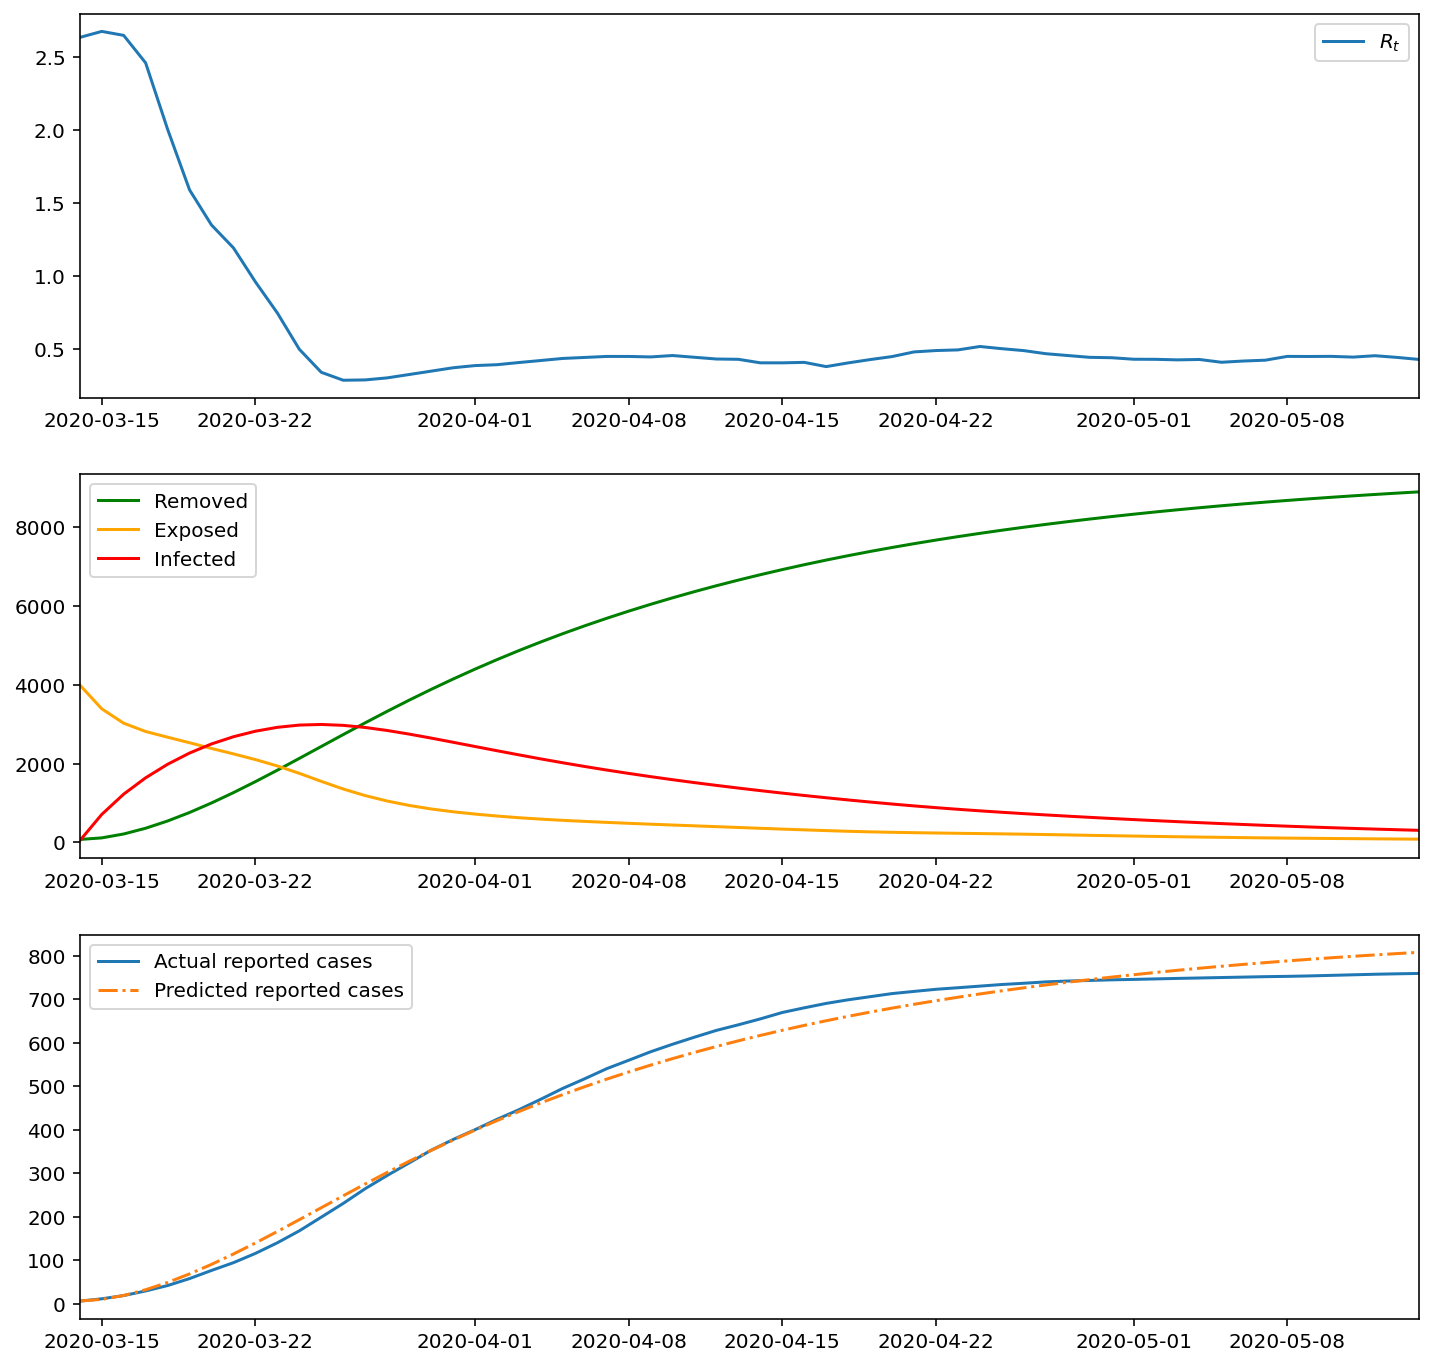

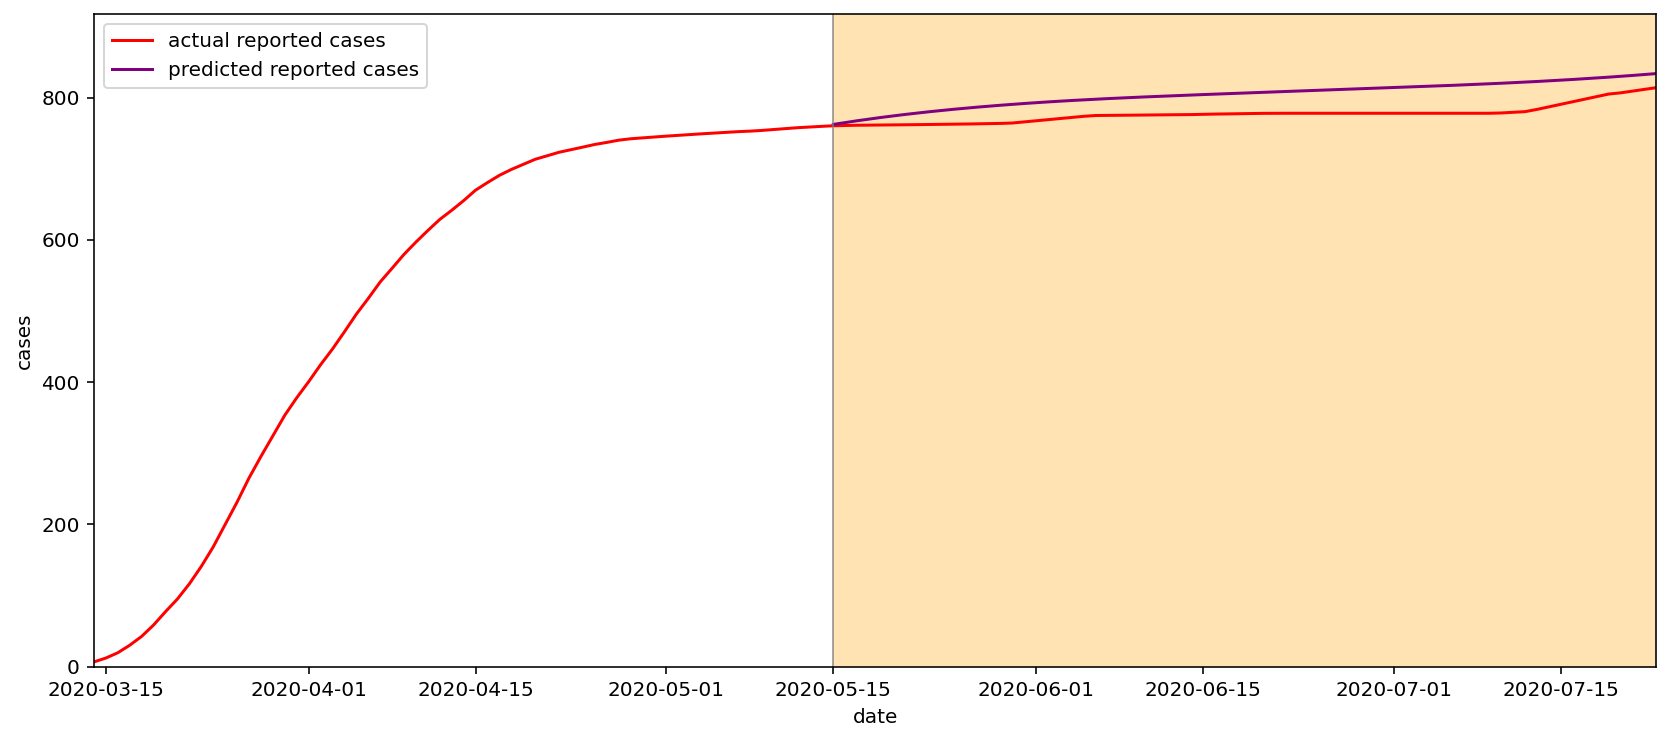

In [354]:
model = model_trips_entrances_l7_lag7_train_5_14.copy()
model.plots(reported_cases[train_dates[0]:train_dates[1]])
print(model)
print('infectious period ~ %0.2f days' % (1/model.gamma))
train_test_dict_5_14['trips & entrances data model'] = get_forecast_results(model, 
                      train_start=train_dates[0],
                      train_end=train_dates[1], 
                      plot_end='2020-07-31')

In [355]:
print('Training period: %s - %s\nMAPE' % (train_dates[0], train_dates[1]))
pd.DataFrame(train_test_dict_5_14).set_index('forecasting weeks')

Training period: 2020-03-14 - 2020-05-14
MAPE


baseline model  trips data model  \
forecasting weeks                                     
1                        0.021230          0.016522   
2                        0.038552          0.029889   
3                        0.053688          0.041249   
4                        0.066576          0.050567   
5                        0.073664          0.054367   
6                        0.077255          0.054951   
7                        0.084363          0.059180   
8                        0.092420          0.064523   
9                        0.098697          0.068303   
10                       0.098771          0.064783   

                   trips & entrances data model  
forecasting weeks                                
1                                      0.011263  
2                                      0.020236  
3                                      0.027391  
4                                      0.030209  
5                                      0.031483  
6                                      0.032274  
7                                      0.033446  
8                                      0.034391  
9                                      0.035671  
10                                     0.034689